<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preliminary" data-toc-modified-id="Preliminary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preliminary</a></span></li><li><span><a href="#Case-Study" data-toc-modified-id="Case-Study-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Case Study</a></span><ul class="toc-item"><li><span><a href="#Case-1---Qwen-qkv-toy" data-toc-modified-id="Case-1---Qwen-qkv-toy-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Case 1 - Qwen qkv toy</a></span></li><li><span><a href="#Case-2---Qwen-qkvo-0~23" data-toc-modified-id="Case-2---Qwen-qkvo-0~23-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Case 2 - Qwen qkvo 0~23</a></span><ul class="toc-item"><li><span><a href="#对比两个不同长度的prompt的输出？" data-toc-modified-id="对比两个不同长度的prompt的输出？-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>对比两个不同长度的prompt的输出？</a></span></li></ul></li><li><span><a href="#Case-3---DeepSeek-qkvo-0-~-27" data-toc-modified-id="Case-3---DeepSeek-qkvo-0-~-27-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Case 3 - DeepSeek qkvo 0 ~ 27</a></span><ul class="toc-item"><li><span><a href="#对比两个不同长度的prompt的输出？" data-toc-modified-id="对比两个不同长度的prompt的输出？-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>对比两个不同长度的prompt的输出？</a></span></li></ul></li><li><span><a href="#Case-4---DeepSeek-layer-0~27" data-toc-modified-id="Case-4---DeepSeek-layer-0~27-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Case 4 - DeepSeek layer 0~27</a></span></li><li><span><a href="#Case-5---Qwen-layer-0-23" data-toc-modified-id="Case-5---Qwen-layer-0-23-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Case 5 - Qwen layer 0-23</a></span></li></ul></li></ul></div>

In [1]:
import os
import re
import string
import torch
from torch import nn
from torch.nn import functional as F
if not "CHDIR_FLAG" in dir():
    os.chdir("../")
    CHDIR_FLAG = True
    
import numpy as np
import pandas as pd
from datasets import load_dataset

from src.tools.torch import register_forward_hook_decorator, register_backward_hook_decorator
from src.tools.plot import plot_tensor_histogram, plot_tensor_heatmap
from transformers import AutoTokenizer, AutoModelForCausalLM

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# Preliminary

这边使用的是`src.tools.transformers`中手写的解码方法，在`model.forward`外面套了个hook装饰器（定义在`src.tools.hook`中）

目的是挖掘不同输入带了的各隐层输入输出的变化

注意对于Qwen系列模型，它的`lm_head`的`output`就是最终的logits（已经验证）

In [2]:
def easy_compare_forward_hook_data(
    hook_data_path_1, 
    hook_data_path_2,
    forward_hook_module_names,
    figure_names = None,
    pivot_at = 0,
):
    regex = re.compile("\[\d+\]", re.I)
    hook_data_1 = torch.load(hook_data_path_1)
    hook_data_2 = torch.load(hook_data_path_2)
    for i, (data_1, data_2) in enumerate(zip(hook_data_1, hook_data_2)):
        if i != pivot_at:
            # Care about the pivot token only
            continue
        if figure_names is None:
            diff_dict = {
                "embed_tokens": {"input": [], "output": []},
                "norm": {"input": [], "output": []},
                "q_proj": {"input": [], "output": []},
                "k_proj": {"input": [], "output": []},
                "v_proj": {"input": [], "output": []},
                "layers": {"input": [], "output": []},
            }
        else:
            diff_dict = {figure_name: {"input": [], "output": []} for figure_name in figure_names}
        for module_name in forward_hook_module_names:
            module_name_suffix = module_name.split('.')[-1]
            module_name_suffix = regex.sub(str(), module_name_suffix)
            if module_name_suffix in diff_dict:
                input_data_1 = data_1[module_name].get("input", data_1[module_name].get("args"))
                input_data_2 = data_1[module_name].get("input", data_2[module_name].get("args"))
                output_data_1 = data_1[module_name]["output"]
                output_data_2 = data_2[module_name]["output"]      
                # Assertation for ensuring data format
                assert len(input_data_1) == 1 and isinstance(input_data_1[0], tuple)
                assert len(input_data_2) == 1 and isinstance(input_data_2[0], tuple)
                if len(input_data_1[0]) > 1:
                    print(f"*** Warning for input data 1: {len(input_data_1[0])} ***")
                if len(input_data_2[0]) > 1:
                    print(f"*** Warning for input data 1: {len(input_data_2[0])} ***")
                input_tensor_1 = input_data_1[0][0].float()
                input_tensor_2 = input_data_2[0][0].float()
                # print(input_tensor_1.size(), input_tensor_2.size())
                # ---
                assert len(output_data_1) == 1
                if isinstance(output_data_1[0], torch.Tensor):
                    output_tensor_1 = output_data_1[0]
                else:
                    assert isinstance(output_data_1[0], tuple)
                    if len(output_data_1[0]) > 1:
                        print(f"*** Warning for output data 1: {len(output_data_1[0])} ***")
                    output_tensor_1 = output_data_1[0][0]
                if isinstance(output_data_2[0], torch.Tensor):
                    output_tensor_2 = output_data_2[0]
                else:
                    assert isinstance(output_data_2[0], tuple)
                    if len(output_data_2[0]) > 1:
                        print(f"*** Warning for output data 2: {len(output_data_2[0])} ***")
                    output_tensor_2 = output_data_2[0][0]
                input_diff = torch.norm(input_tensor_1 - input_tensor_2, p="fro")
                output_diff = torch.norm(output_tensor_1 - output_tensor_2, p="fro")
                avg_input_diff = input_diff / input_tensor_1.numel()
                avg_output_diff = output_diff / output_tensor_1.numel()
                # log_input_diff = torch.log(avg_input_diff)
                # log_output_diff = torch.log(avg_output_diff)
                diff_dict[module_name_suffix]["input"].append(avg_input_diff.item())
                diff_dict[module_name_suffix]["output"].append(avg_output_diff.item())
        
        figure_width = 5
        fig, axs = plt.subplots(1, len(diff_dict), figsize=((figure_width + 1) * len(diff_dict), figure_width))
        for i, key in enumerate(diff_dict):
            y_input = diff_dict[key]["input"]
            y_output = diff_dict[key]["output"]
            assert len(y_input) == len(y_output)
            x = range(len(y_input))
            if len(x) == 0:
                continue
            if len(diff_dict) == 1:
                axs.bar(x, y_input, label="input_diff", alpha=.5)
                axs.bar(x, y_output, label="output_diff", alpha=.5)
                axs.set_xlabel("Layer #"), axs.set_ylabel("Diff"), axs.set_title(f"Diff for {key}")
                axs.legend()
            else:
                axs[i].bar(x, y_input, label="input_diff", alpha=.5)
                axs[i].bar(x, y_output, label="output_diff", alpha=.5)
                axs[i].set_xlabel("Layer #"), axs[i].set_ylabel("Diff"), axs[i].set_title(f"Diff for {key}")
                axs[i].legend()
        plt.show(), plt.close()
    return diff_dict

In [3]:
def check_hook_data(
    hook_data_path,
):
    hook_data = torch.load(hook_data_path)
    for i, data in enumerate(hook_data):
        if i == 0:
            continue
        for key in data:
            print(key)
            inputs = data[key]["input"]
            outputs = data[key]["output"]
            print(f"  # Inputs: {len(inputs)}")
            print(f"  # Outputs: {len(outputs)}")
            for input_tuple in inputs:
                print(input_tuple[0].size())

In [4]:
dp = "./results/strawberry-1/fhook+Qwen2.5-0.5B-Instruct+True.pt"
dp = "./results/strawberry-X-2/fhook+DeepSeek-R1-Distill-Qwen-1.5B+True-71.pt"
dp = "./results/strawberry-X-1/fhook+Qwen2.5-0.5B-Instruct+True-68.pt"
check_hook_data(dp)

model.embed_tokens
  # Inputs: 1
  # Outputs: 1
torch.Size([1, 1])
model.rotary_emb
  # Inputs: 1
  # Outputs: 1
torch.Size([1, 1, 896])
model.norm
  # Inputs: 1
  # Outputs: 1
torch.Size([1, 1, 896])
model.layers[0].self_attn.q_proj
  # Inputs: 1
  # Outputs: 1
torch.Size([1, 1, 896])
model.layers[1].self_attn.q_proj
  # Inputs: 1
  # Outputs: 1
torch.Size([1, 1, 896])
model.layers[2].self_attn.q_proj
  # Inputs: 1
  # Outputs: 1
torch.Size([1, 1, 896])
model.layers[3].self_attn.q_proj
  # Inputs: 1
  # Outputs: 1
torch.Size([1, 1, 896])
model.layers[4].self_attn.q_proj
  # Inputs: 1
  # Outputs: 1
torch.Size([1, 1, 896])
model.layers[5].self_attn.q_proj
  # Inputs: 1
  # Outputs: 1
torch.Size([1, 1, 896])
model.layers[6].self_attn.q_proj
  # Inputs: 1
  # Outputs: 1
torch.Size([1, 1, 896])
model.layers[7].self_attn.q_proj
  # Inputs: 1
  # Outputs: 1
torch.Size([1, 1, 896])
model.layers[8].self_attn.q_proj
  # Inputs: 1
  # Outputs: 1
torch.Size([1, 1, 896])
model.layers[9].self_attn

In [5]:
forward_hook_module_names = \
    [f"model.layers[{i}].self_attn.q_proj" for i in range(24)] + \
    [f"model.layers[{i}].self_attn.k_proj" for i in range(24)] + \
    [f"model.layers[{i}].self_attn.v_proj" for i in range(24)]

hook_data_path_1_1 = r"./results/strawberry-1/fhook+Qwen2.5-0.5B-Instruct+False.pt"
hook_data_path_1_2 = r"./results/strawberry-1/fhook+Qwen2.5-0.5B-Instruct+True.pt"
hook_data_path_2_1 = r"./results/strawberry-2/fhook+Qwen2.5-0.5B-Instruct+False.pt"
hook_data_path_2_2 = r"./results/strawberry-2/fhook+Qwen2.5-0.5B-Instruct+True.pt"

table_path_1_1 = r"./results/strawberry-1/decode+Qwen2.5-0.5B-Instruct+False.csv"
table_path_1_2 = r"./results/strawberry-1/decode+Qwen2.5-0.5B-Instruct+True.csv"
table_path_2_1 = r"./results/strawberry-2/decode+Qwen2.5-0.5B-Instruct+False.csv"
table_path_2_2 = r"./results/strawberry-2/decode+Qwen2.5-0.5B-Instruct+True.csv"

In [6]:
hook_data = torch.load(hook_data_path_1_2)

In [3]:
from src.tools.transformers import robust_cosine_similarity


x = torch.tensor([[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]])
y = torch.tensor([[1.1, 2.1, 3.1, 4.1, 5.1, 60.0, 70.0, 80.0, 90.0, 100.0]])  # 后5个是异常值

# 计算普通余弦相似度
normal_sim = F.cosine_similarity(x, y, dim=1).item()

# 计算鲁棒余弦相似度
robust_sim = robust_cosine_similarity(x, y, filter_outlier=.5)  # 剔除50%的异常值

print(f"普通余弦相似度: {normal_sim:.4f}")
print(f"鲁棒余弦相似度：{robust_sim:.4f}")

普通余弦相似度: 0.9408
鲁棒余弦相似度：0.9999


# Case Study

## Case 1 - Qwen qkv toy

针对两个简单的案例进行对比分析（模型Qwen2.5-0.5B-Instruct）：

- `strawberry-1`: 英文单词strawberry中有几个字母s？
- `strawberry-2`: 英文单词strawberry中有几个字母r？

In [5]:
forward_hook_module_names = \
    [f"model.layers[{i}].self_attn.q_proj" for i in range(24)] + \
    [f"model.layers[{i}].self_attn.k_proj" for i in range(24)] + \
    [f"model.layers[{i}].self_attn.v_proj" for i in range(24)]

hook_data_path_1_1 = r"./results/strawberry-1/fhook+Qwen2.5-0.5B-Instruct+False.pt"
hook_data_path_1_2 = r"./results/strawberry-1/fhook+Qwen2.5-0.5B-Instruct+True.pt"
hook_data_path_2_1 = r"./results/strawberry-2/fhook+Qwen2.5-0.5B-Instruct+False.pt"
hook_data_path_2_2 = r"./results/strawberry-2/fhook+Qwen2.5-0.5B-Instruct+True.pt"

table_path_1_1 = r"./results/strawberry-1/decode+Qwen2.5-0.5B-Instruct+False.csv"
table_path_1_2 = r"./results/strawberry-1/decode+Qwen2.5-0.5B-Instruct+True.csv"
table_path_2_1 = r"./results/strawberry-2/decode+Qwen2.5-0.5B-Instruct+False.csv"
table_path_2_2 = r"./results/strawberry-2/decode+Qwen2.5-0.5B-Instruct+True.csv"

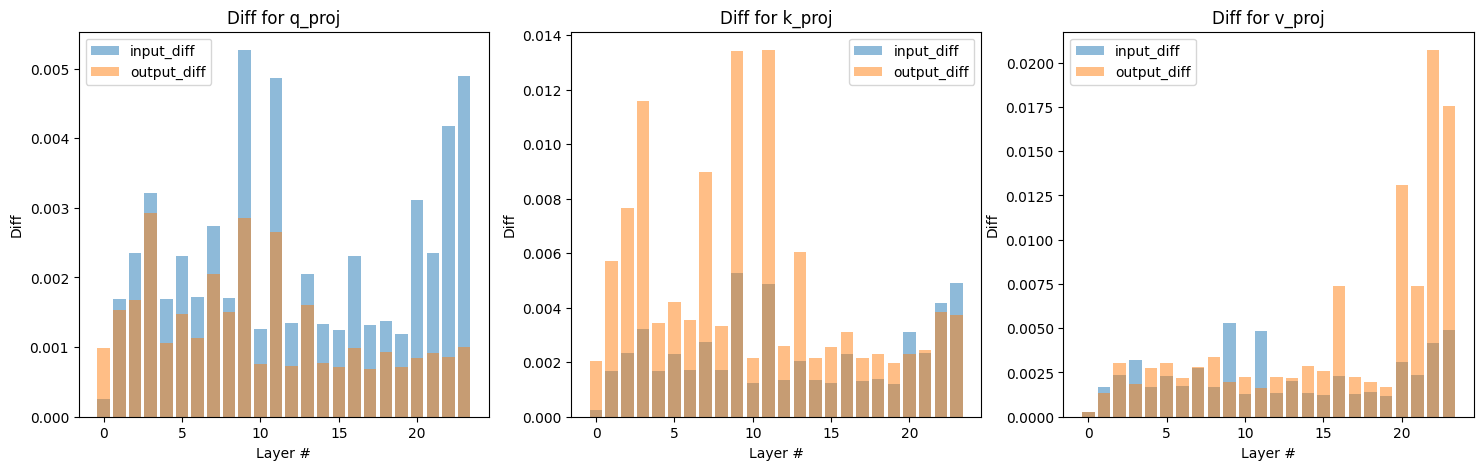

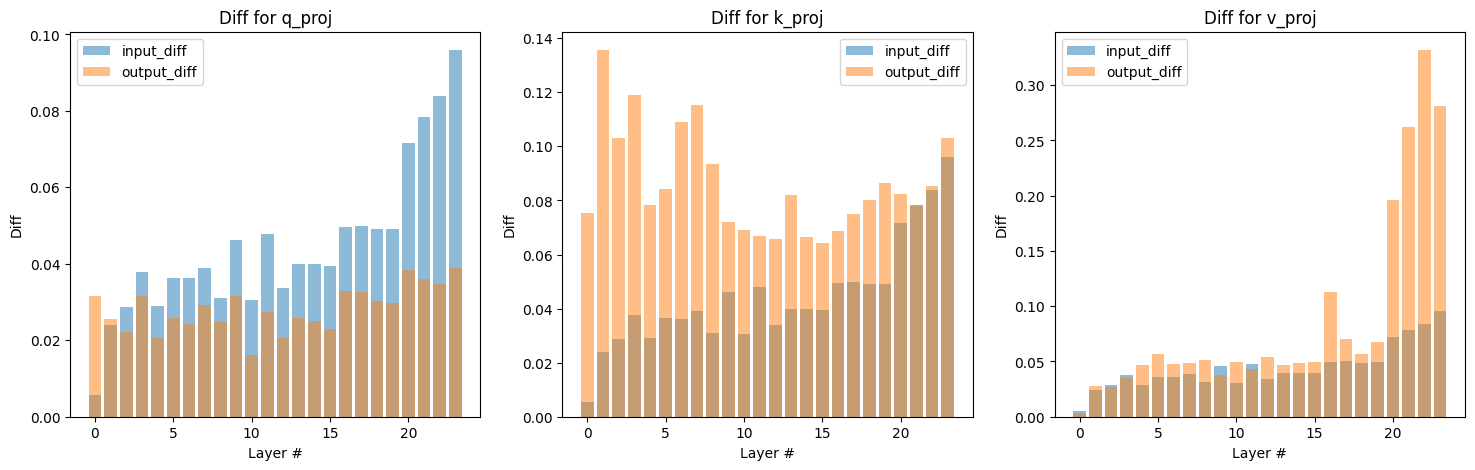

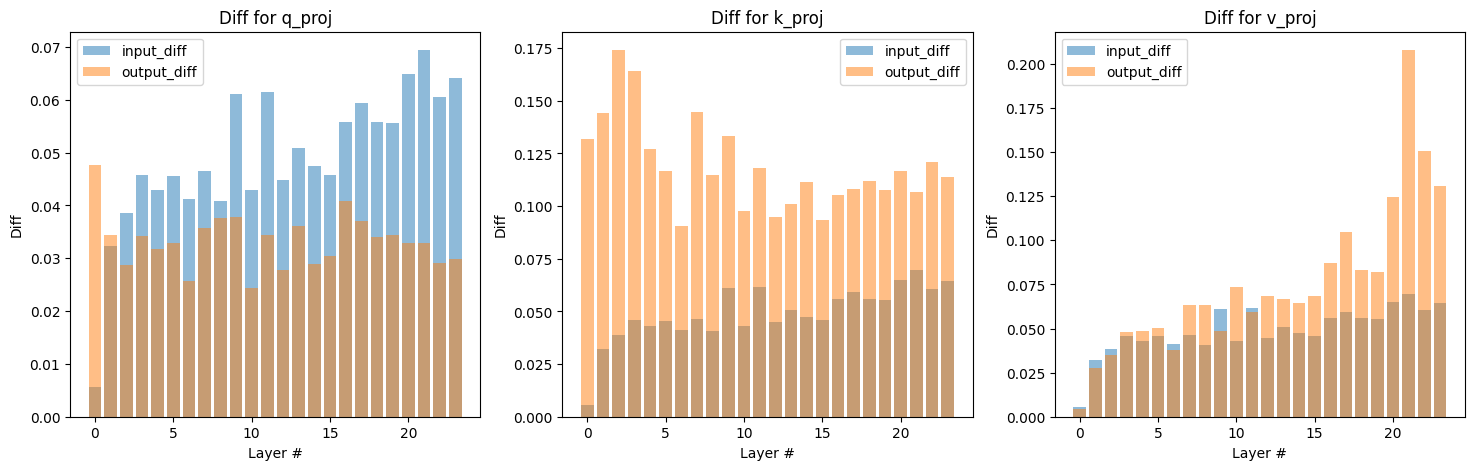

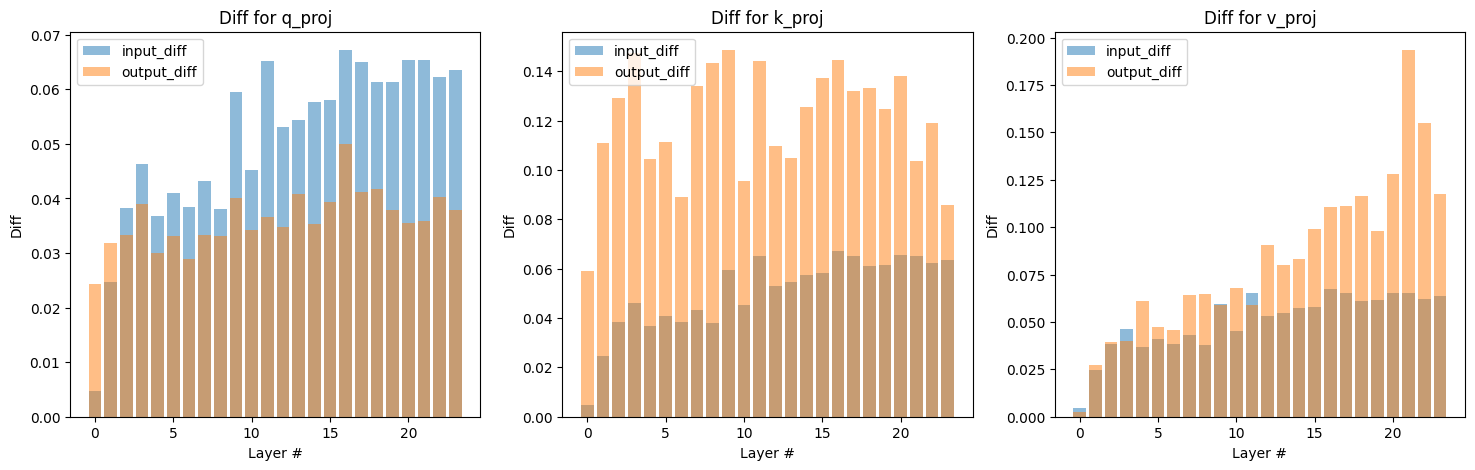

In [6]:
for pivot_at in range(4):
    easy_compare_forward_hook_data(
        hook_data_path_1 = hook_data_path_1_2, 
        hook_data_path_2 = hook_data_path_2_2,
        forward_hook_module_names = forward_hook_module_names[:],
        figure_names = ["q_proj", "k_proj", "v_proj"],
        pivot_at = pivot_at,
    )

这里要注意一个问题，在Qwen2.5-0.5B-Instruct中：
```python
(q_proj): Linear(in_features=896, out_features=896, bias=True)
(k_proj): Linear(in_features=896, out_features=128, bias=True)
(v_proj): Linear(in_features=896, out_features=128, bias=True)
```

一般对于$y=Ax,A\in\mathbb{R}^{n\times m}, x\in\mathbb{R}^m, y\in\mathbb{R}^n$

当对$x$加入一个随机扰动$\epsilon\in\mathbb{R}^{m}$时（$x'=x+\epsilon$），那么对应的$y'=Ax'=A(x+\epsilon)=y+A\epsilon$

我们只考虑一个位置：$y_1 = a_1^\top x, y_0'=a_1^\top x+a_1^\top \epsilon$

其中$y_1\in\mathbb{R},a_1\in\mathbb{R}^{m},\epsilon\in\mathbb{R}^{m},x\in\mathbb{R}^{m}$

图中计算的其实就是$\frac1n\sum_{i=1}^{n}[a_i^\top \epsilon]^2=\mathbb{E}_{i=1,...,n}[x^\top a_i a_i^\top x]$

假定：

- $\epsilon_i\overset{\rm iid}{\sim}\mathcal{N}(\mu_{\epsilon},{\sigma_\epsilon}^2),i=1,...,m$
- $a_{ij}$独立同分布服从于某个$(\mu, \sigma^2)$的分布，这个之前有做个一个直方图的数值分析，一般是正态或者均匀分布
- 那么$\mathbb{E}[a_i^\top \epsilon]=m\cdot\mu_{\epsilon}\mu$，一般来讲，$\mu$和$\mu_{\epsilon}$不太可能是0，因此输入维度$m$越大，对应的输出偏差也应该会越大


注意图中画的是每个位置的平均扰动情况，那么：

- $m$越大，整体上$y$每个位置的偏差也应该会越大（应该说是方差会更大，但是表现出来的应该也是偏差会更大一些，从概率上来说）

- 整体上来说$n$（即`output_features`）对$y$每个位置的平均偏差应该是没有影响的

- 因此这个性状可能说明 `q_proj` 本身可能是稀疏或是低秩的。（输入的波动比输出波动显著大得多）

另一个很重要的点：

- 第一个生成的token相对特殊，它的输入是prompt所有的token id，因此对应的 q k v 的输入维度都是 `(1, n_token, 896)`
  - 从第二个生成的token开始，形状都将变成`(1, 1, 896)`，因为我们用了kv cache，只需要传入最后一个token即可了。
  - 所以说，从第二个生成的token开始，diff本质上是边缘diff，是更新的diff，之前的diff依然是存在的。不过，我们是计算的平均，所以可能影响不大，量纲还是相同的
- 实际上对于每一个decode层而言，`q_proj` `k_proj` `v_proj` 的输入都是相同的（都是X，然后分别做投射，因为是自注意力）
- 这就意味着它们的输出会更加重要

## Case 2 - Qwen qkvo 0~23

测试了非常多相似的prompts，导出在`strawberry-X-1`下面，测试脚本如下：

模型Qwen2.5-0.5B-Instruct


```python
def decode_pipeline_test():
	logging.info("Decode unittest ...")
	model_id = 0
	model_name_or_path = os.path.join(model_home, model_names[model_id])
	logging.info(f"  - Model: {model_name_or_path}")
	prompts = \
		[f"""英文单词strawberry中有几个字母{i}？""" for i in string.ascii_letters] + \
		[f"""({i})英文单词strawberry中有几个字母{i}？""" for i in range(1, 10)] + \
		[f"""({i})英文单词strawberry中有几个字母{i}？""" for i in string.ascii_letters] + \
		[
			"""（ii）英文单词strawberry中有几个字母r？""",
			"""（iii）英文单词strawberry中有几个字母r？""",
			"""（iv）英文单词strawberry中有几个字母r？""",
			"""（vi）英文单词strawberry中有几个字母r？""",
			"""（vii）英文单词strawberry中有几个字母r？""",
			"""（viii）英文单词strawberry中有几个字母r？""",
			"""（ix）英文单词strawberry中有几个字母r？""",
		]
	max_length = 4
	use_kv_cache = True
	forward_hook_module_names = \
		[f"model.embed_tokens", "model.rotary_emb", "model.norm"] + \
		[f"model.layers[{i}].self_attn.q_proj" for i in range(24)] + \
		[f"model.layers[{i}].self_attn.k_proj" for i in range(24)] + \
		[f"model.layers[{i}].self_attn.v_proj" for i in range(24)] + \
		[f"model.layers[{i}].self_attn.o_proj" for i in range(24)]

	for i in range(len(prompts)): pass
```

注意RoPE会有两个输入：


- 从绝对位置编码到相对位置编码
    - 绝对位置编码，位置 pos_i 的编码仅取决于 pos_i 的值；
    - 相对位置编码，（一般不需要对每个位置进行单独的编码），而是直接对位置之间的相对距离进行编码
        - pos=0 与 pos=1 的相对位置 $f(|0-1|)$
        - pos=1 与 pos=3 的相对位置 $f(|1-3|)$
        - 偏差构成的矩阵，称为 id 矩阵；
- RoPE
    - 旋转位置编码，为相对位置编码，非加性位置编码，直接嵌入到 attention mechanism 的计算中；
    - $R^d_{\Theta,m}$：位置 $m$ 对应的旋转矩阵 not learnable：非学习的，全局固定的；
        - $m\theta$：frequency


$$
\begin{split}
f(q,m)^Tf(k,n)&=(R_mq)^T(R_nk)\\
&=q^T(R^T_mR_n)k\\
&=q^TR_{n-m}k
\end{split}
$$

freqs_cis 是一个全局的旋转矩阵：
```python
xq, xk, xv = self.wq(x), self.wk(x), self.wv(x)
xq, xk = apply_rotary_emb(xq, xk, freqs_cis=freqs_cis)
xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
xq, xk, xv
```

In [7]:
forward_hook_module_names = \
    [f"model.embed_tokens", "model.rotary_emb", "model.norm"] + \
    [f"model.layers[{i}].self_attn.q_proj" for i in range(24)] + \
    [f"model.layers[{i}].self_attn.k_proj" for i in range(24)] + \
    [f"model.layers[{i}].self_attn.v_proj" for i in range(24)] + \
    [f"model.layers[{i}].self_attn.o_proj" for i in range(24)]
hook_data_path_formatter = "./results/strawberry-X-1/fhook+Qwen2.5-0.5B-Instruct+True-{}.pt"
prompts = \
    [f"""英文单词strawberry中有几个字母{i}？""" for i in string.ascii_letters] + \
    [f"""({i})英文单词strawberry中有几个字母{i}？""" for i in range(1, 10)] + \
    [f"""({i})英文单词strawberry中有几个字母{i}？""" for i in string.ascii_letters] + \
    [
        """（ii）英文单词strawberry中有几个字母r？""",
        """（iii）英文单词strawberry中有几个字母r？""",
        """（iv）英文单词strawberry中有几个字母r？""",
        """（vi）英文单词strawberry中有几个字母r？""",
        """（vii）英文单词strawberry中有几个字母r？""",
        """（viii）英文单词strawberry中有几个字母r？""",
        """（ix）英文单词strawberry中有几个字母r？""",
    ]
for i, prompt in enumerate(prompts):
    print(i, prompt)

0 英文单词strawberry中有几个字母a？
1 英文单词strawberry中有几个字母b？
2 英文单词strawberry中有几个字母c？
3 英文单词strawberry中有几个字母d？
4 英文单词strawberry中有几个字母e？
5 英文单词strawberry中有几个字母f？
6 英文单词strawberry中有几个字母g？
7 英文单词strawberry中有几个字母h？
8 英文单词strawberry中有几个字母i？
9 英文单词strawberry中有几个字母j？
10 英文单词strawberry中有几个字母k？
11 英文单词strawberry中有几个字母l？
12 英文单词strawberry中有几个字母m？
13 英文单词strawberry中有几个字母n？
14 英文单词strawberry中有几个字母o？
15 英文单词strawberry中有几个字母p？
16 英文单词strawberry中有几个字母q？
17 英文单词strawberry中有几个字母r？
18 英文单词strawberry中有几个字母s？
19 英文单词strawberry中有几个字母t？
20 英文单词strawberry中有几个字母u？
21 英文单词strawberry中有几个字母v？
22 英文单词strawberry中有几个字母w？
23 英文单词strawberry中有几个字母x？
24 英文单词strawberry中有几个字母y？
25 英文单词strawberry中有几个字母z？
26 英文单词strawberry中有几个字母A？
27 英文单词strawberry中有几个字母B？
28 英文单词strawberry中有几个字母C？
29 英文单词strawberry中有几个字母D？
30 英文单词strawberry中有几个字母E？
31 英文单词strawberry中有几个字母F？
32 英文单词strawberry中有几个字母G？
33 英文单词strawberry中有几个字母H？
34 英文单词strawberry中有几个字母I？
35 英文单词strawberry中有几个字母J？
36 英文单词strawberry中有几个字母K？
37 英文单词strawberry中有几个字母L？
38 英文单词strawberry中有几个字

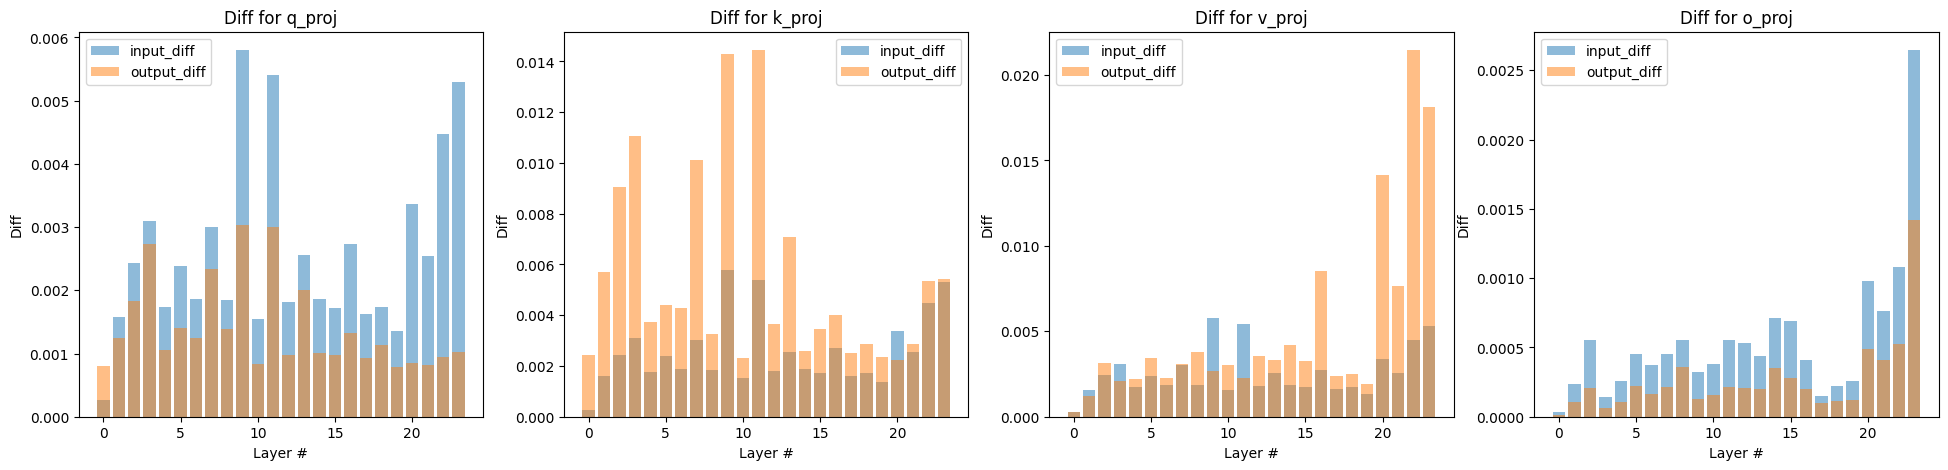

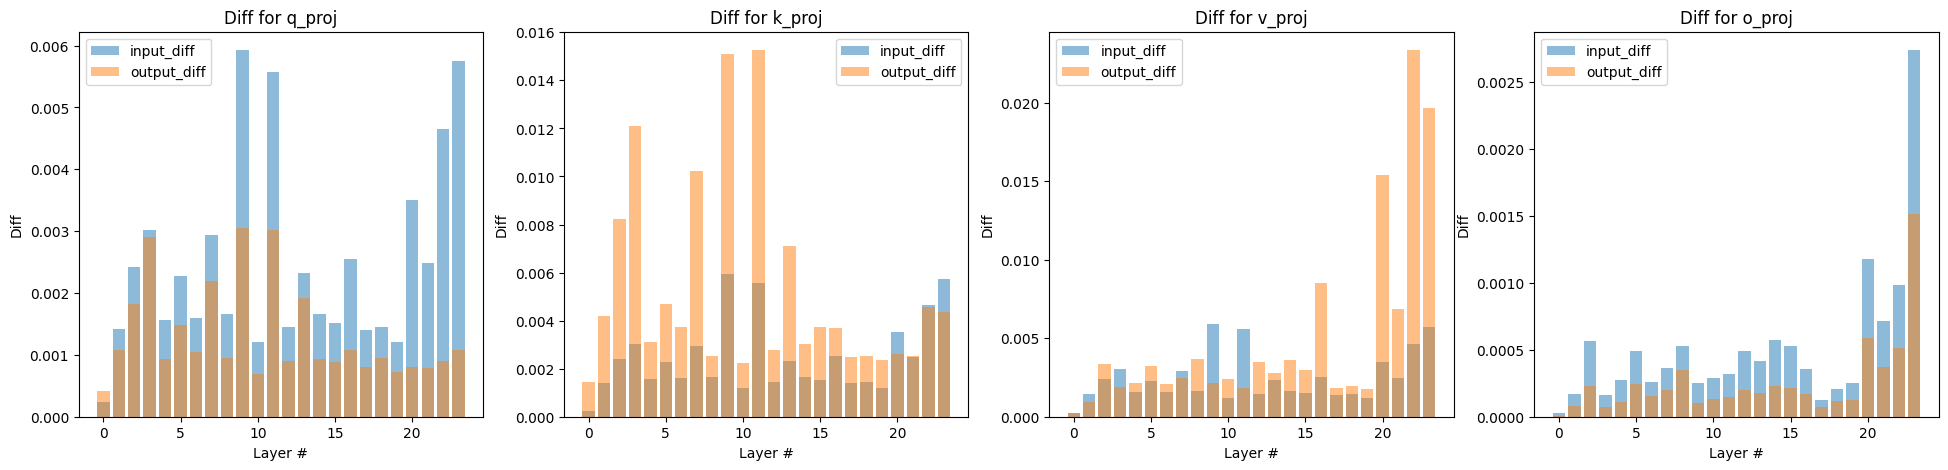

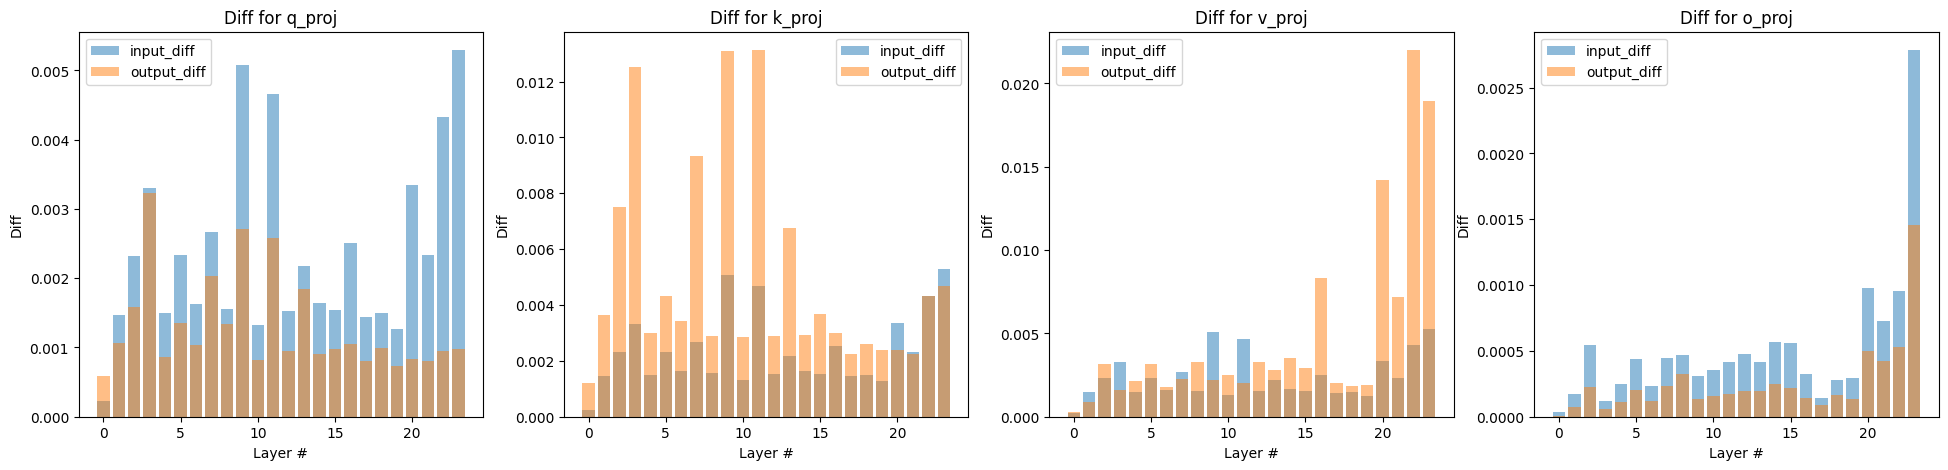

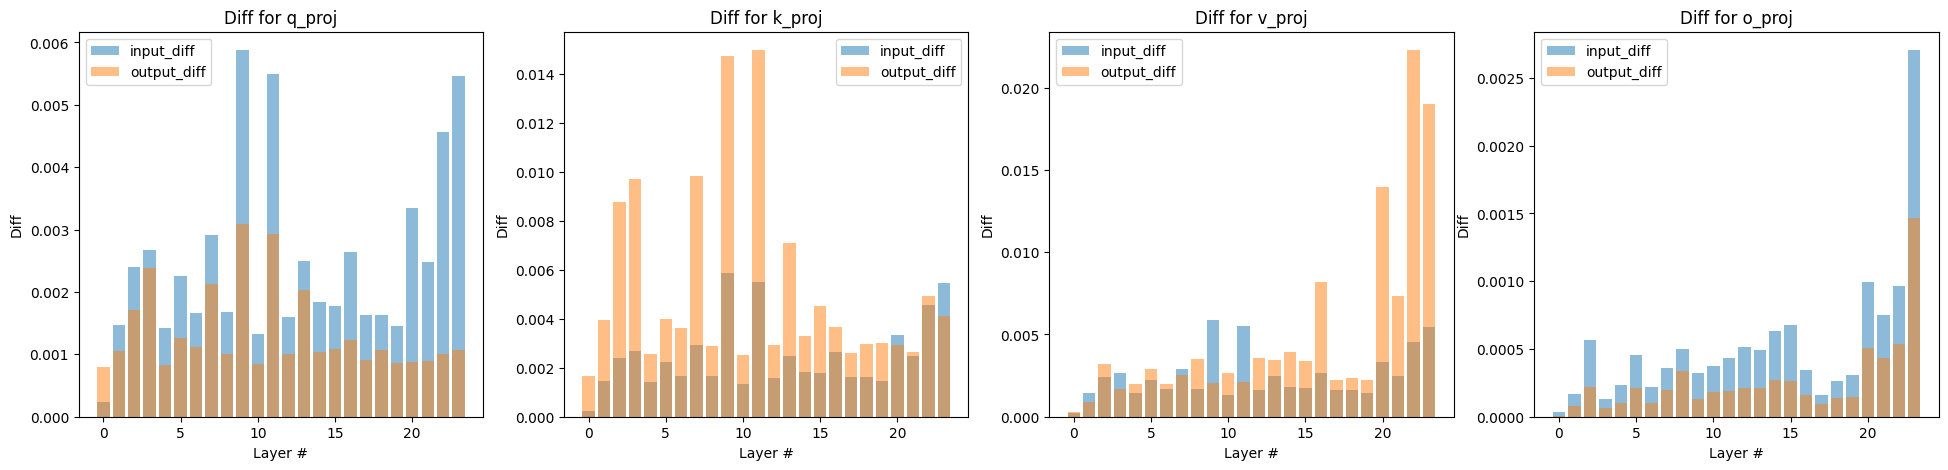

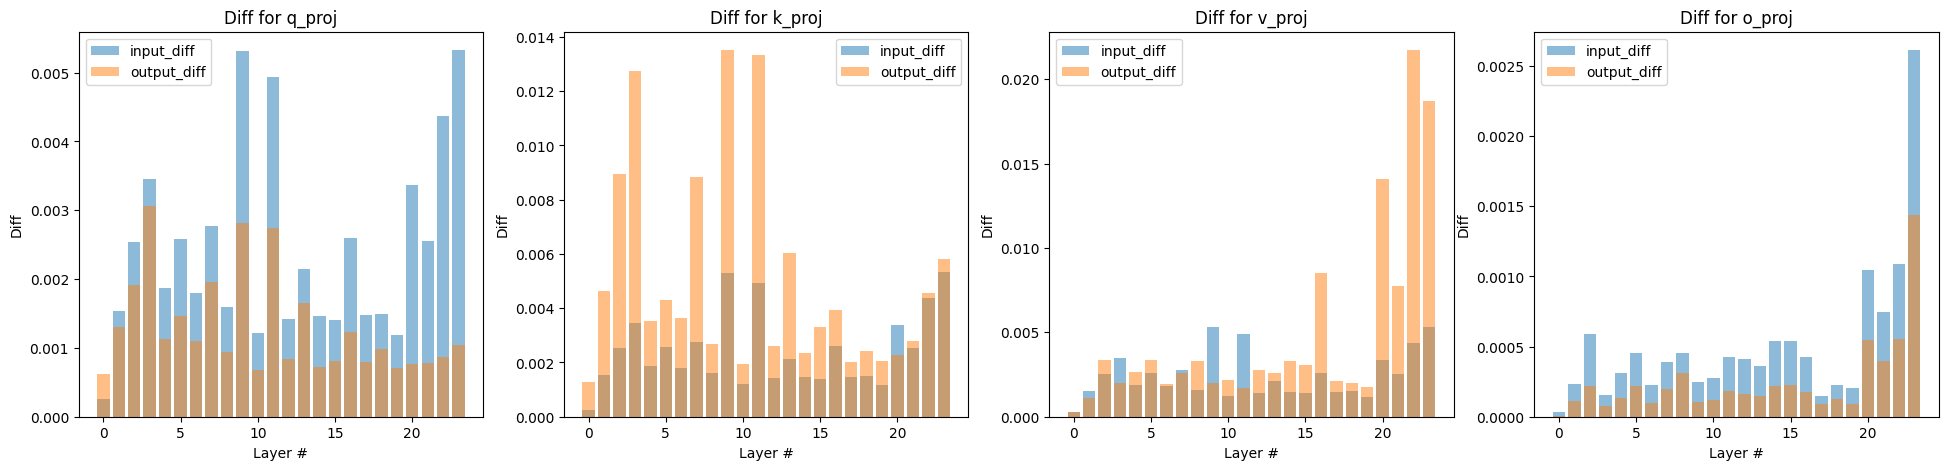

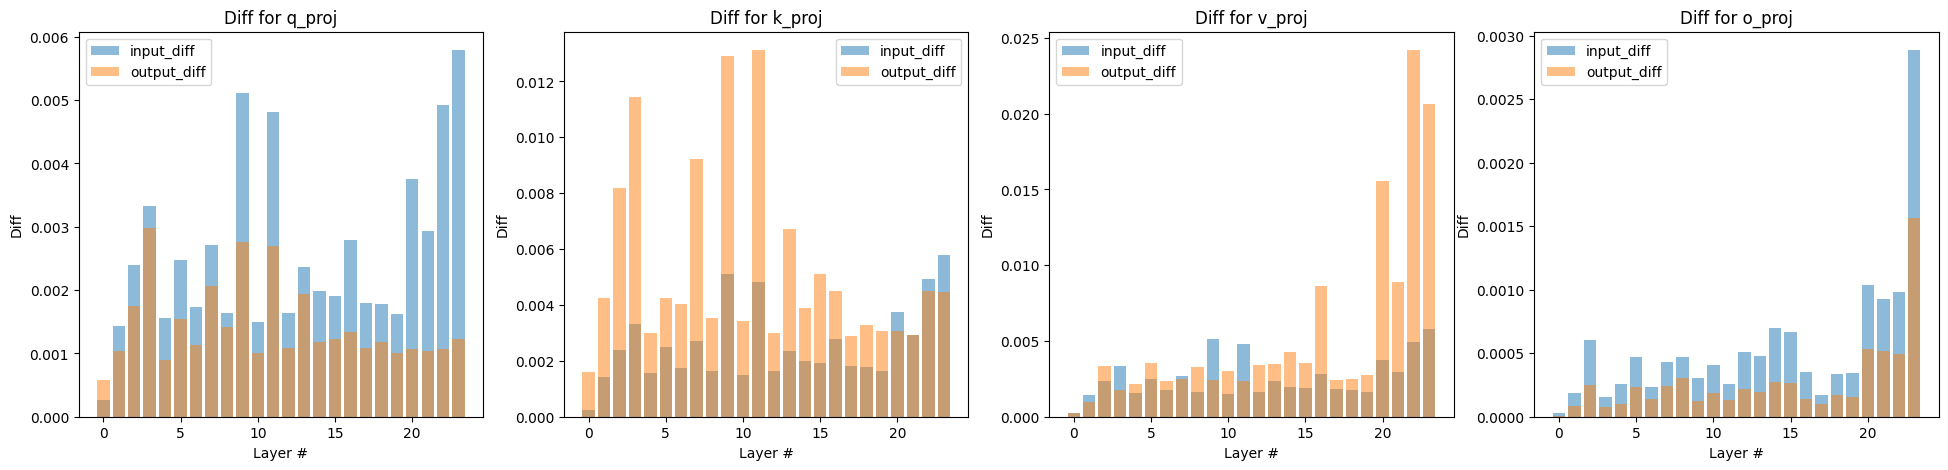

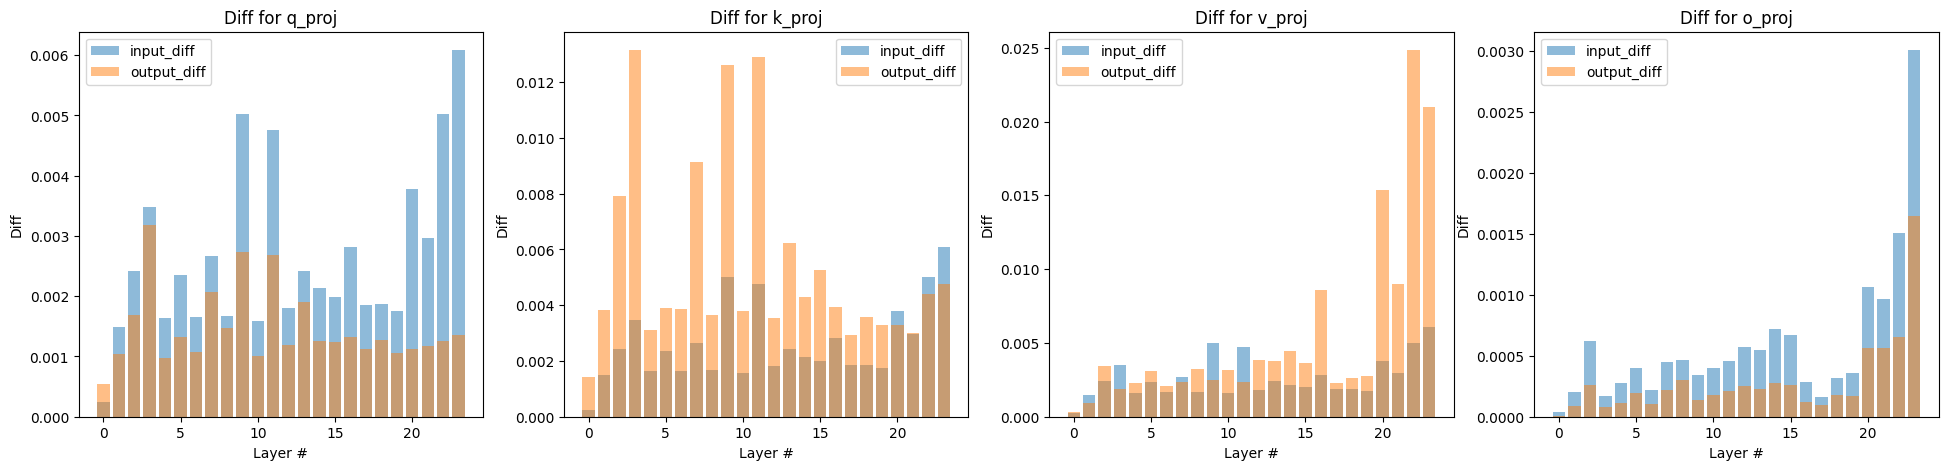

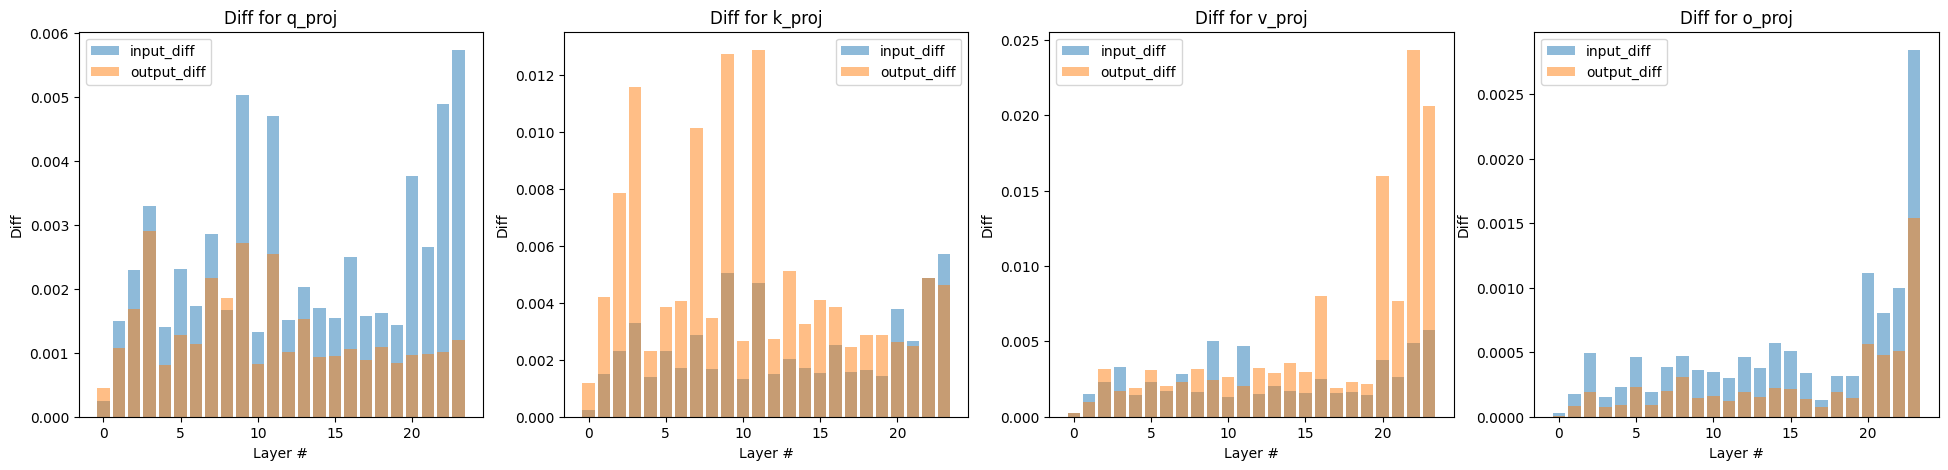

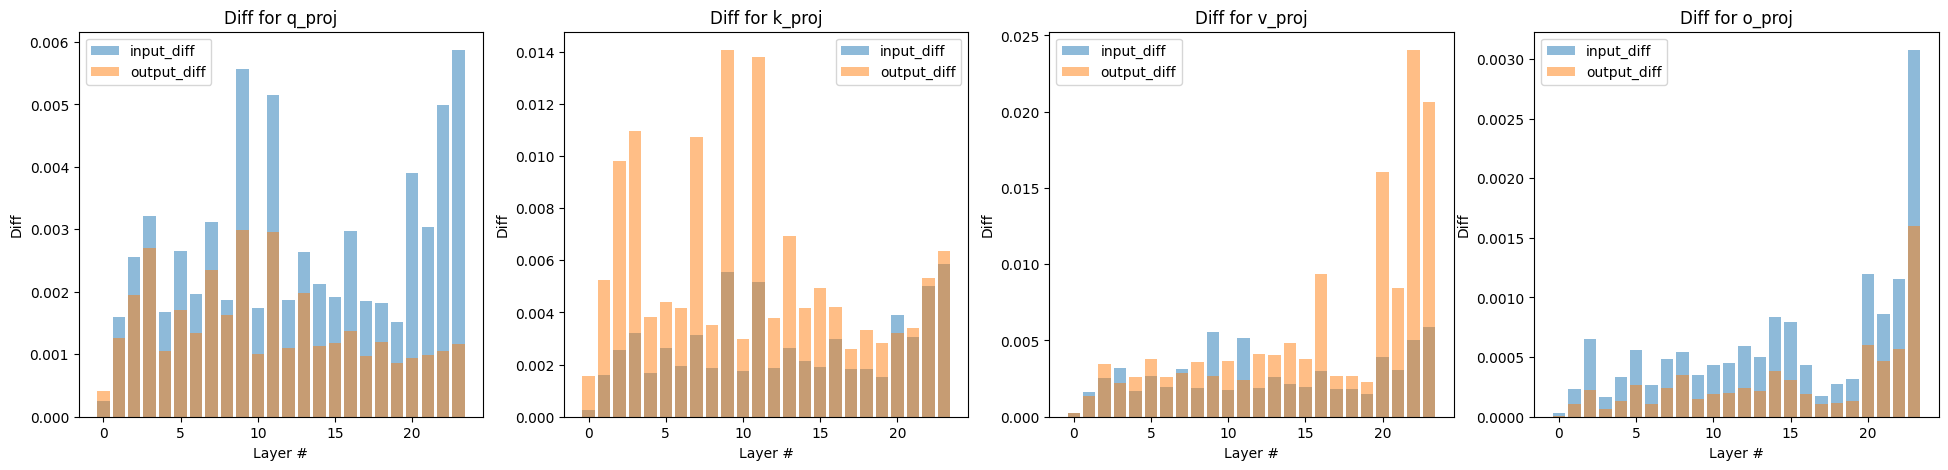

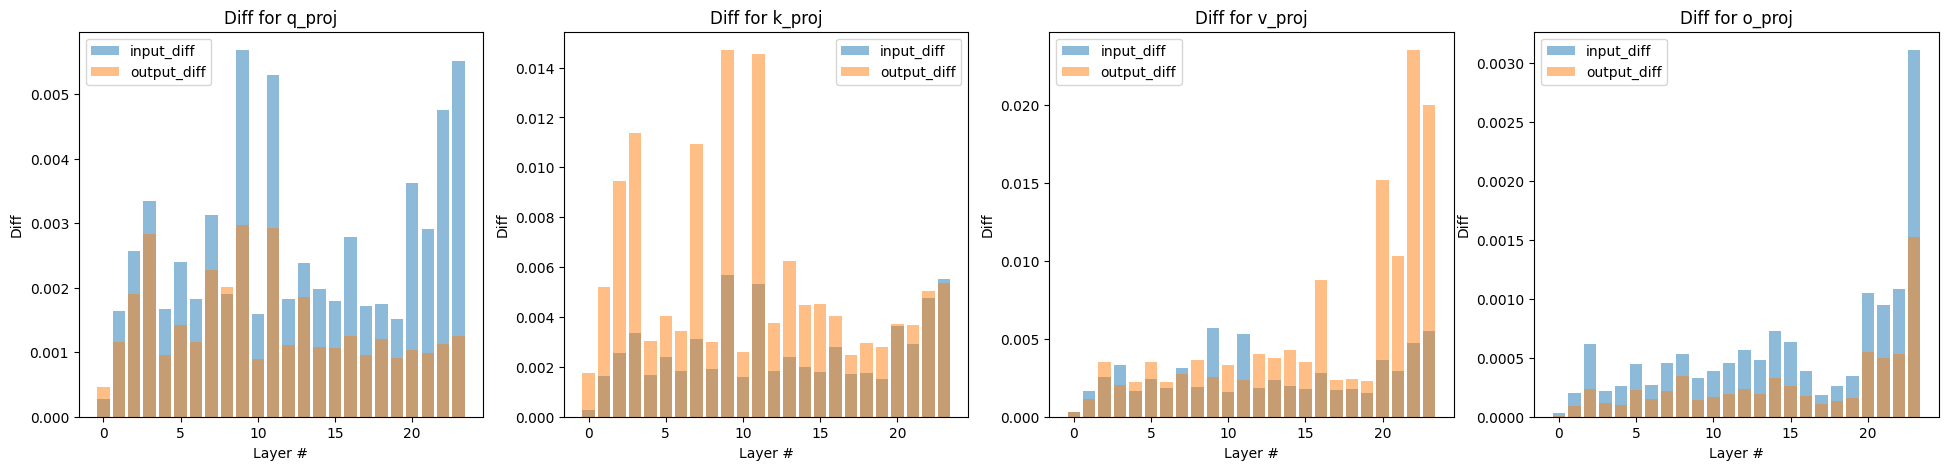

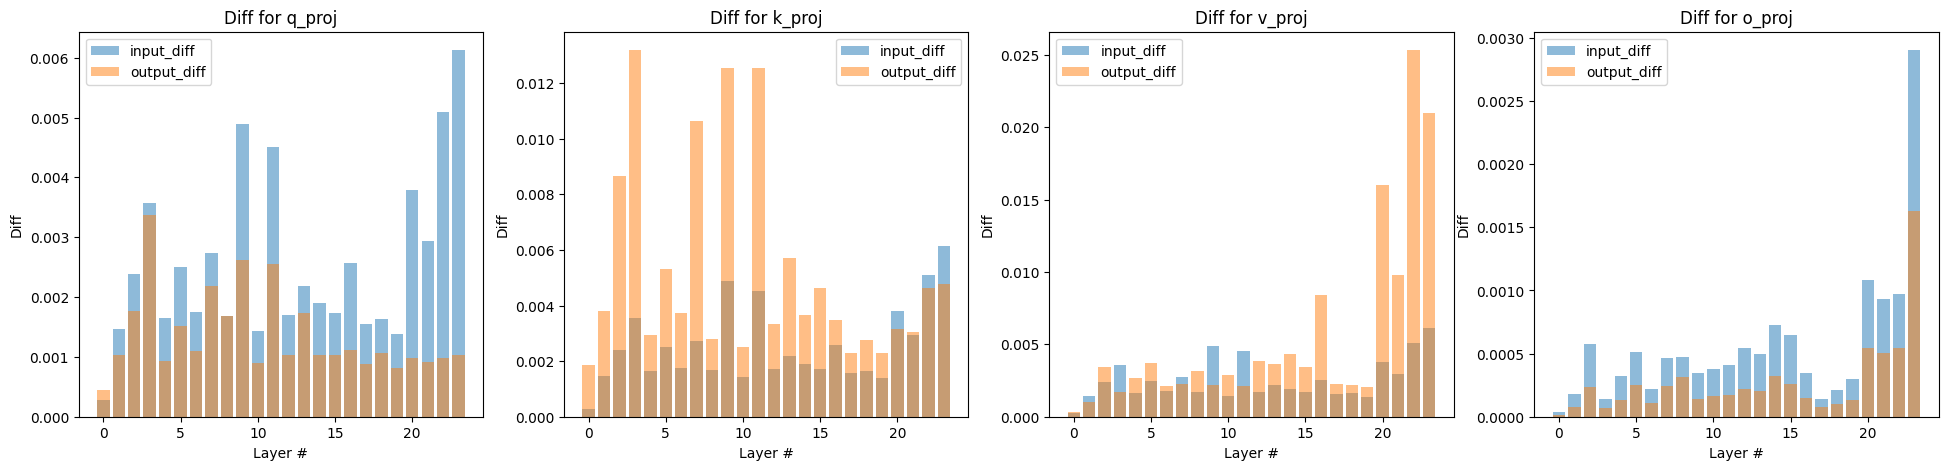

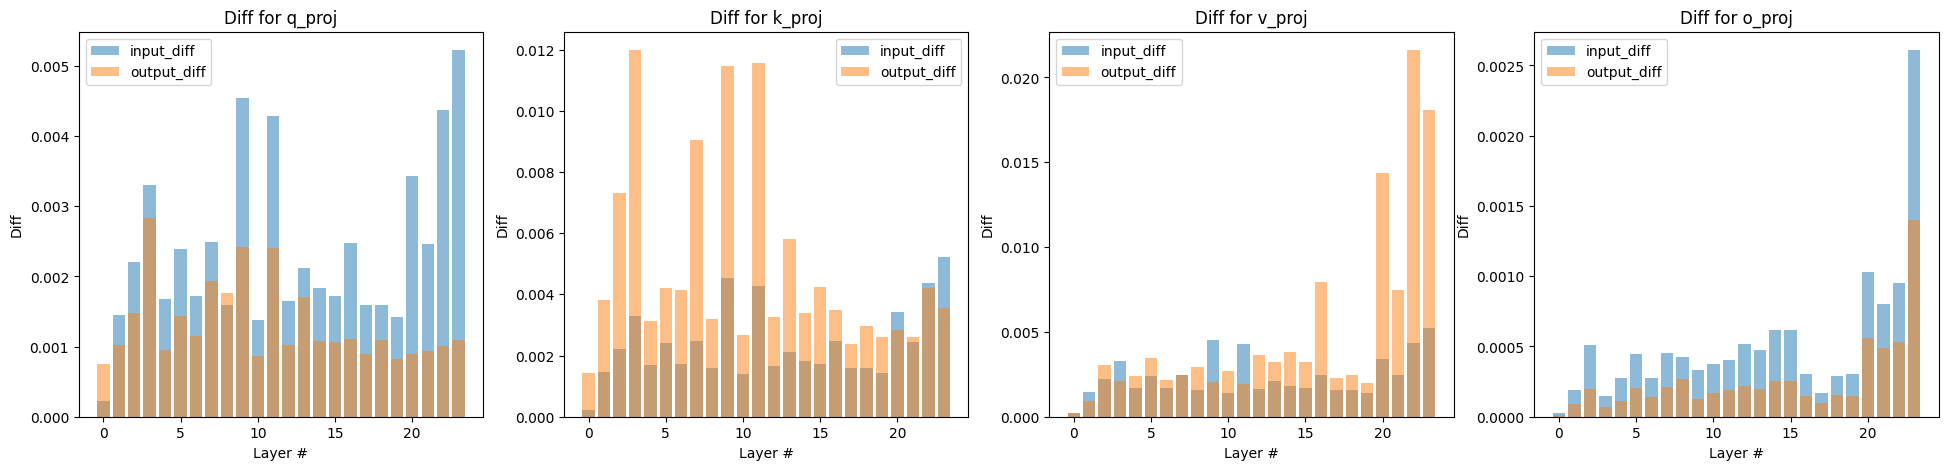

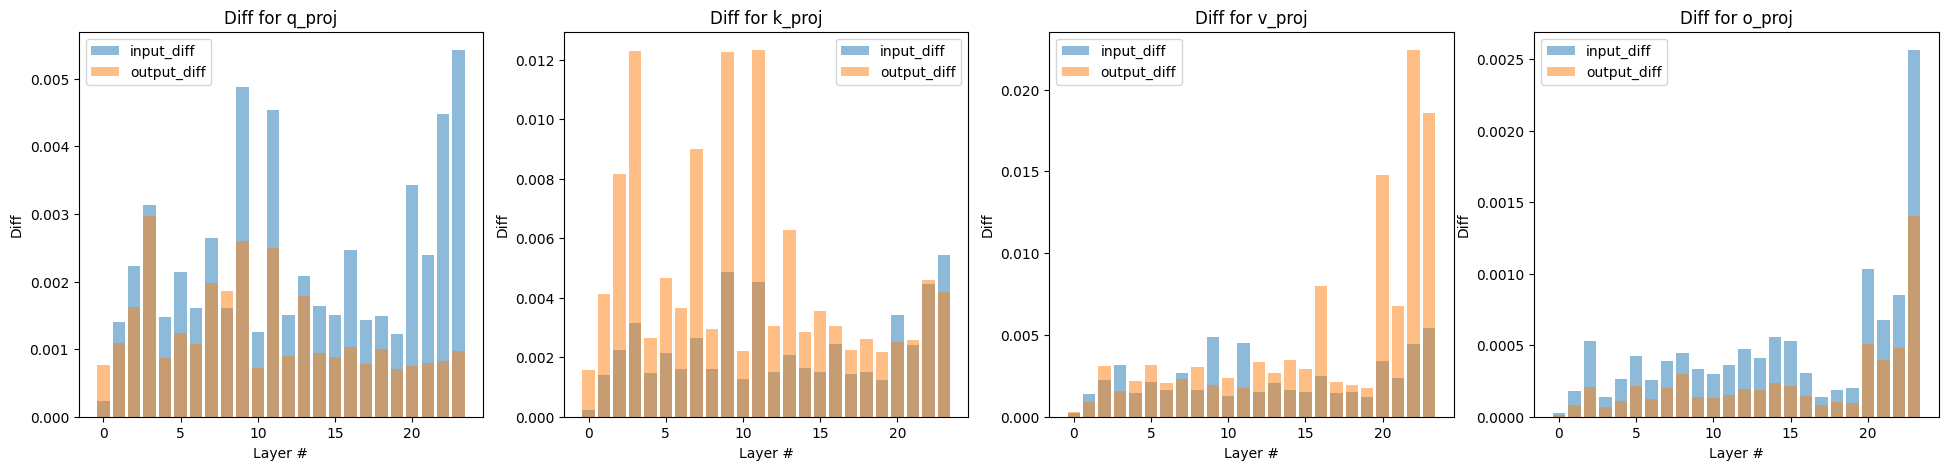

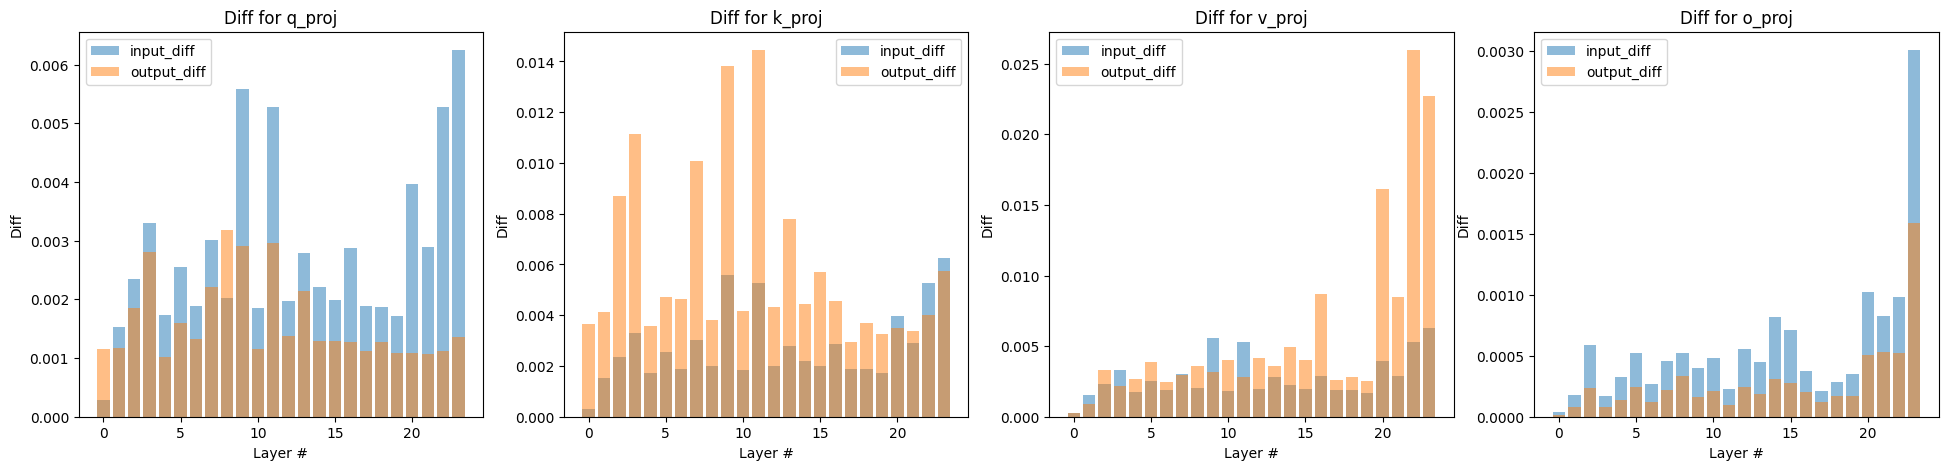

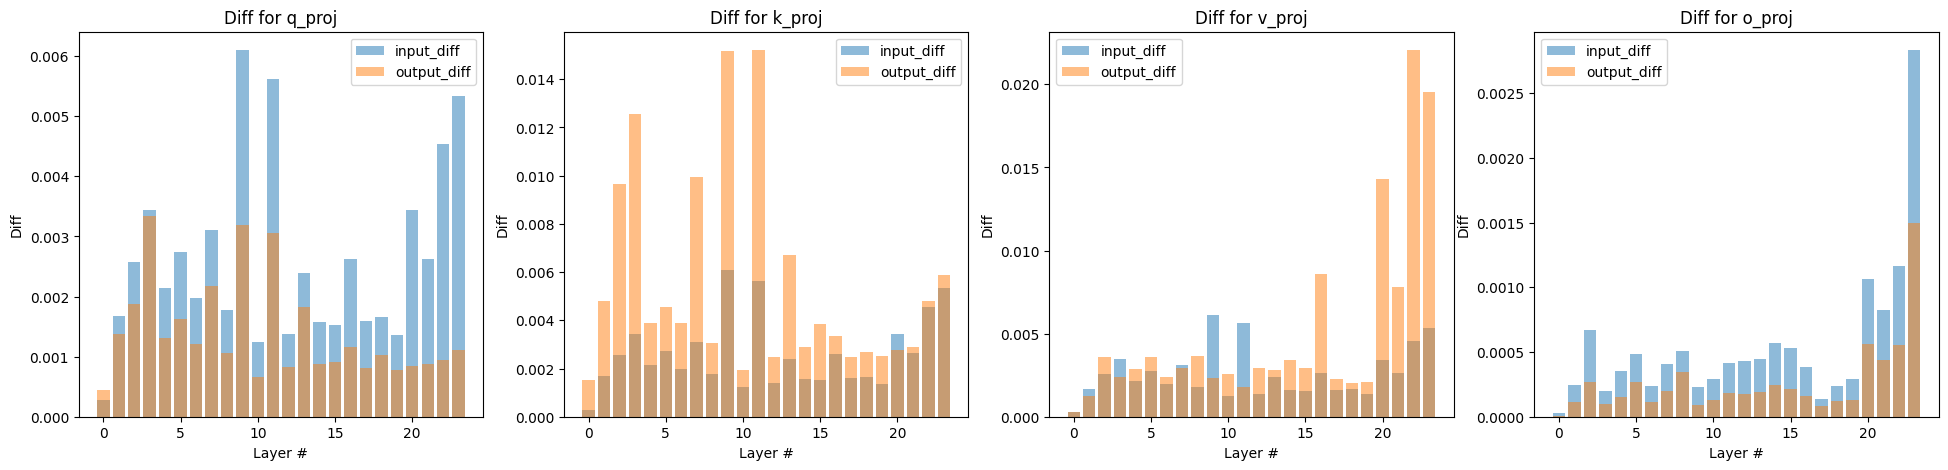

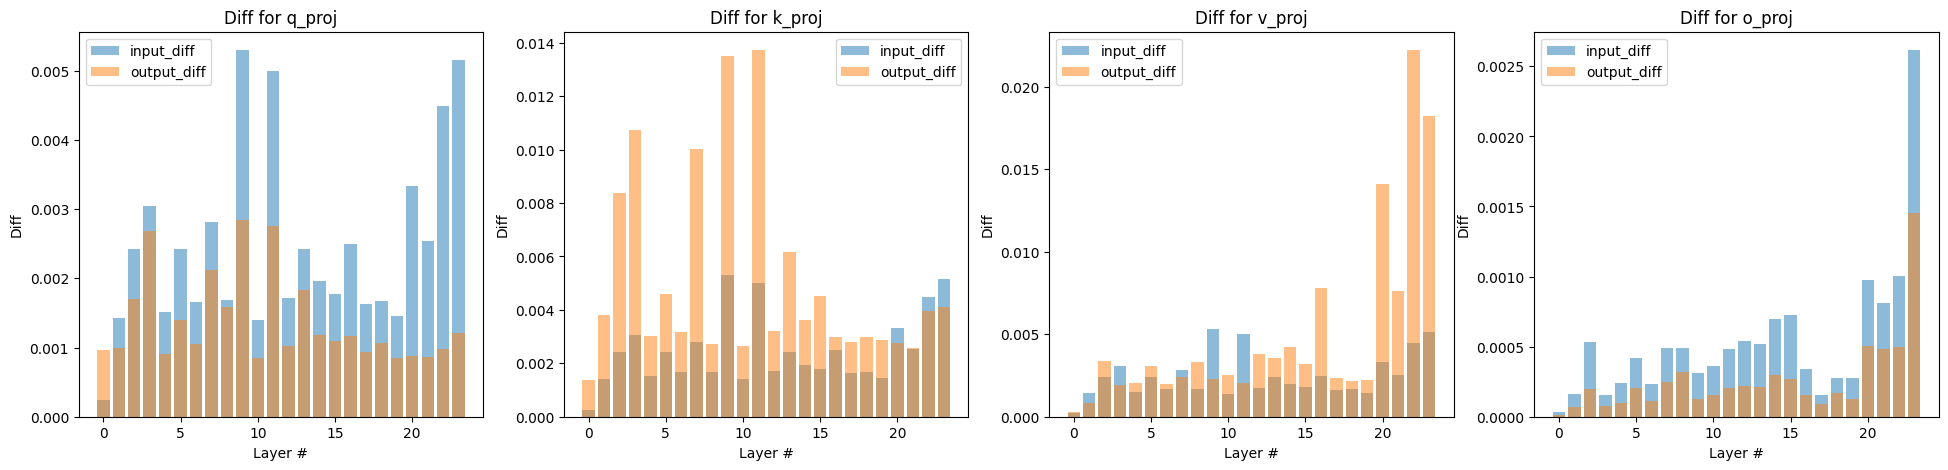

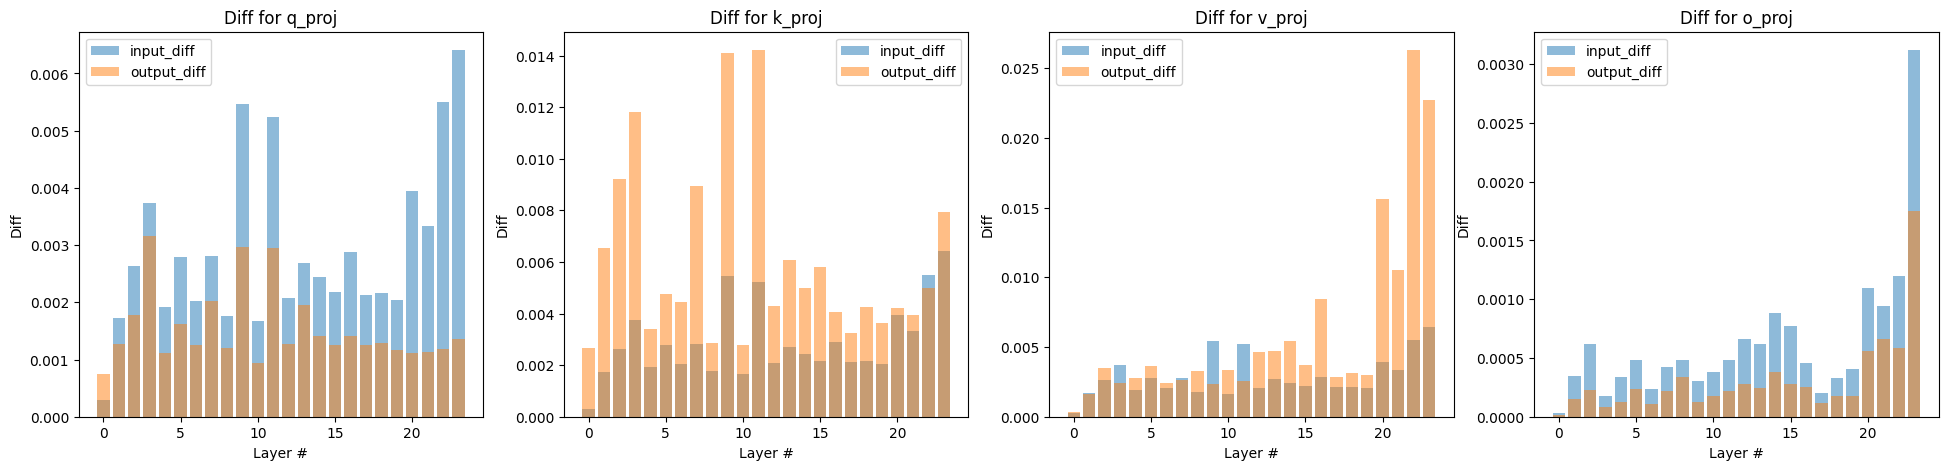

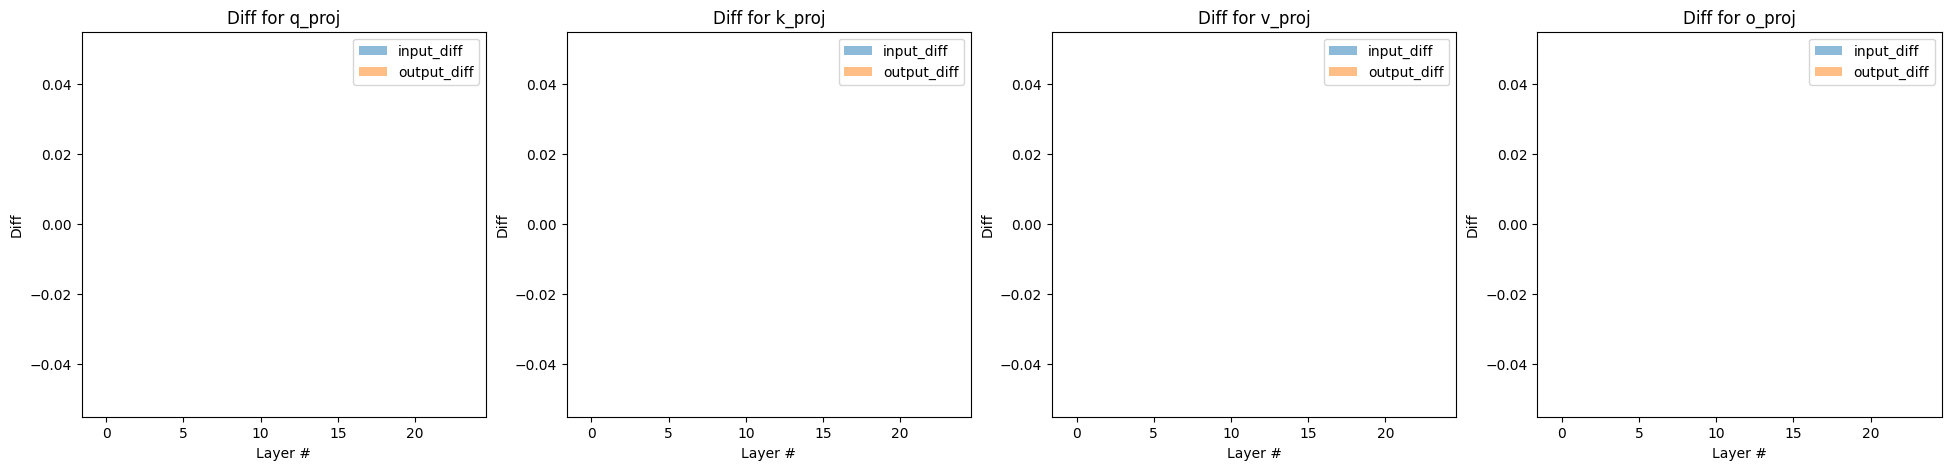

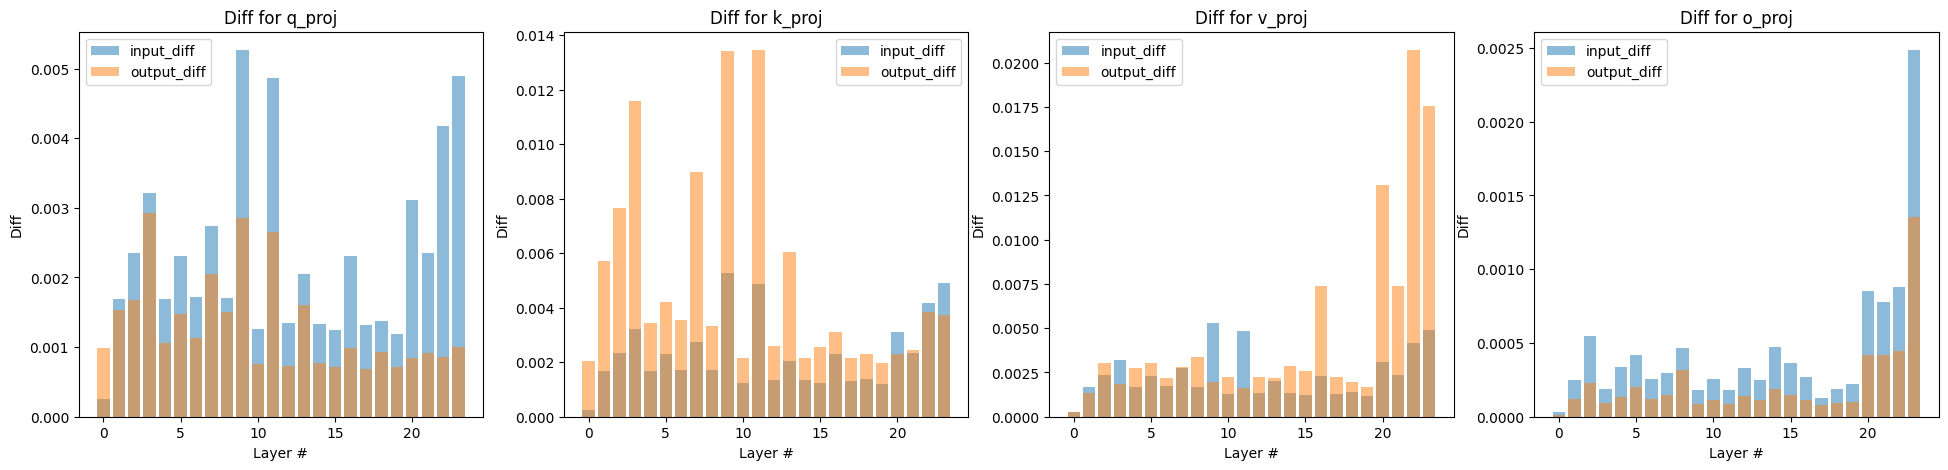

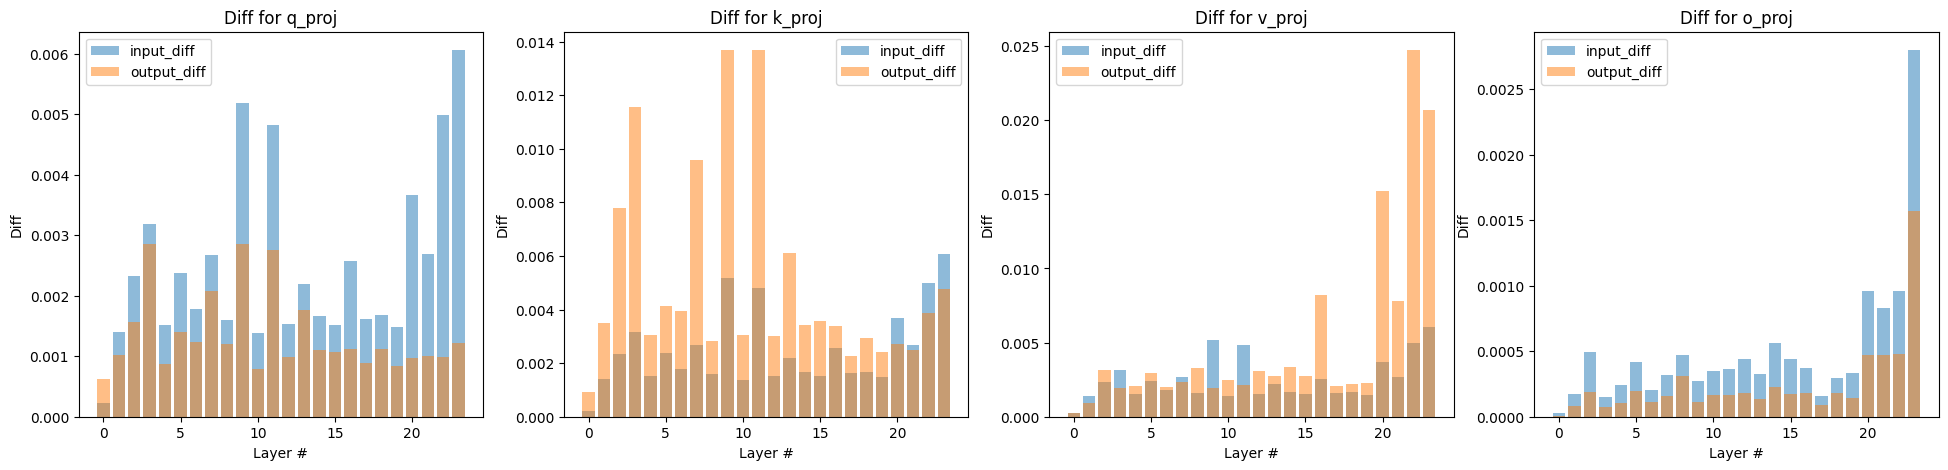

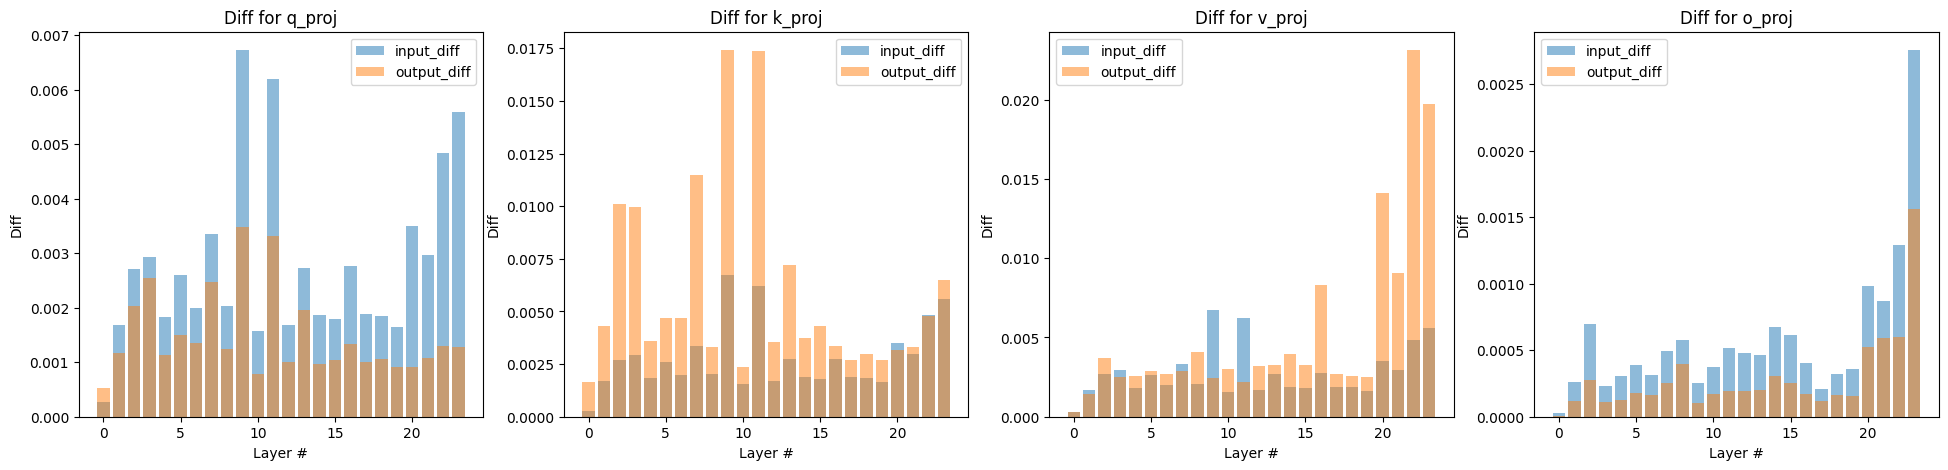

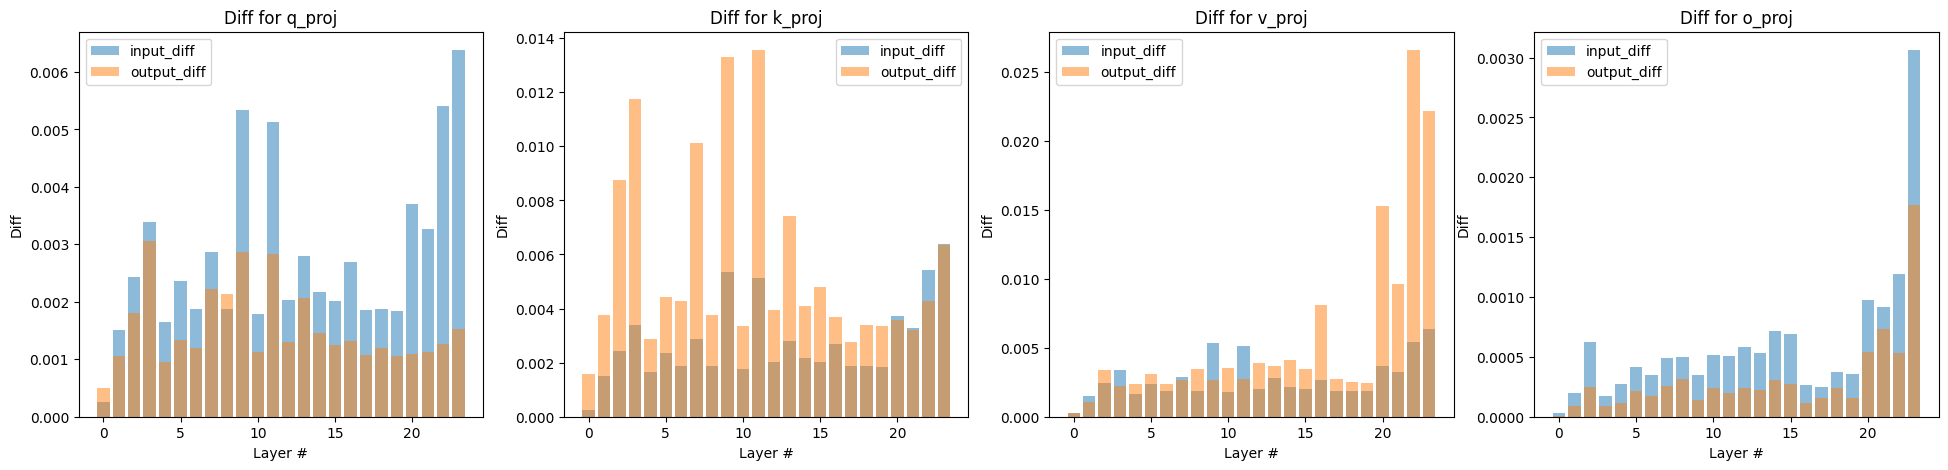

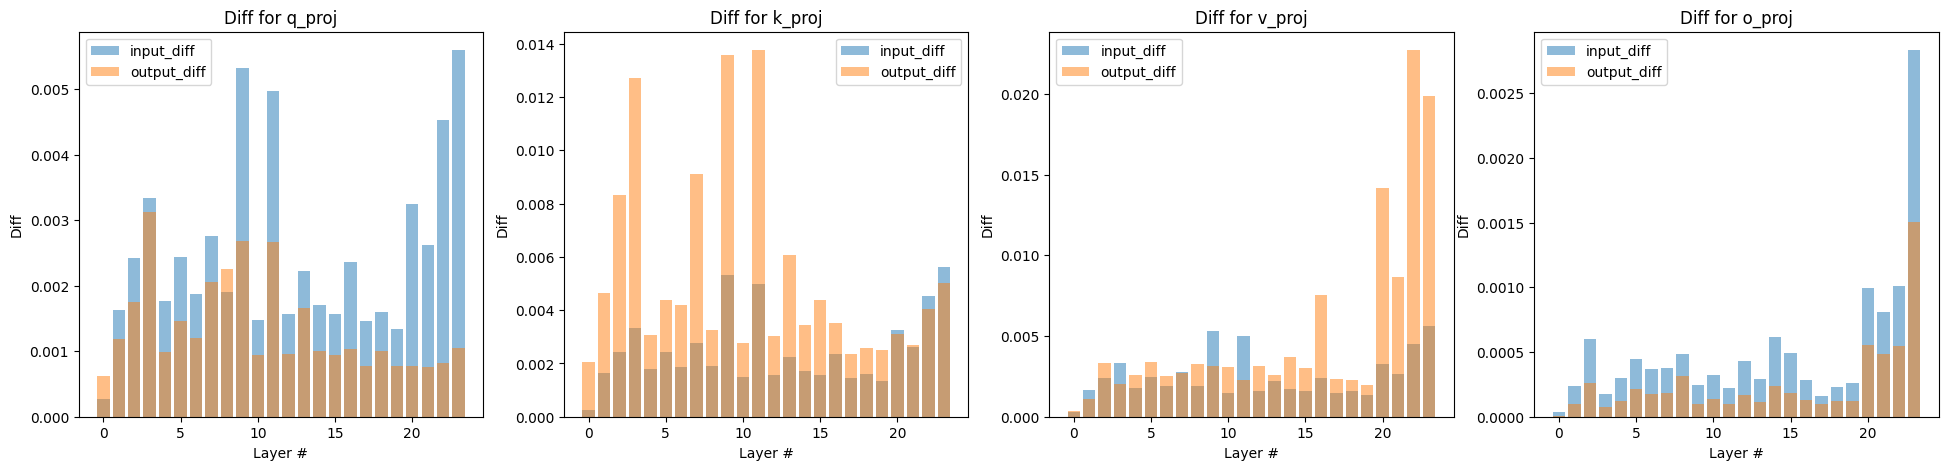

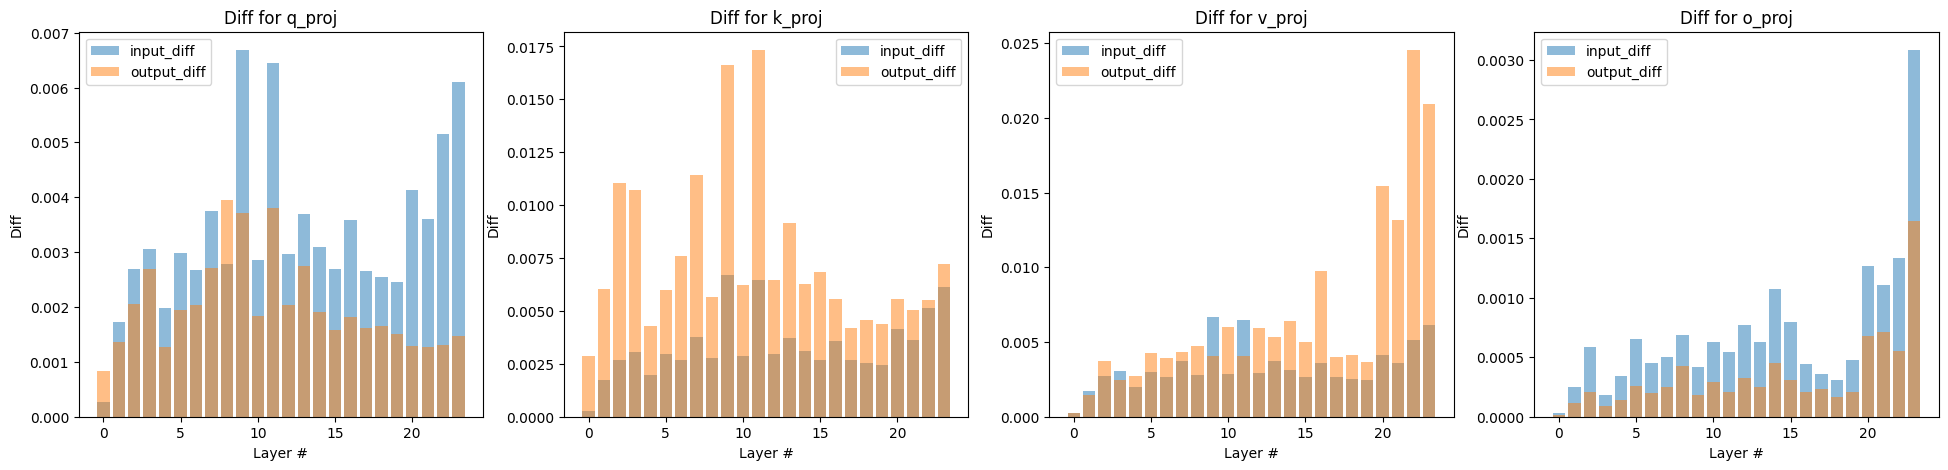

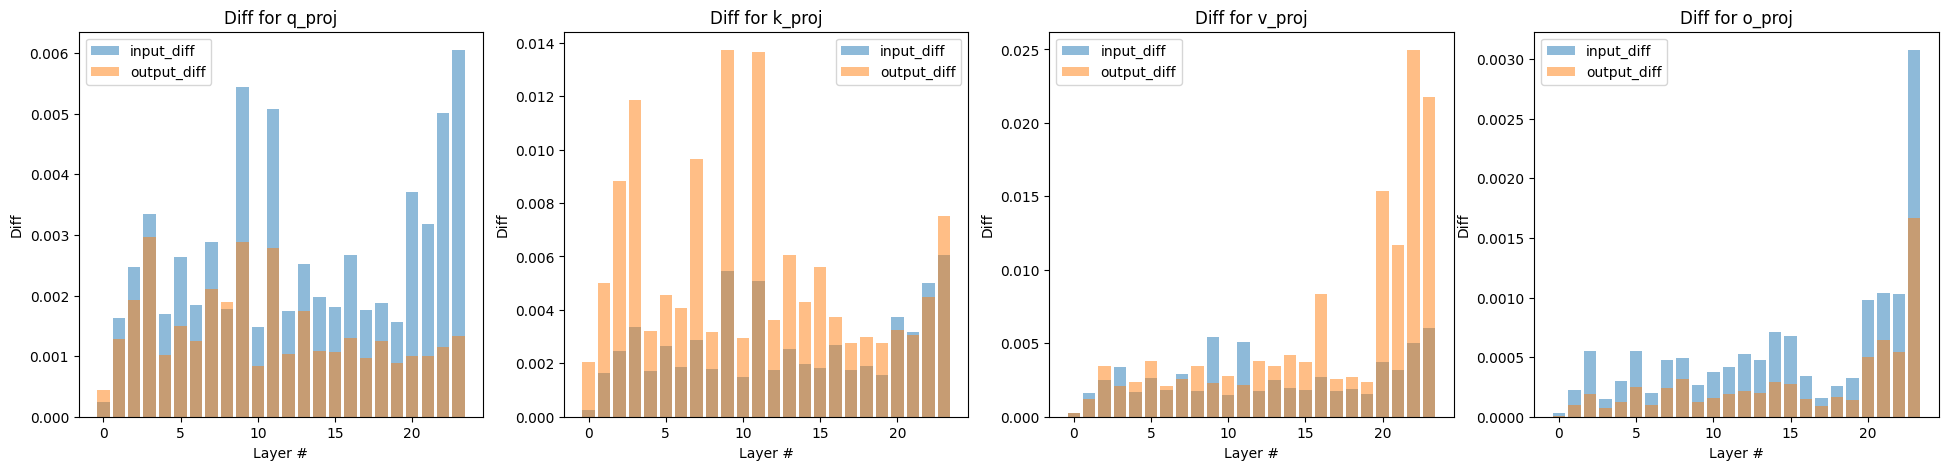

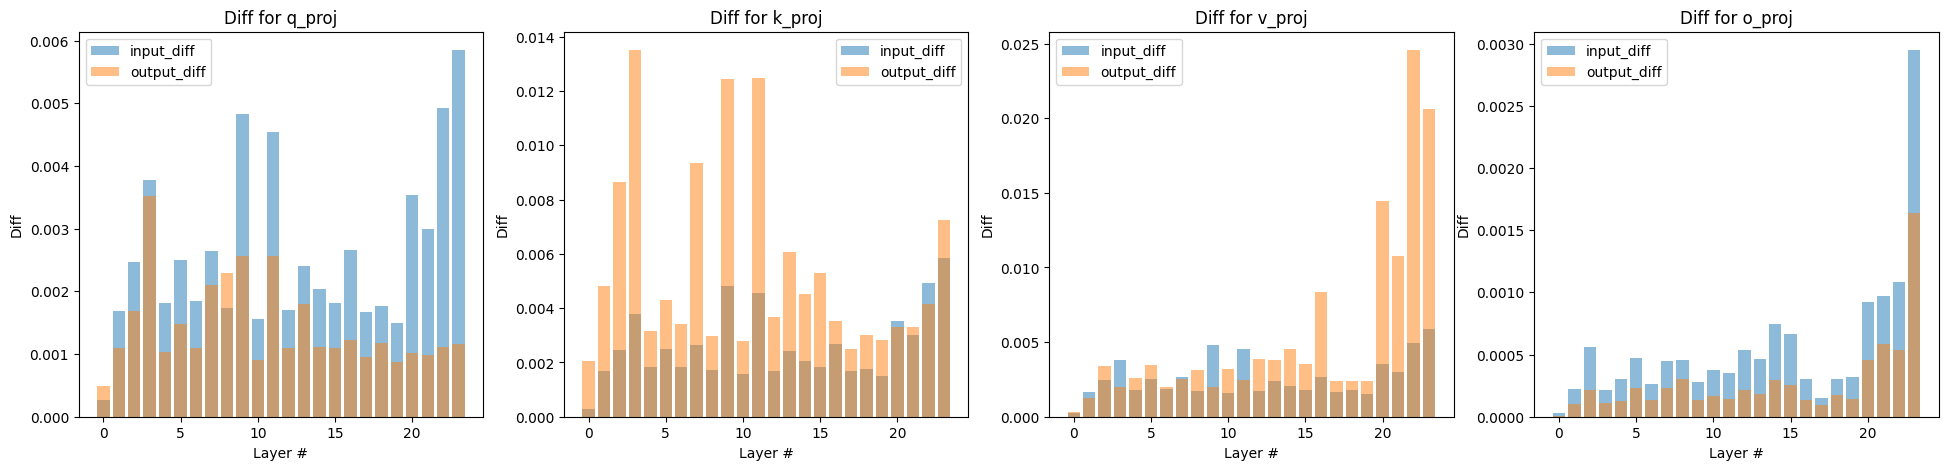

In [8]:
# 对比“英文单词strawberry中有几个字母r”与“英文单词strawberry中有几个字母{x}”
for i in range(26):
    easy_compare_forward_hook_data(
        hook_data_path_1 = hook_data_path_formatter.format(17), 
        hook_data_path_2 = hook_data_path_formatter.format(i),
        forward_hook_module_names = forward_hook_module_names[:],
        figure_names = ["q_proj", "k_proj", "v_proj", "o_proj"],
    )
    # if input(prompts[i]): break

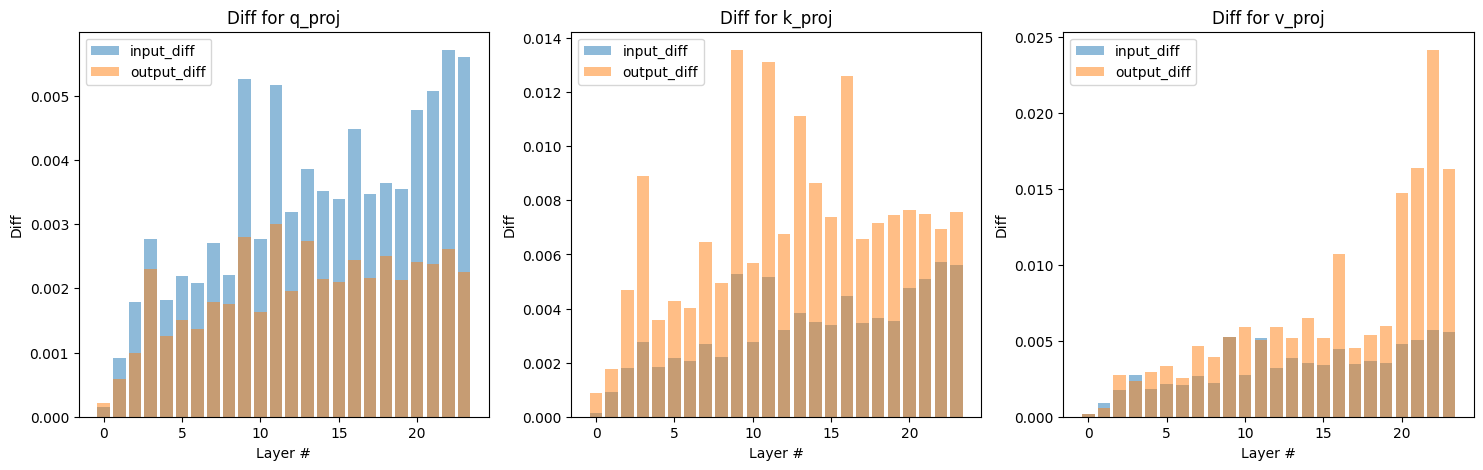

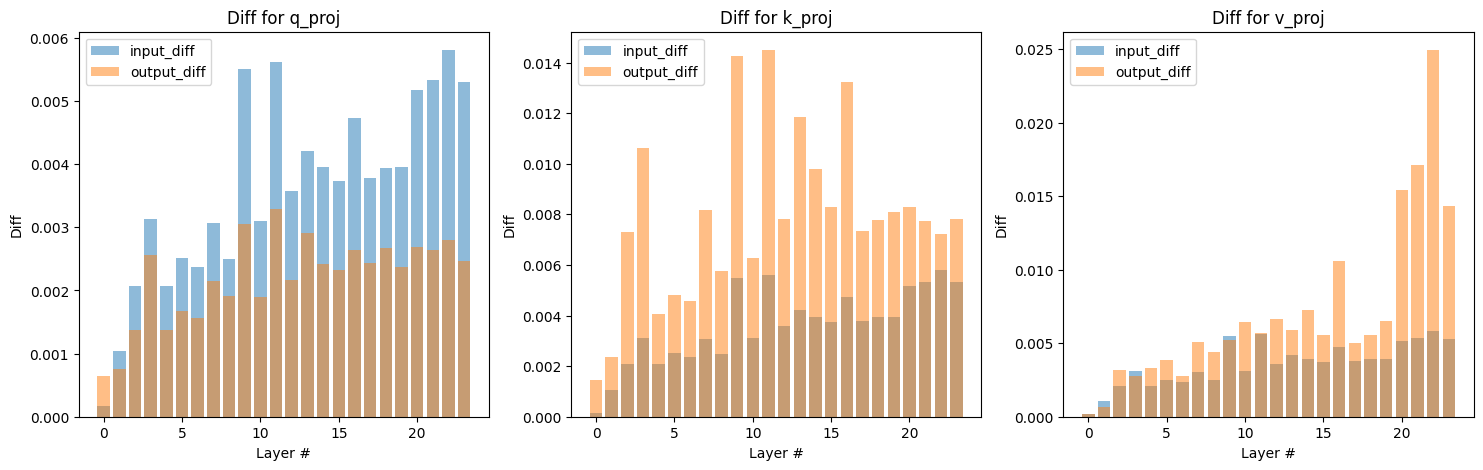

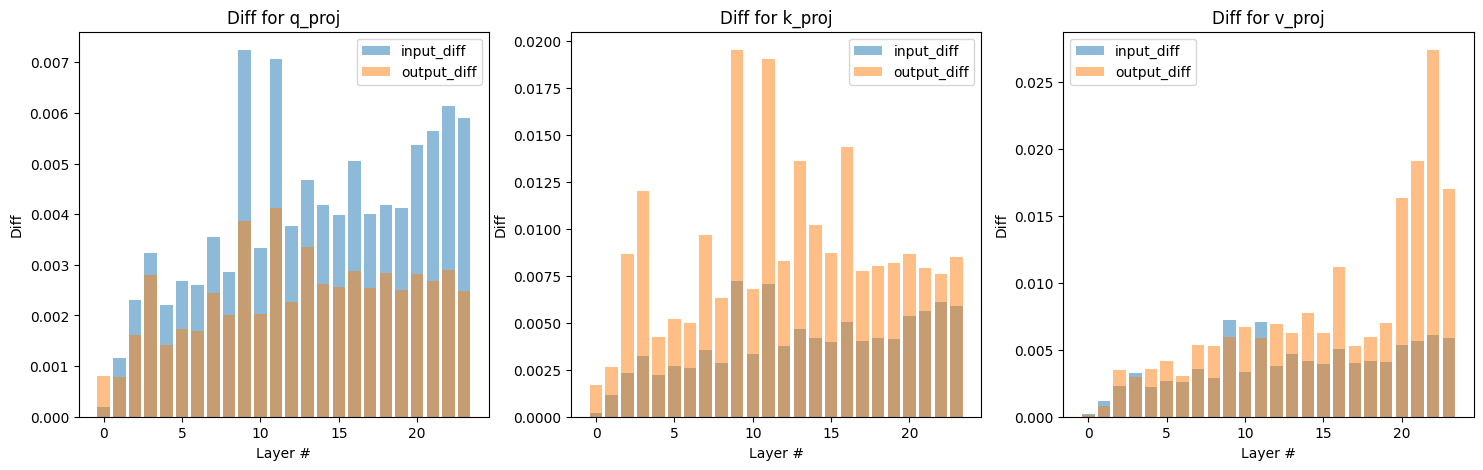

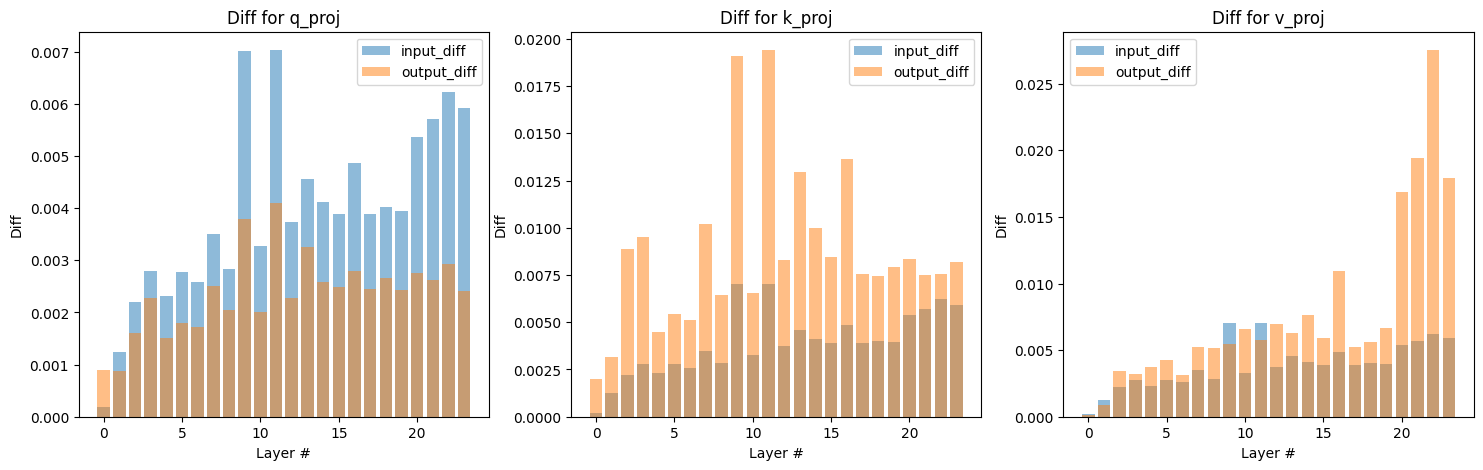

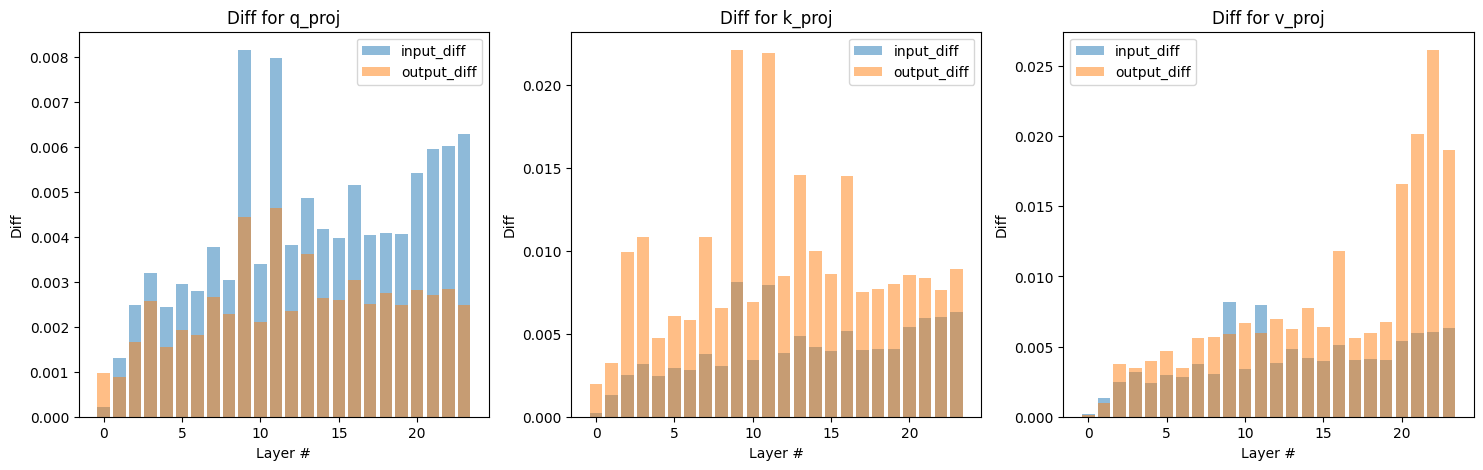

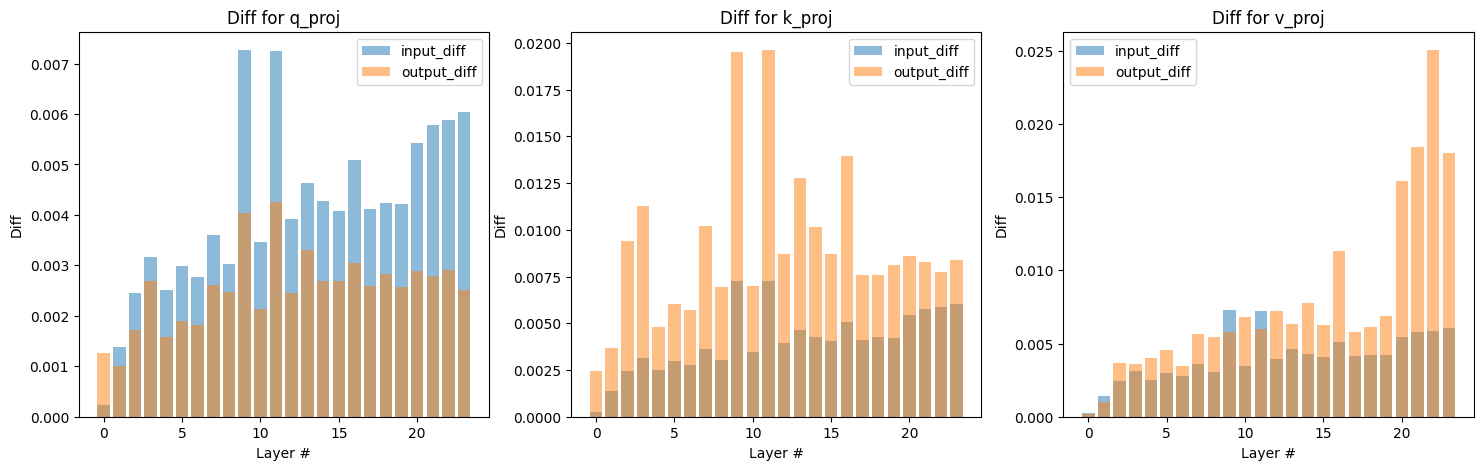

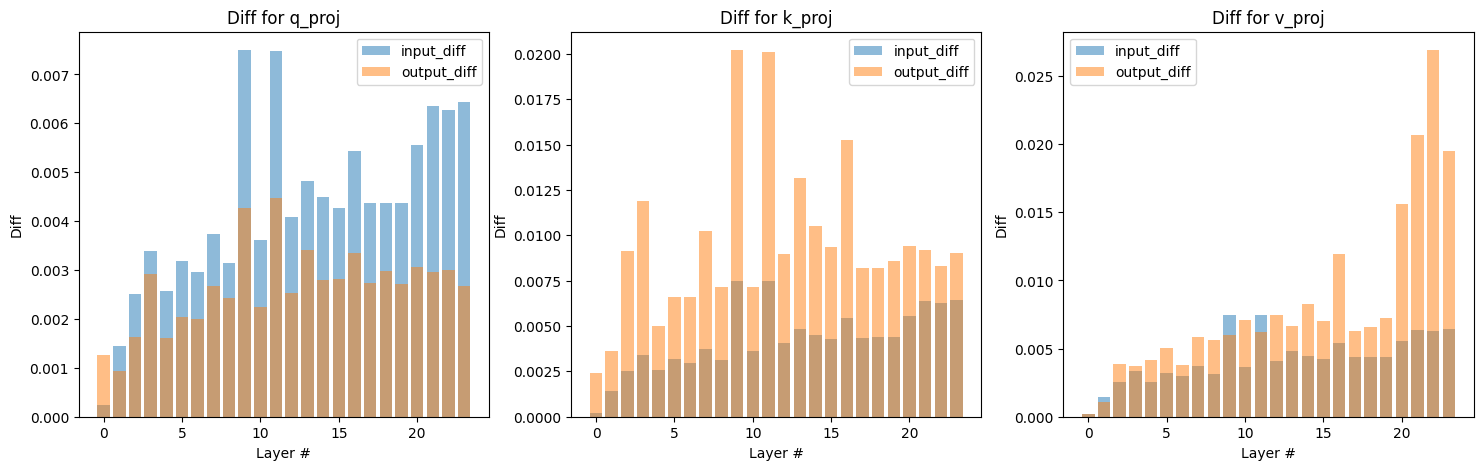

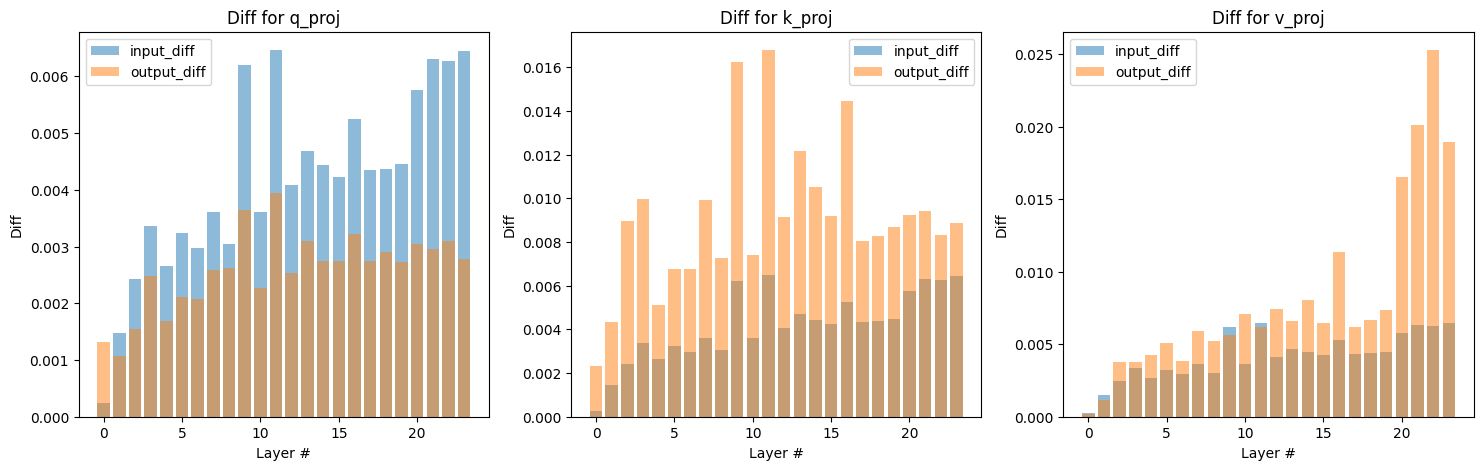

In [9]:
# 对比“(1)英文单词strawberry中有几个字母r”与“({})英文单词strawberry中有几个字母{x}”
for i in range(53, 61):
    easy_compare_forward_hook_data(
        hook_data_path_1 = hook_data_path_formatter.format(52), 
        hook_data_path_2 = hook_data_path_formatter.format(i),
        forward_hook_module_names = forward_hook_module_names[:],
        figure_names = ["q_proj", "k_proj", "v_proj"],
    )
    # if input(prompts[i]): break

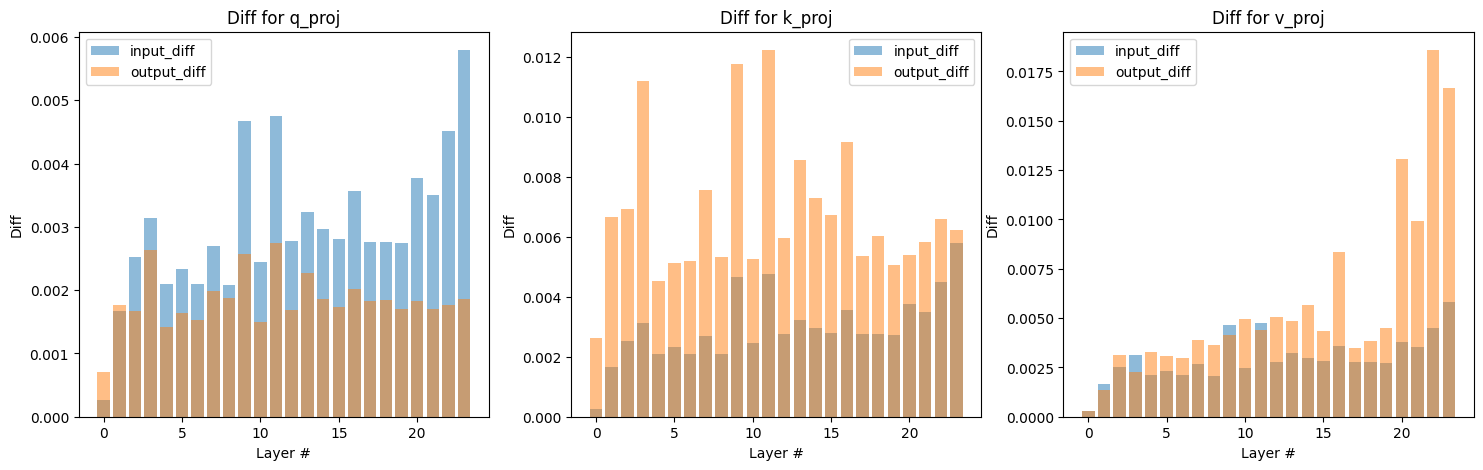

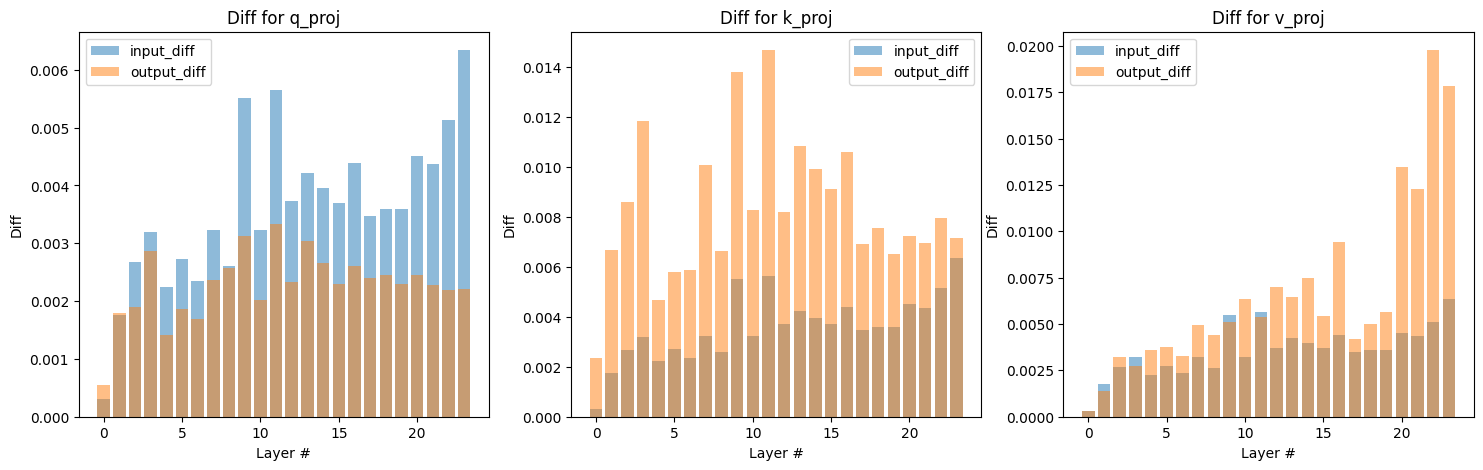

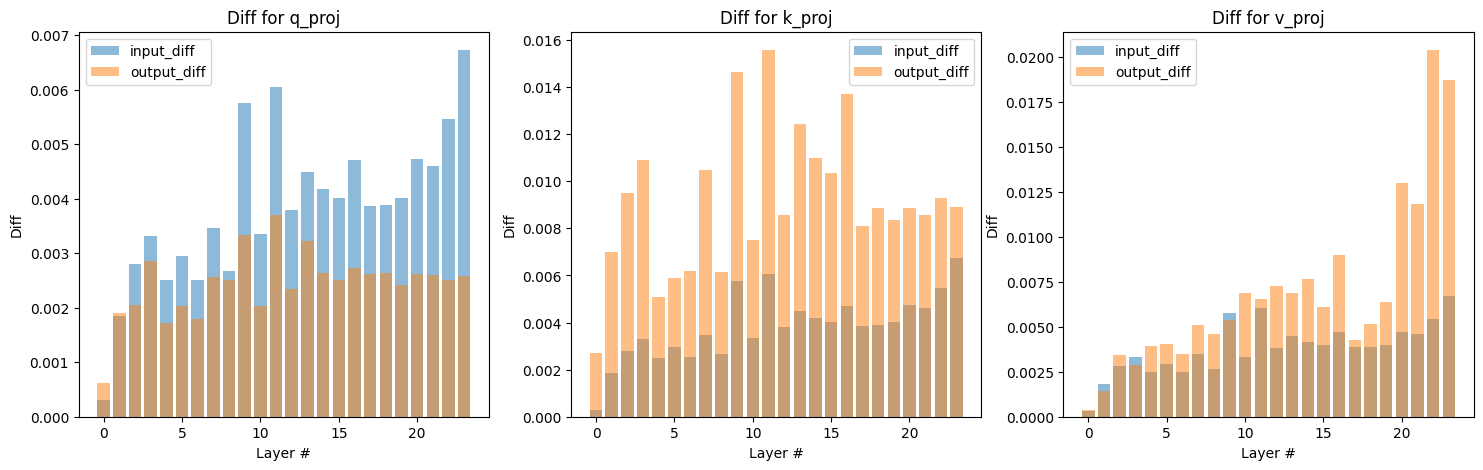

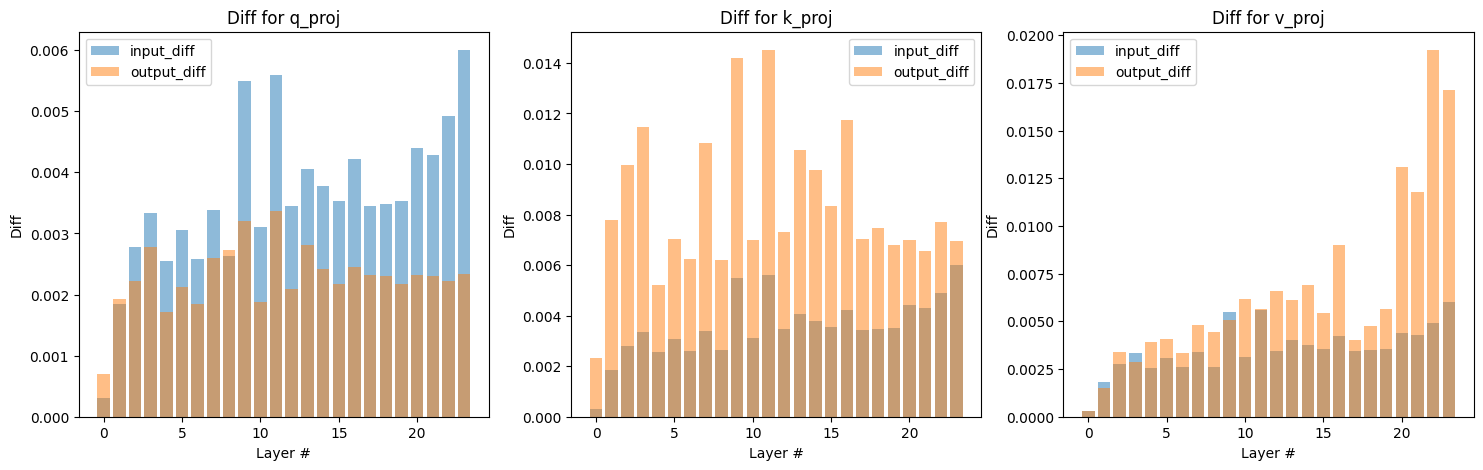

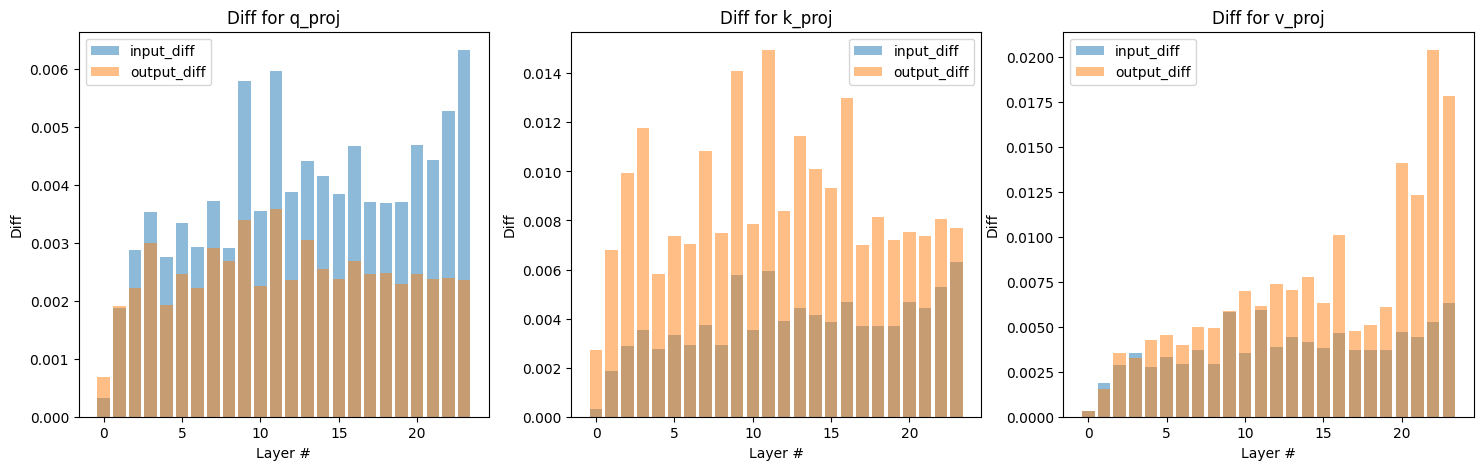

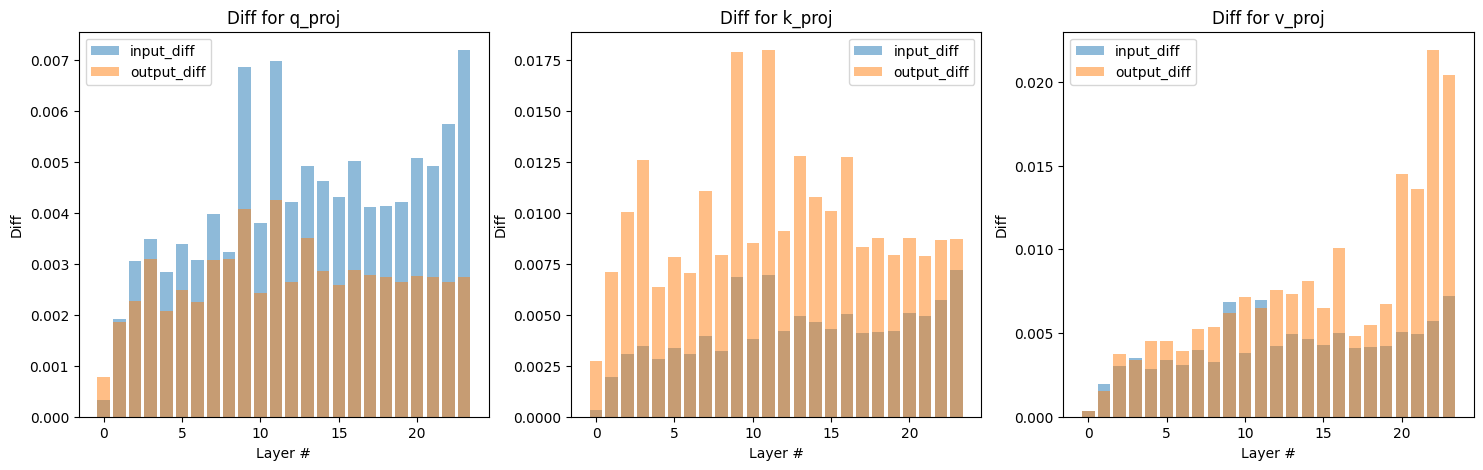

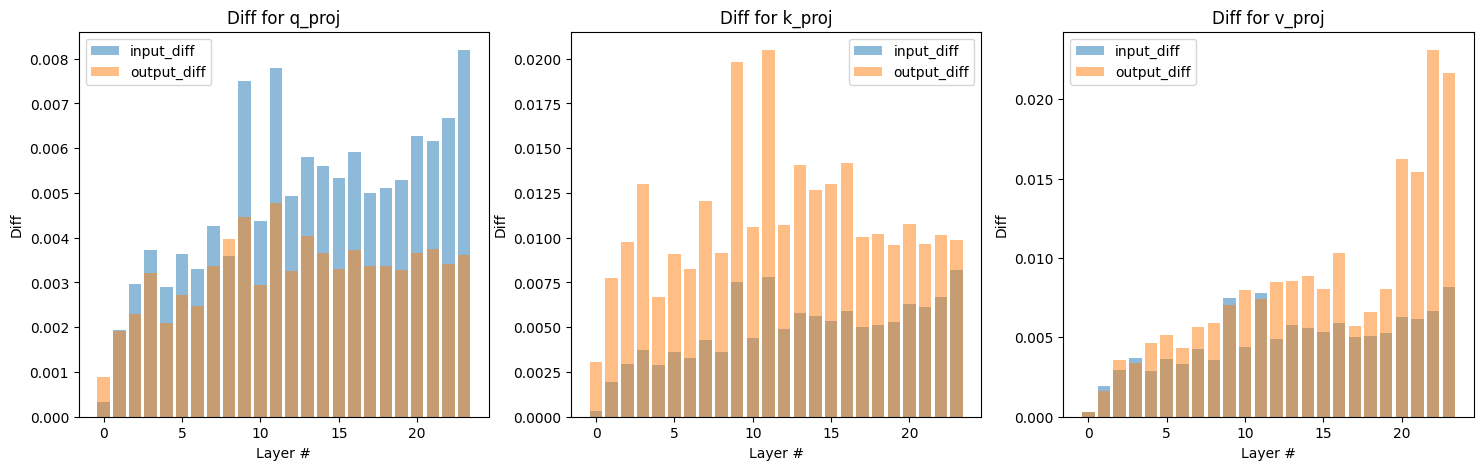

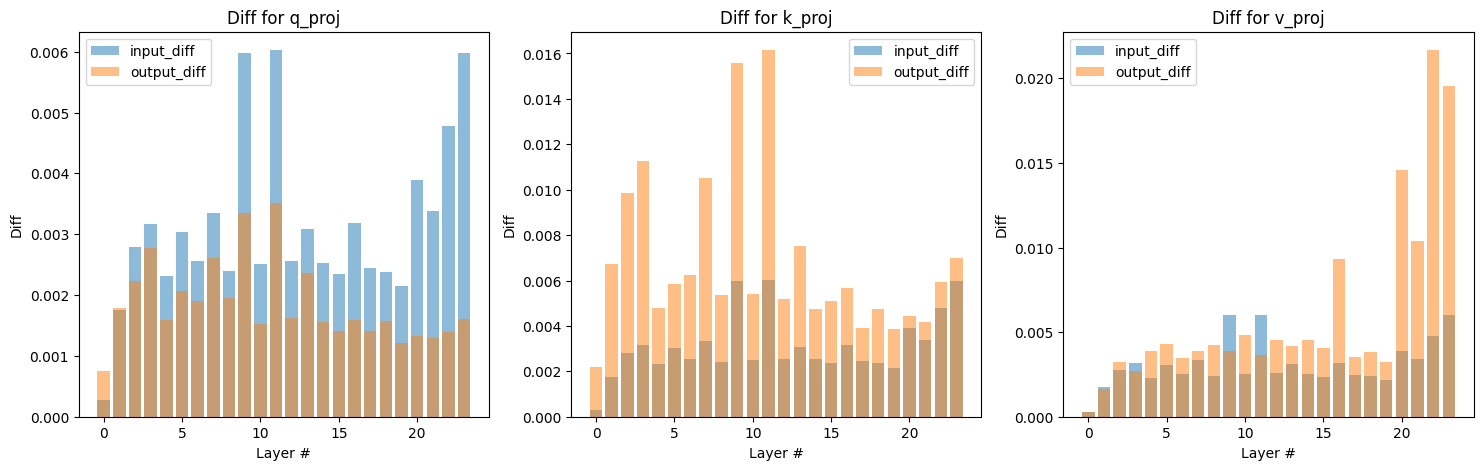

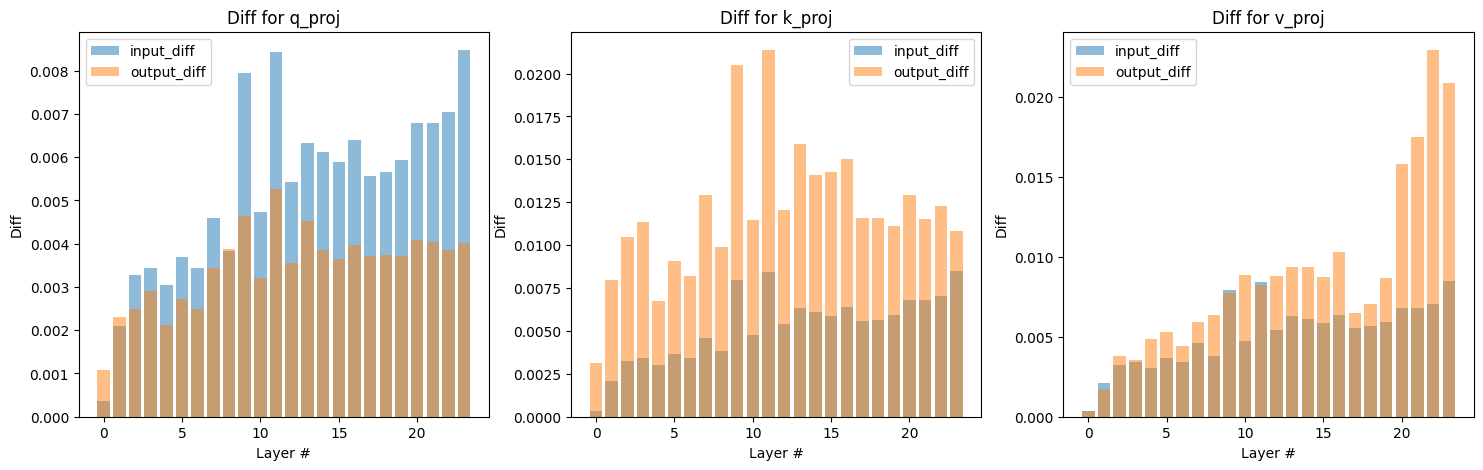

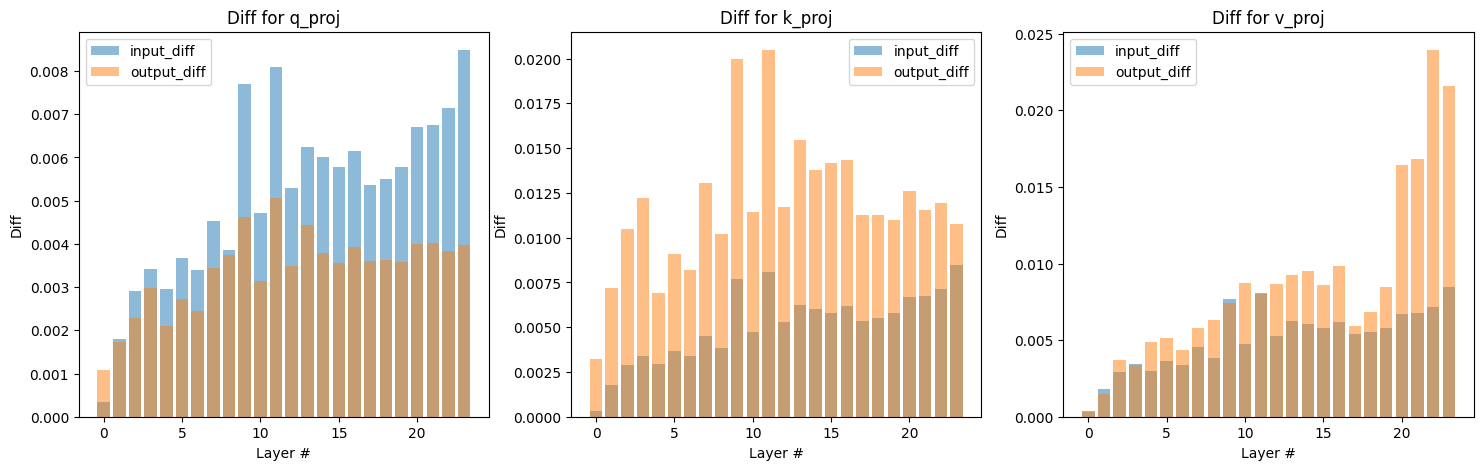

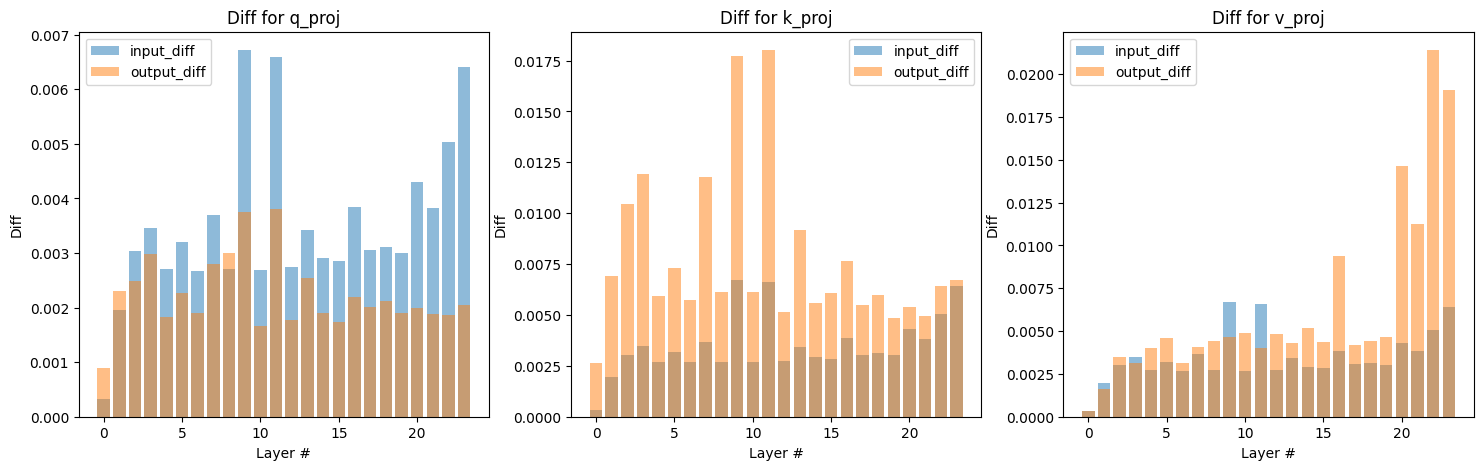

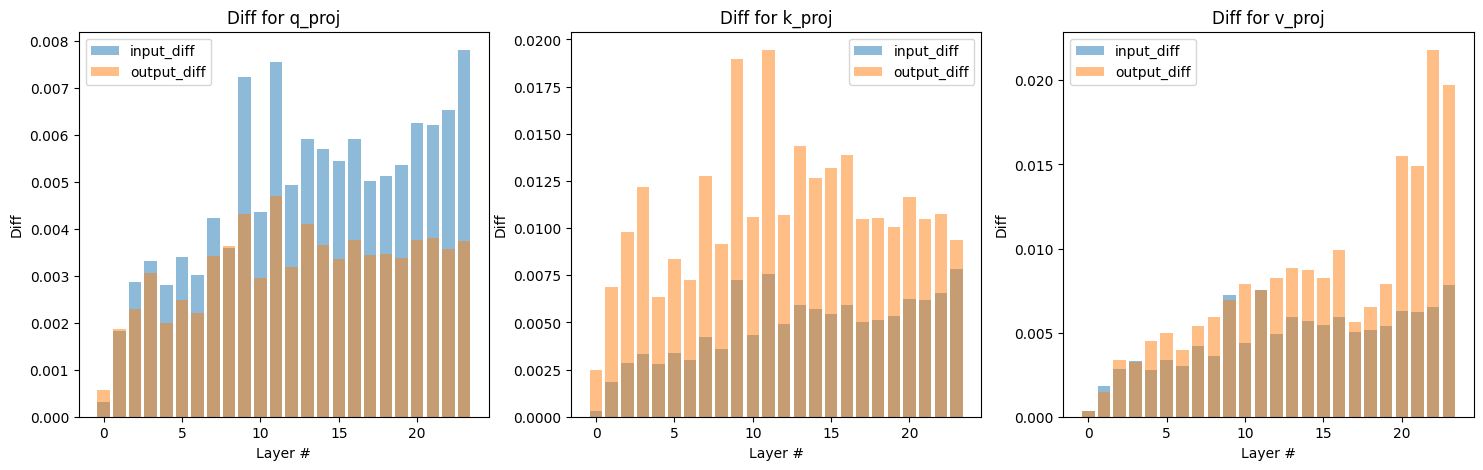

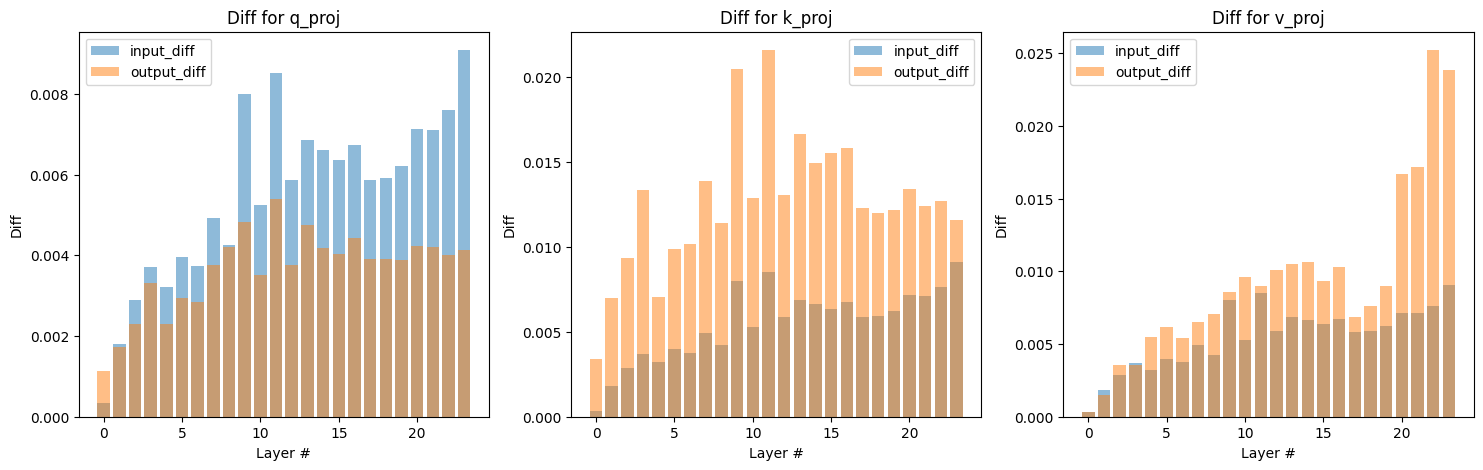

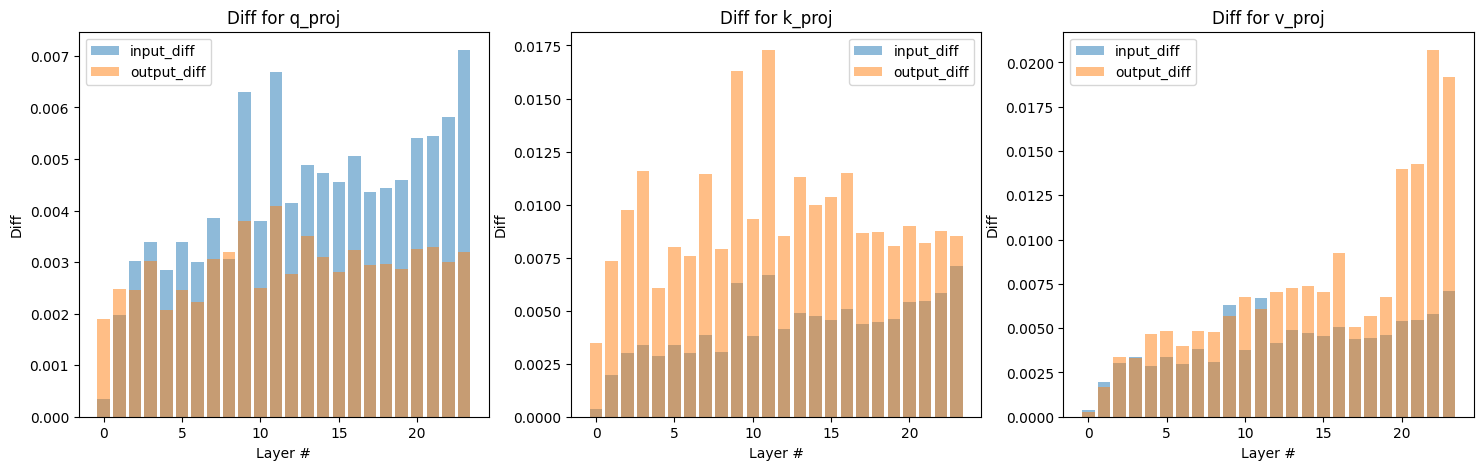

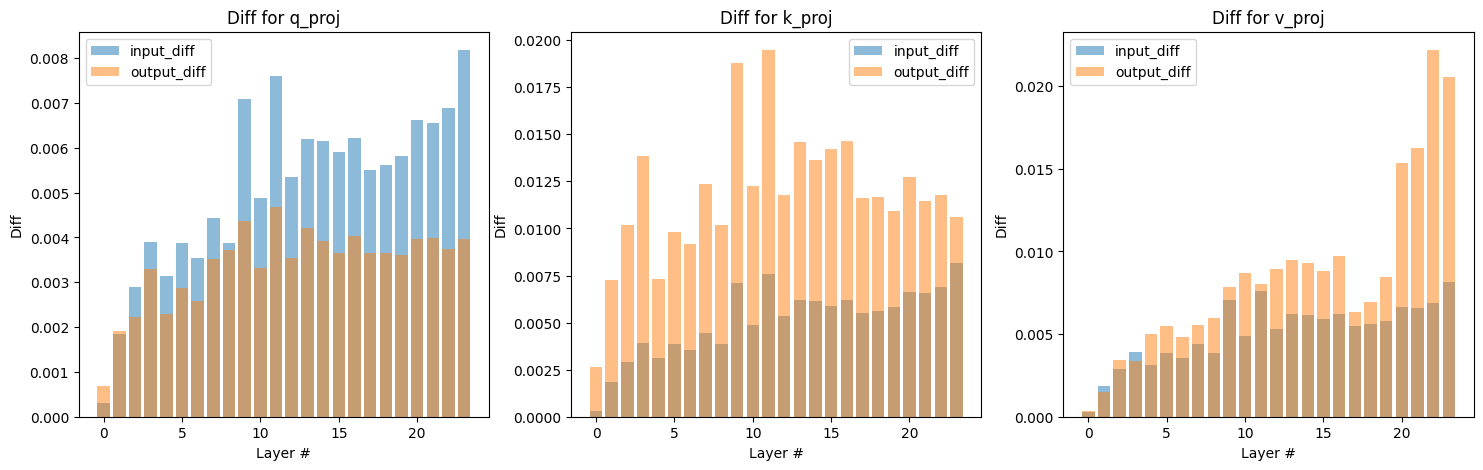

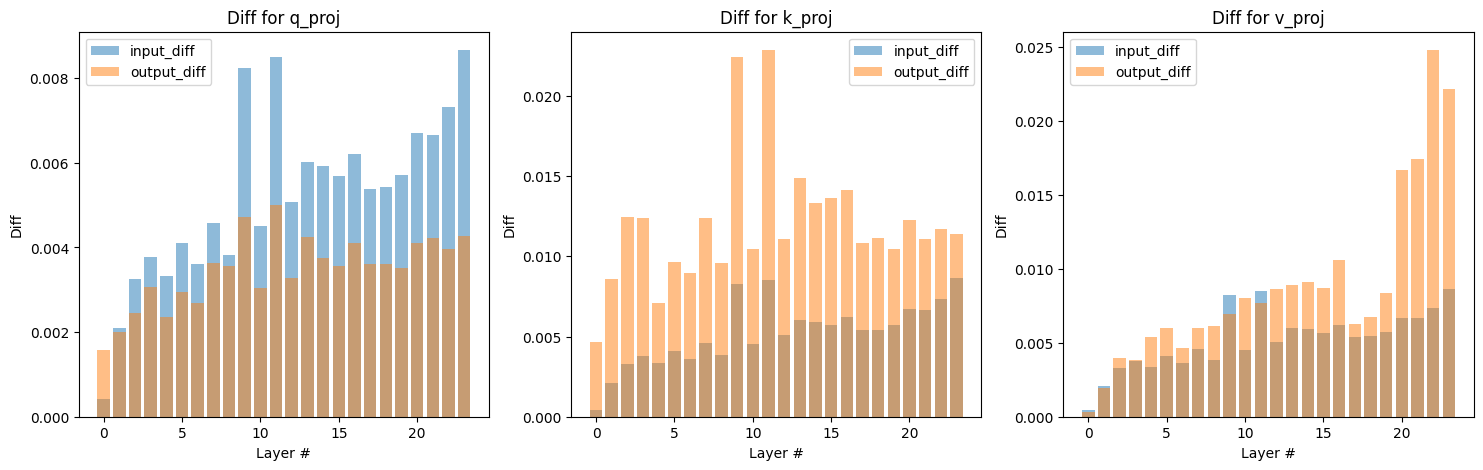

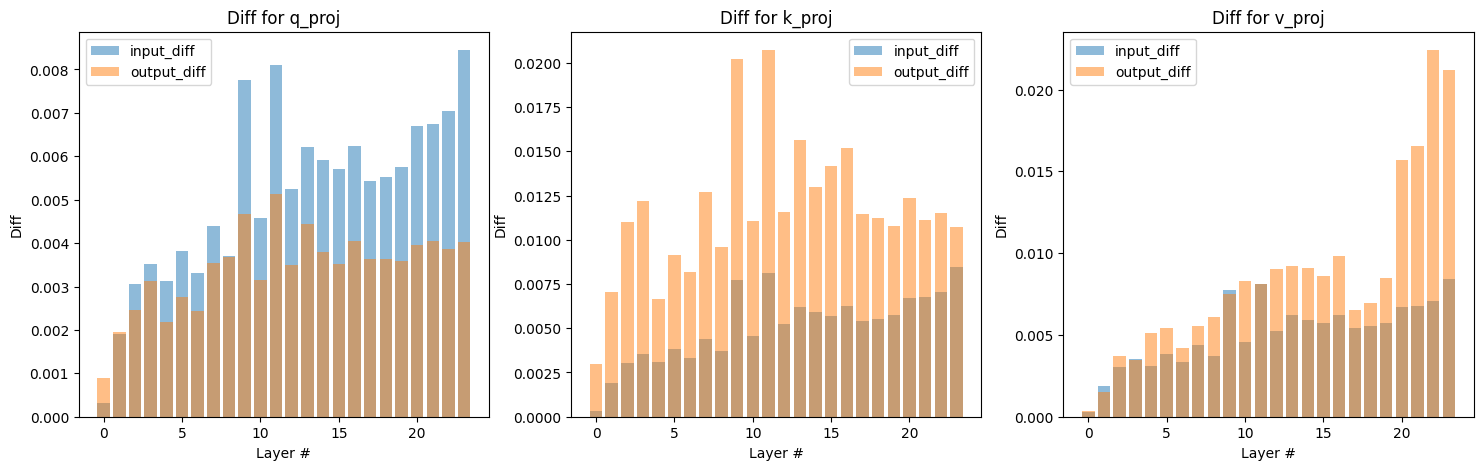

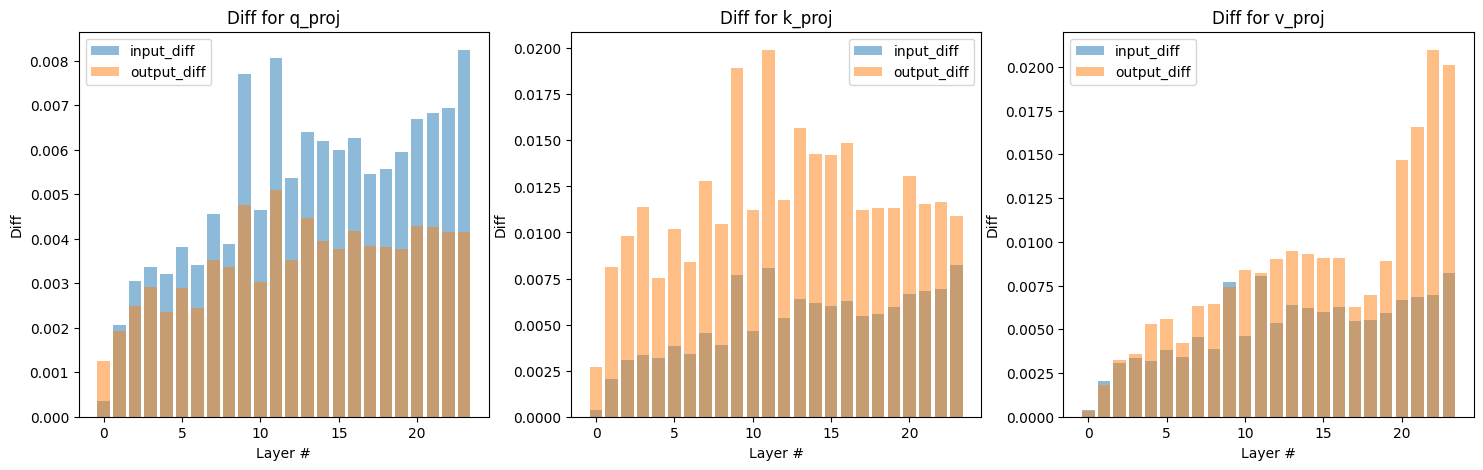

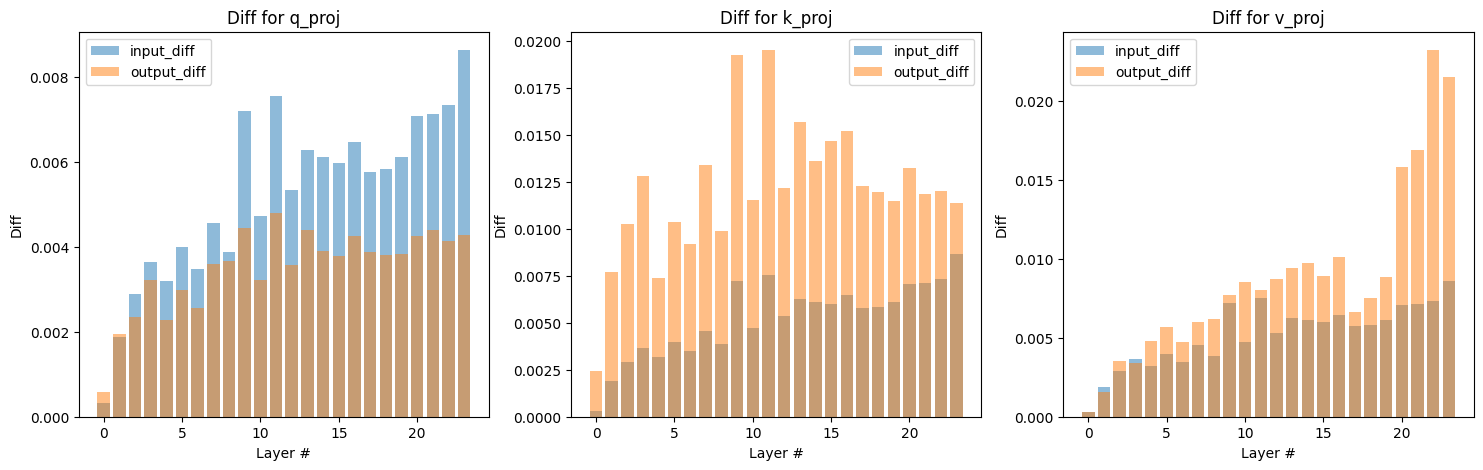

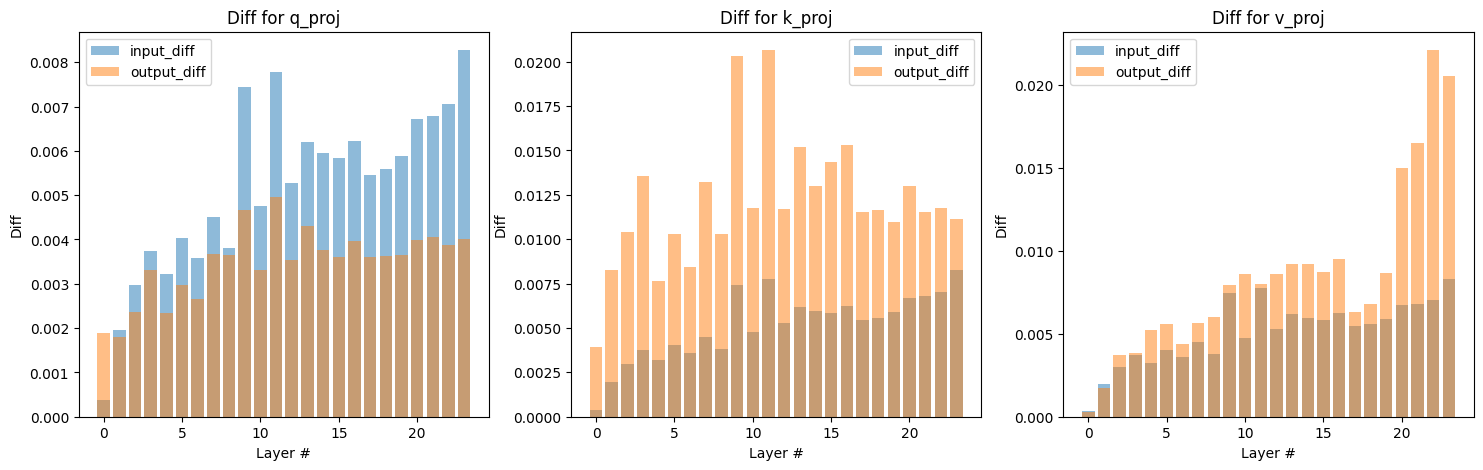

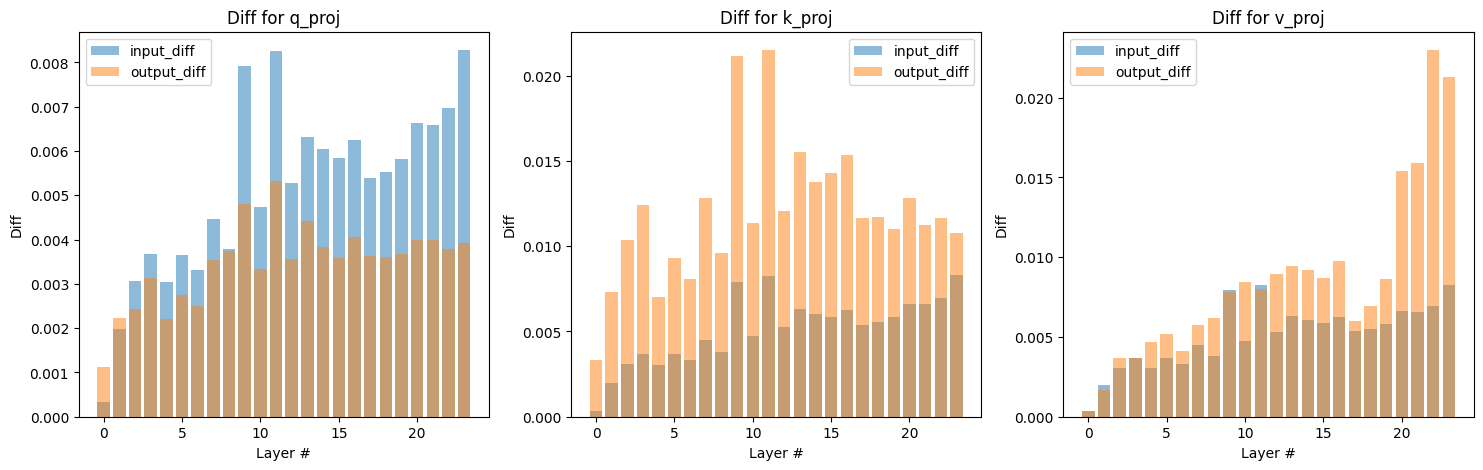

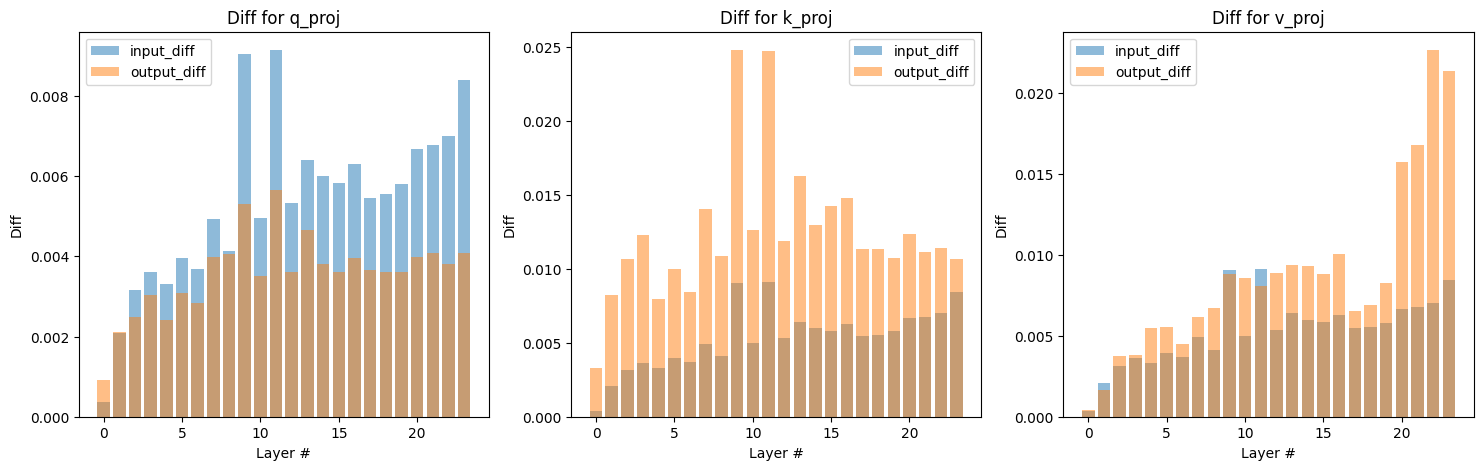

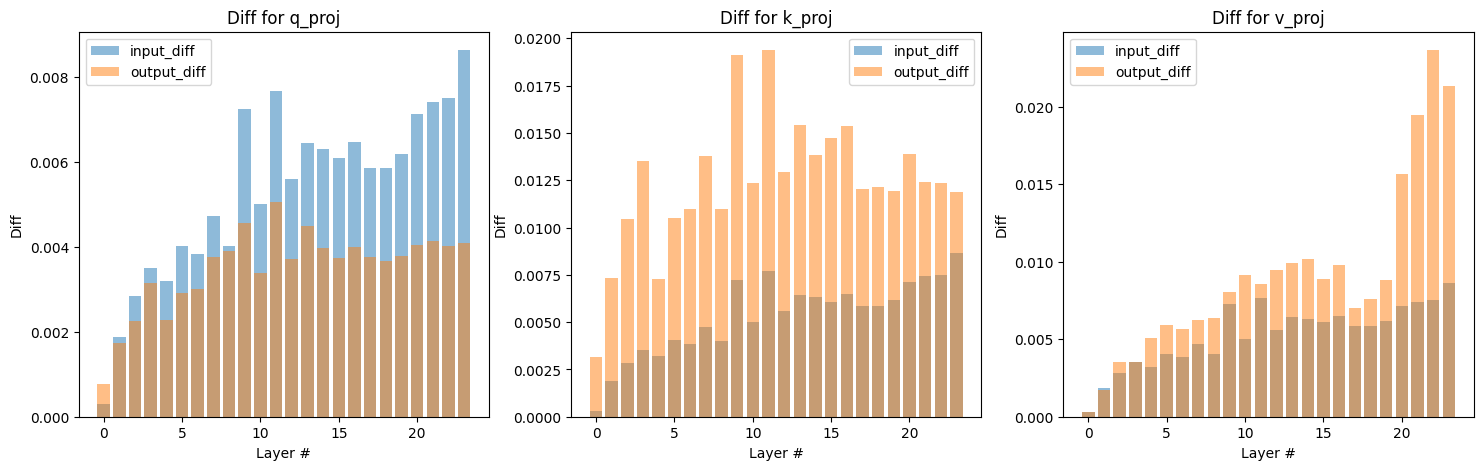

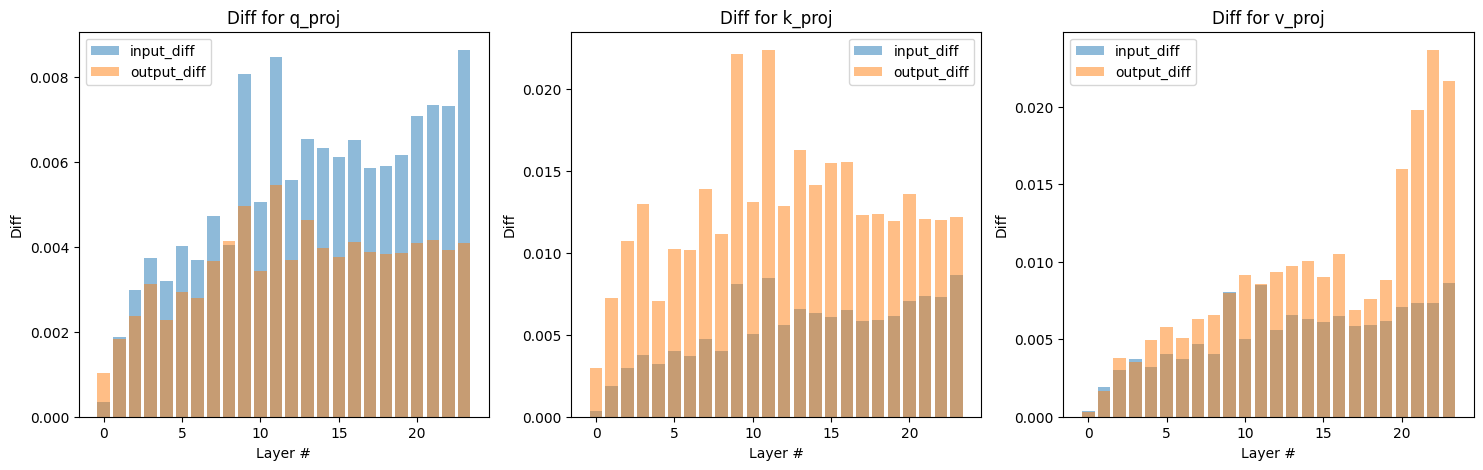

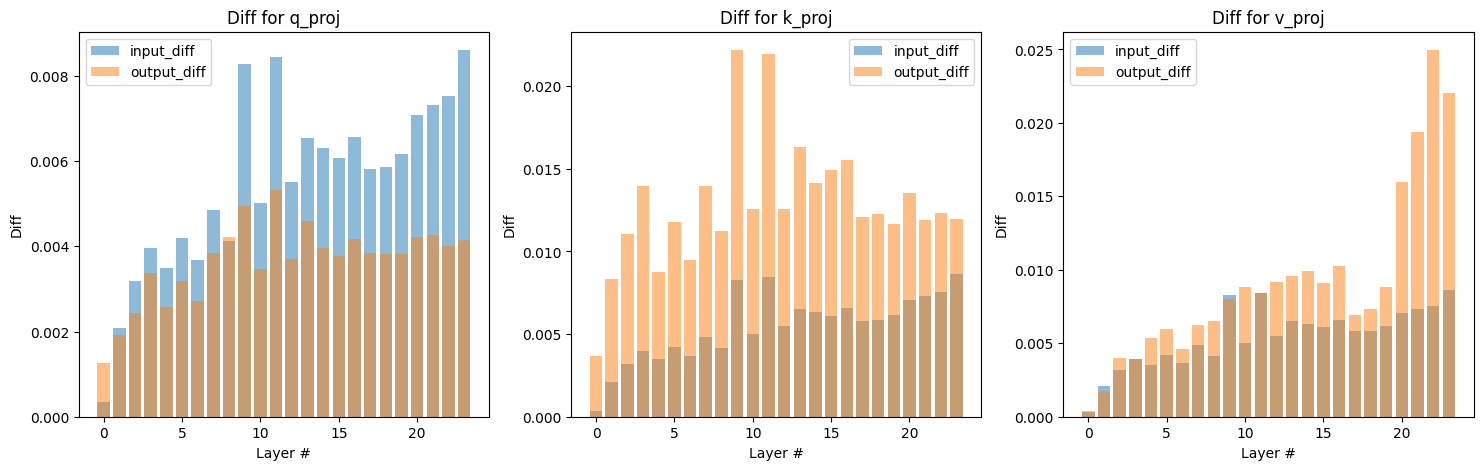

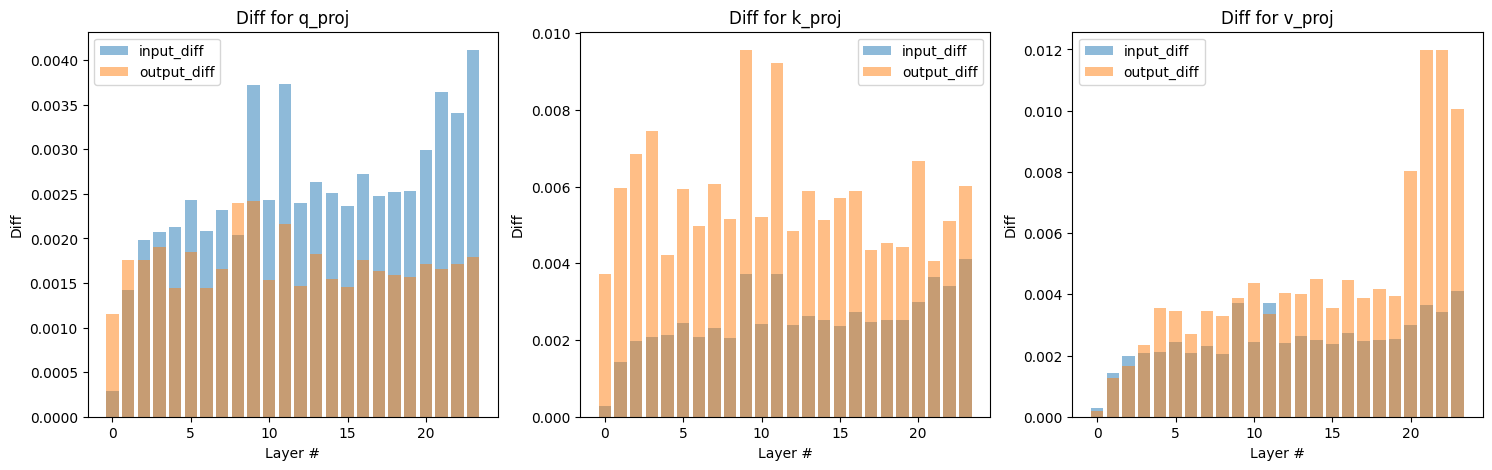

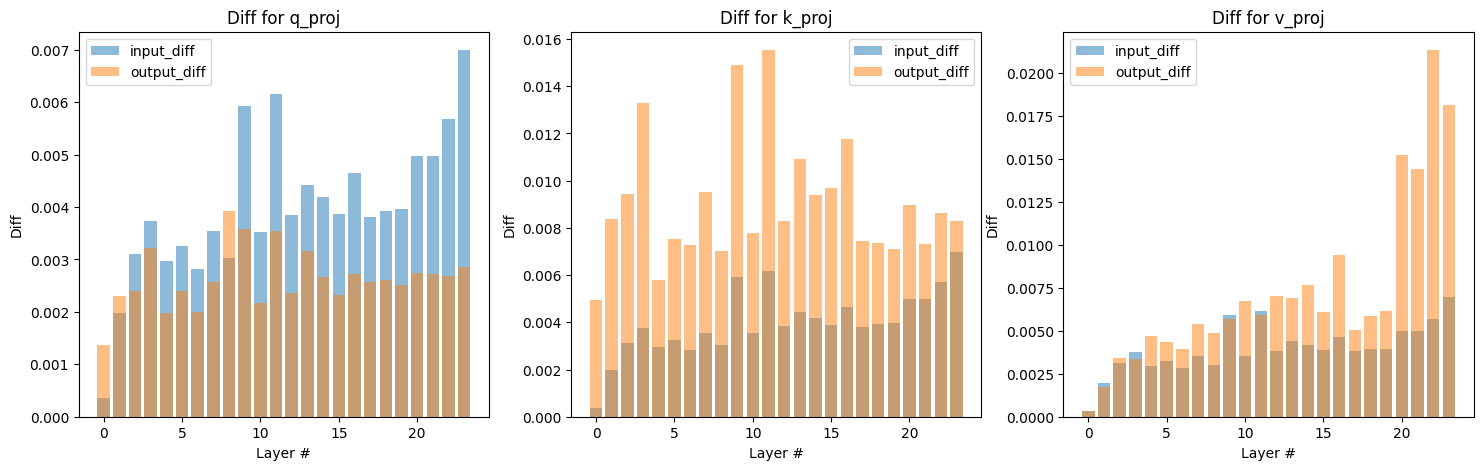

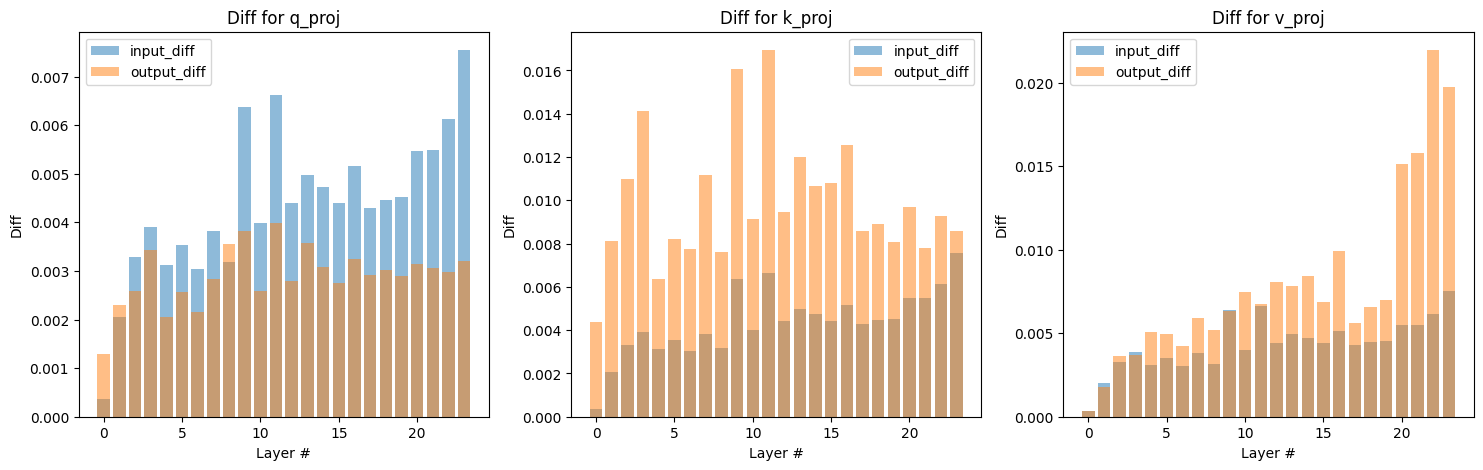

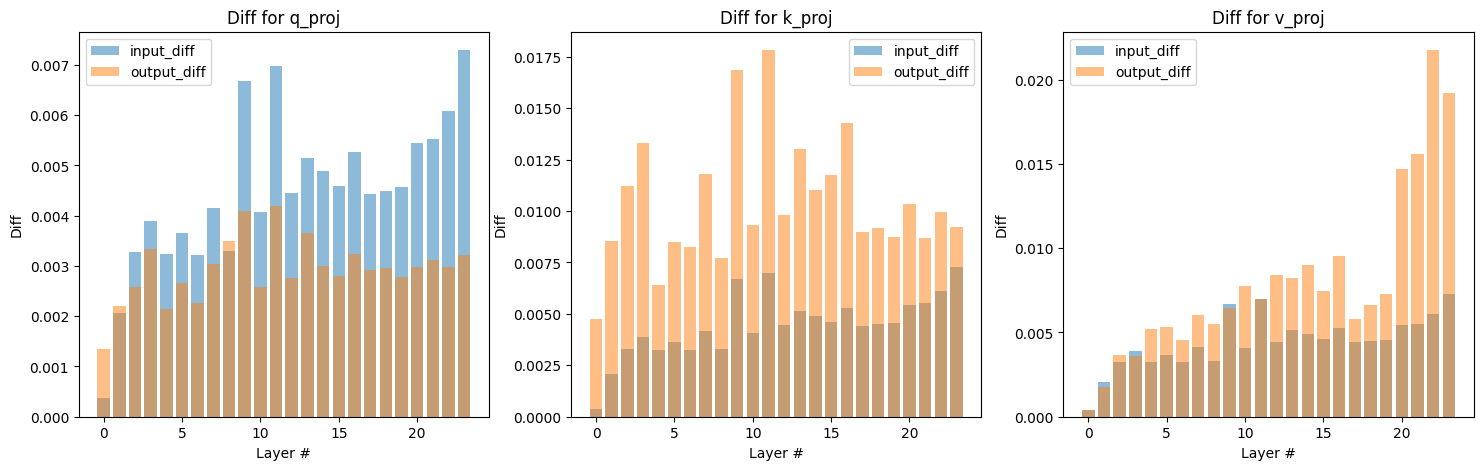

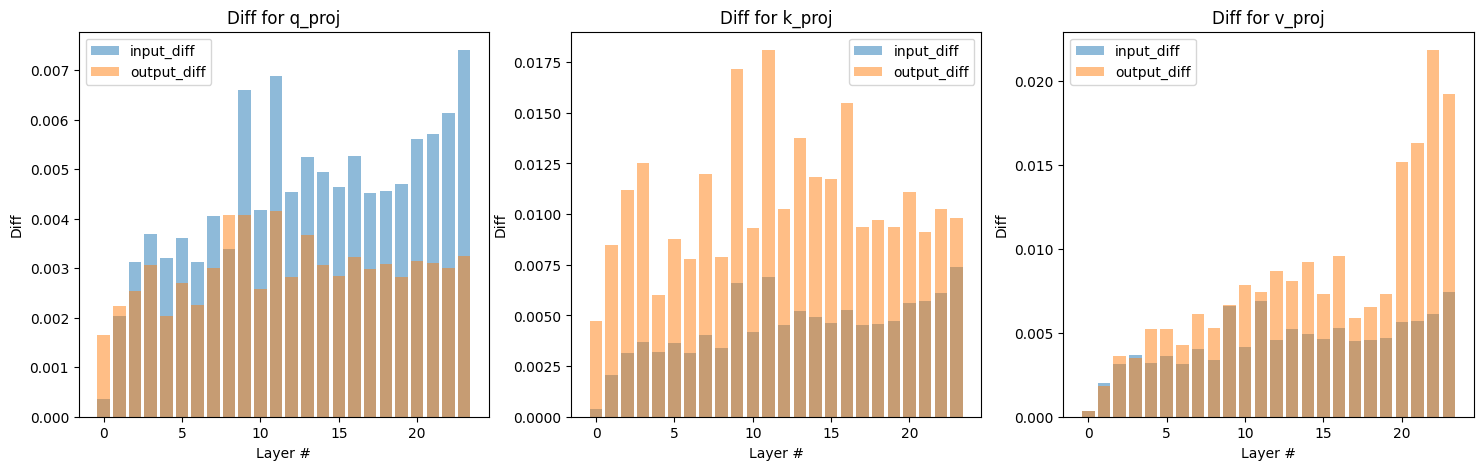

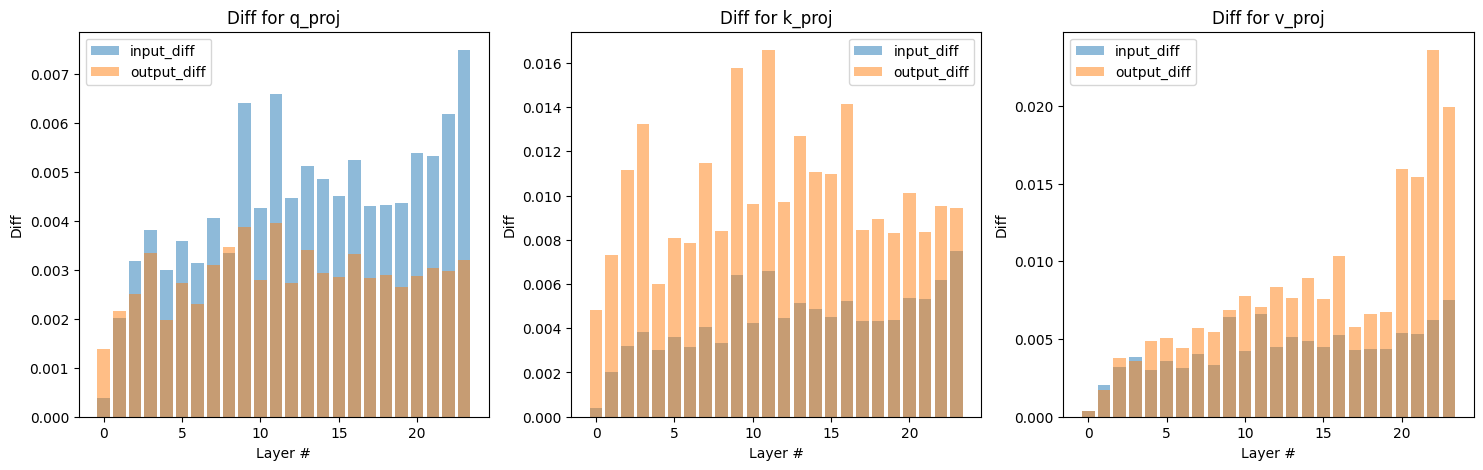

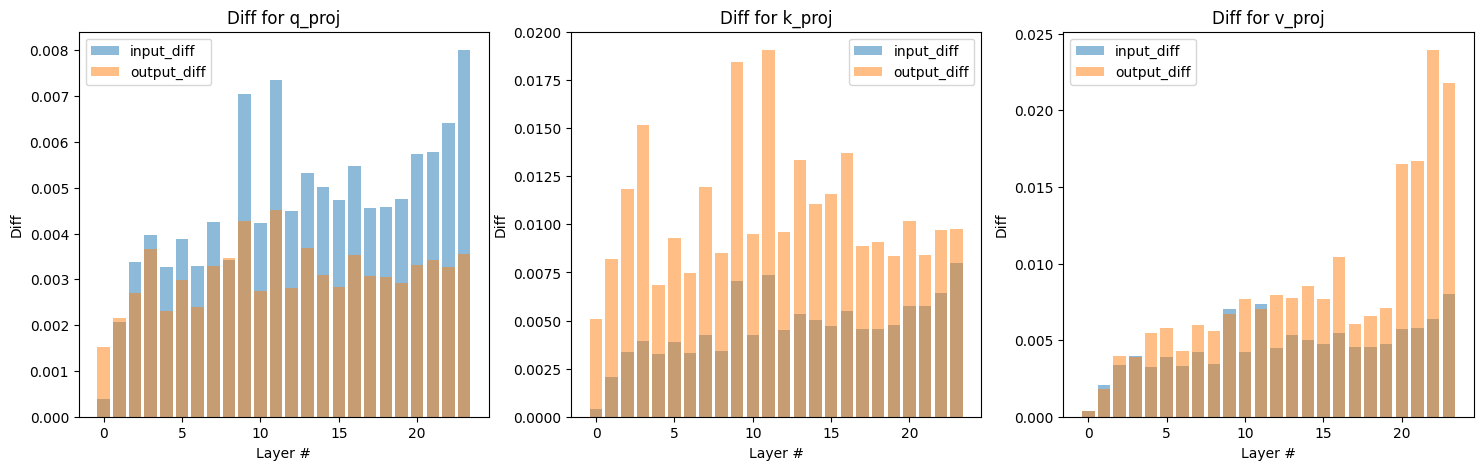

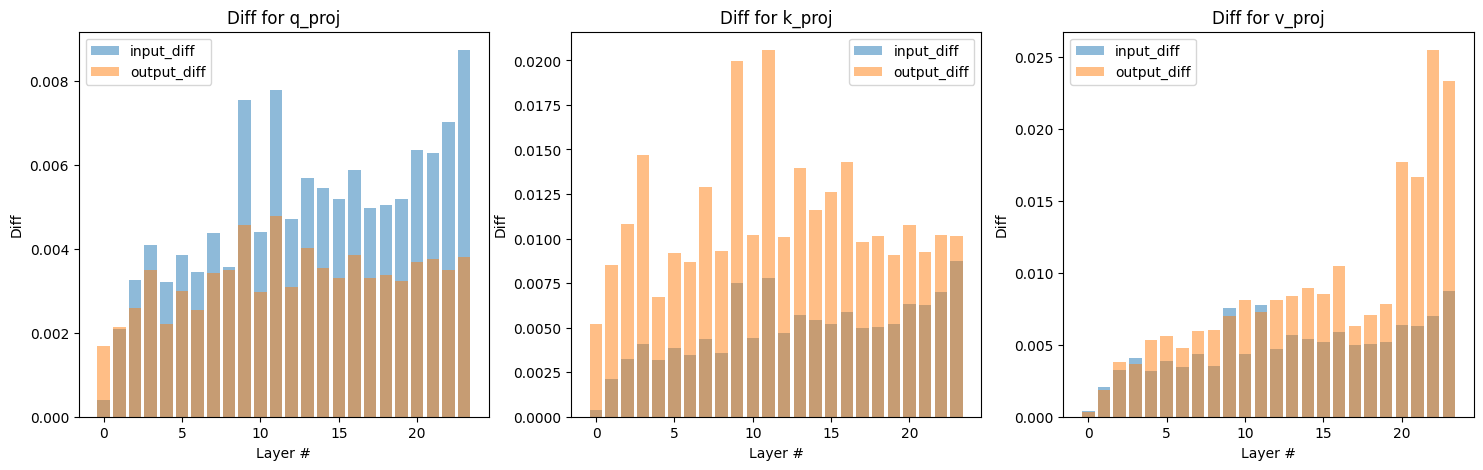

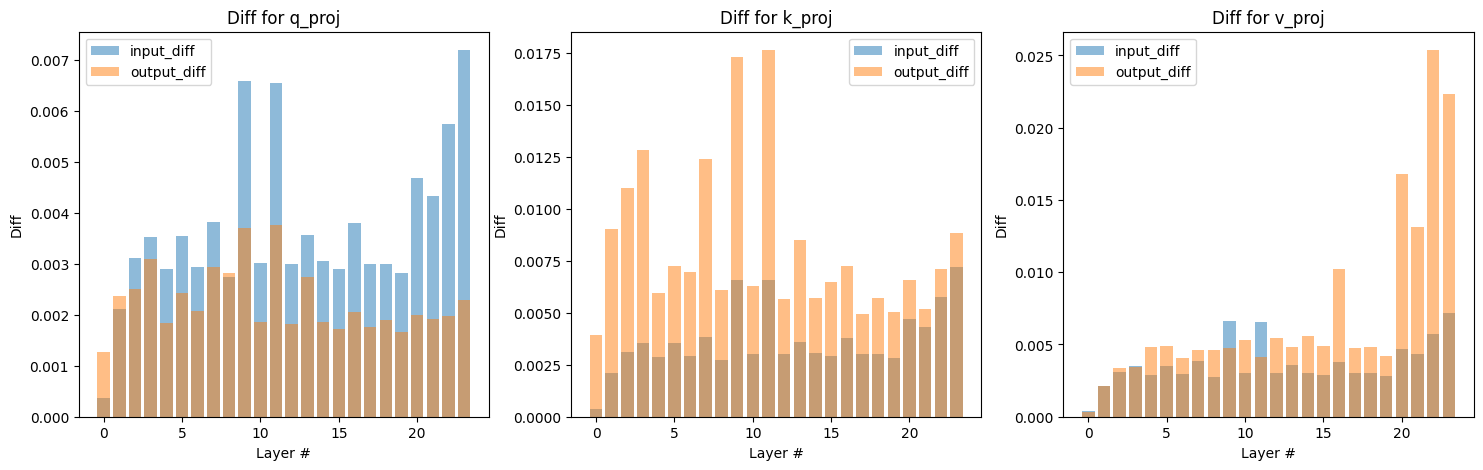

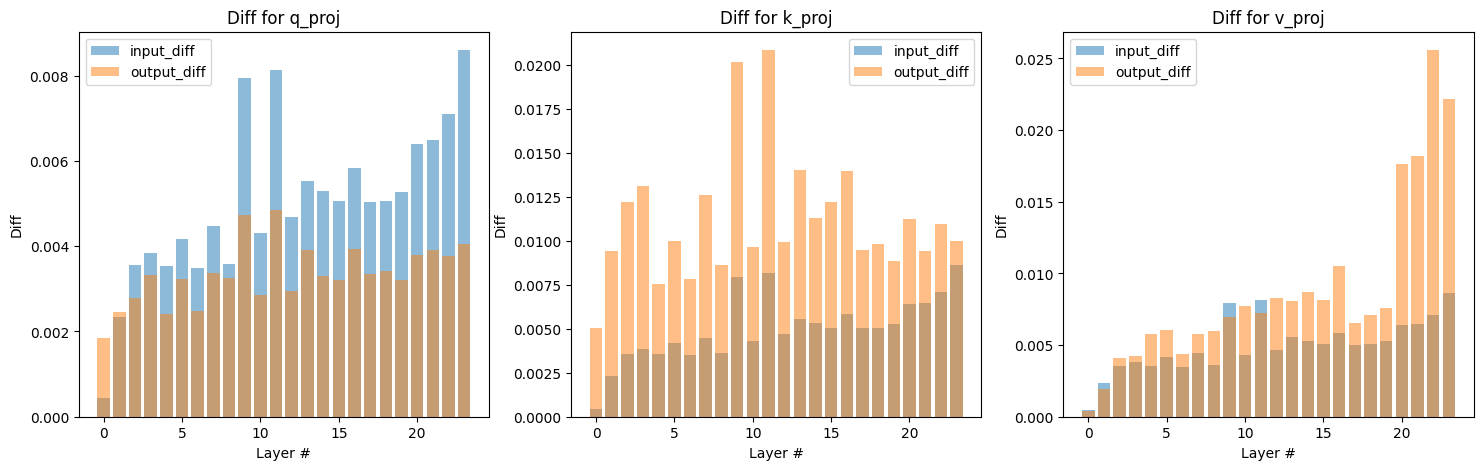

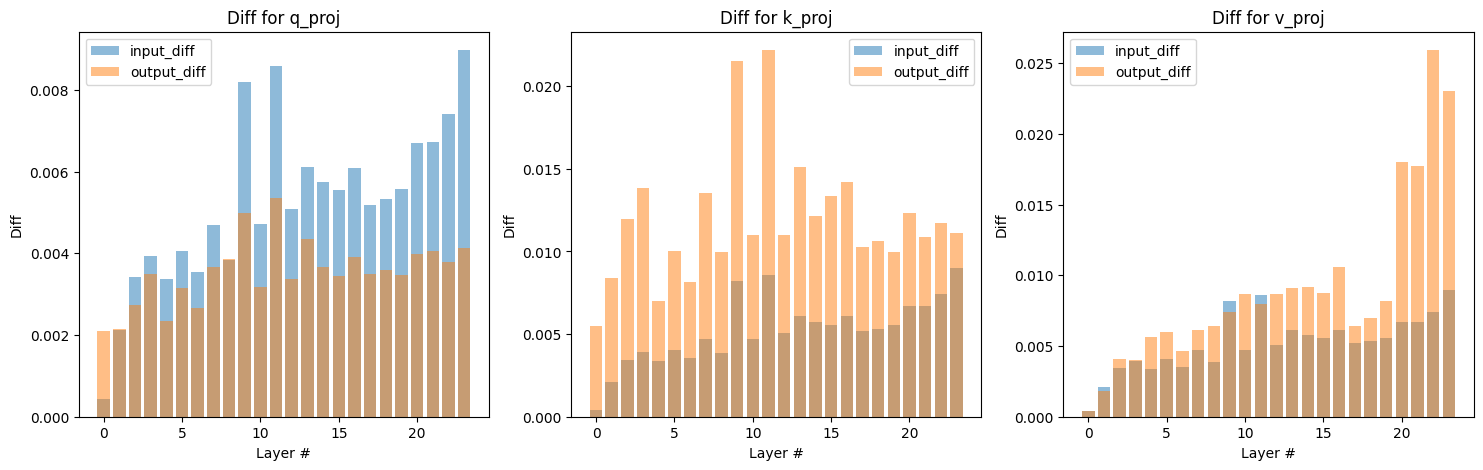

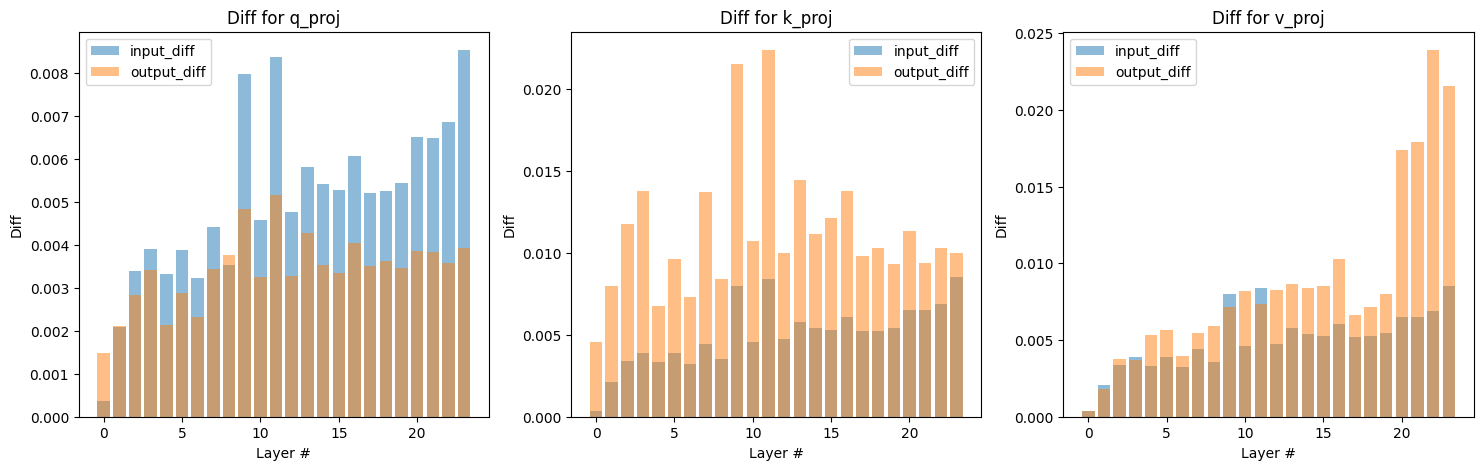

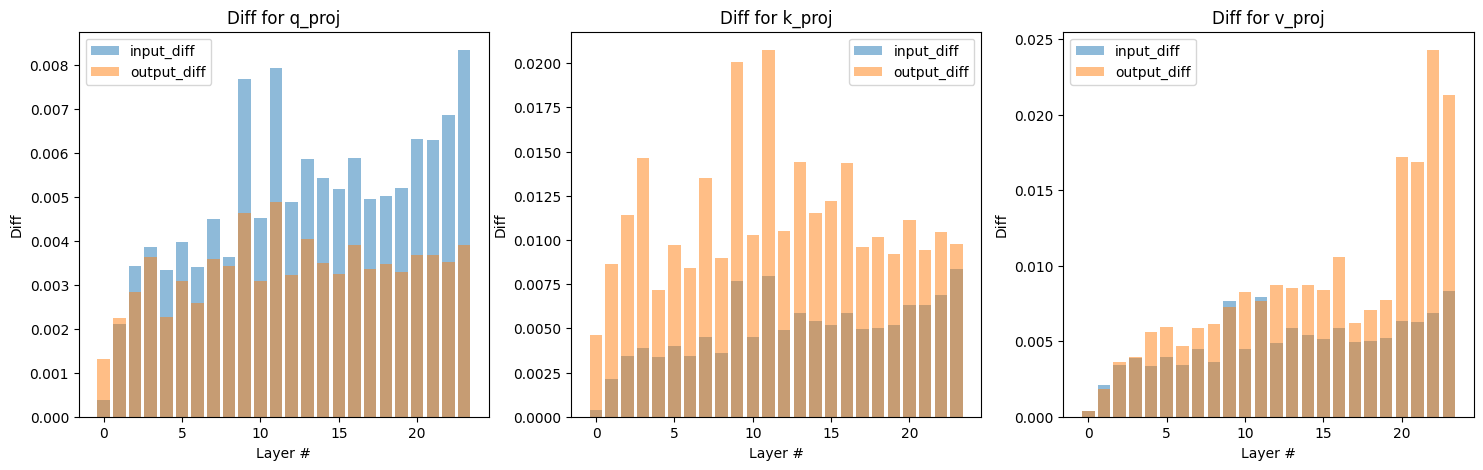

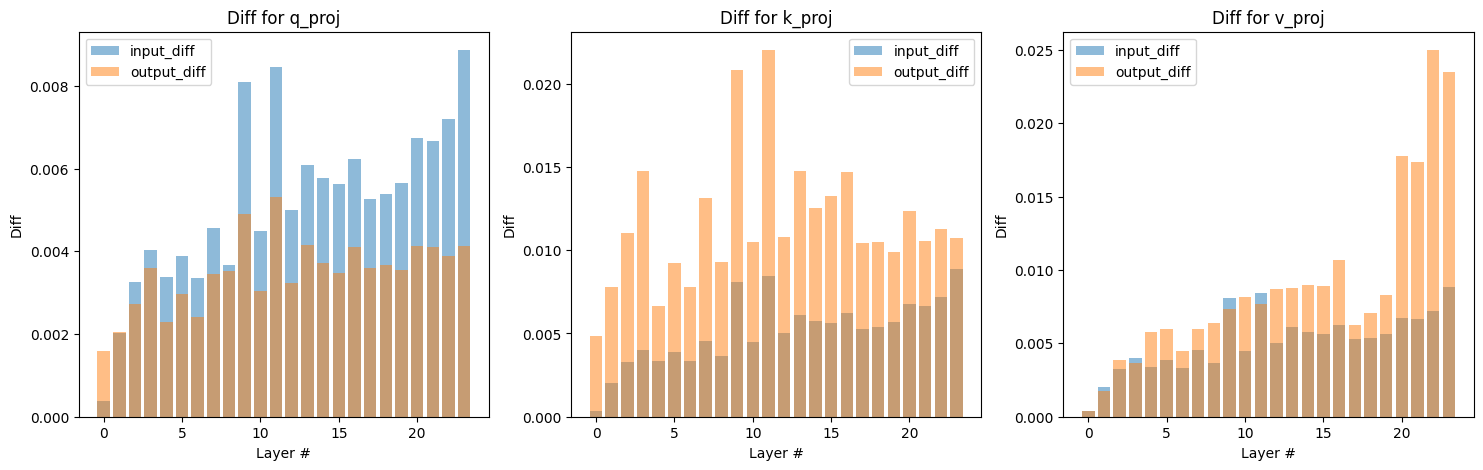

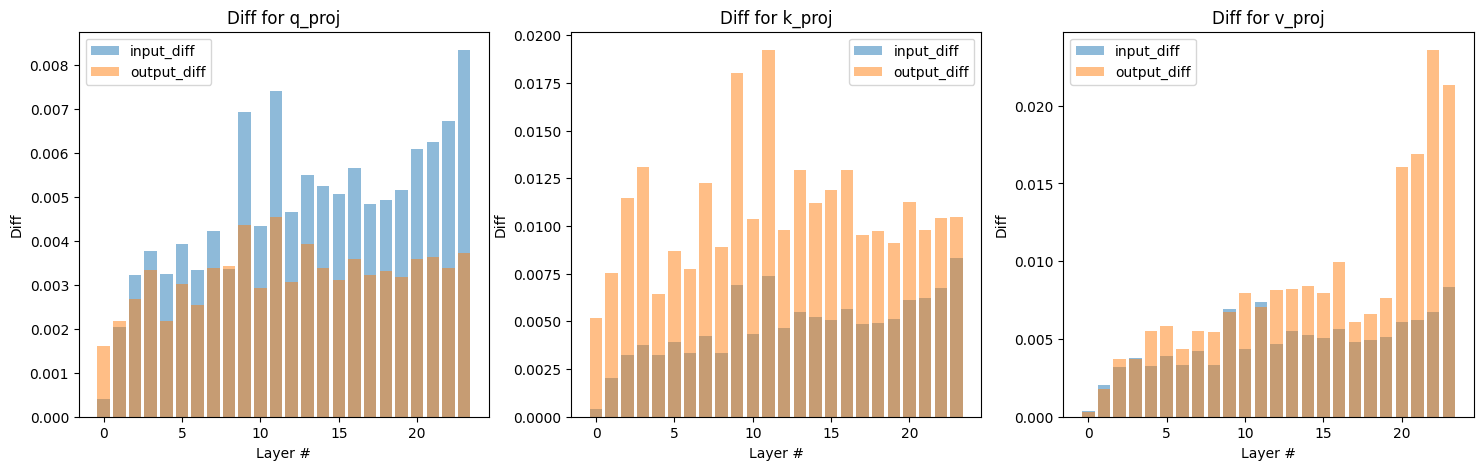

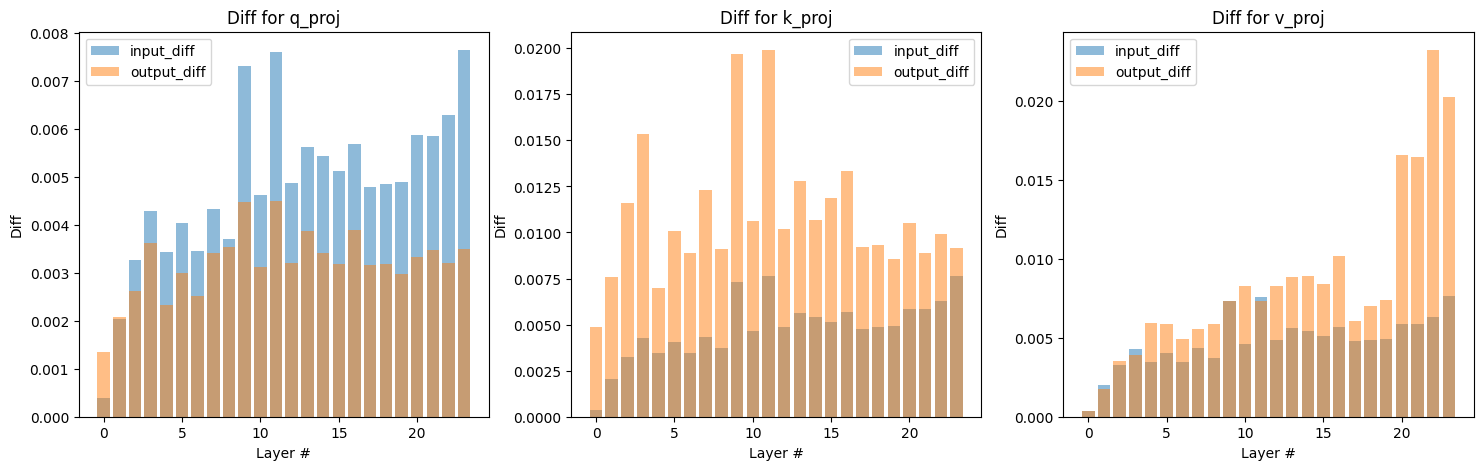

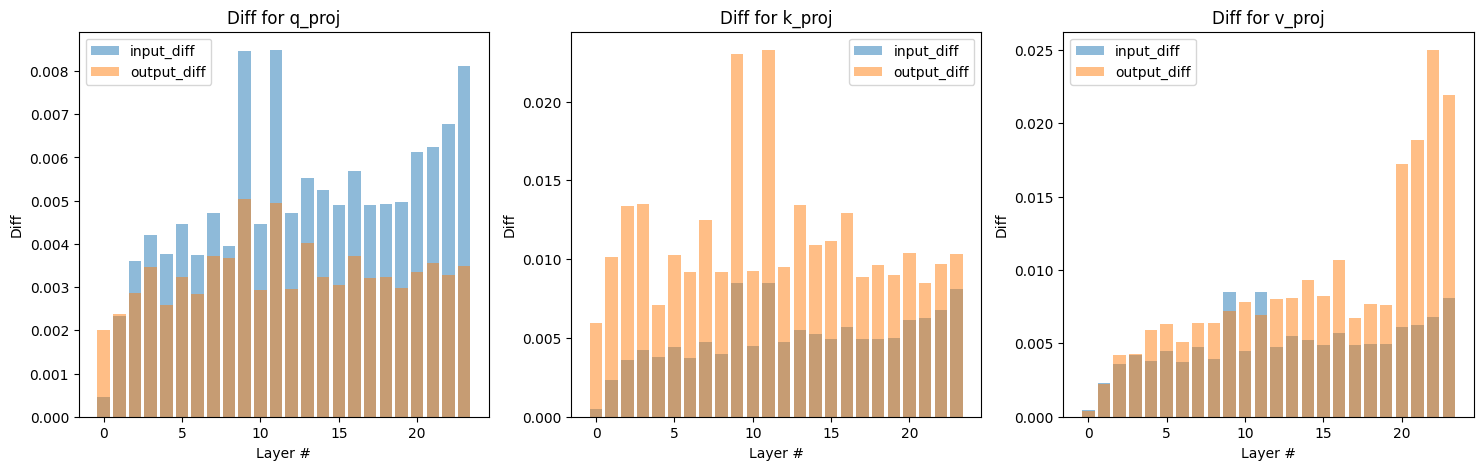

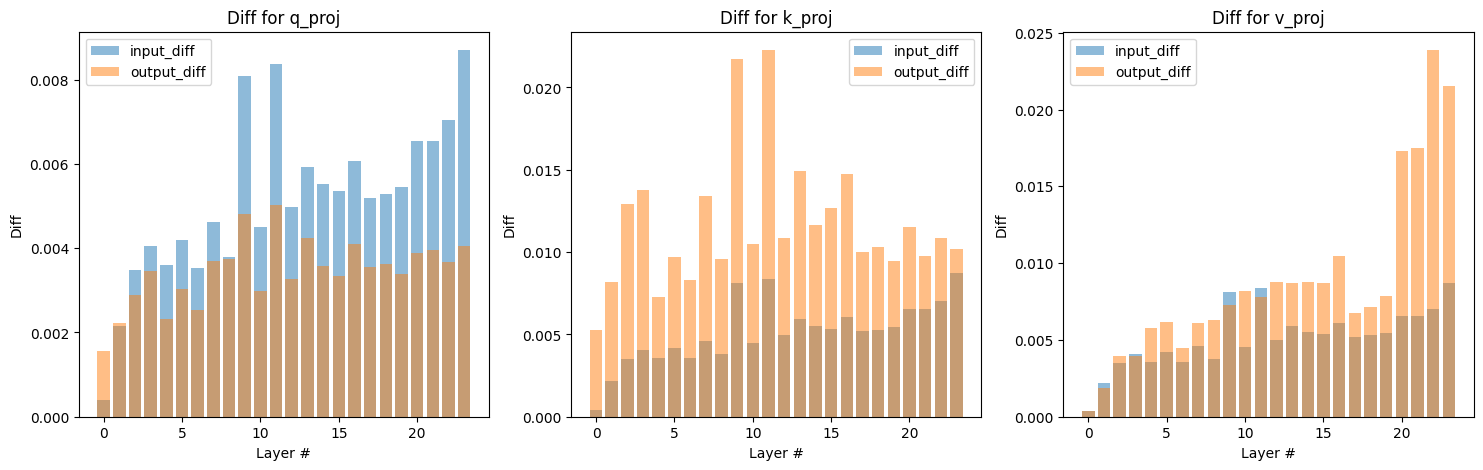

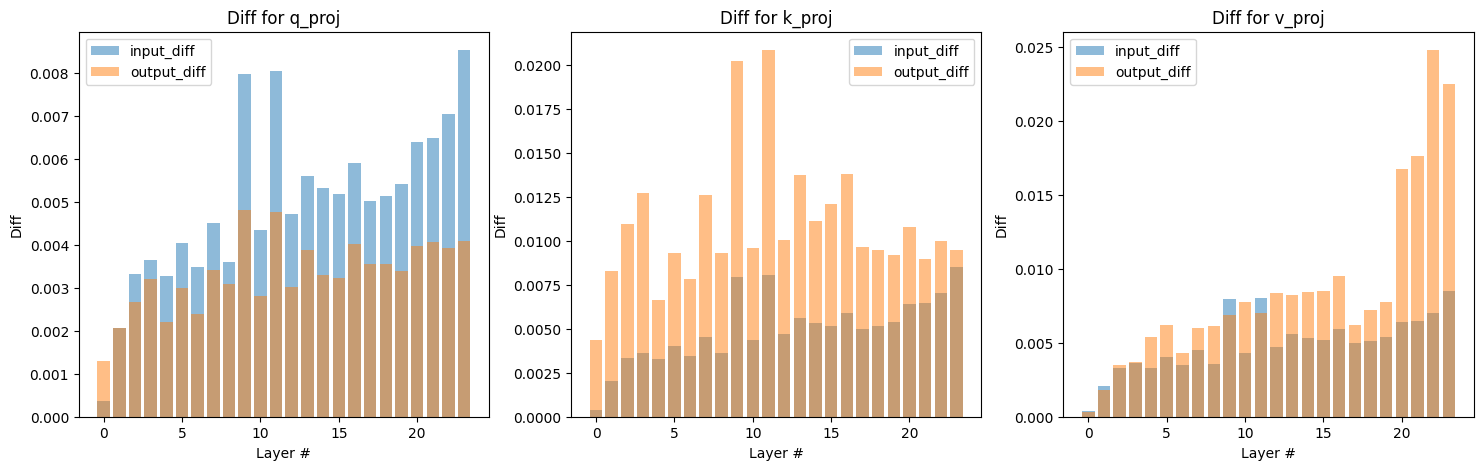

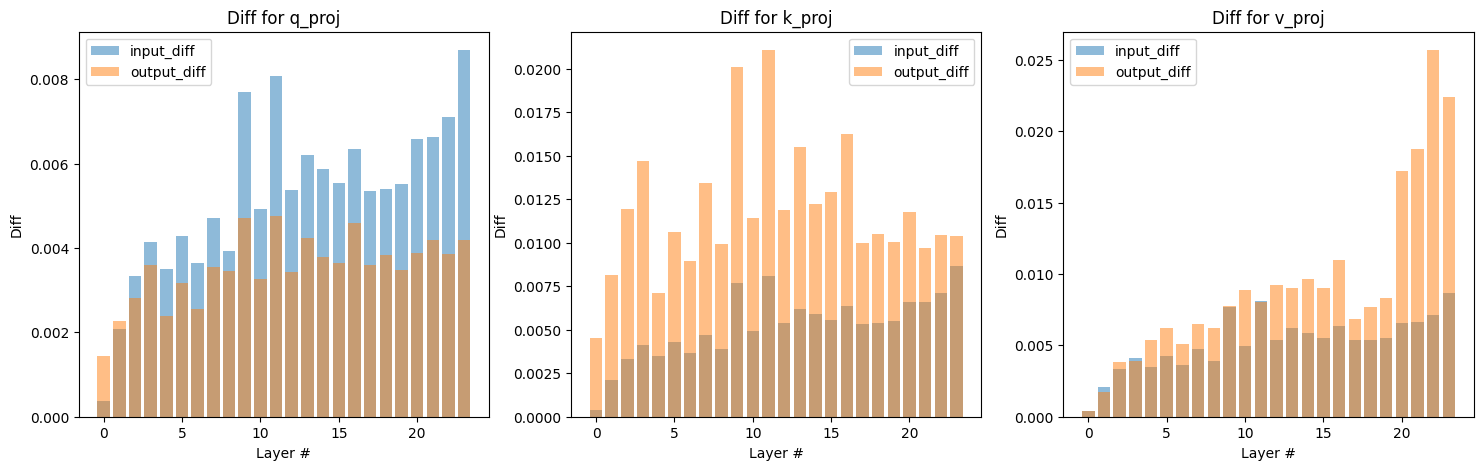

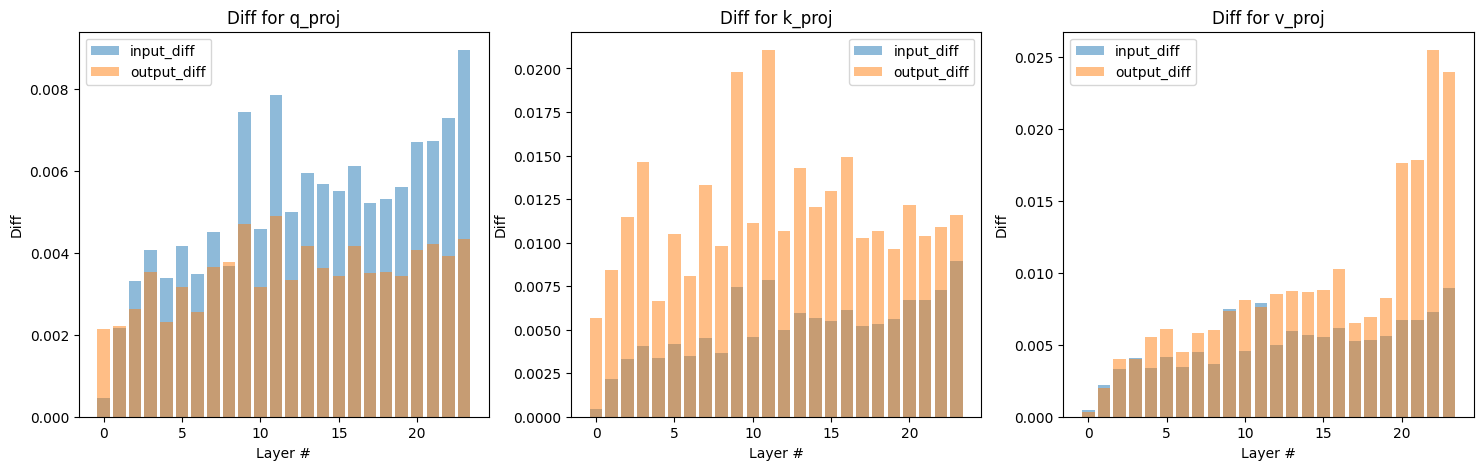

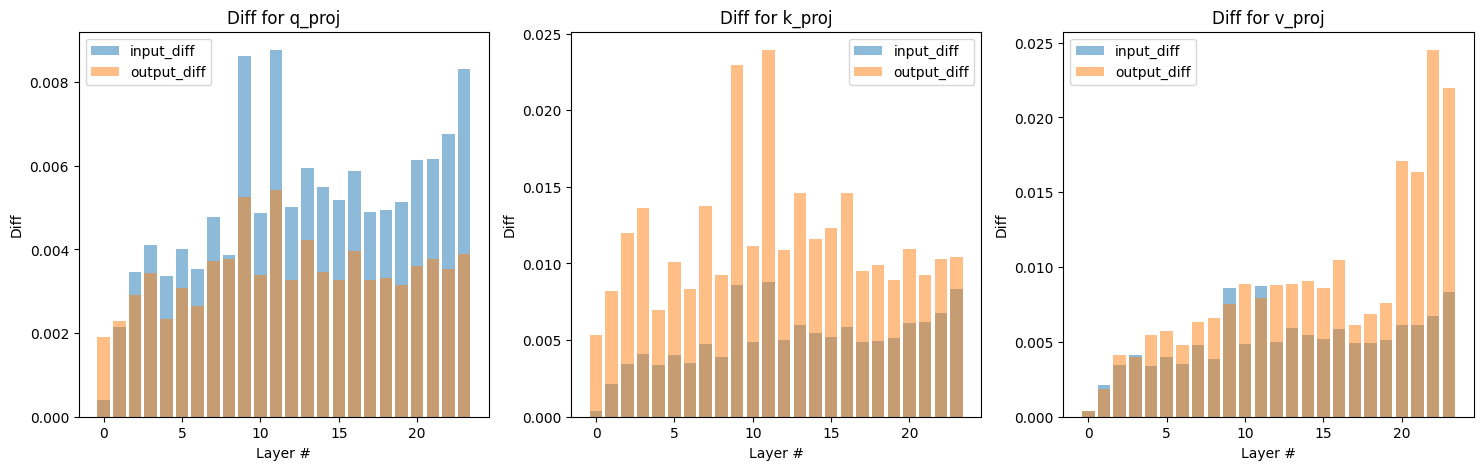

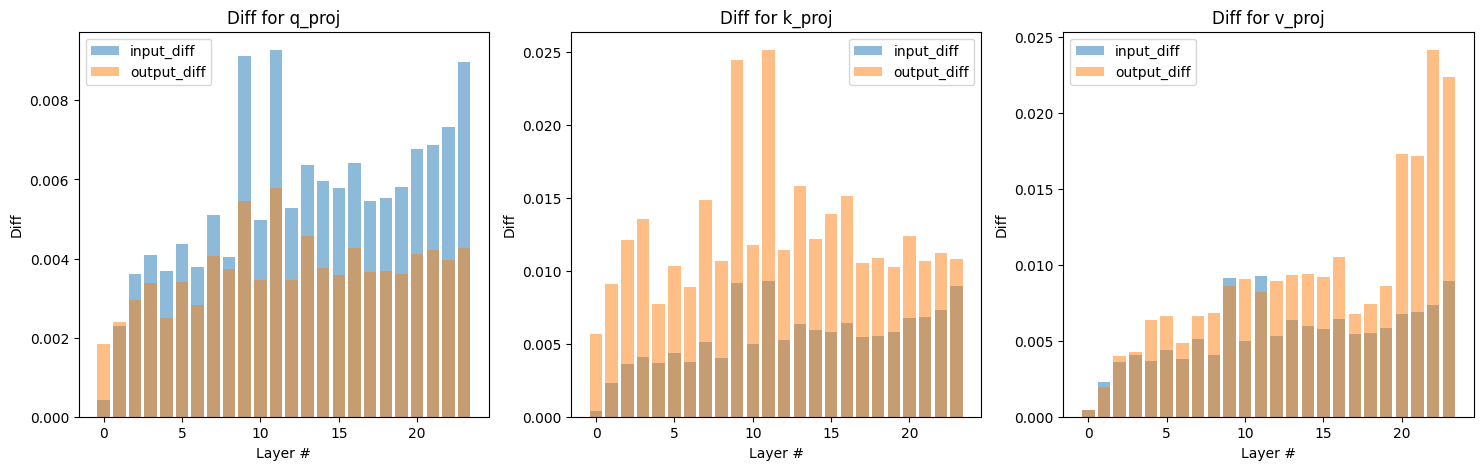

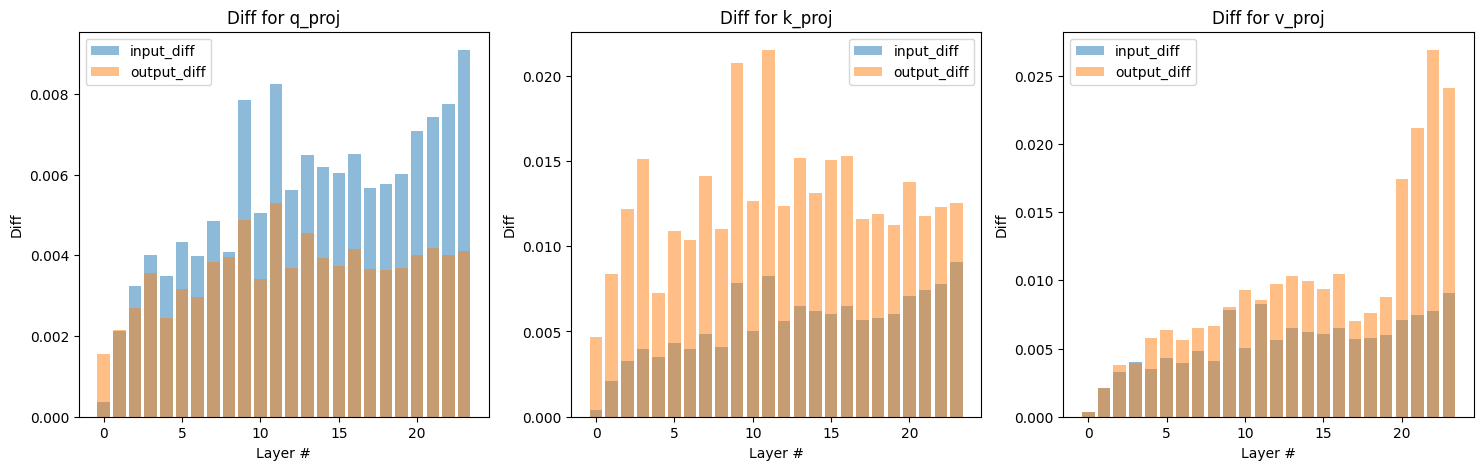

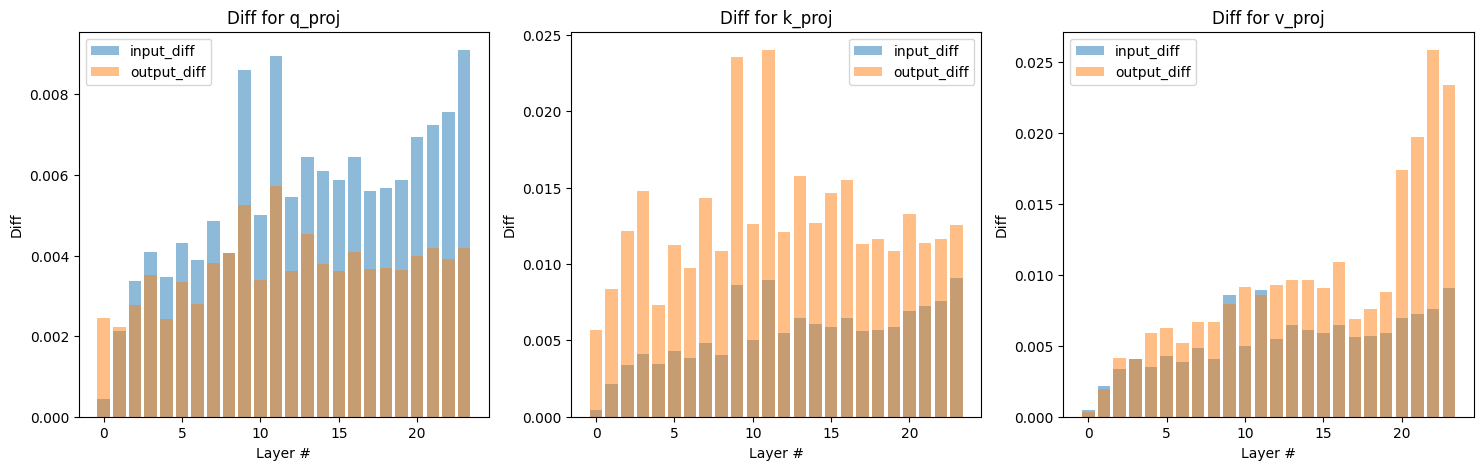

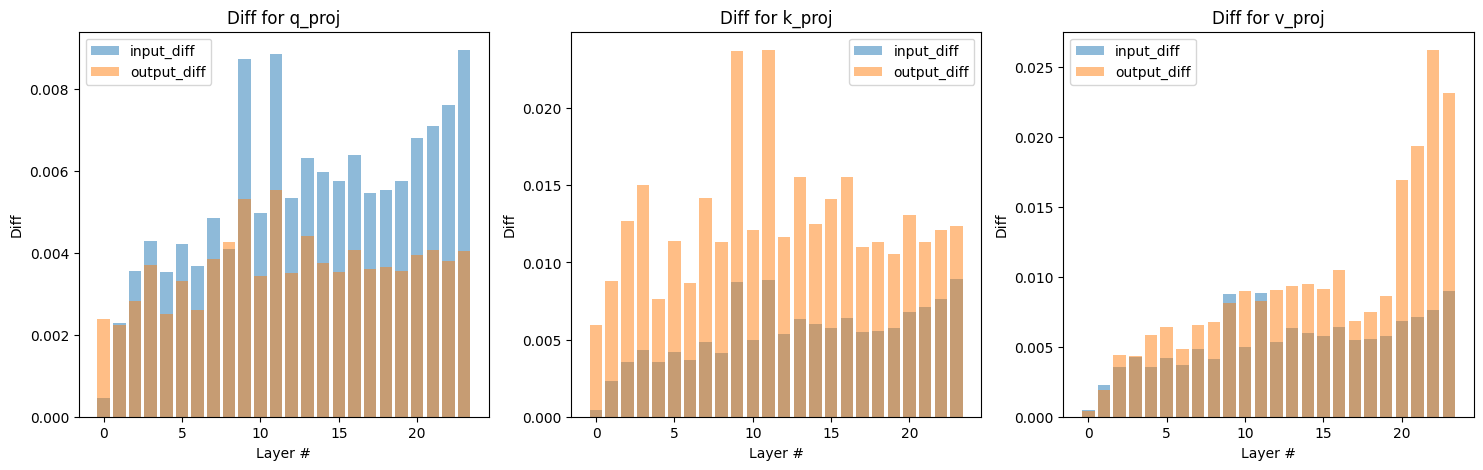

In [10]:
# 对比“(a)英文单词strawberry中有几个字母r”与“({})英文单词strawberry中有几个字母{x}”
for i in range(62, 113):
    easy_compare_forward_hook_data(
        hook_data_path_1 = hook_data_path_formatter.format(61), 
        hook_data_path_2 = hook_data_path_formatter.format(i),
        forward_hook_module_names = forward_hook_module_names[:],
        figure_names = ["q_proj", "k_proj", "v_proj"],
    )
    # if input(prompts[i]): break

### 对比两个不同长度的prompt的输出？

首个生成的token无法对比，后面都是可以对比的，因为用了cache，每次只传入一个token

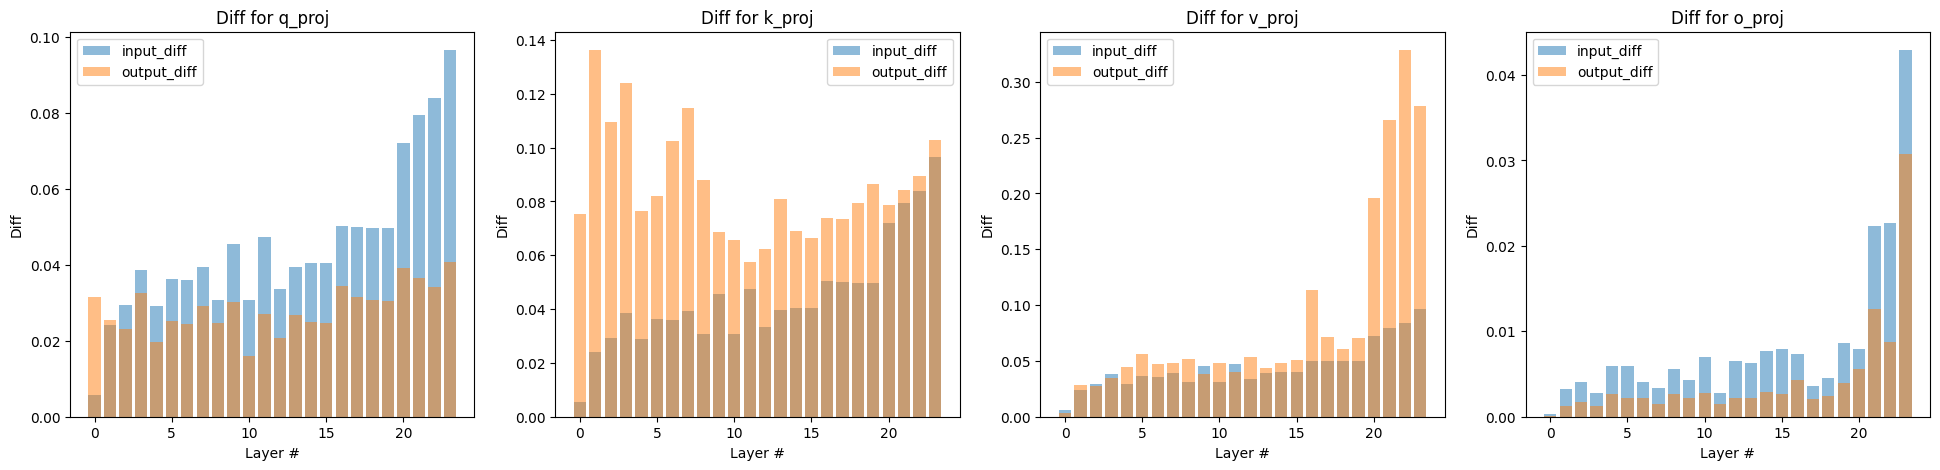

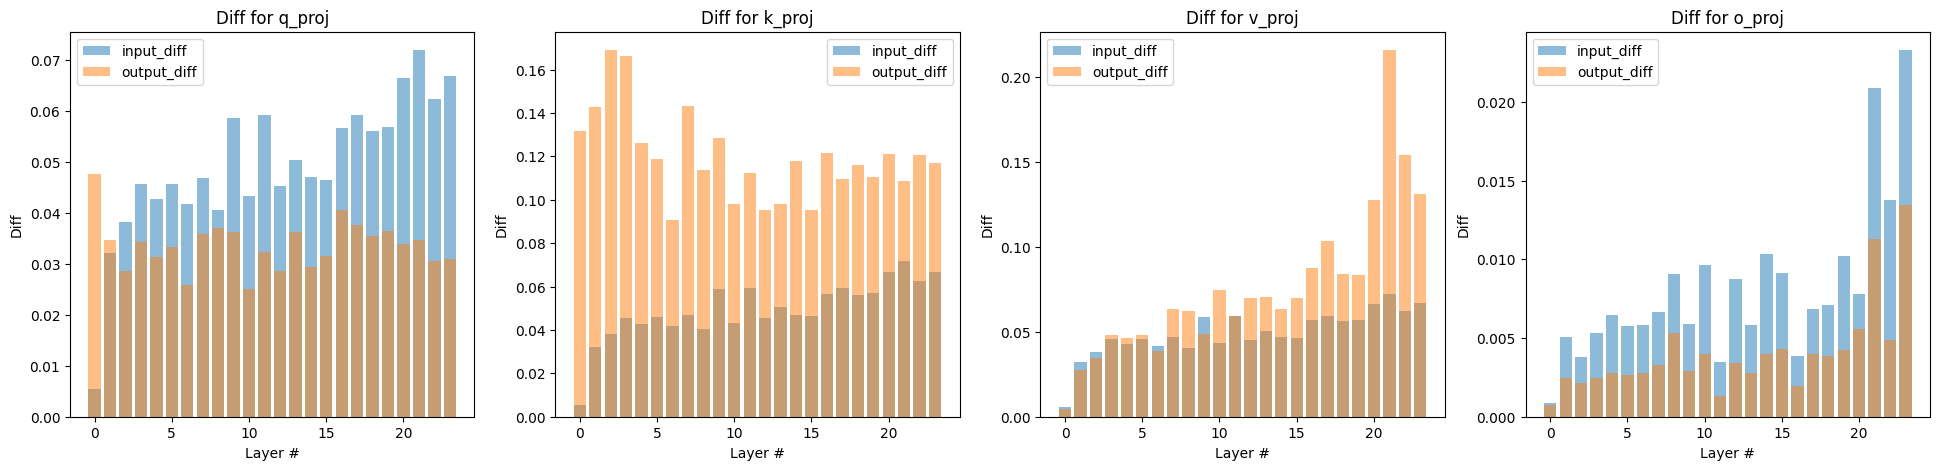

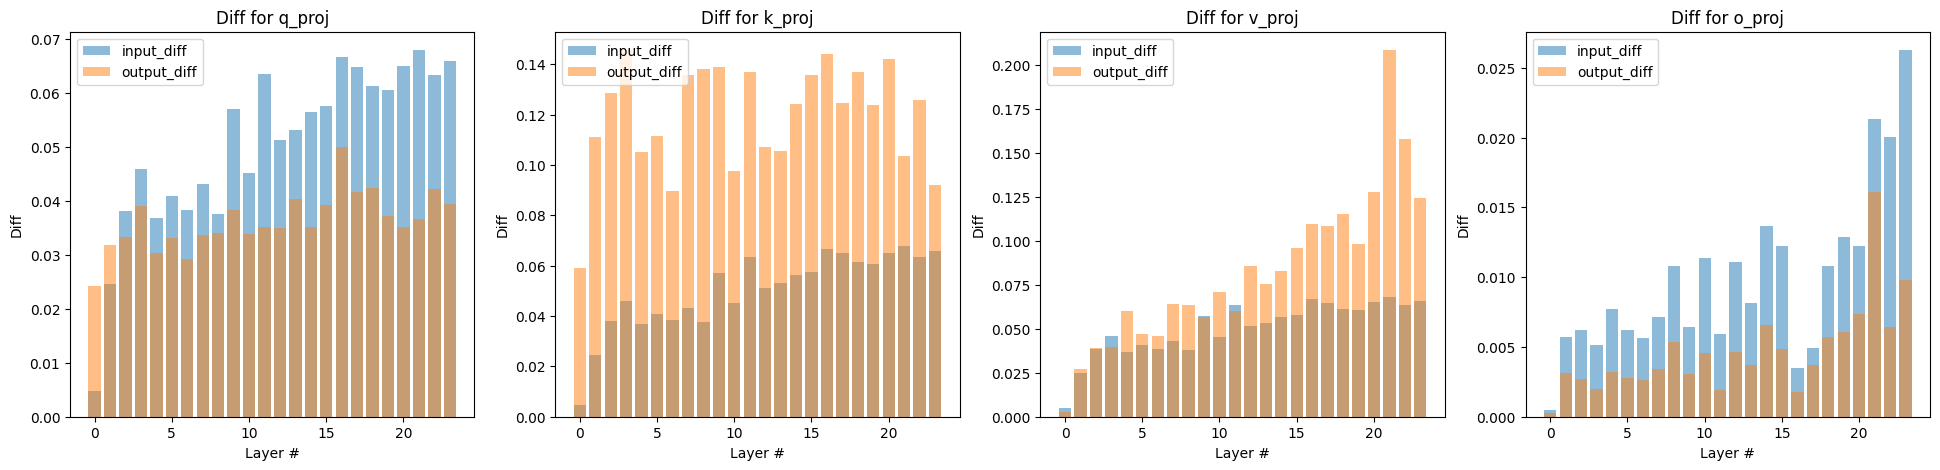

In [11]:
# 对比两个不同长度的prompt！！

# 对比“(a)英文单词strawberry中有几个字母r”与“({})英文单词strawberry中有几个字母r”
for pivot_at in range(1, 4):
    easy_compare_forward_hook_data(
        hook_data_path_1 = hook_data_path_formatter.format(68), 
        hook_data_path_2 = hook_data_path_formatter.format(17),
        forward_hook_module_names = forward_hook_module_names[:],
        figure_names = ["q_proj", "k_proj", "v_proj", "o_proj"],
        pivot_at = pivot_at,
    )
    # if input(prompts[i]): break

结论：

- q_proj明显表现出与k_proj和v_proj不同的性状，符合 Case 1 中的描述
- q和k的diff在中间几层发生了突变，v则到最后几个layer才发生突变（这是符合预期的，蝴蝶效应，当然应该越后面的层波动越大）
- v明显误差随层数的增加越来越大，q和k则不是那么明显，但也接近这种情况
- 在对比同一类型的prompt对时，可以发现不同layer上qkv投影矩阵的输入输出diff的情况是一致的：
  - 这说明同一类型扰动带来的影响是一致的
- 在对比不同类型的prompt对时，这种layer的qkv投影矩阵的输入输出的diff的情况是不一致的：
  - 这说明不同类型的扰动方法带来的影响是不一致的

## Case 3 - DeepSeek qkvo 0 ~ 27

测试了非常多相似的prompts，导出在`strawberry-X-2`下面，测试脚本如下：

模型DeepSeek-R1-Distill-Qwen-1.5B

配置与Case 2(`strawberry-X-1`)相同，但是这里多hook了一个`lm_head`，然后把`model.rotary_emb, model.norm`都扔了

In [12]:
forward_hook_module_names = \
    [f"model.embed_tokens", "lm_head"] + \
    [f"model.layers[{i}].self_attn.q_proj" for i in range(24)] + \
    [f"model.layers[{i}].self_attn.k_proj" for i in range(24)] + \
    [f"model.layers[{i}].self_attn.v_proj" for i in range(24)] + \
    [f"model.layers[{i}].self_attn.o_proj" for i in range(24)]
hook_data_path_formatter = "./results/strawberry-X-2/fhook+DeepSeek-R1-Distill-Qwen-1.5B+True-{}.pt"
prompts = \
    [f"""英文单词strawberry中有几个字母{i}？""" for i in string.ascii_letters] + \
    [f"""({i})英文单词strawberry中有几个字母{i}？""" for i in range(1, 10)] + \
    [f"""({i})英文单词strawberry中有几个字母{i}？""" for i in string.ascii_letters] + \
    [
        """（ii）英文单词strawberry中有几个字母r？""",
        """（iii）英文单词strawberry中有几个字母r？""",
        """（iv）英文单词strawberry中有几个字母r？""",
        """（vi）英文单词strawberry中有几个字母r？""",
        """（vii）英文单词strawberry中有几个字母r？""",
        """（viii）英文单词strawberry中有几个字母r？""",
        """（ix）英文单词strawberry中有几个字母r？""",
    ]
for i, prompt in enumerate(prompts):
    print(i, prompt)

0 英文单词strawberry中有几个字母a？
1 英文单词strawberry中有几个字母b？
2 英文单词strawberry中有几个字母c？
3 英文单词strawberry中有几个字母d？
4 英文单词strawberry中有几个字母e？
5 英文单词strawberry中有几个字母f？
6 英文单词strawberry中有几个字母g？
7 英文单词strawberry中有几个字母h？
8 英文单词strawberry中有几个字母i？
9 英文单词strawberry中有几个字母j？
10 英文单词strawberry中有几个字母k？
11 英文单词strawberry中有几个字母l？
12 英文单词strawberry中有几个字母m？
13 英文单词strawberry中有几个字母n？
14 英文单词strawberry中有几个字母o？
15 英文单词strawberry中有几个字母p？
16 英文单词strawberry中有几个字母q？
17 英文单词strawberry中有几个字母r？
18 英文单词strawberry中有几个字母s？
19 英文单词strawberry中有几个字母t？
20 英文单词strawberry中有几个字母u？
21 英文单词strawberry中有几个字母v？
22 英文单词strawberry中有几个字母w？
23 英文单词strawberry中有几个字母x？
24 英文单词strawberry中有几个字母y？
25 英文单词strawberry中有几个字母z？
26 英文单词strawberry中有几个字母A？
27 英文单词strawberry中有几个字母B？
28 英文单词strawberry中有几个字母C？
29 英文单词strawberry中有几个字母D？
30 英文单词strawberry中有几个字母E？
31 英文单词strawberry中有几个字母F？
32 英文单词strawberry中有几个字母G？
33 英文单词strawberry中有几个字母H？
34 英文单词strawberry中有几个字母I？
35 英文单词strawberry中有几个字母J？
36 英文单词strawberry中有几个字母K？
37 英文单词strawberry中有几个字母L？
38 英文单词strawberry中有几个字

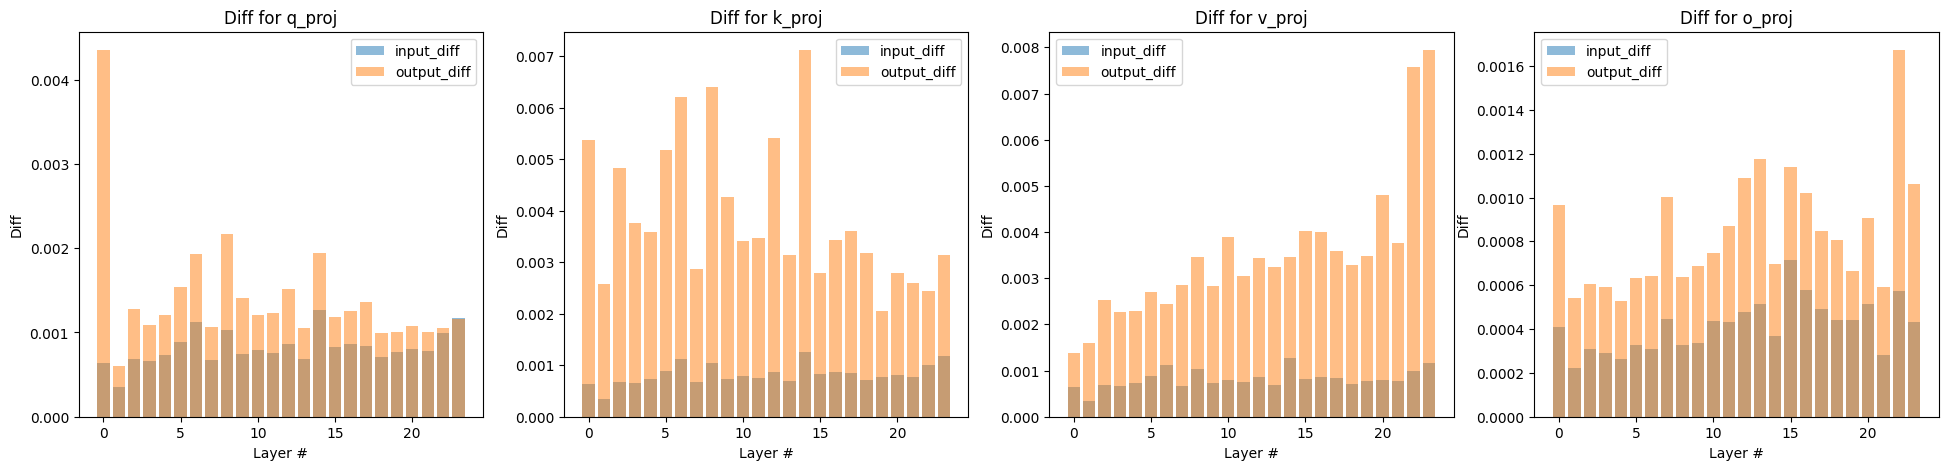

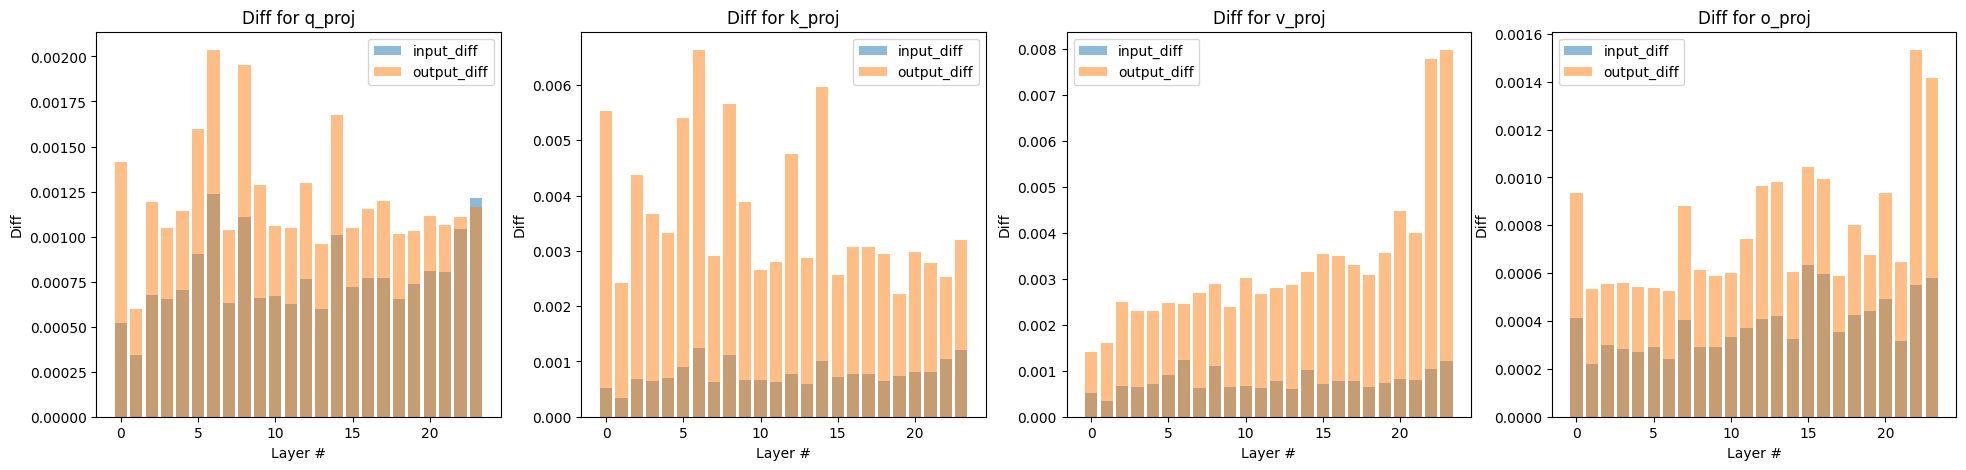

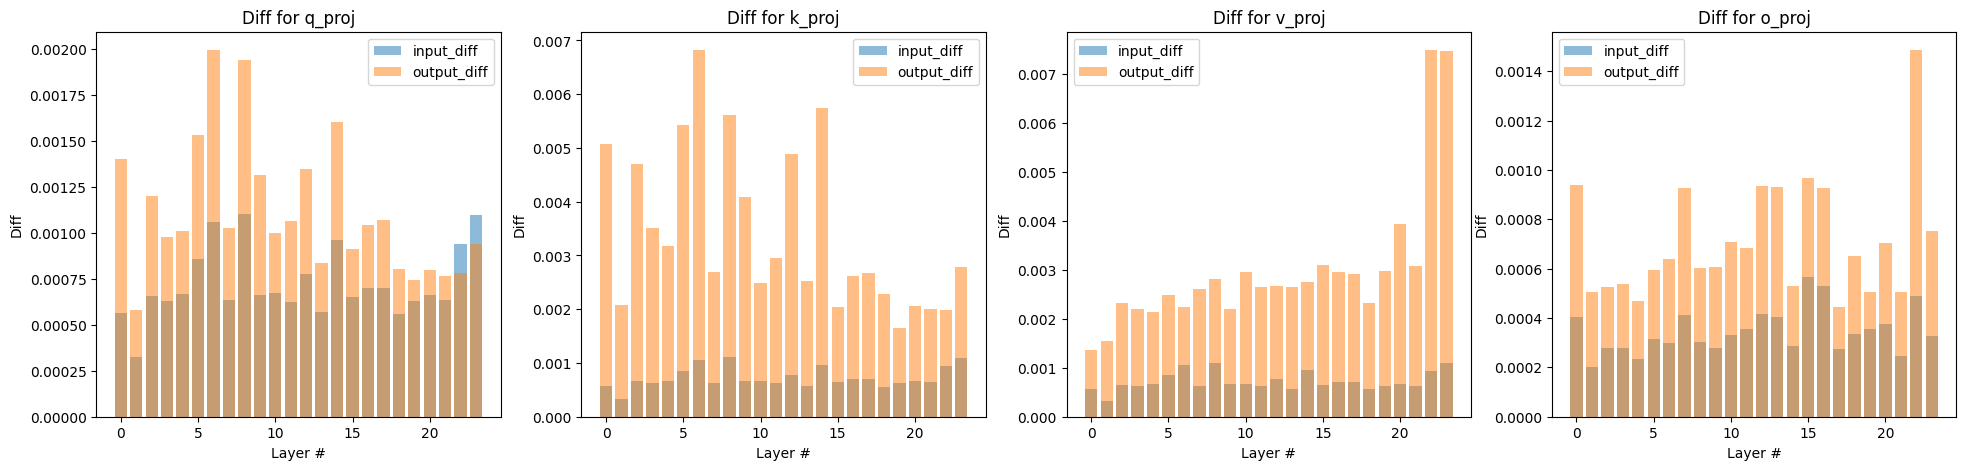

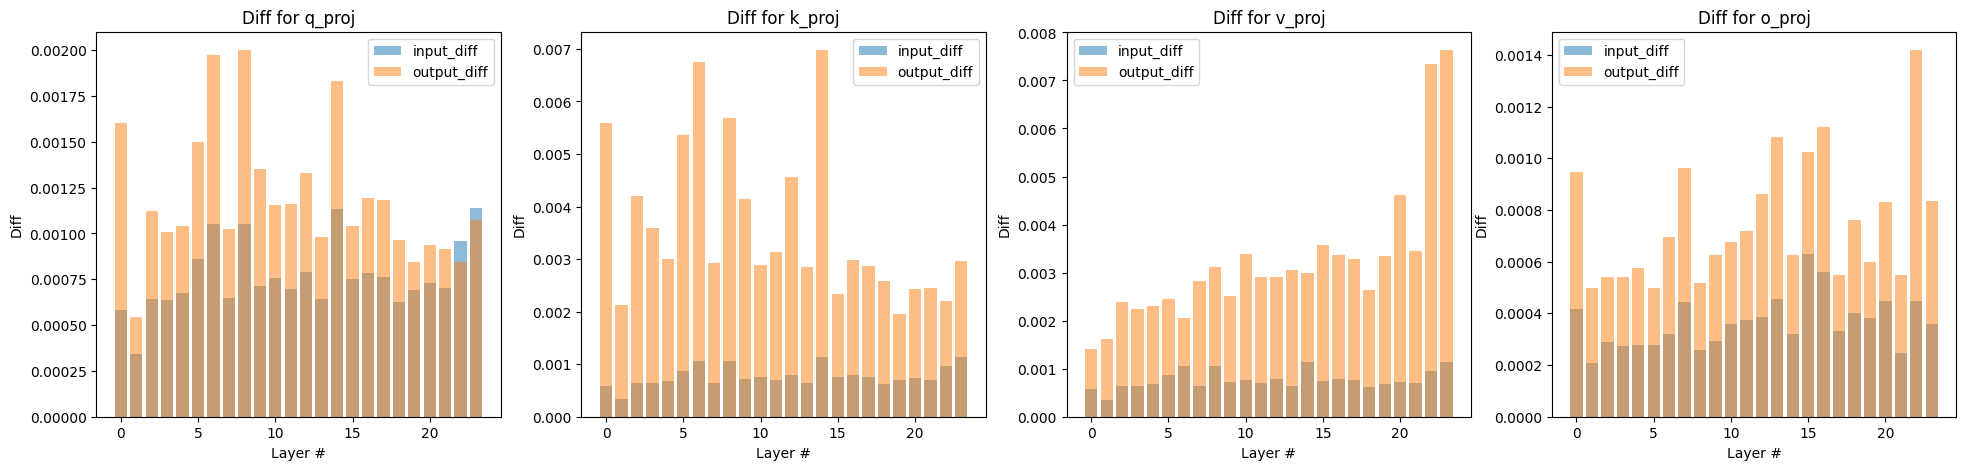

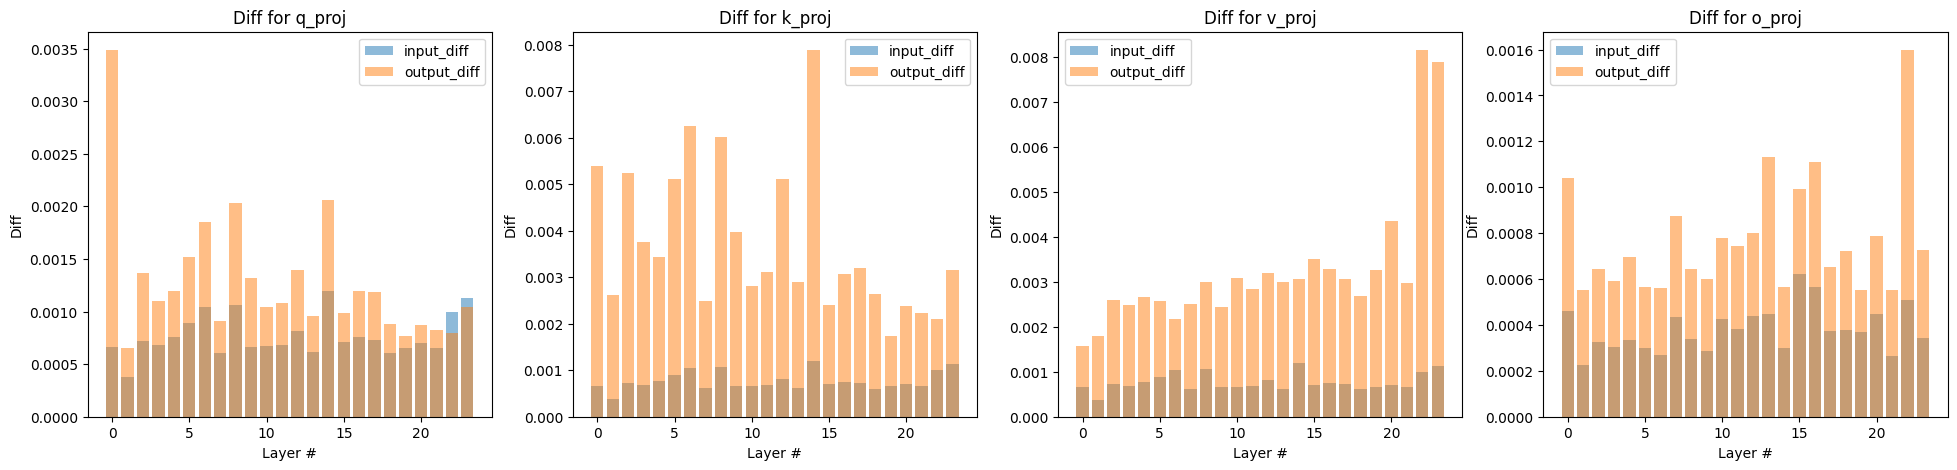

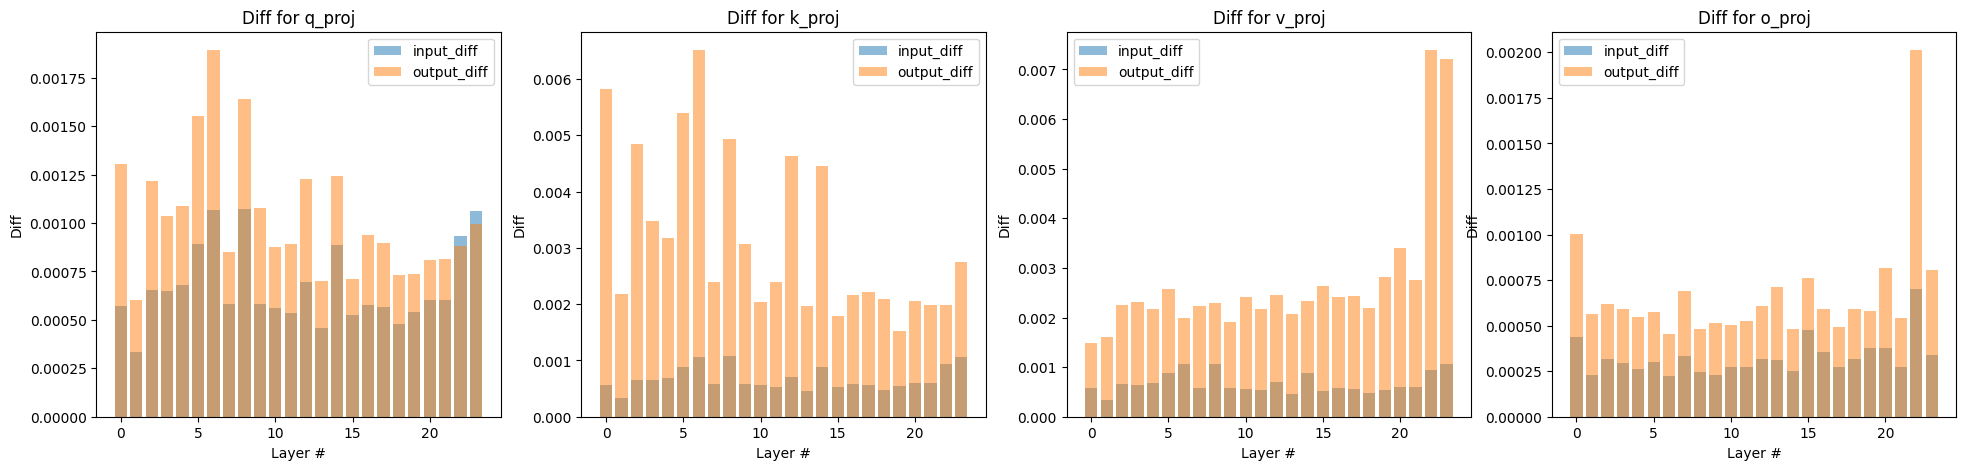

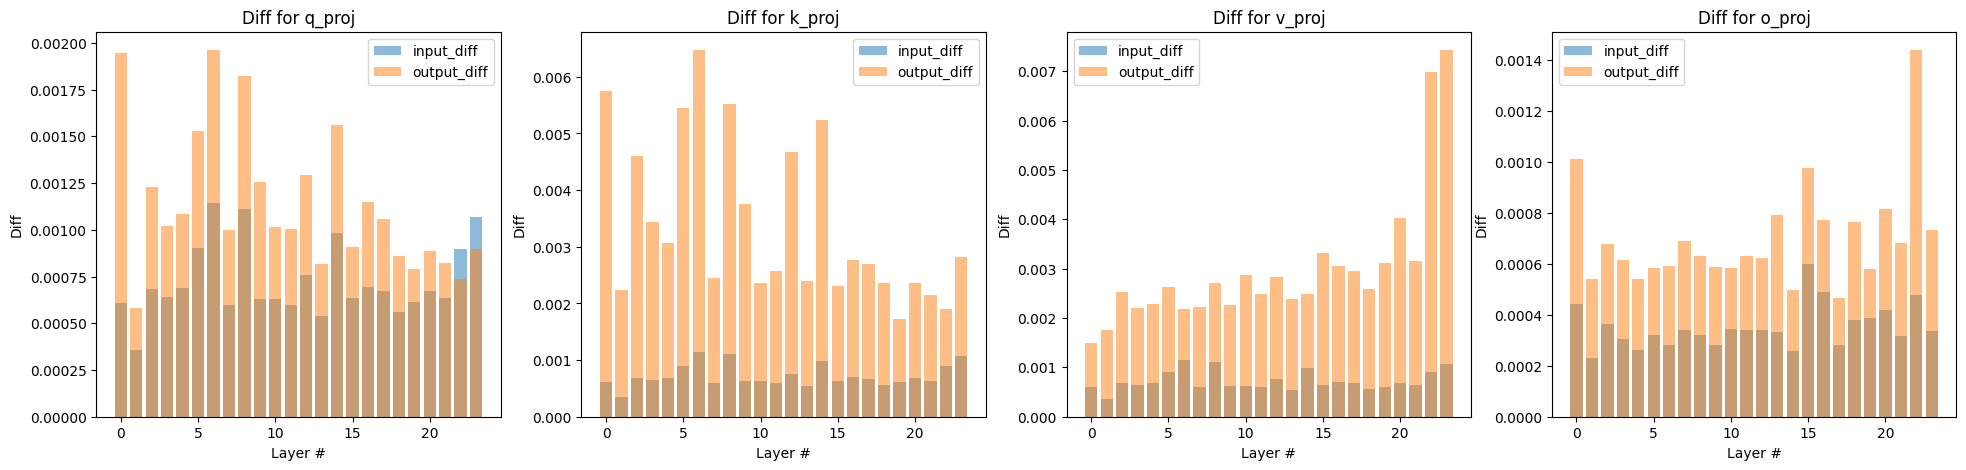

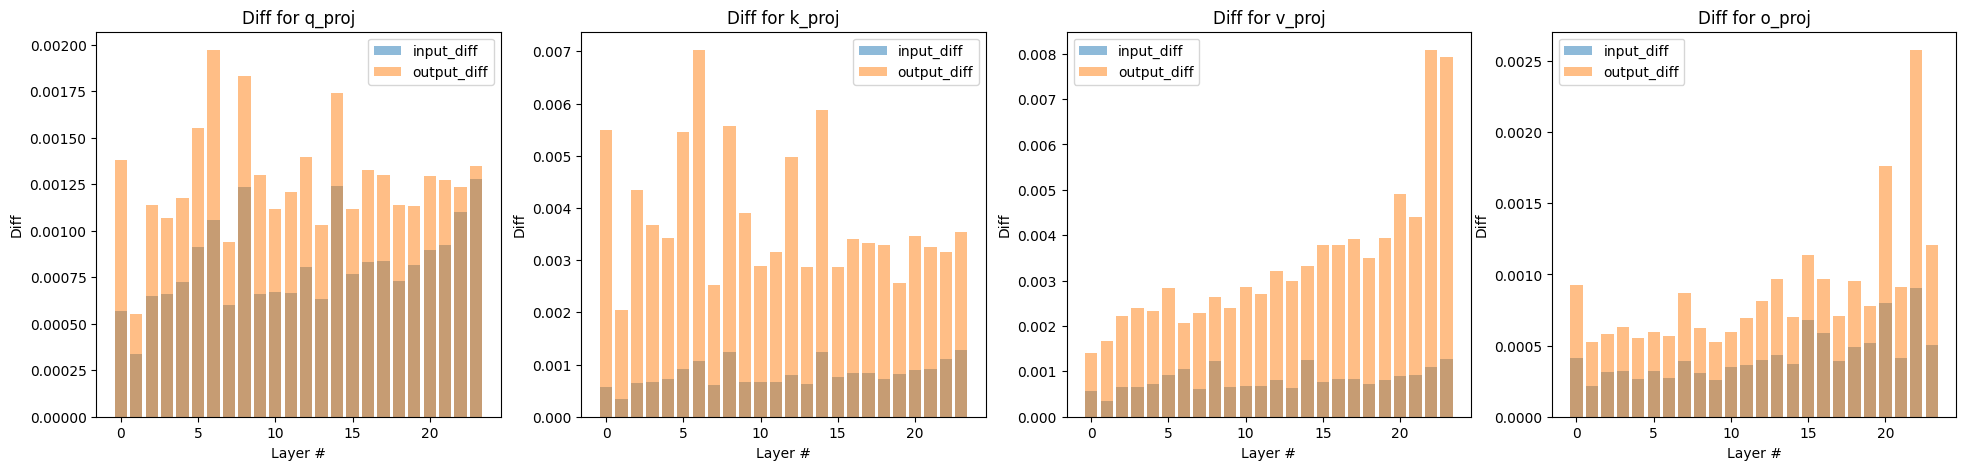

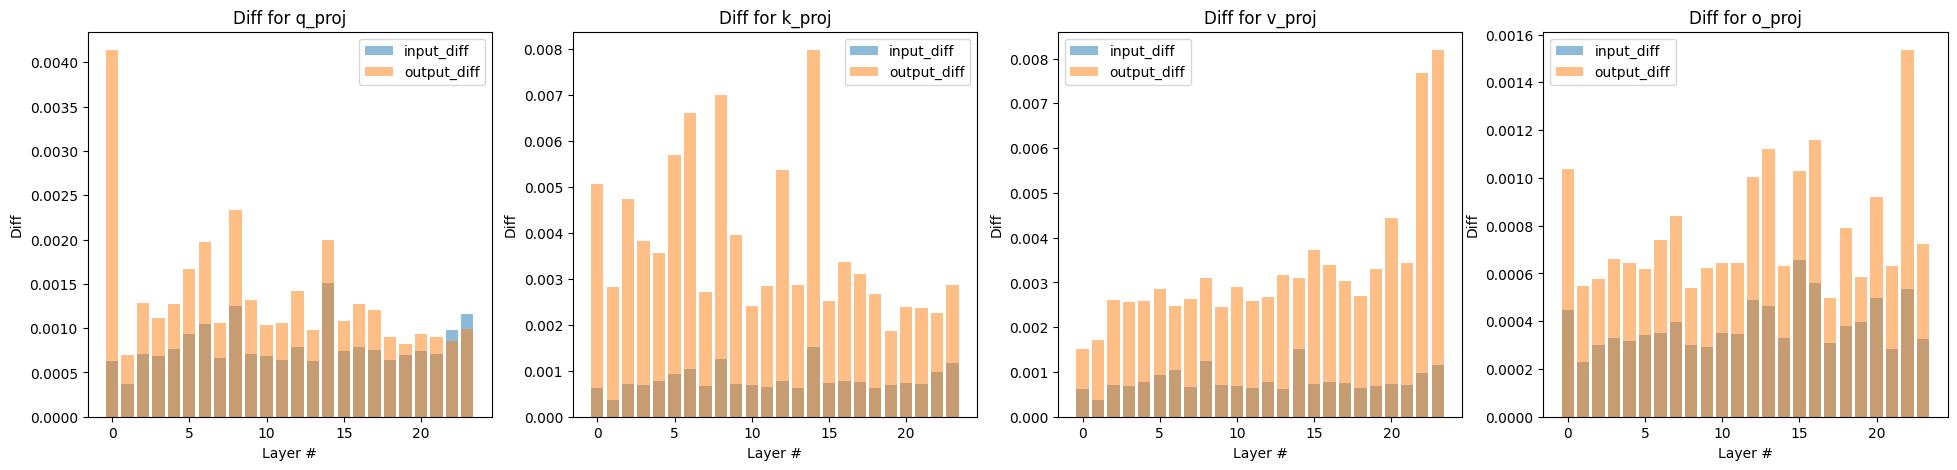

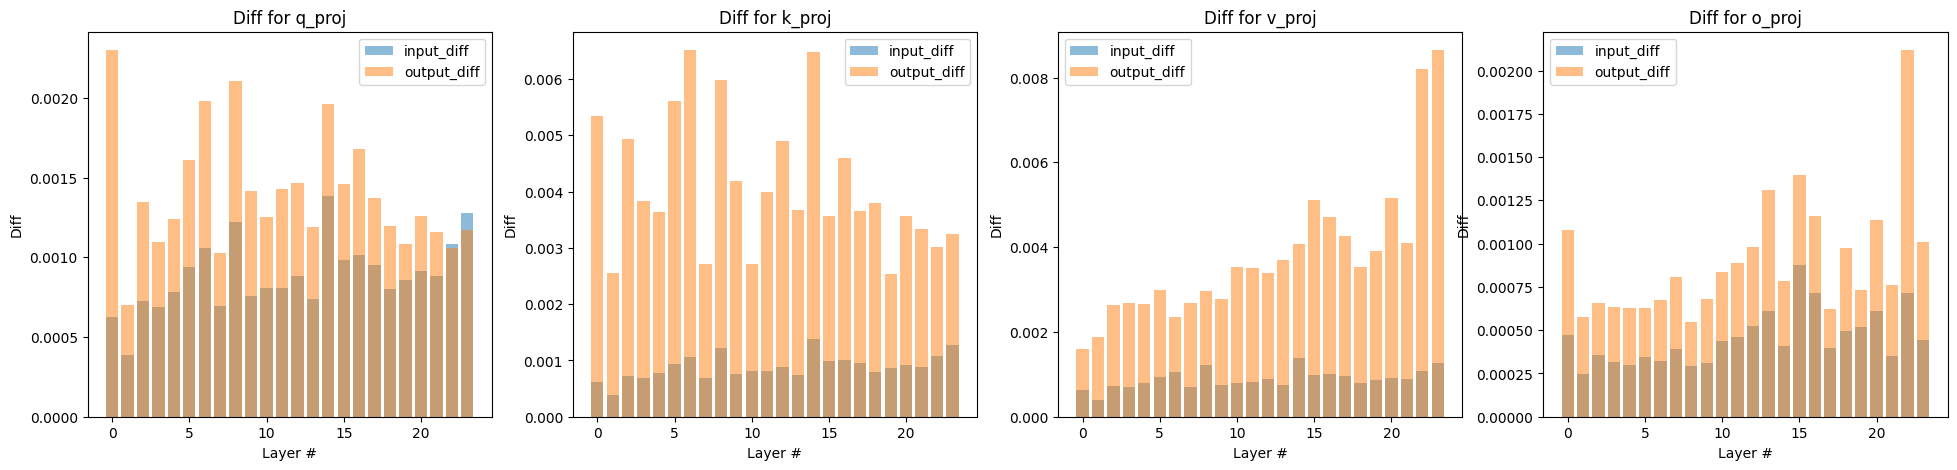

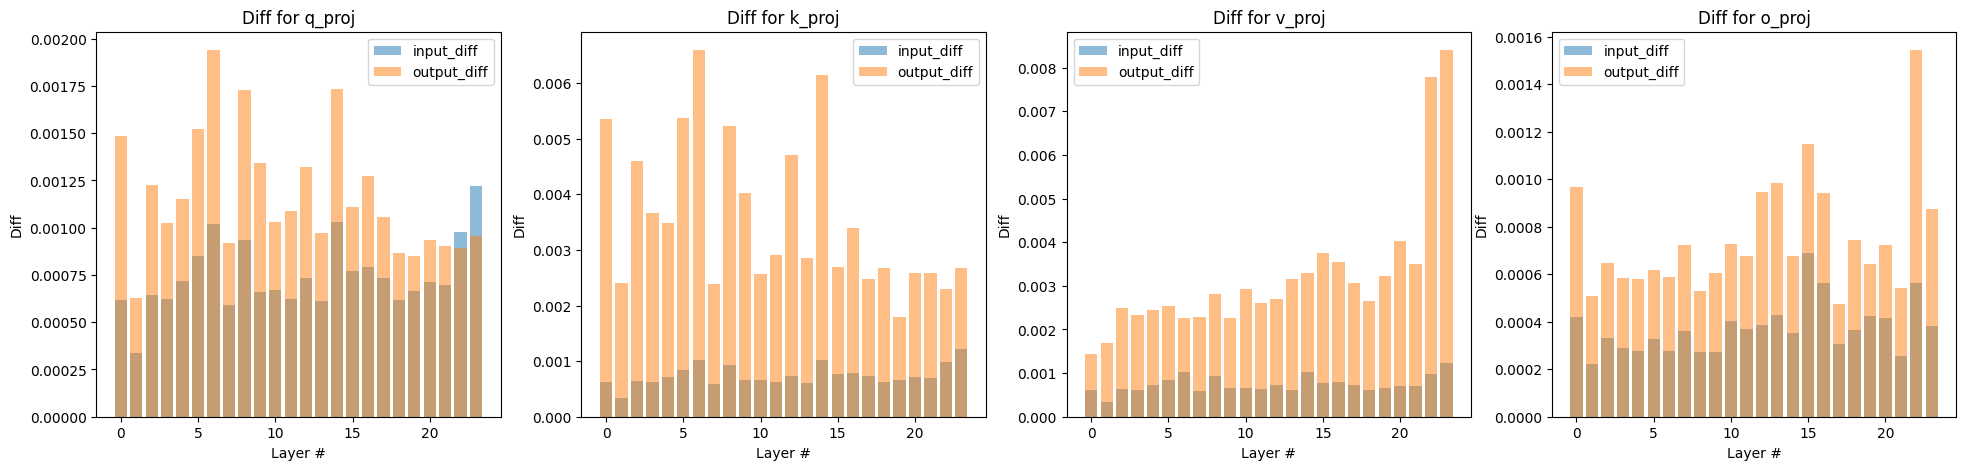

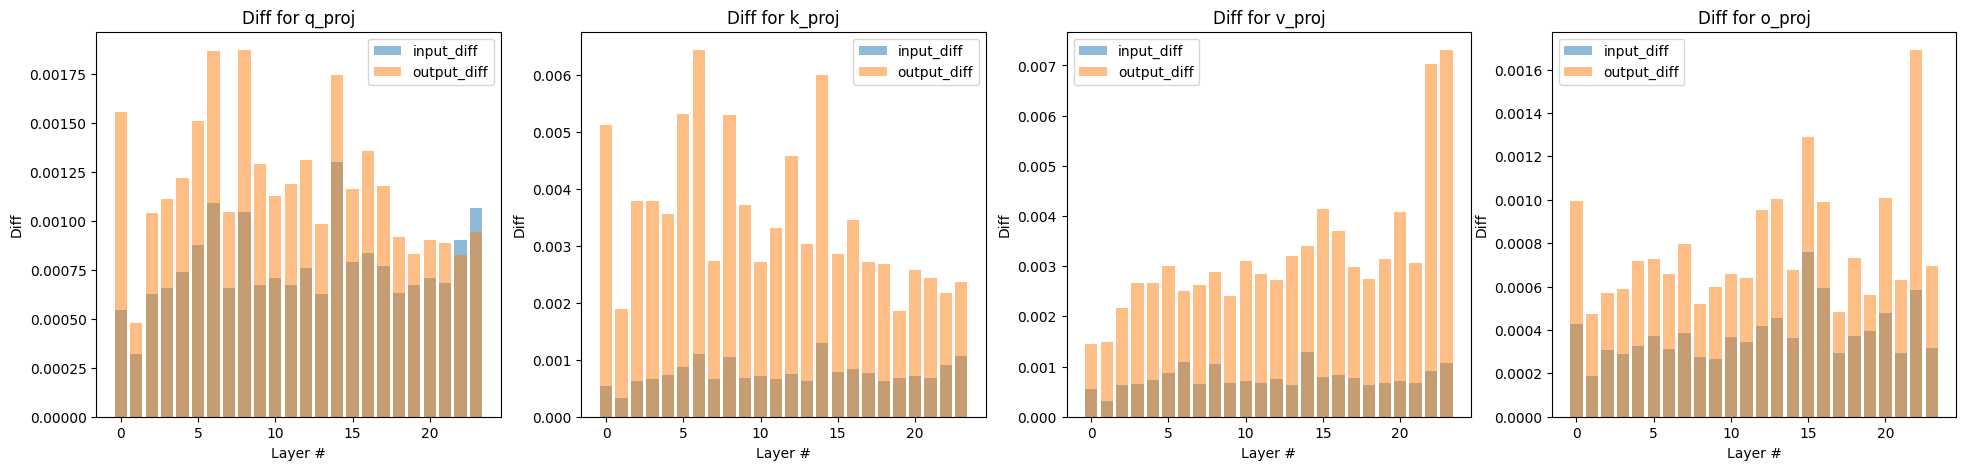

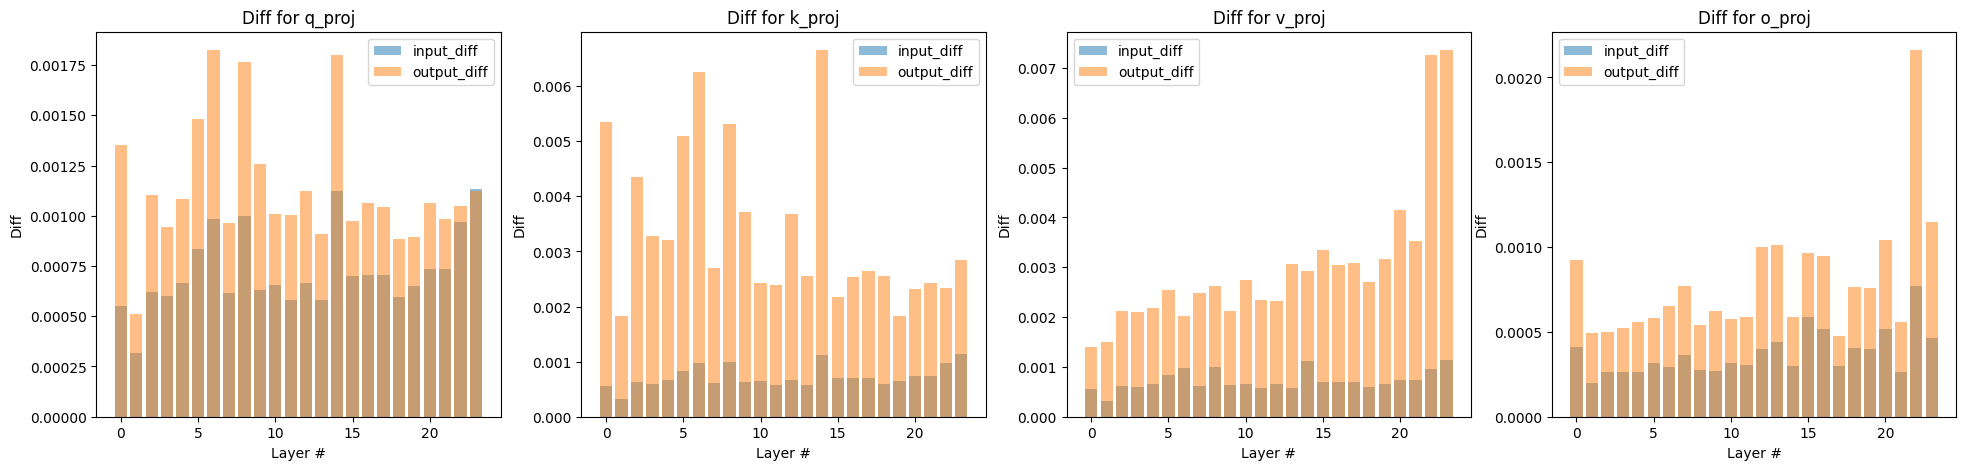

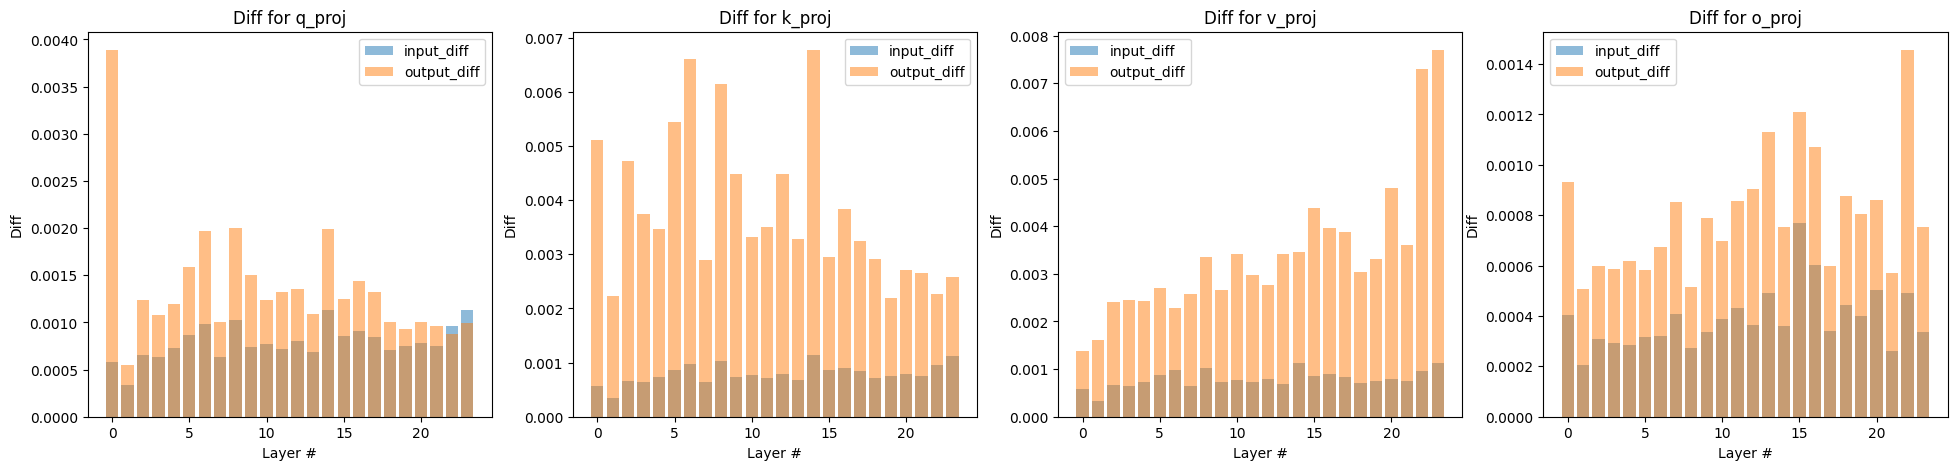

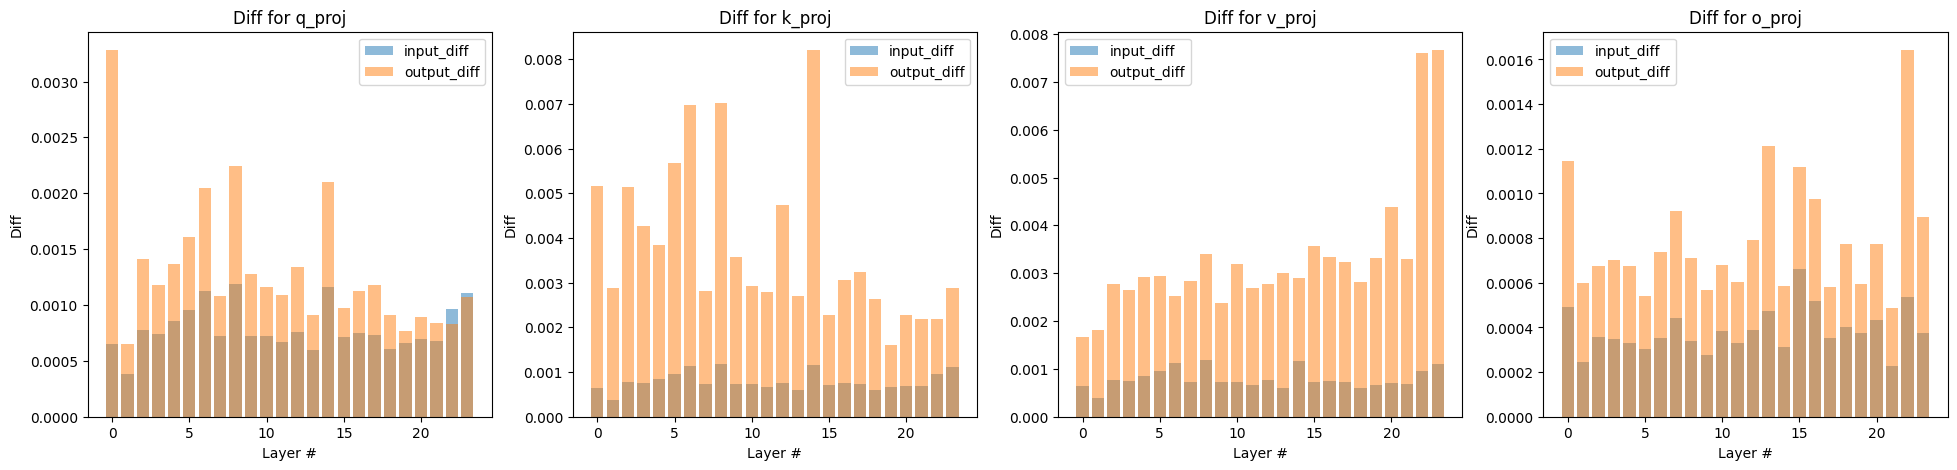

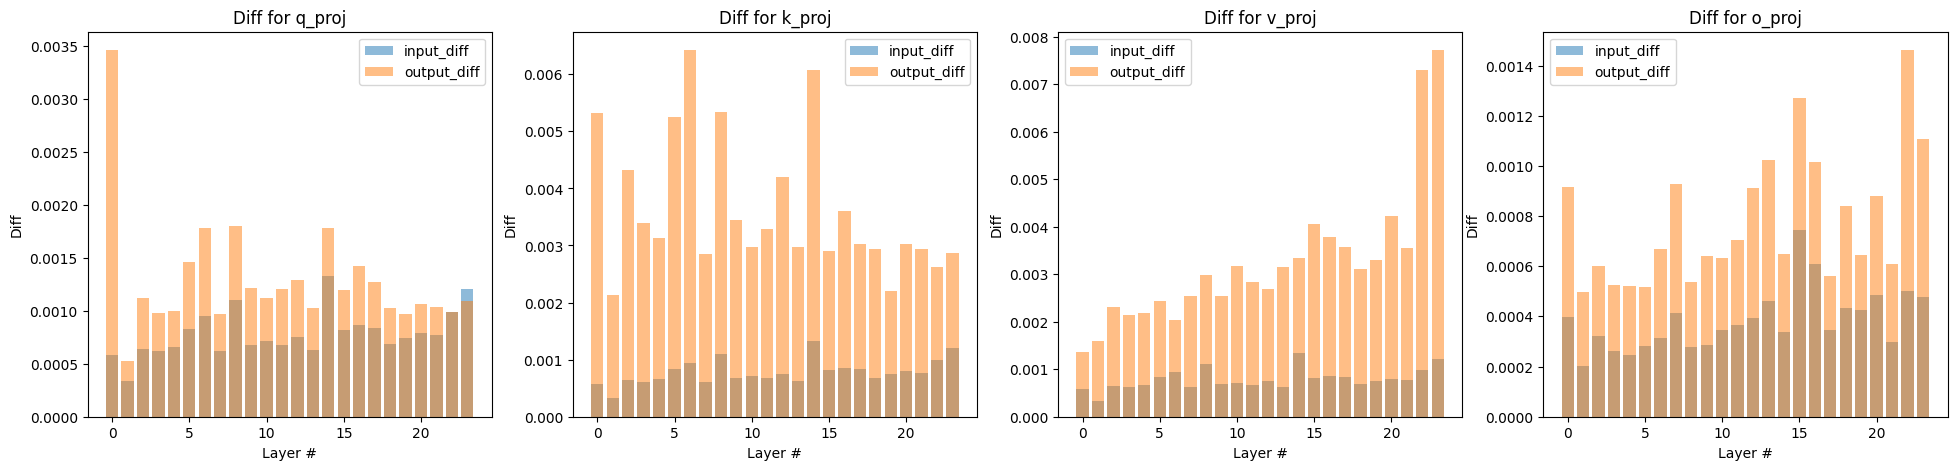

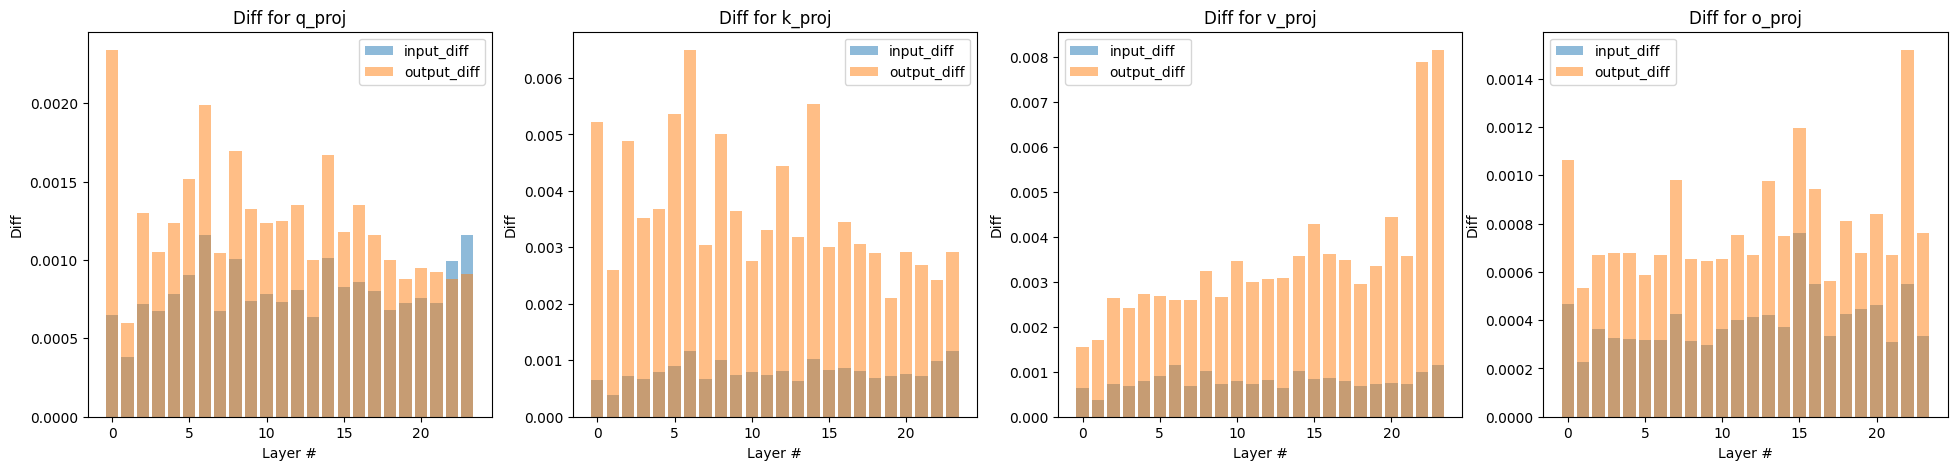

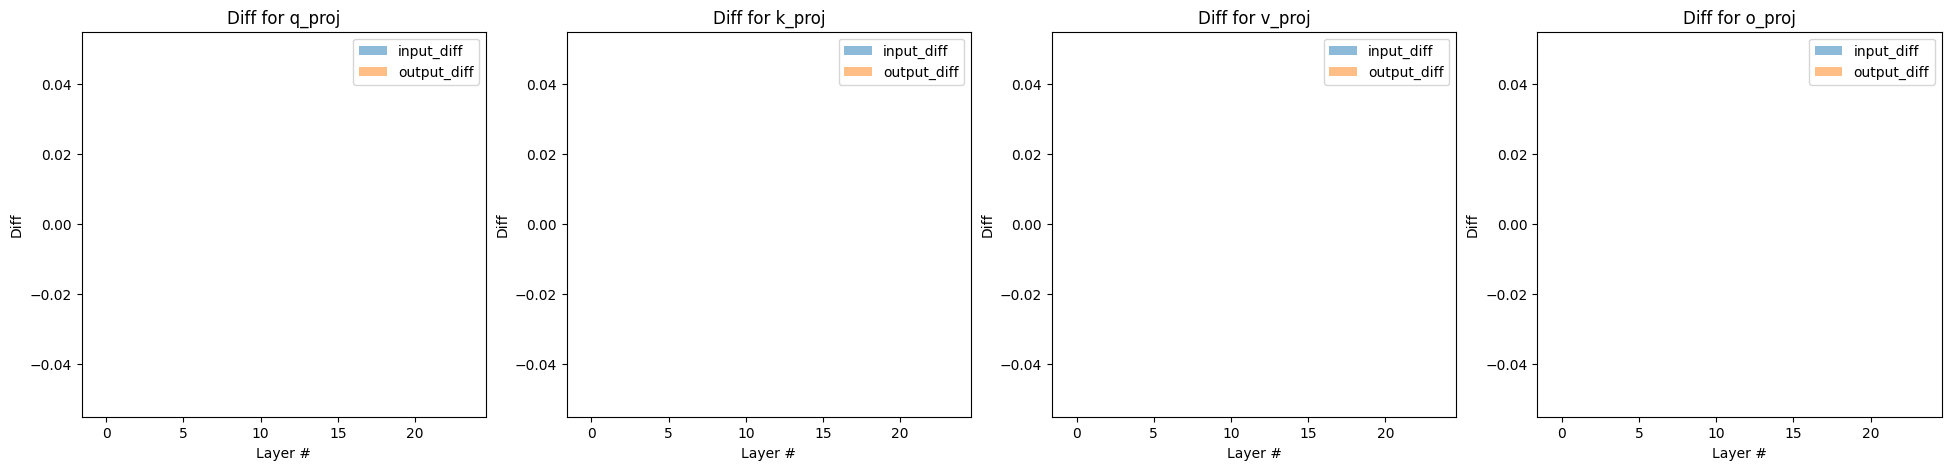

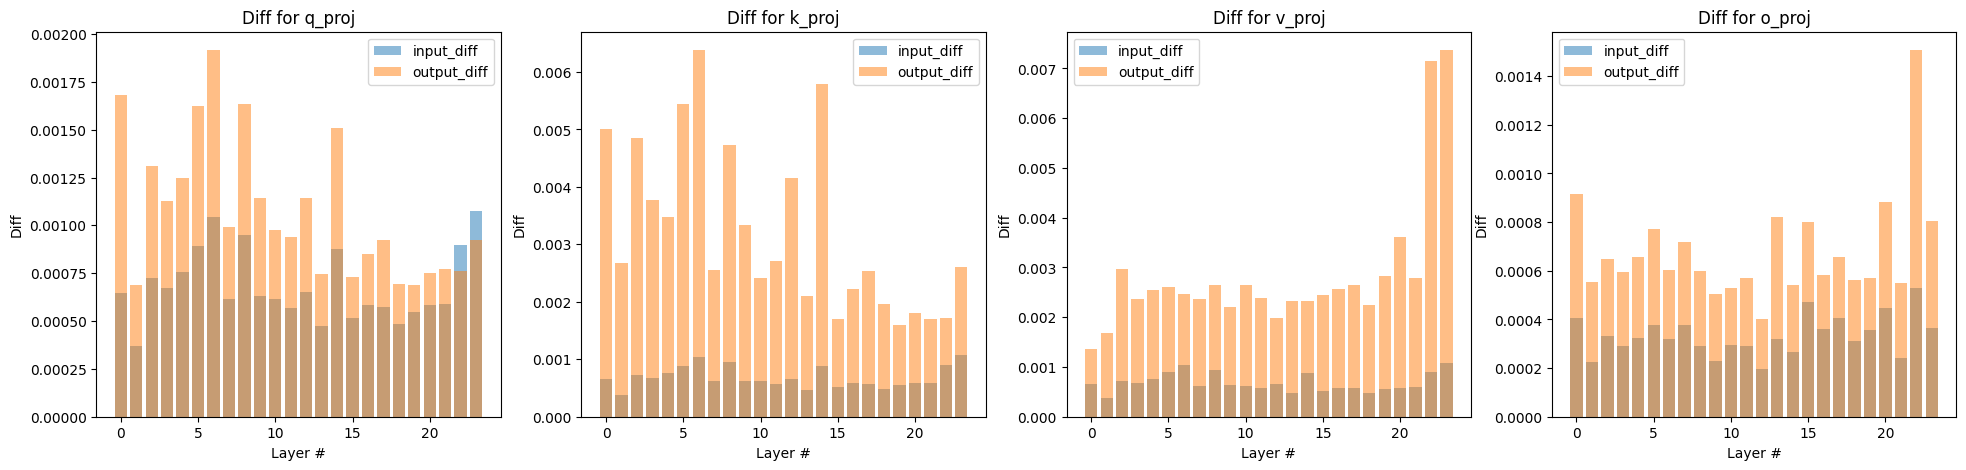

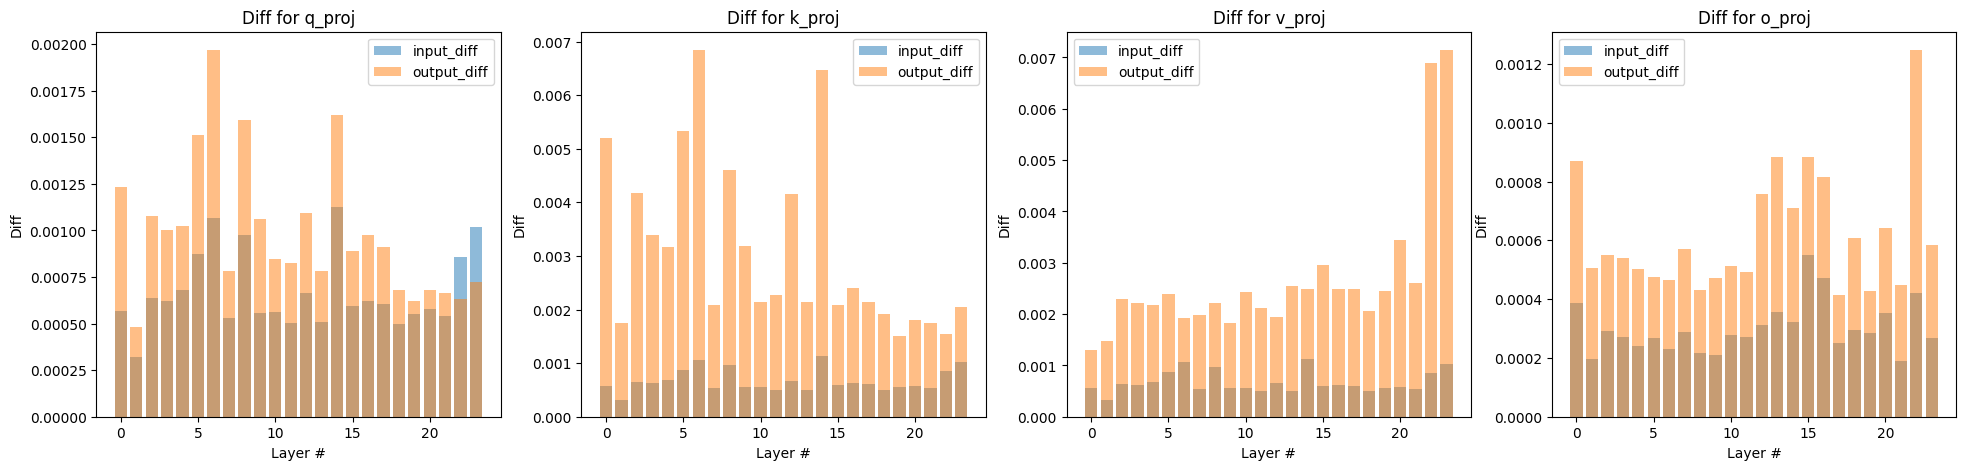

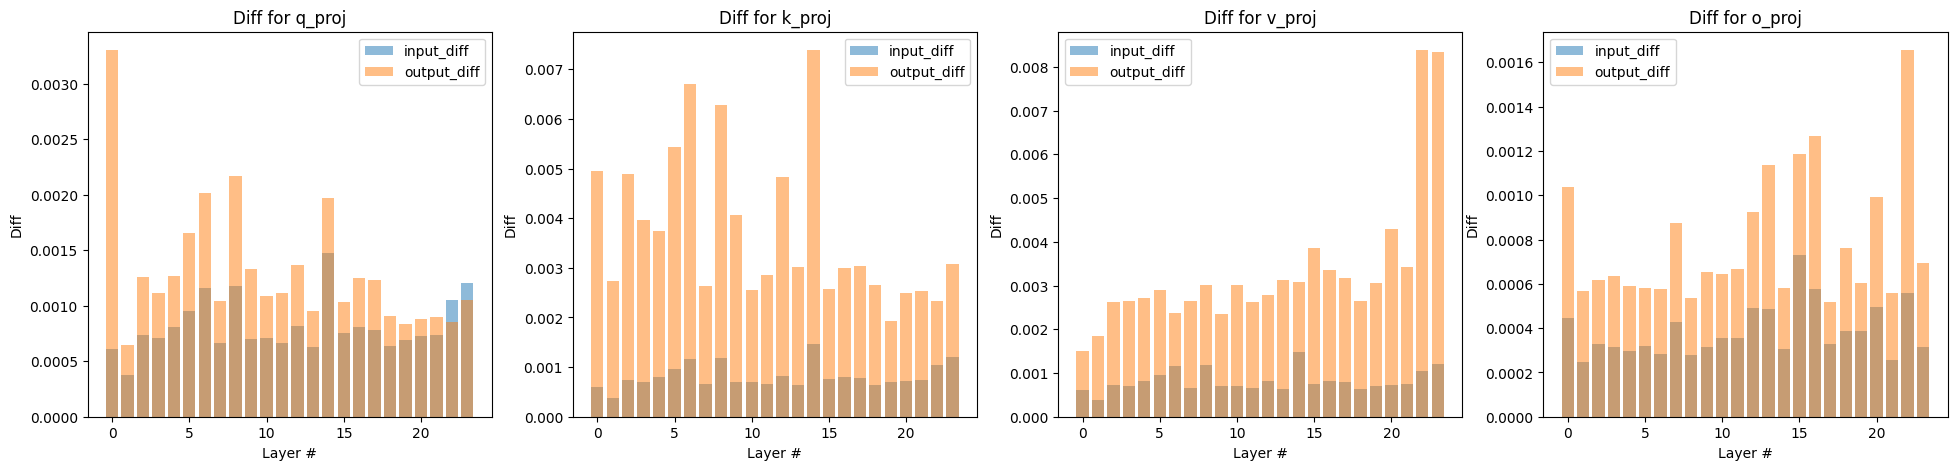

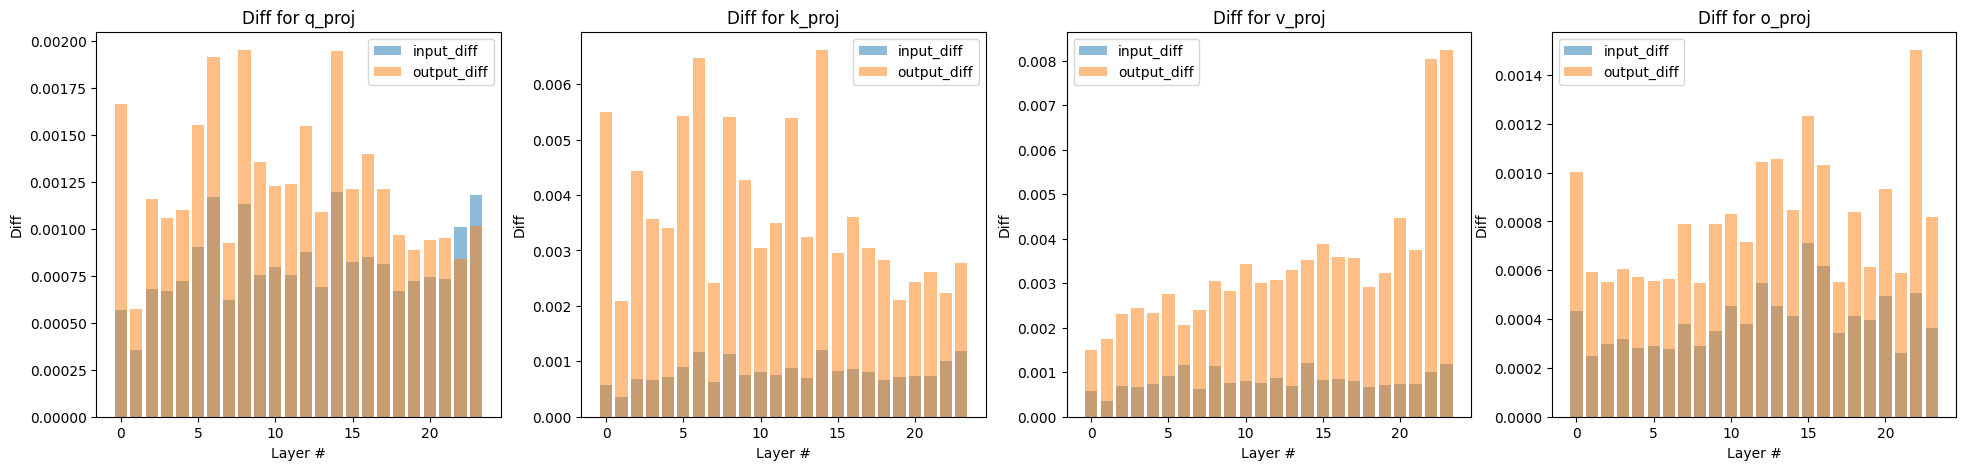

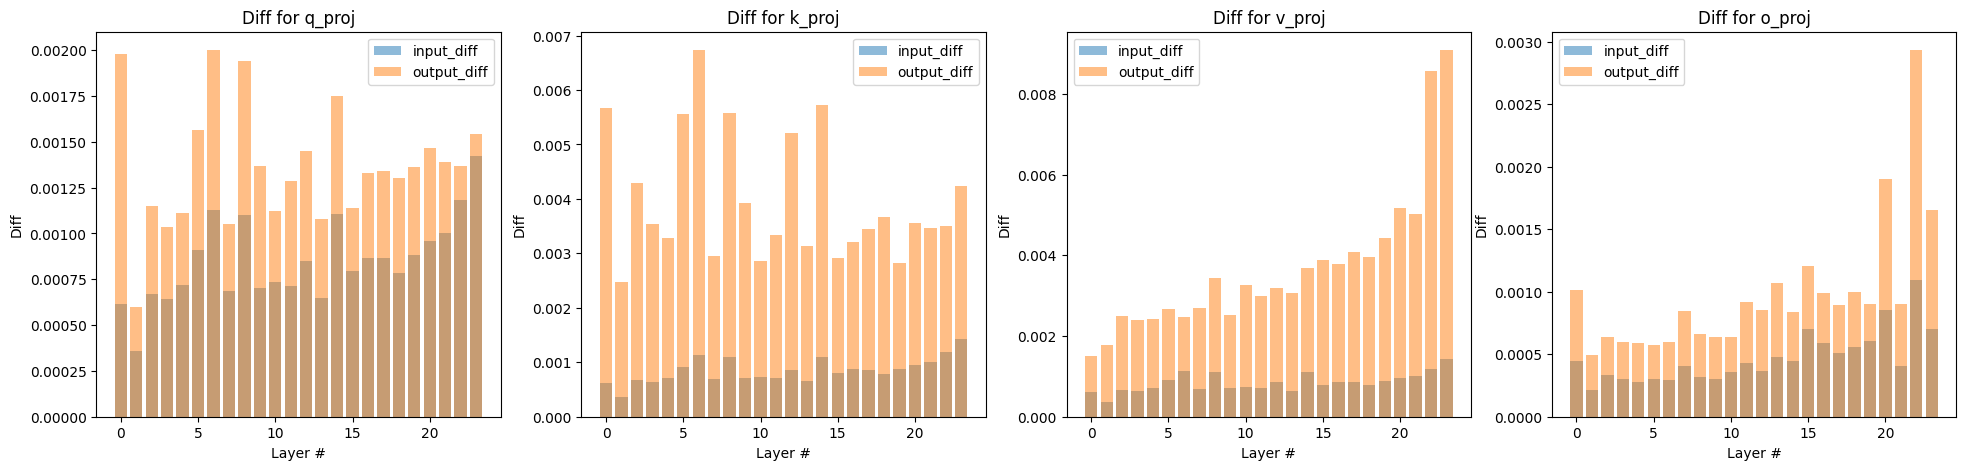

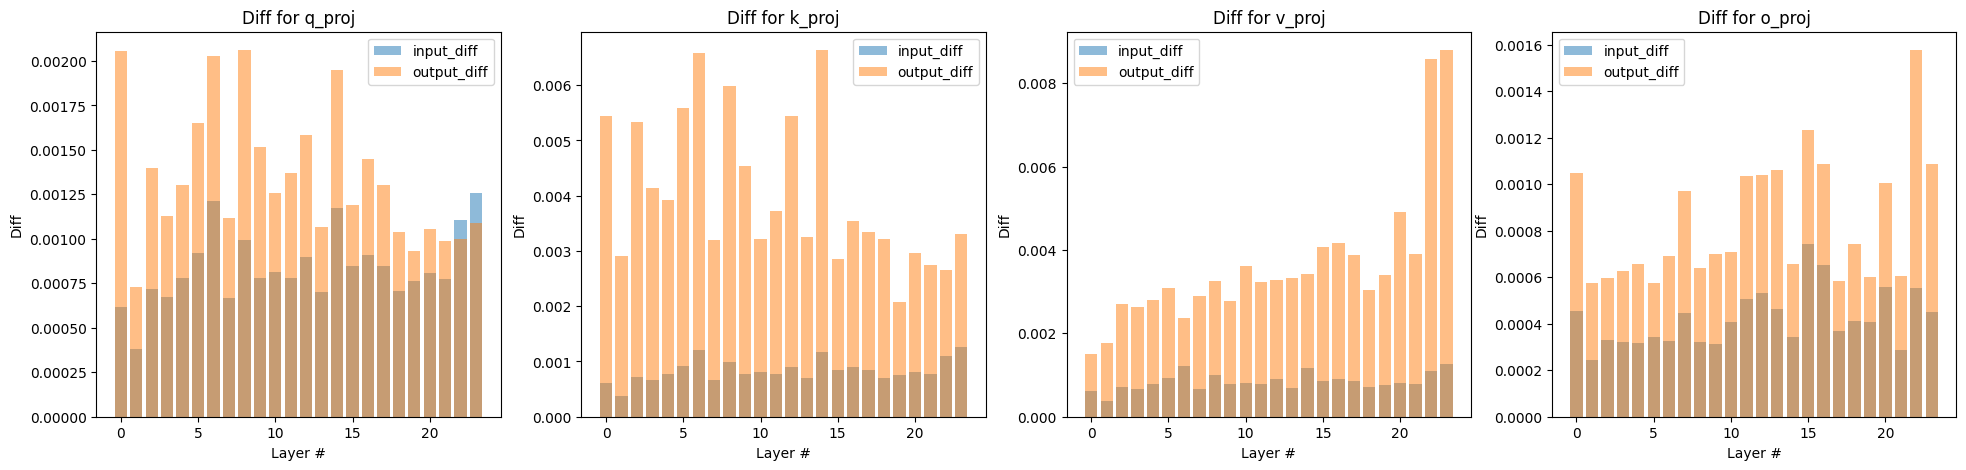

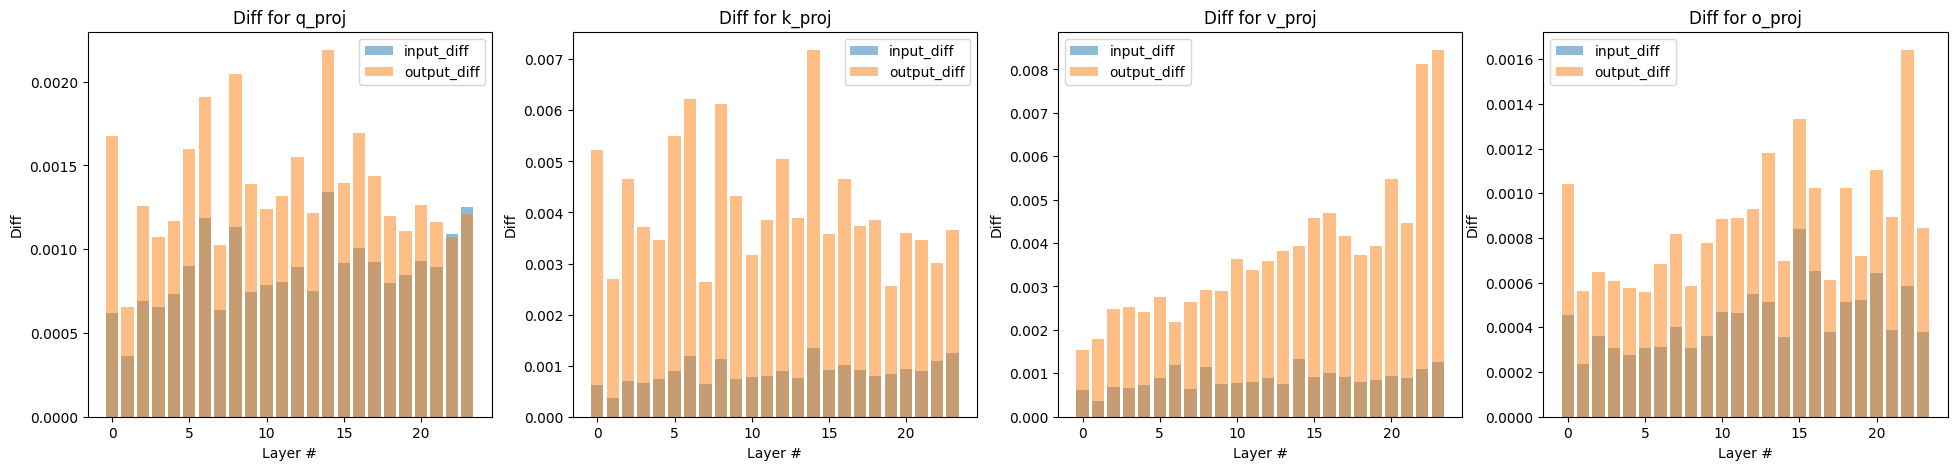

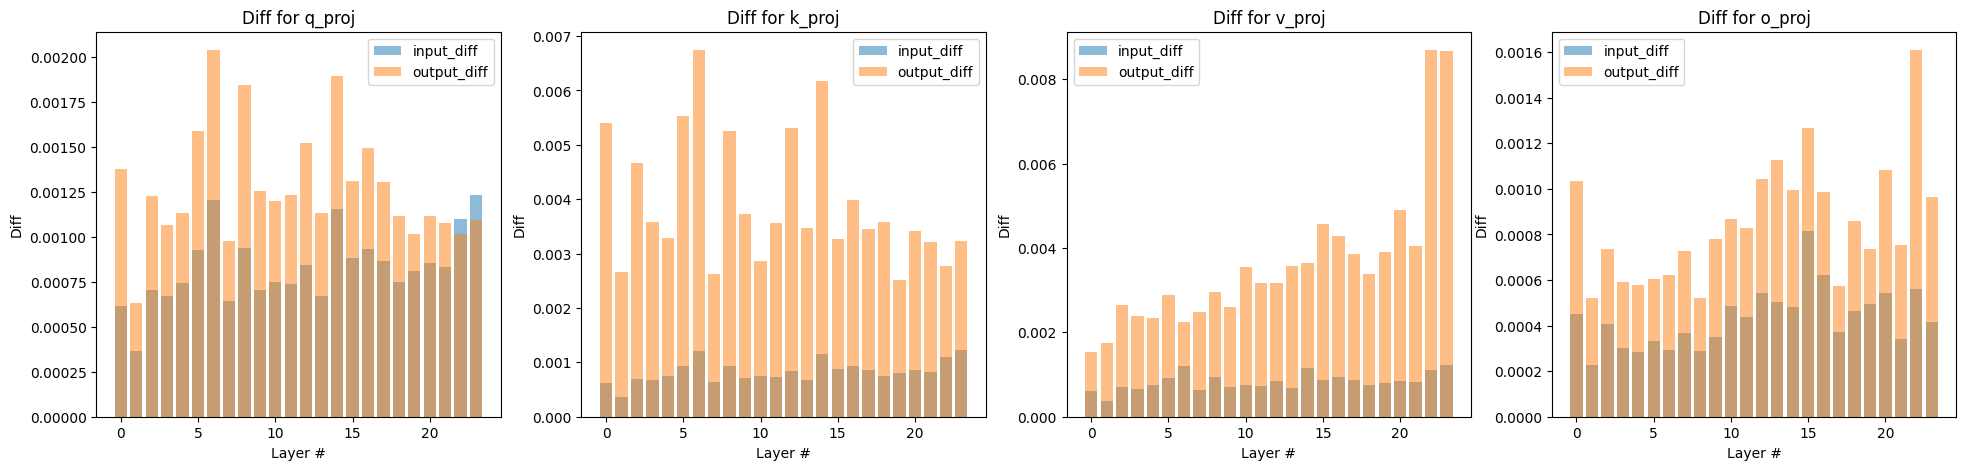

In [13]:
# 对比“英文单词strawberry中有几个字母r”与“英文单词strawberry中有几个字母{x}”
for i in range(26):
    easy_compare_forward_hook_data(
        hook_data_path_1 = hook_data_path_formatter.format(17), 
        hook_data_path_2 = hook_data_path_formatter.format(i),
        forward_hook_module_names = forward_hook_module_names[:],
        figure_names = ["q_proj", "k_proj", "v_proj", "o_proj"],
    )
    # if input(prompts[i]): break

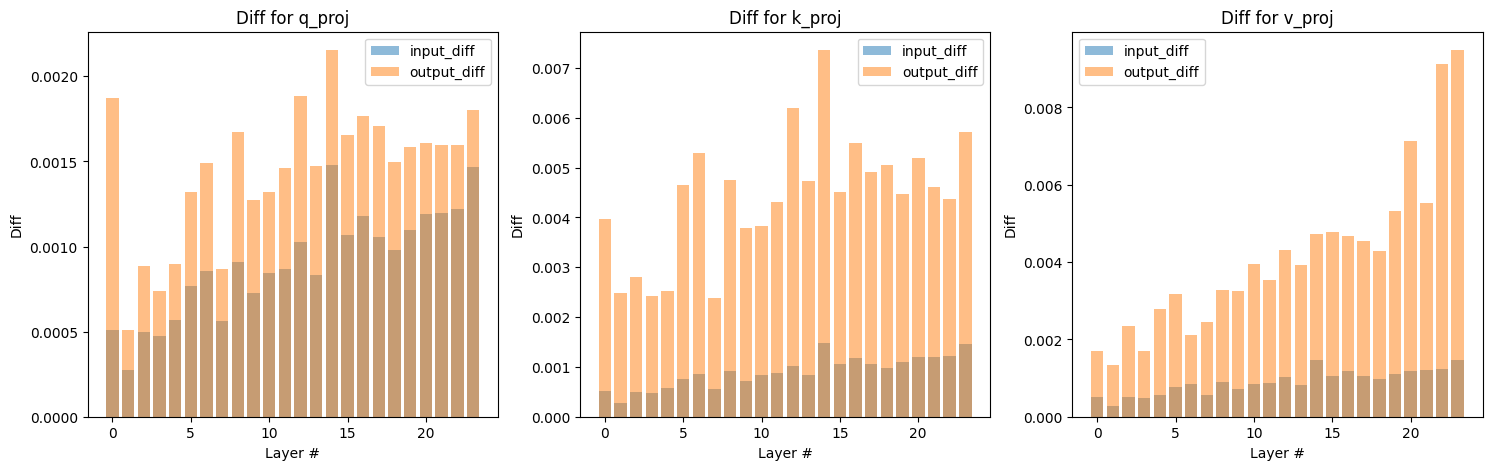

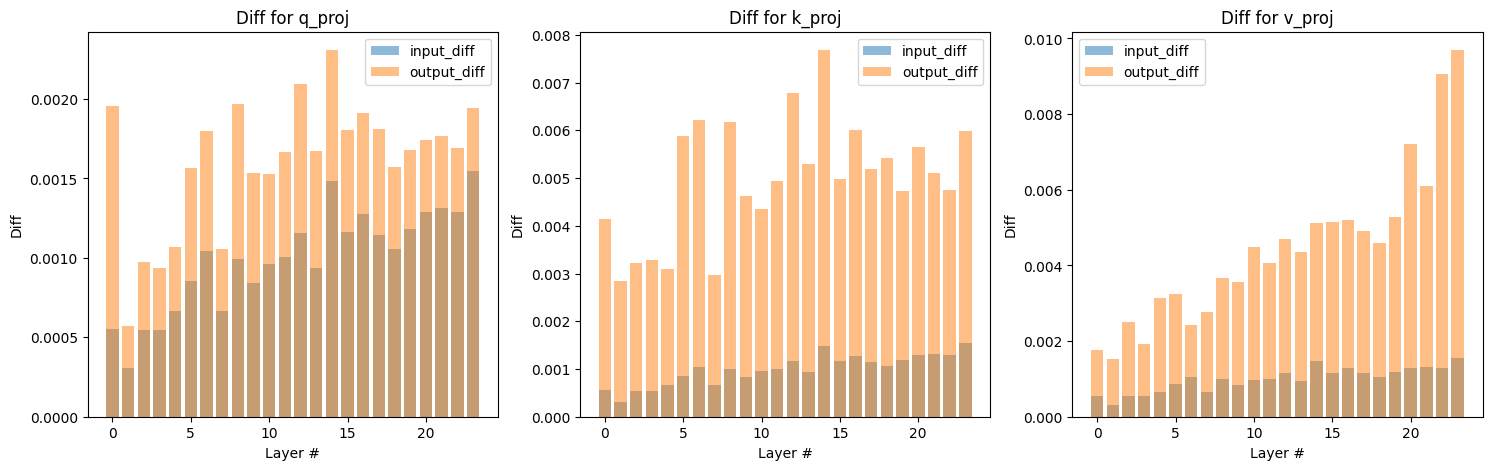

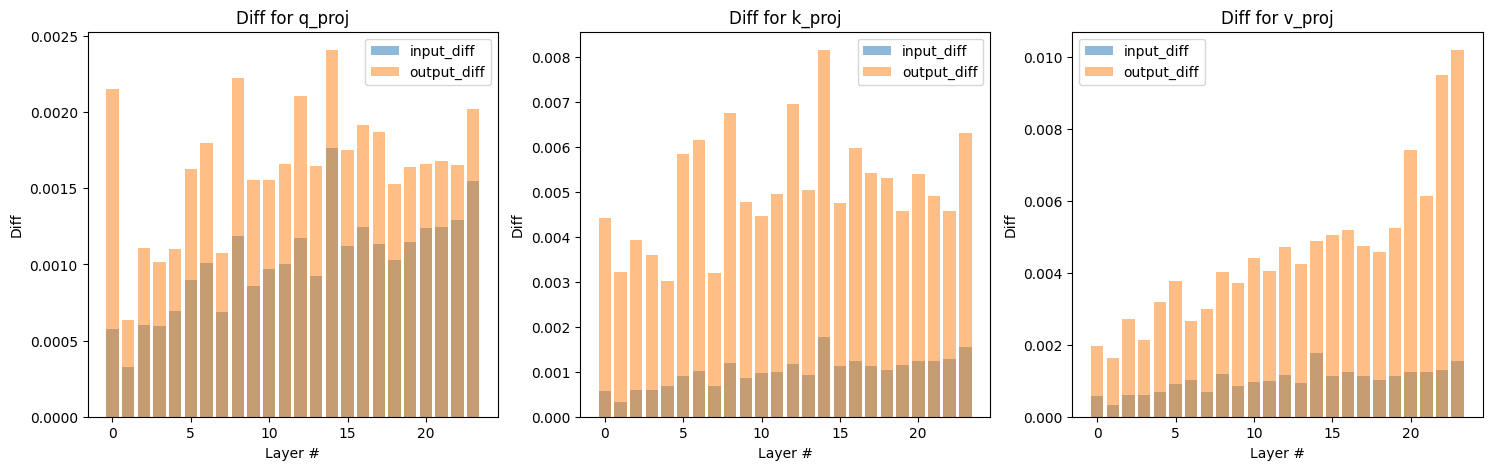

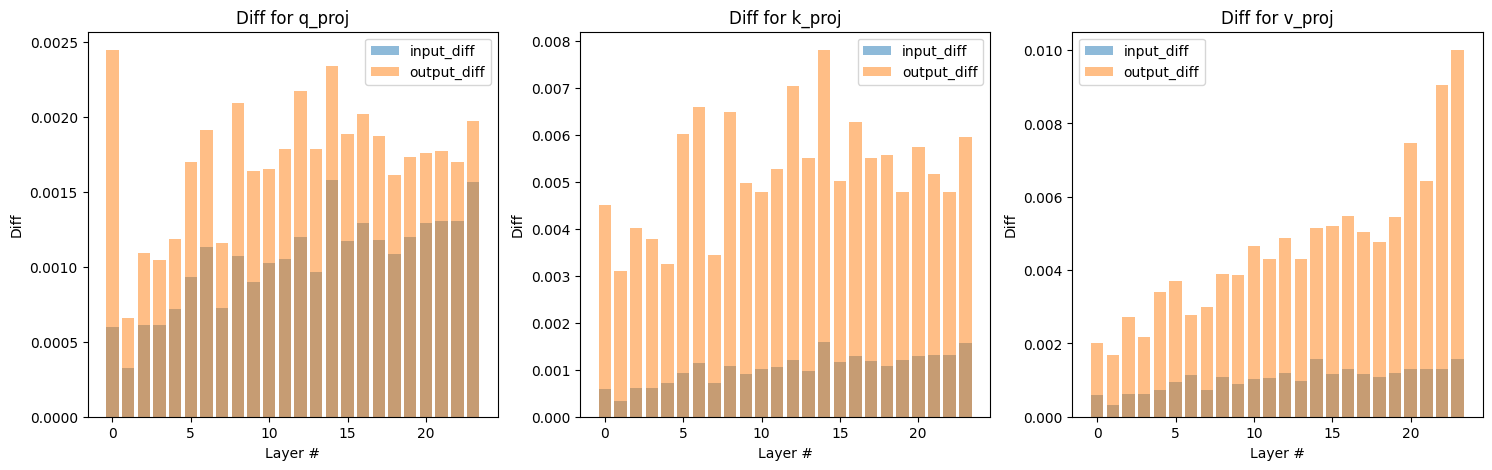

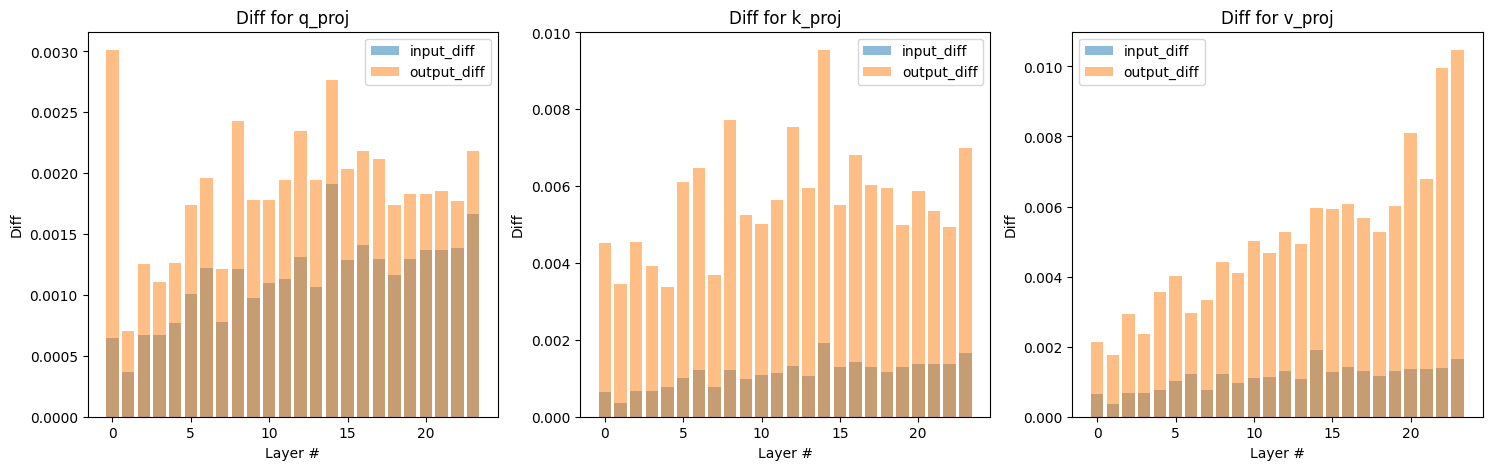

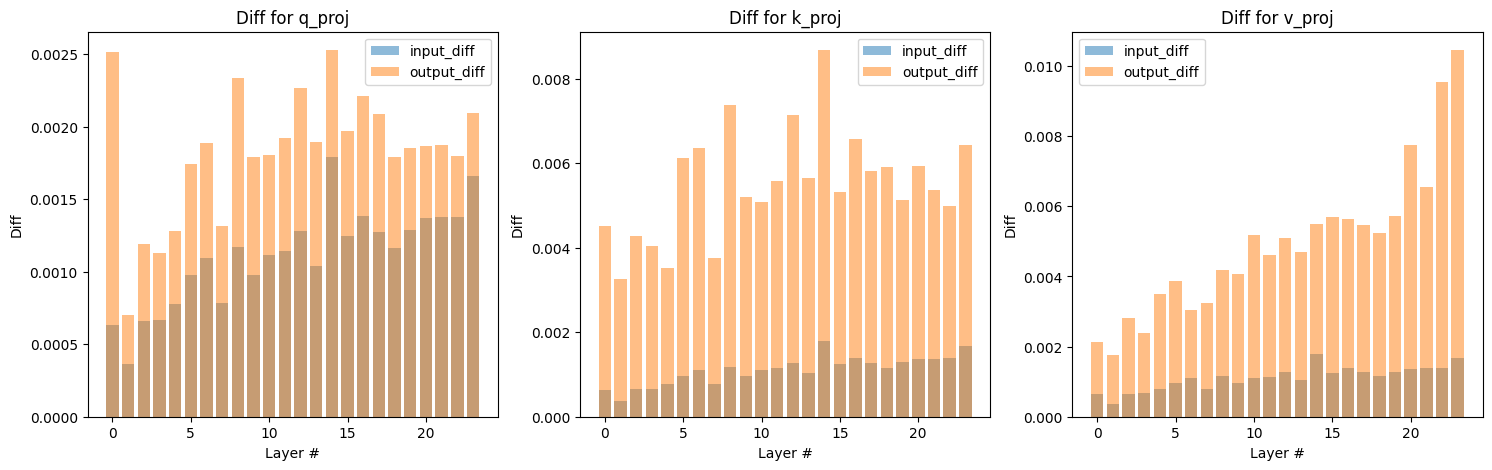

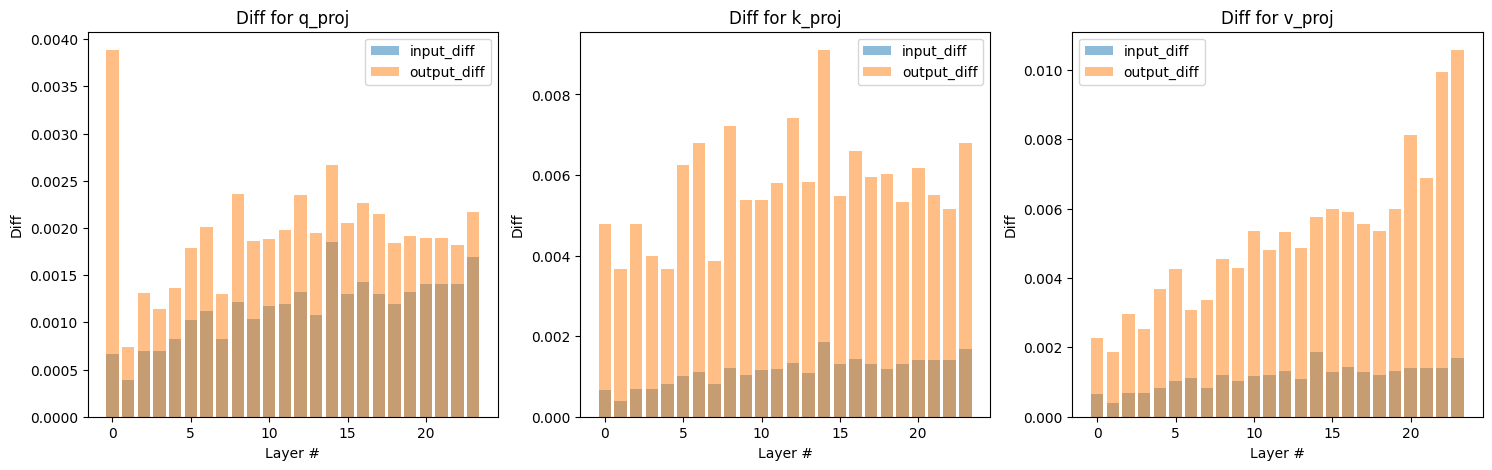

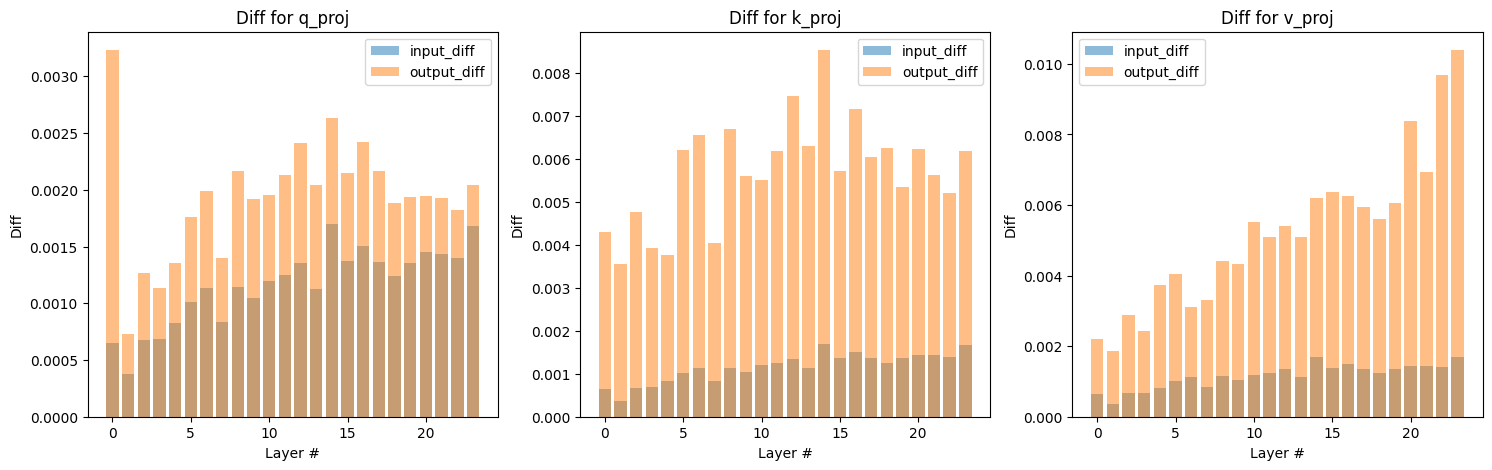

In [14]:
# 对比“(1)英文单词strawberry中有几个字母r”与“({})英文单词strawberry中有几个字母r”
for i in range(53, 61):
    easy_compare_forward_hook_data(
        hook_data_path_1 = hook_data_path_formatter.format(52), 
        hook_data_path_2 = hook_data_path_formatter.format(i),
        forward_hook_module_names = forward_hook_module_names[:],
        figure_names = ["q_proj", "k_proj", "v_proj"],
    )
    # if input(prompts[i]): break

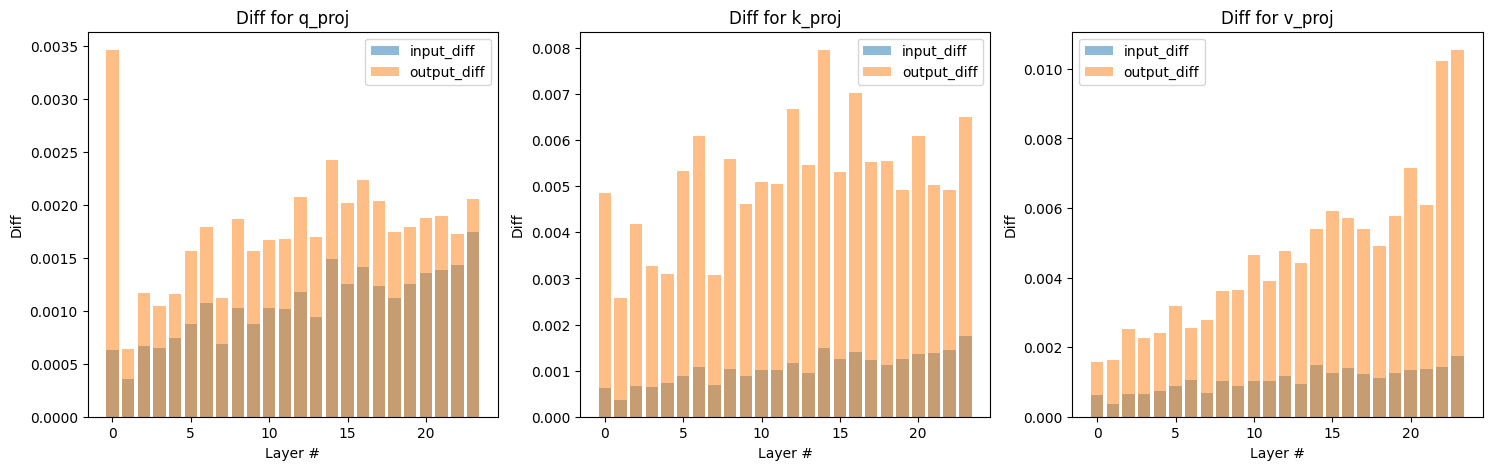

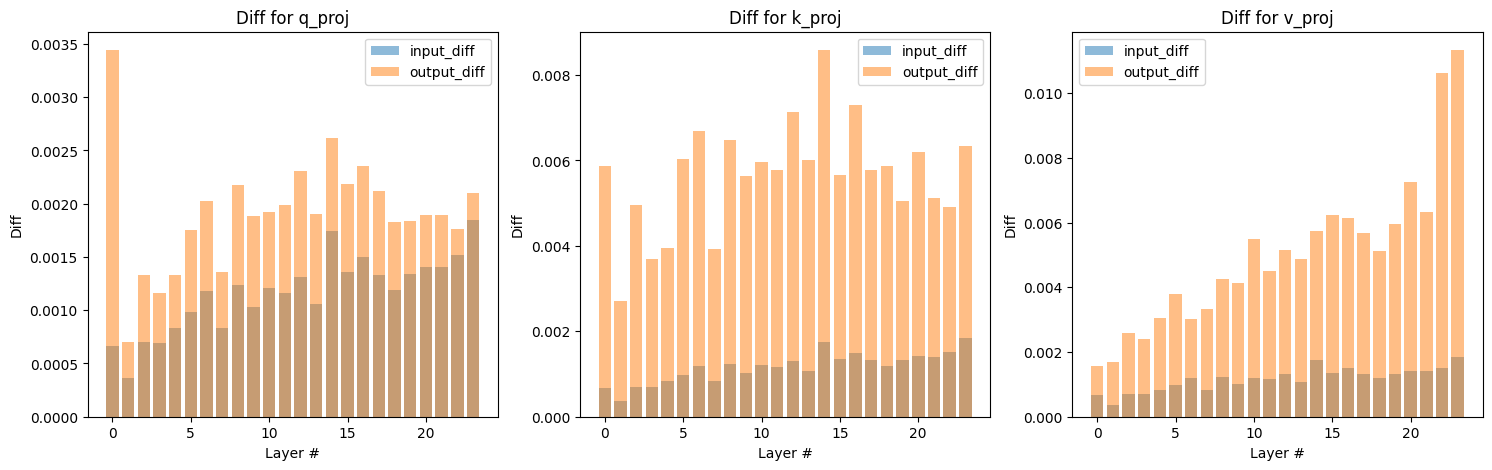

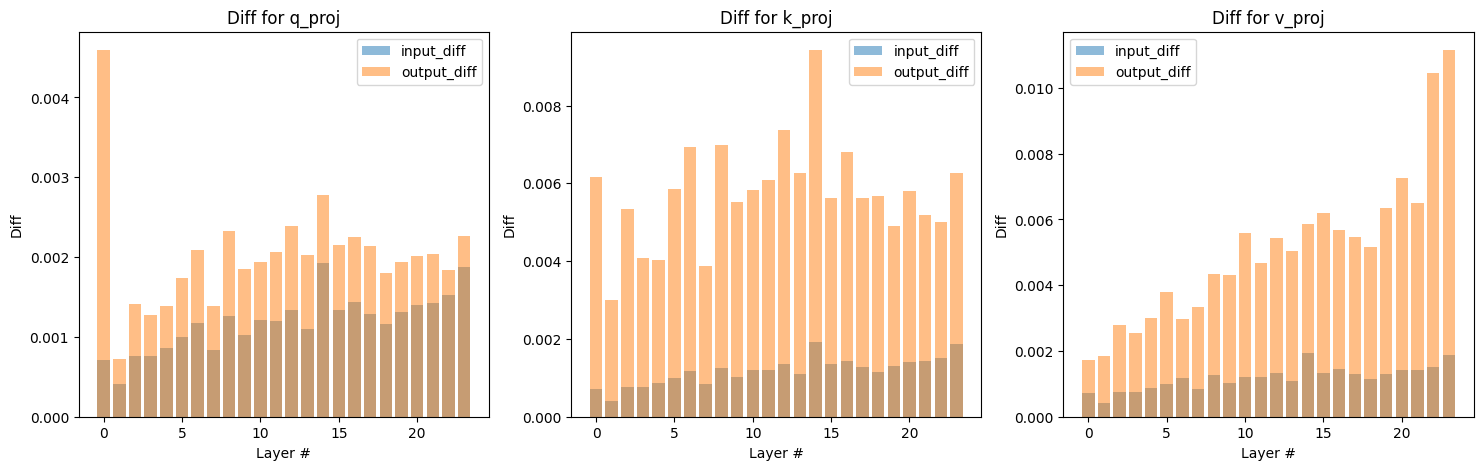

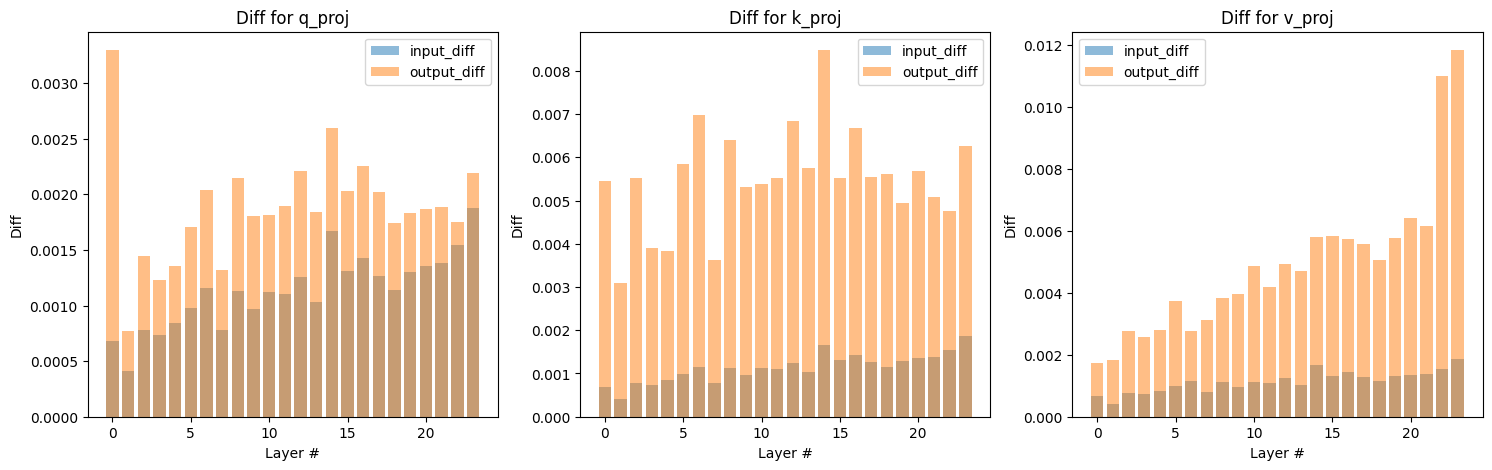

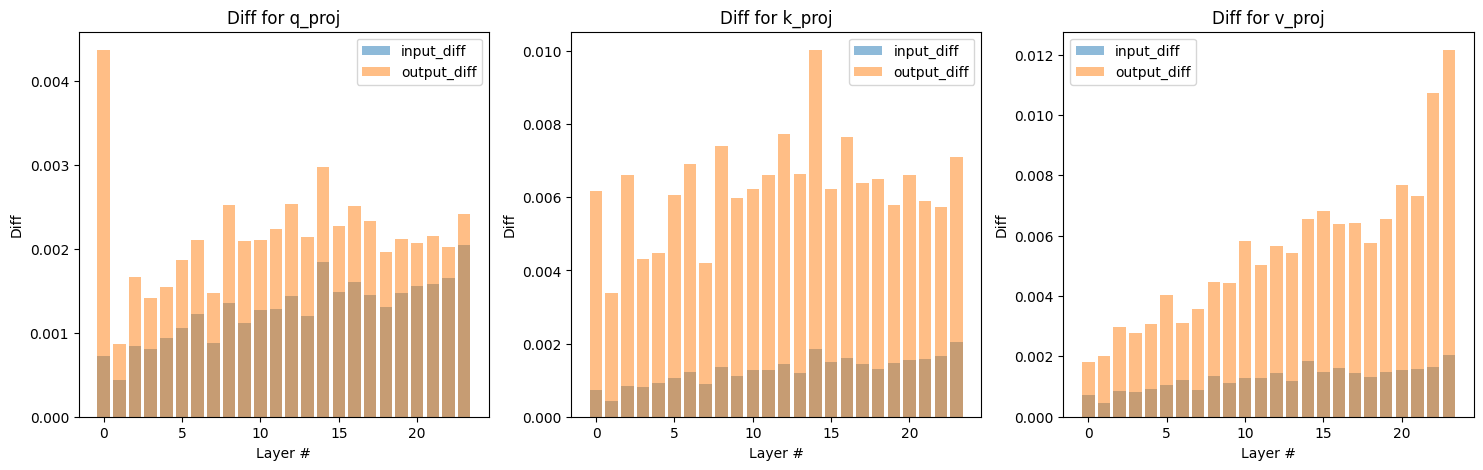

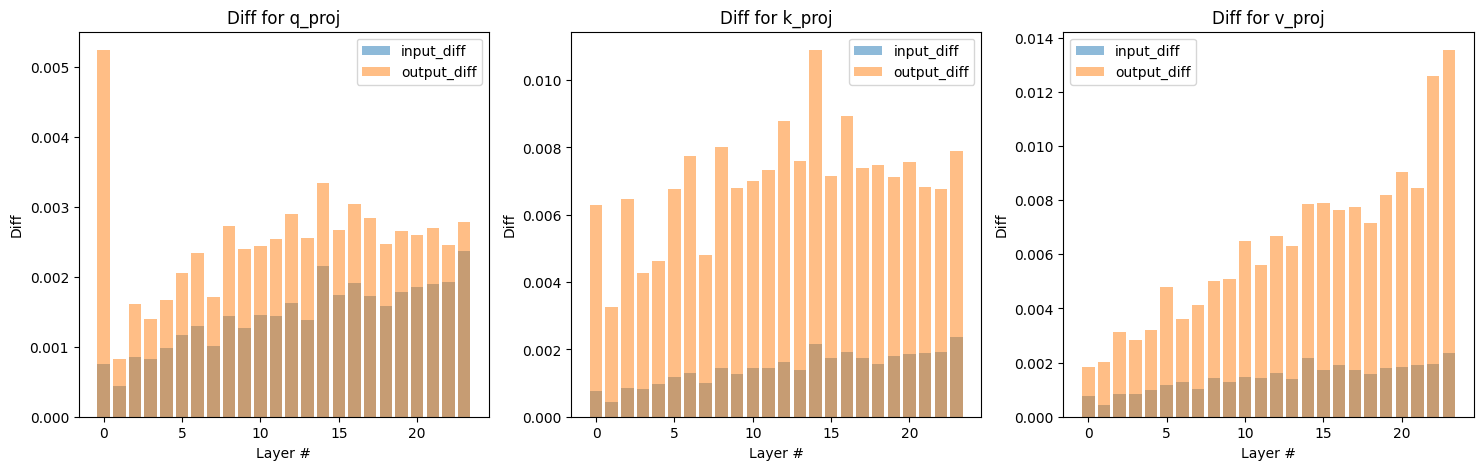

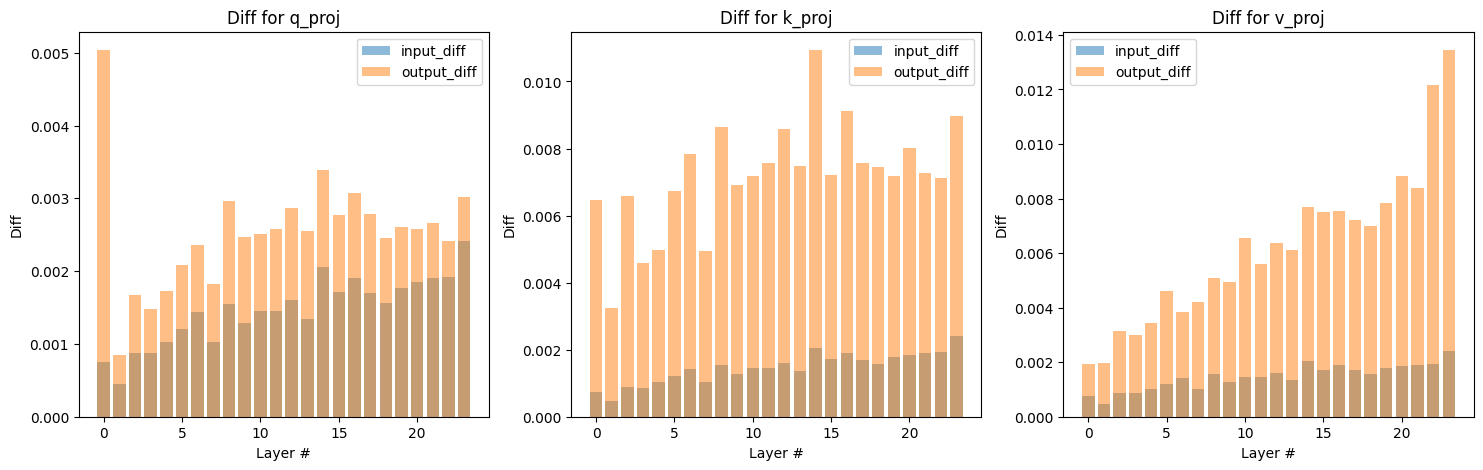

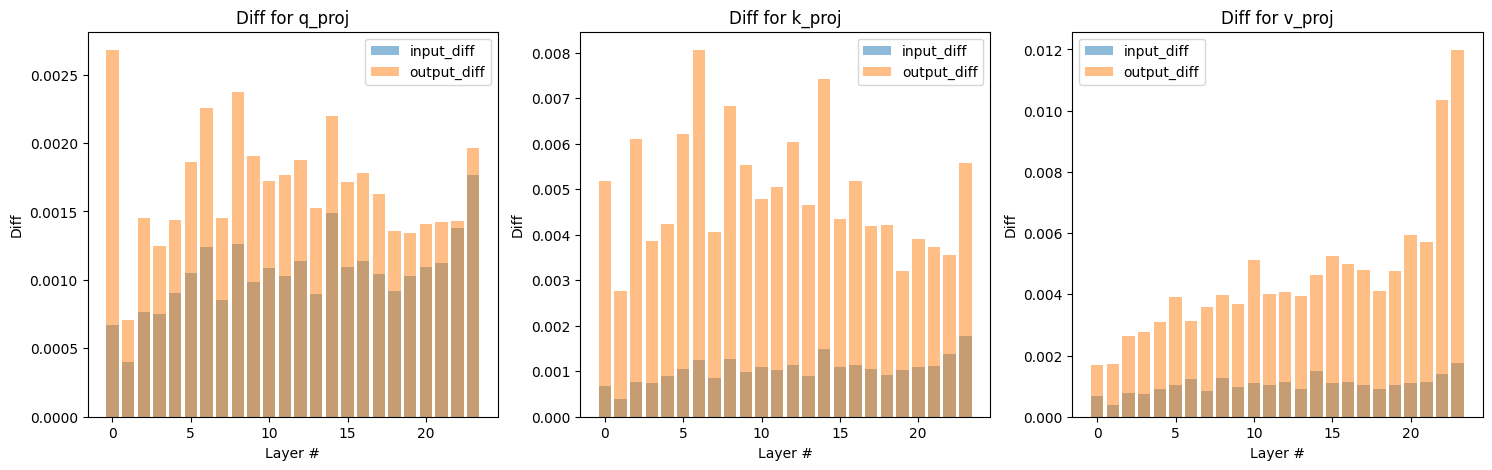

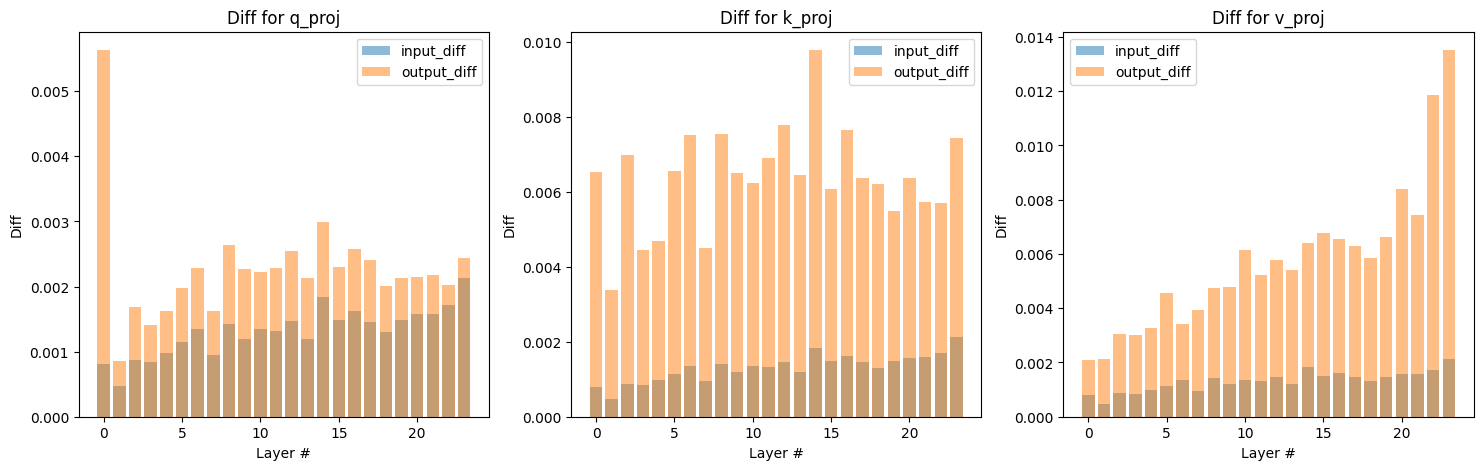

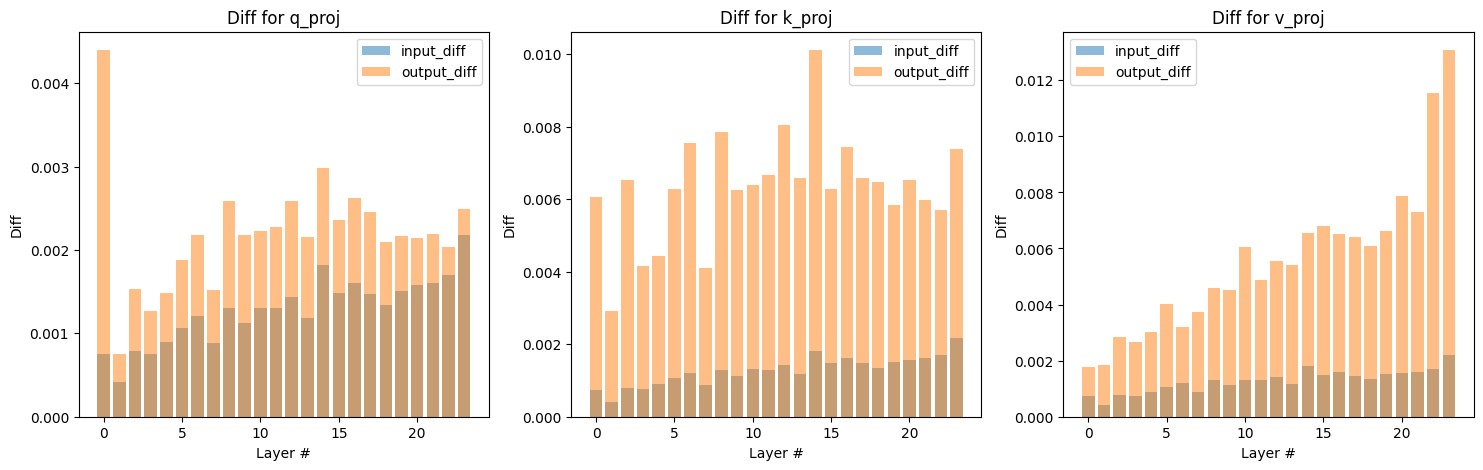

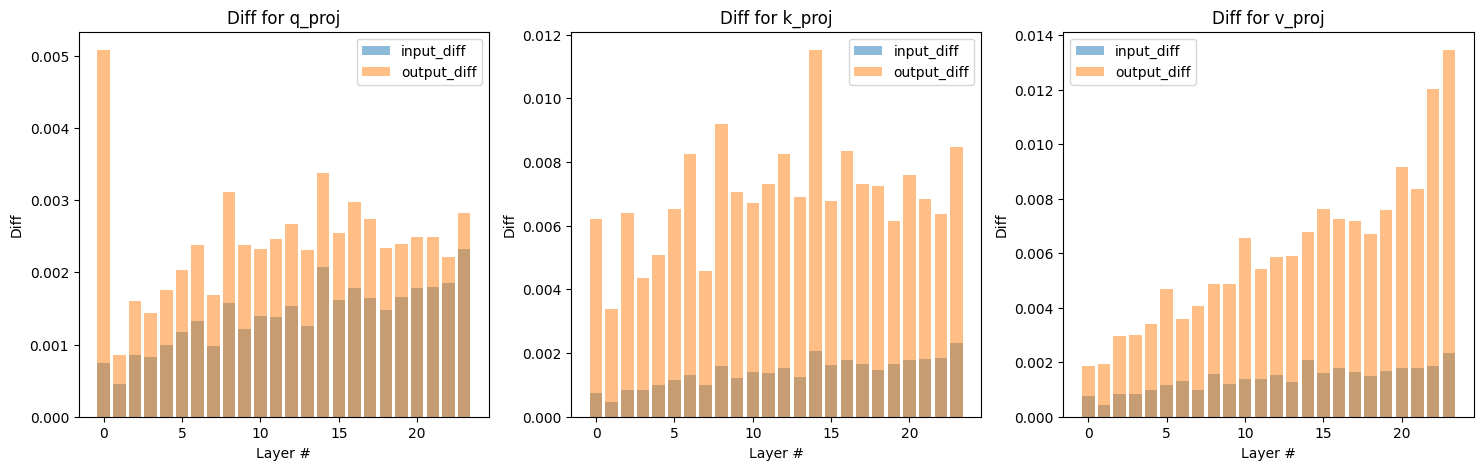

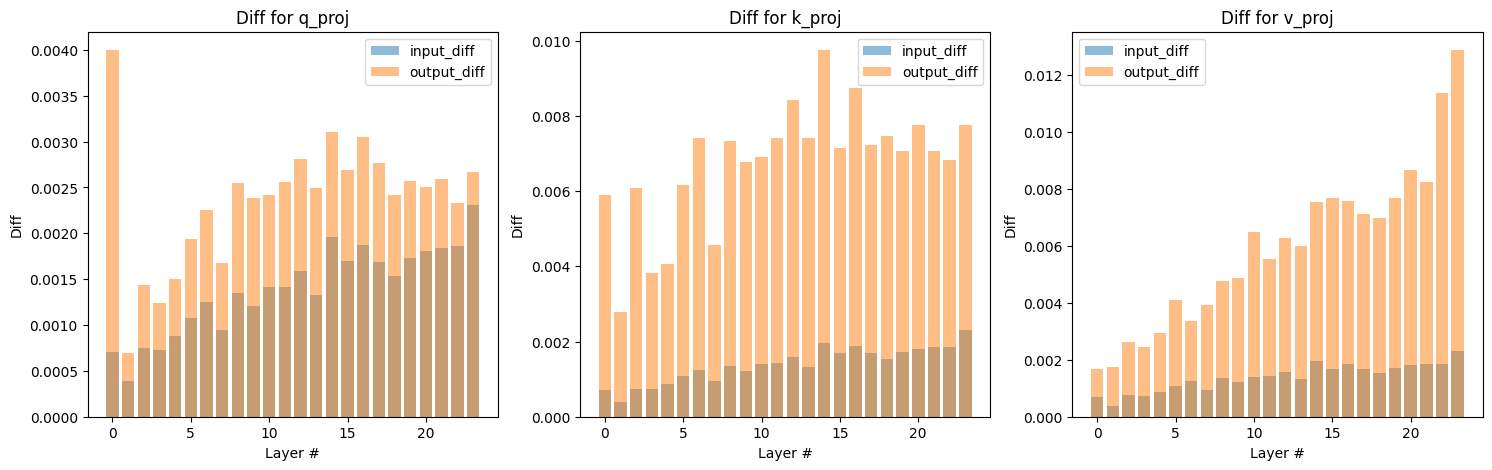

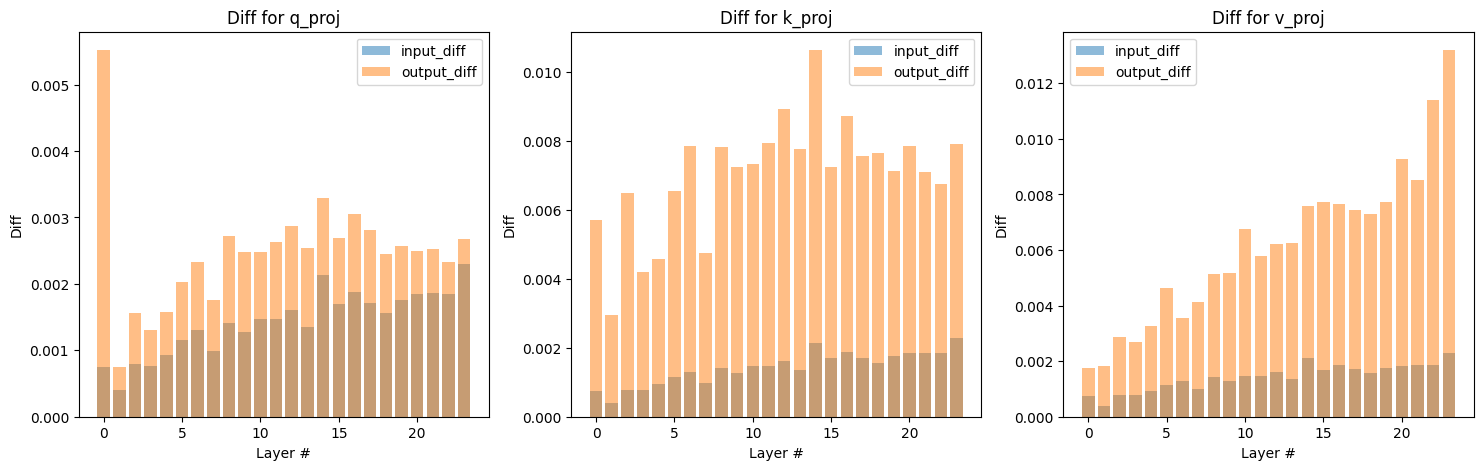

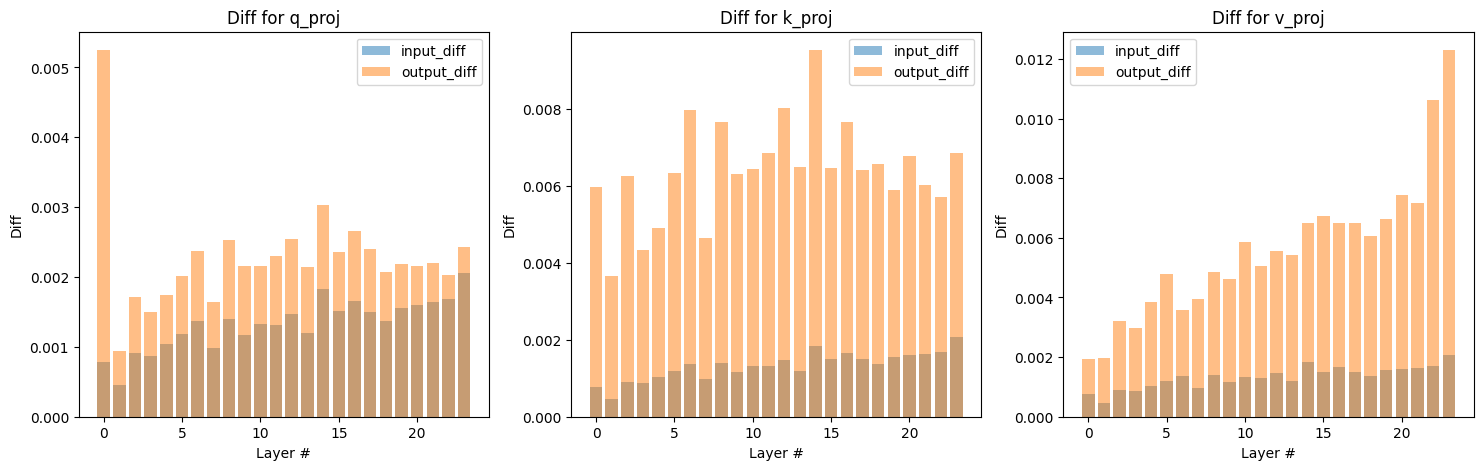

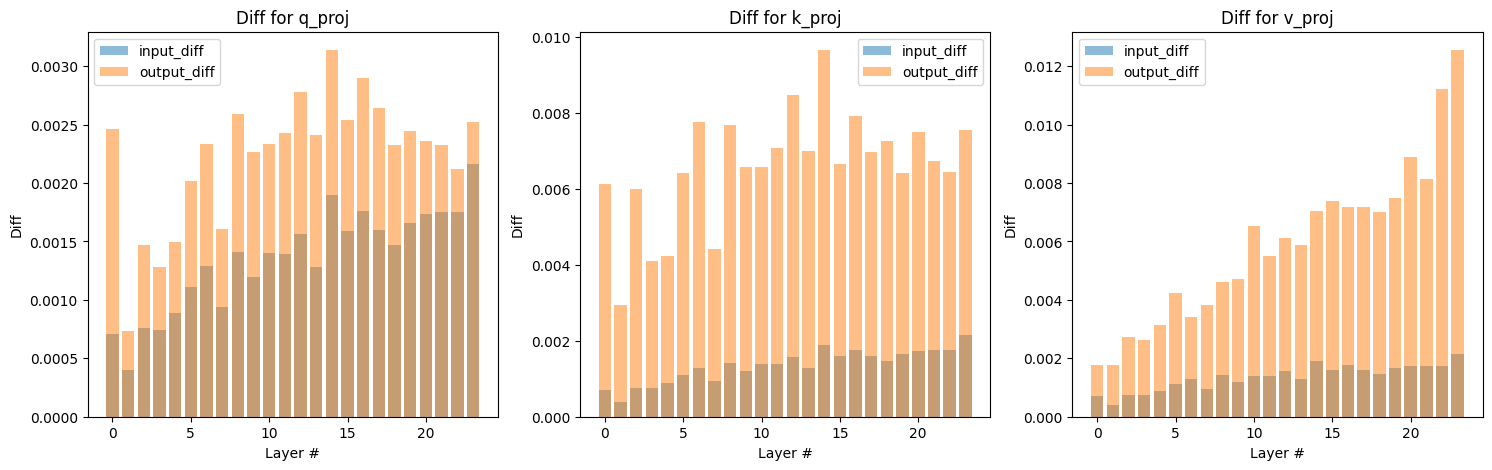

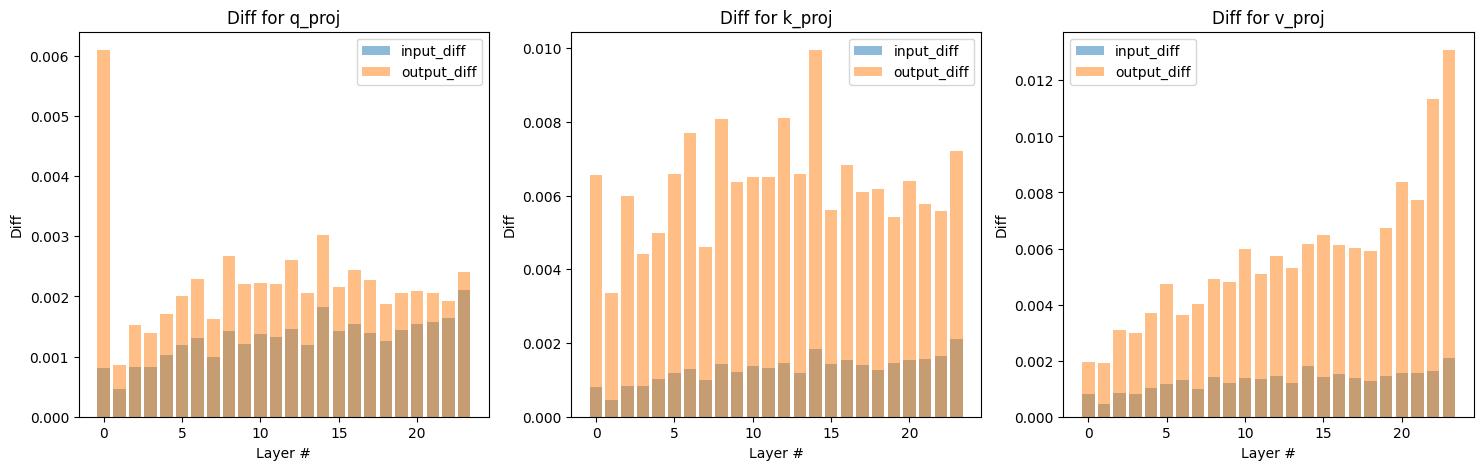

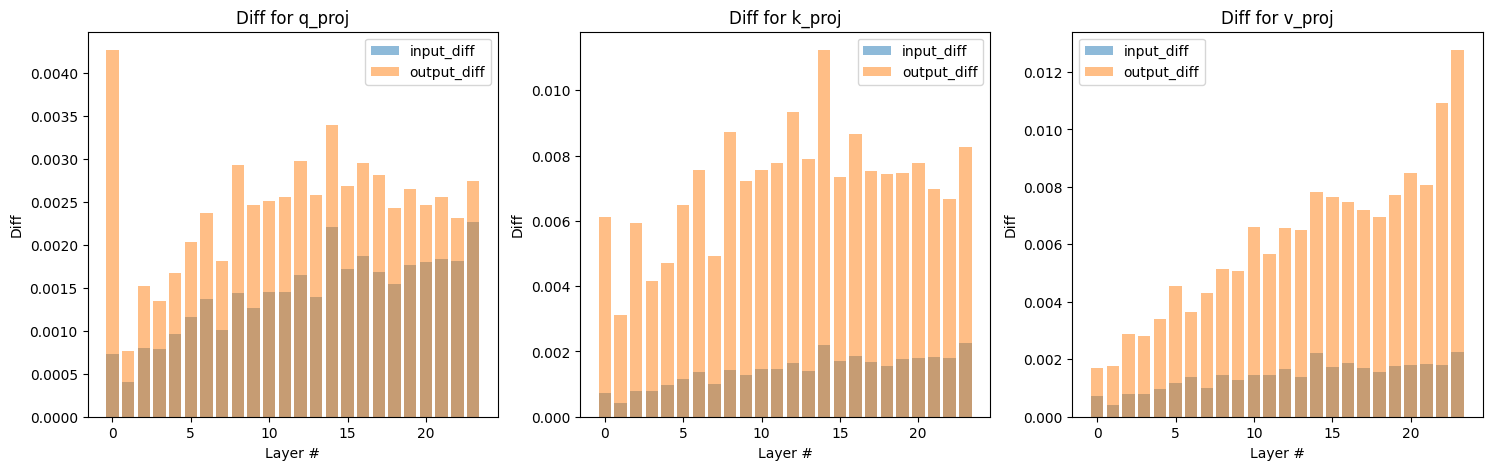

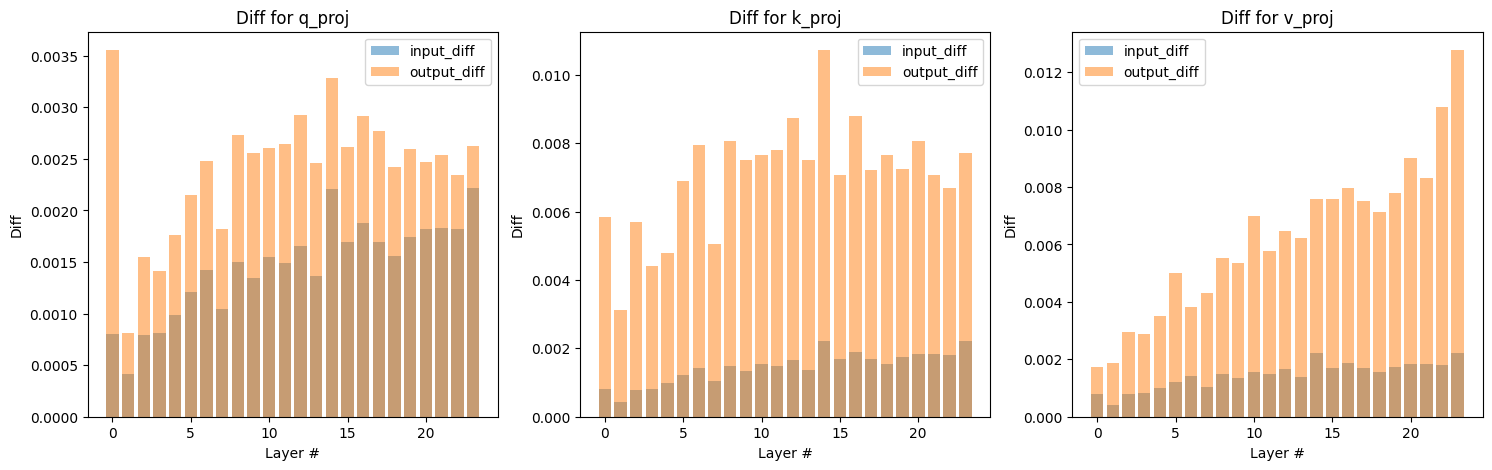

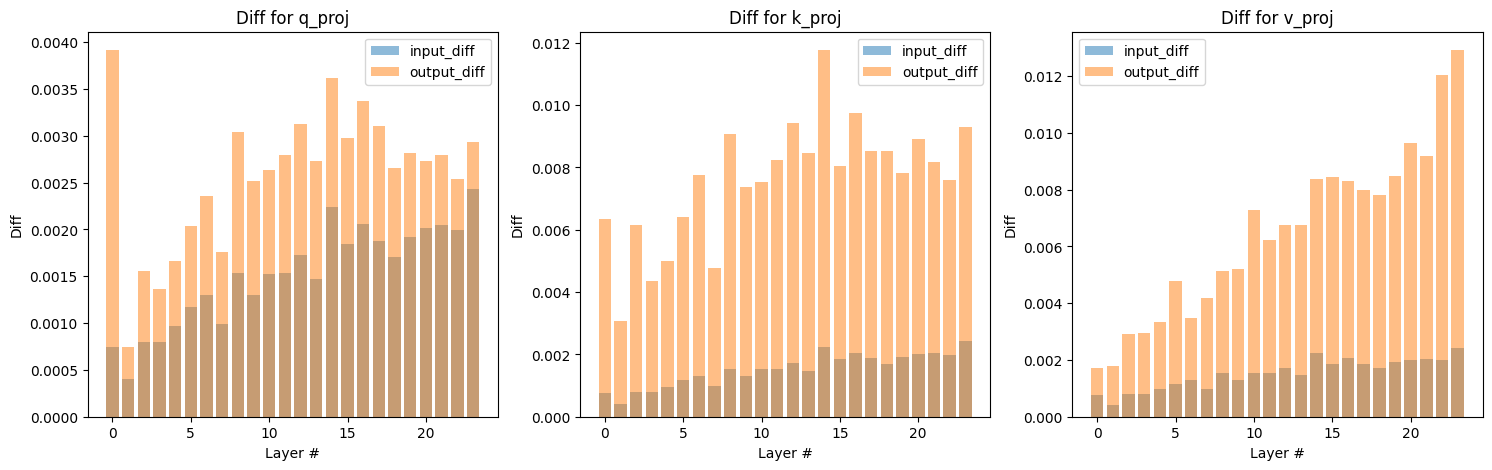

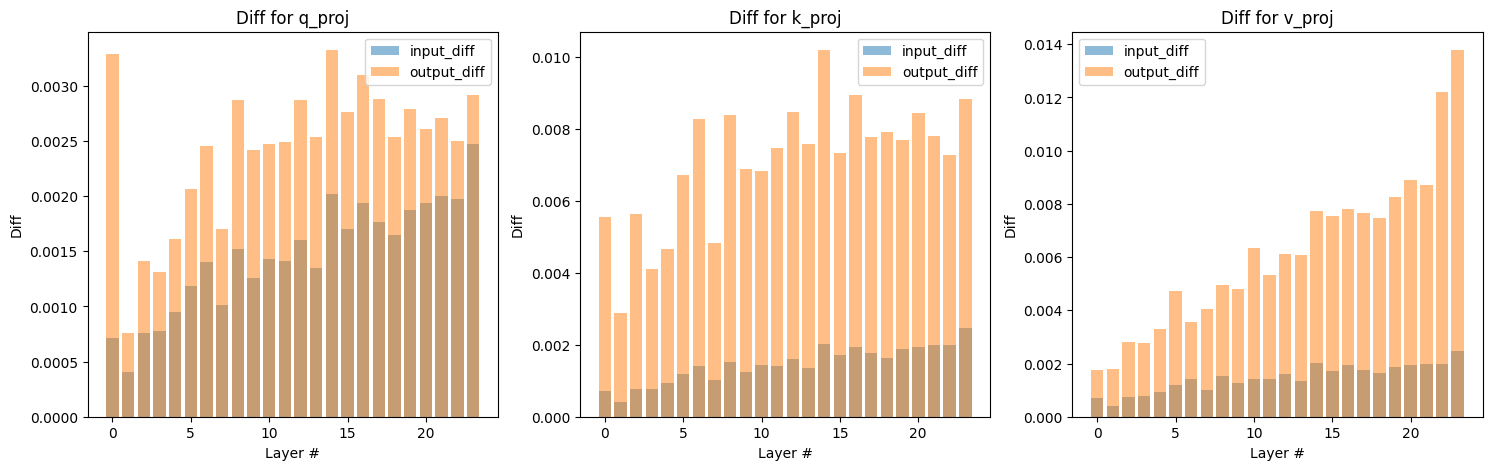

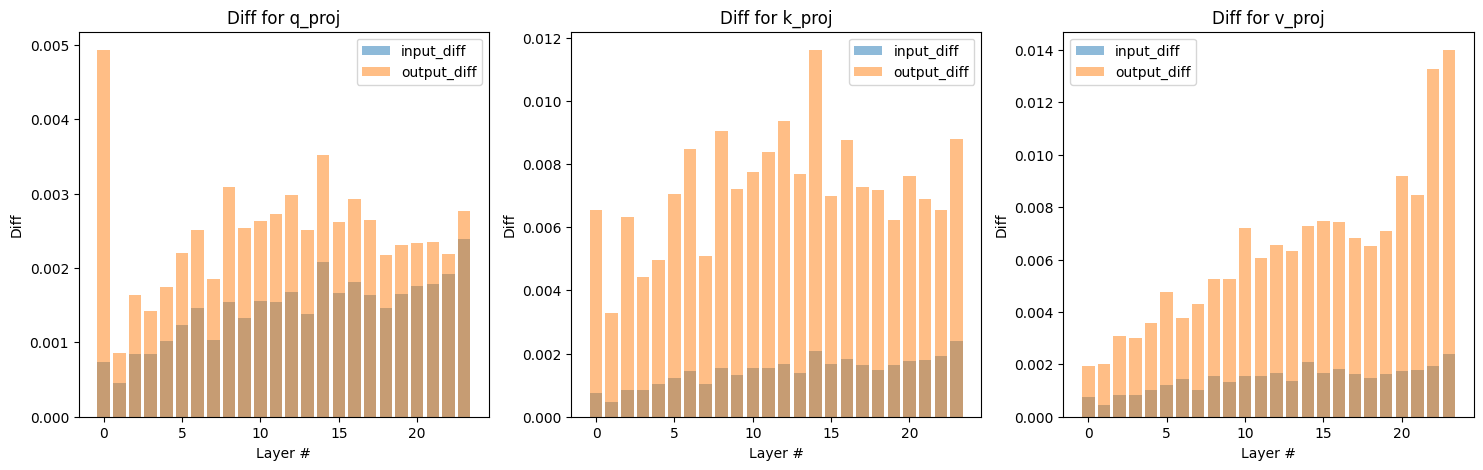

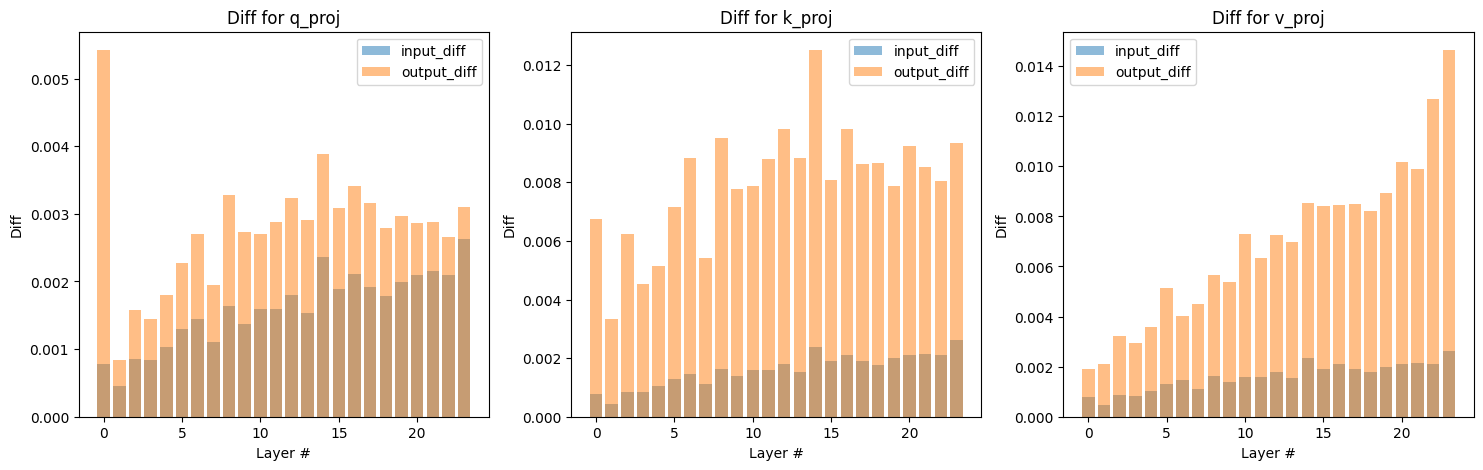

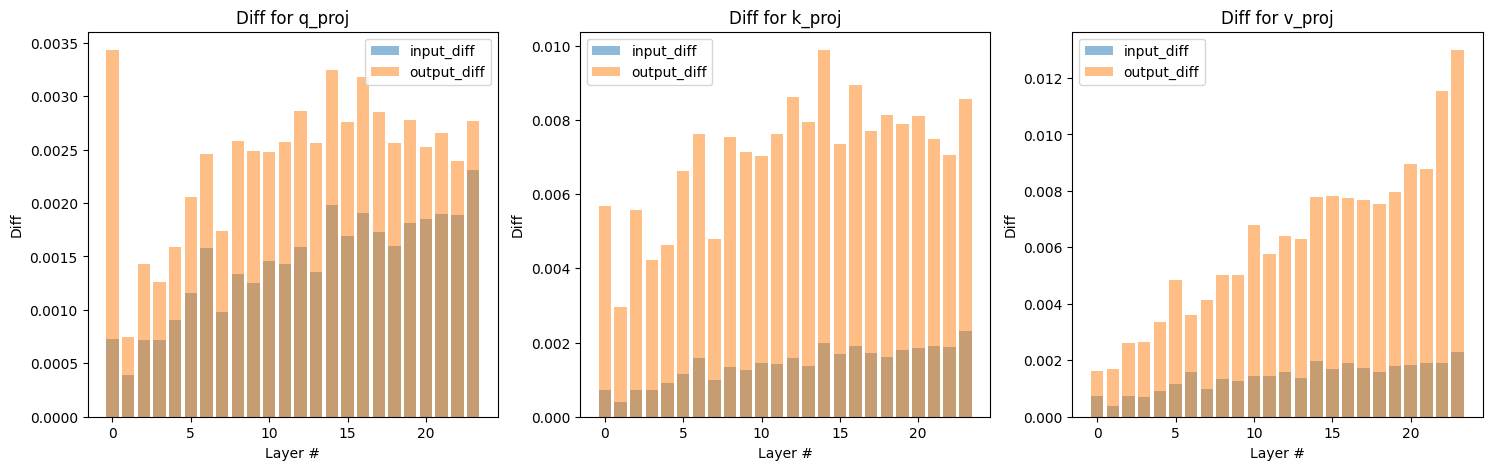

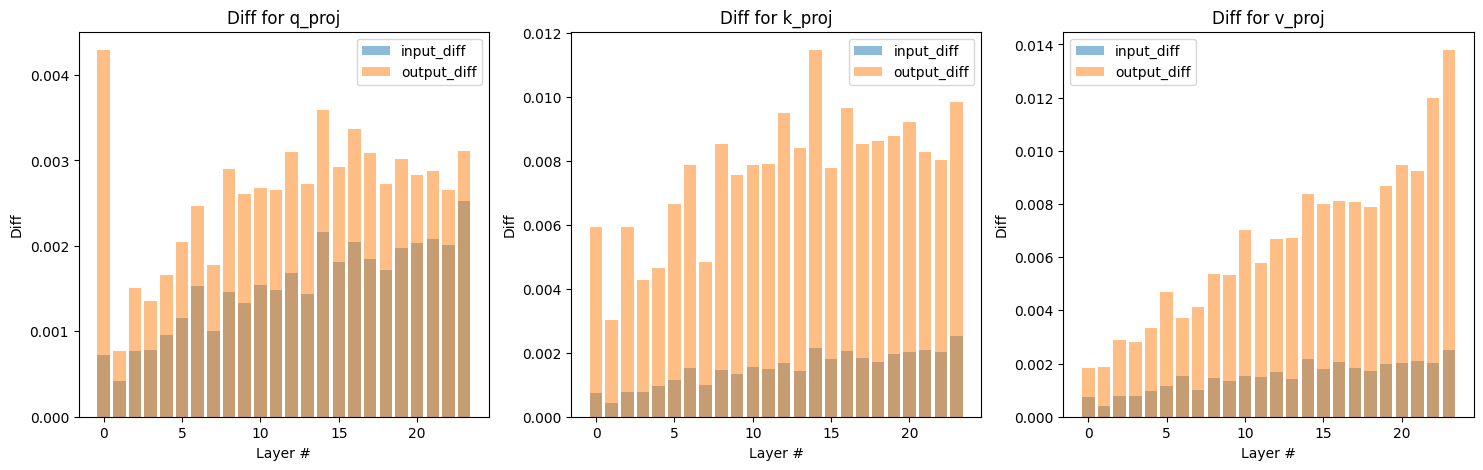

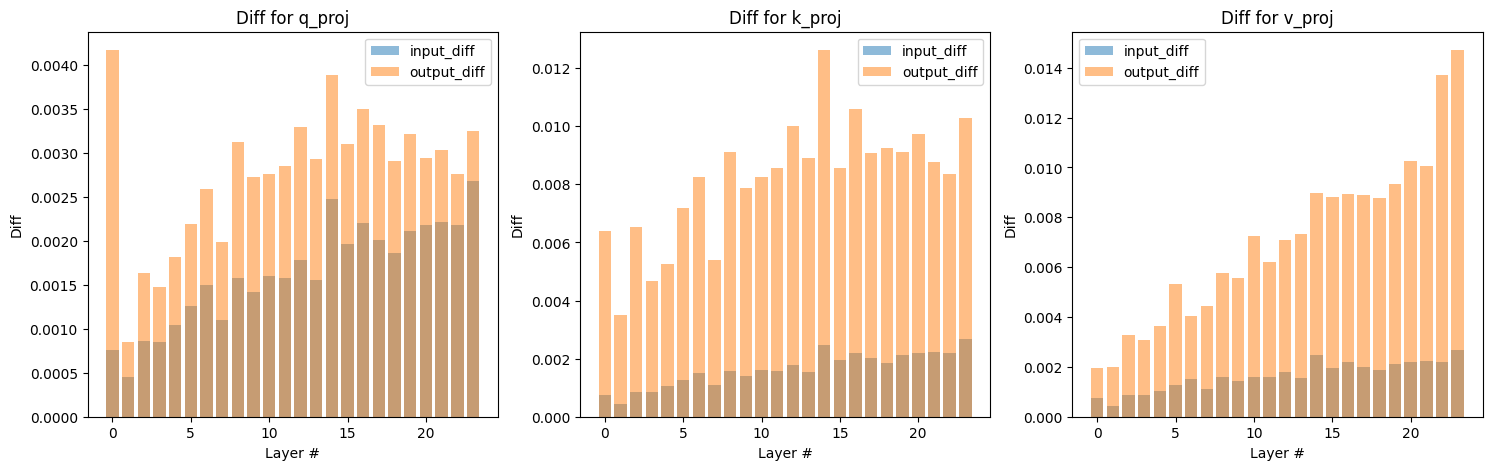

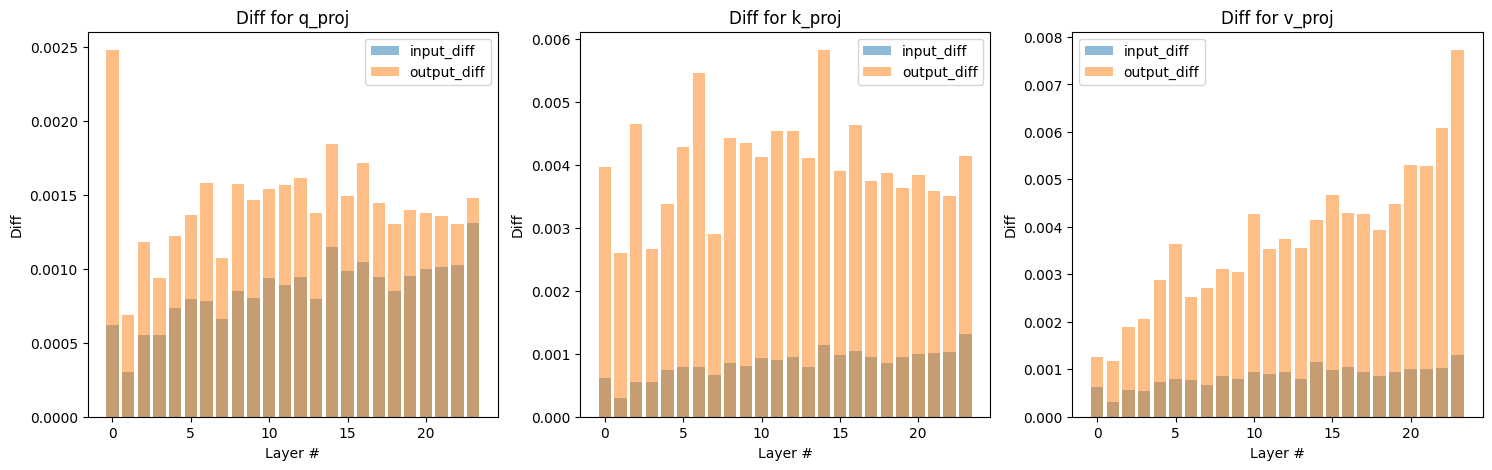

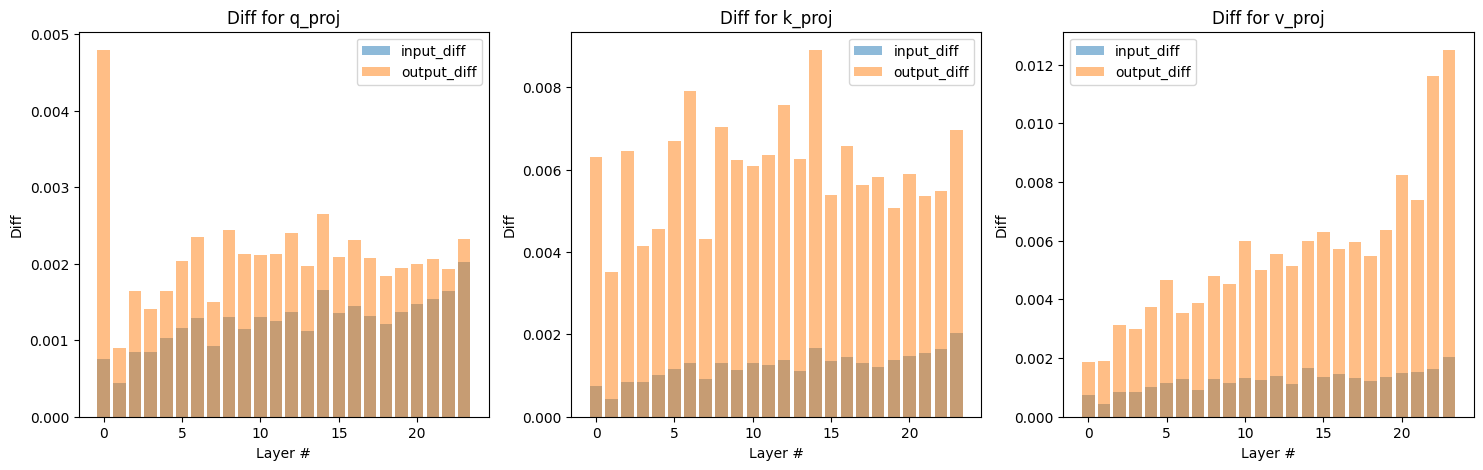

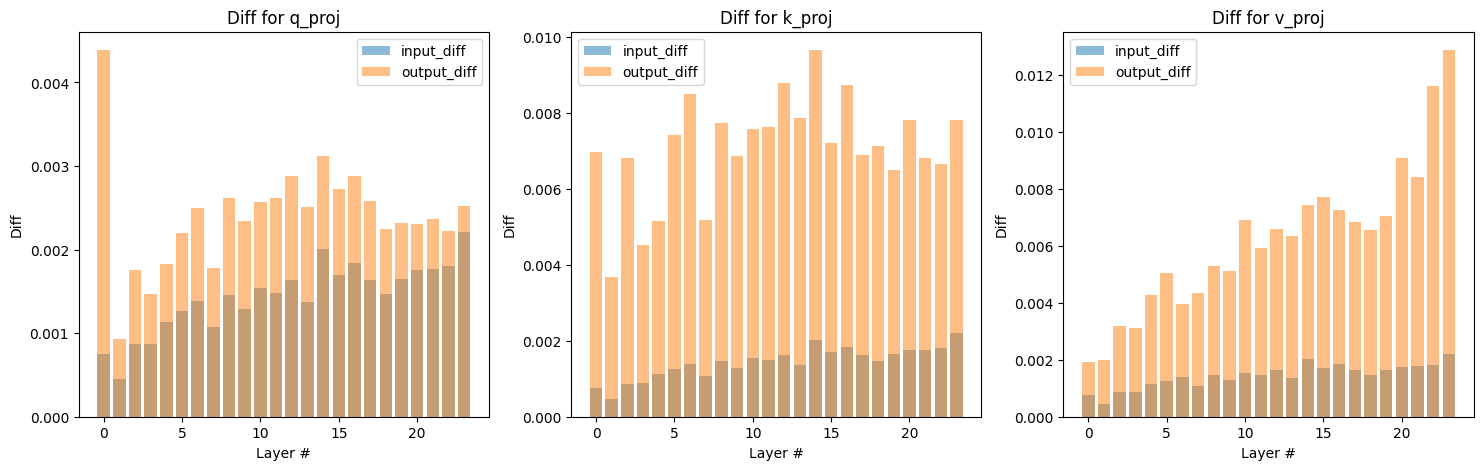

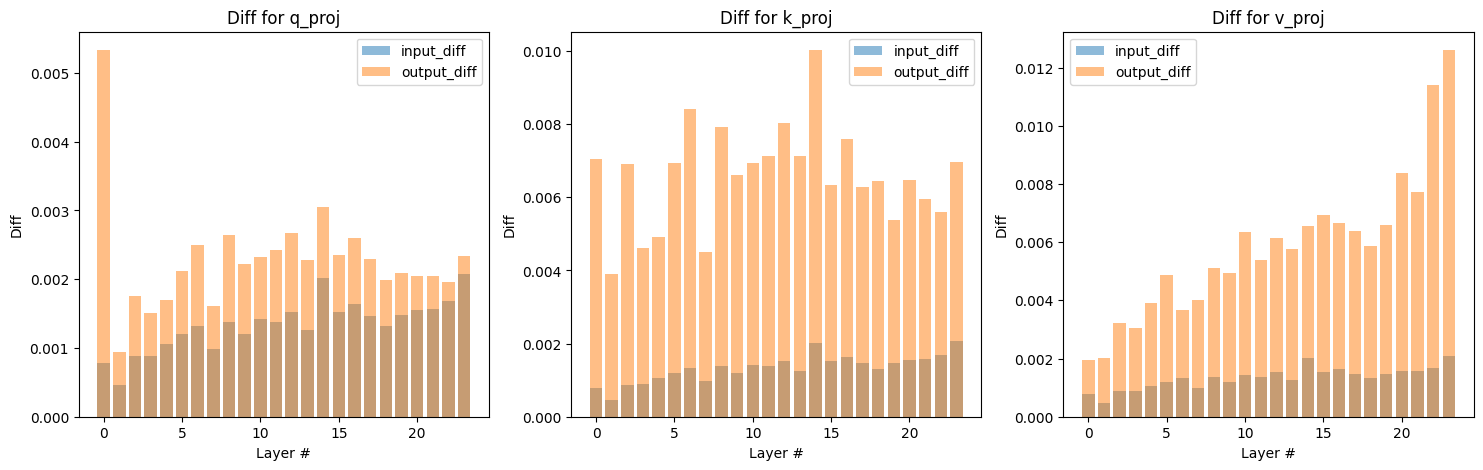

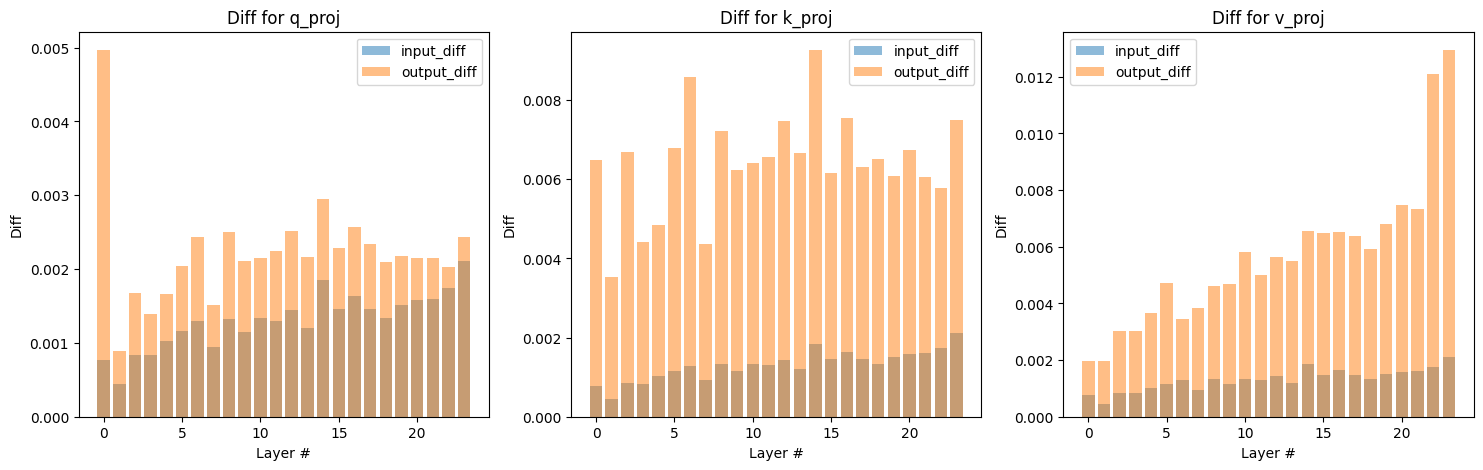

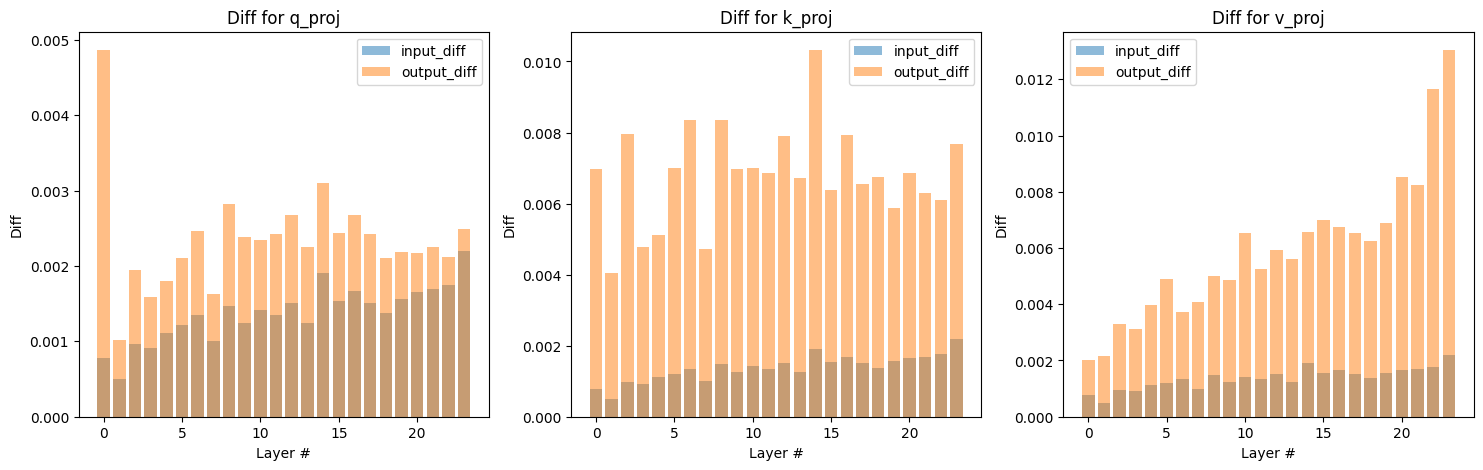

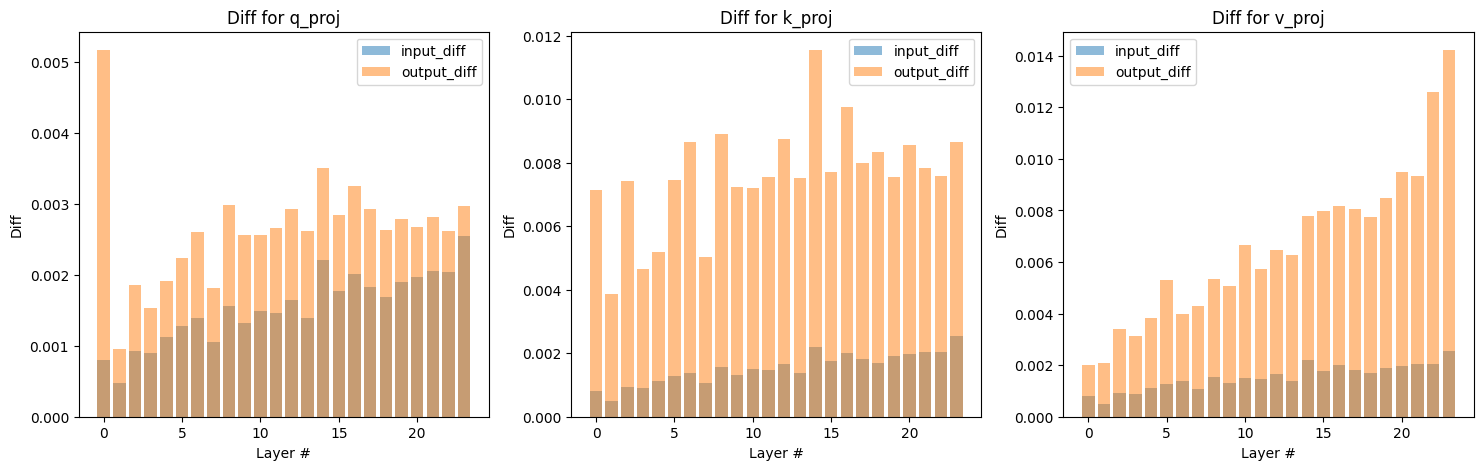

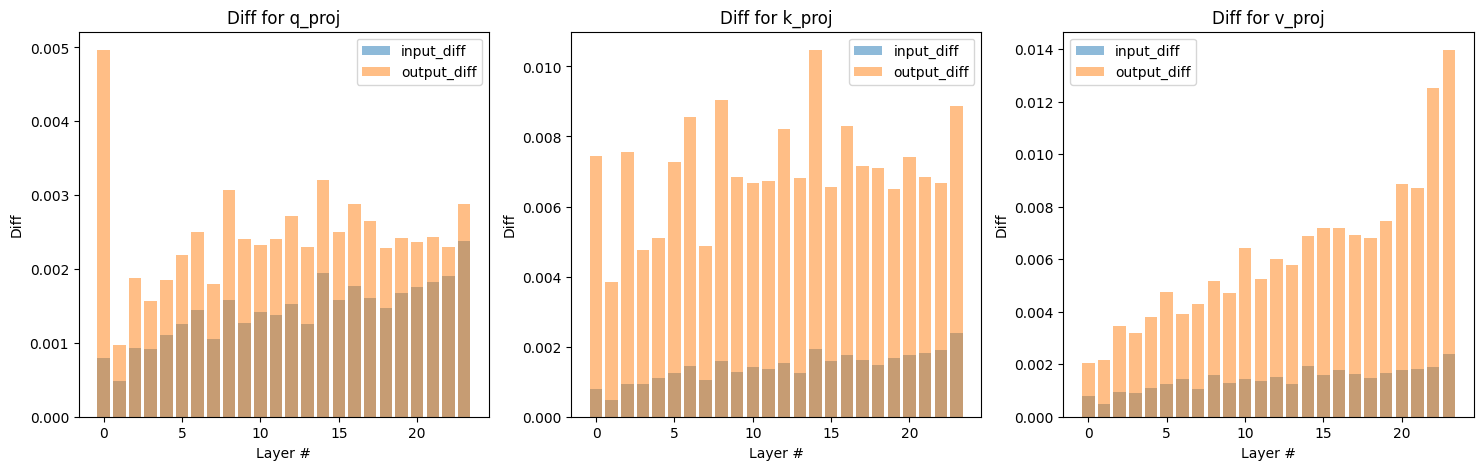

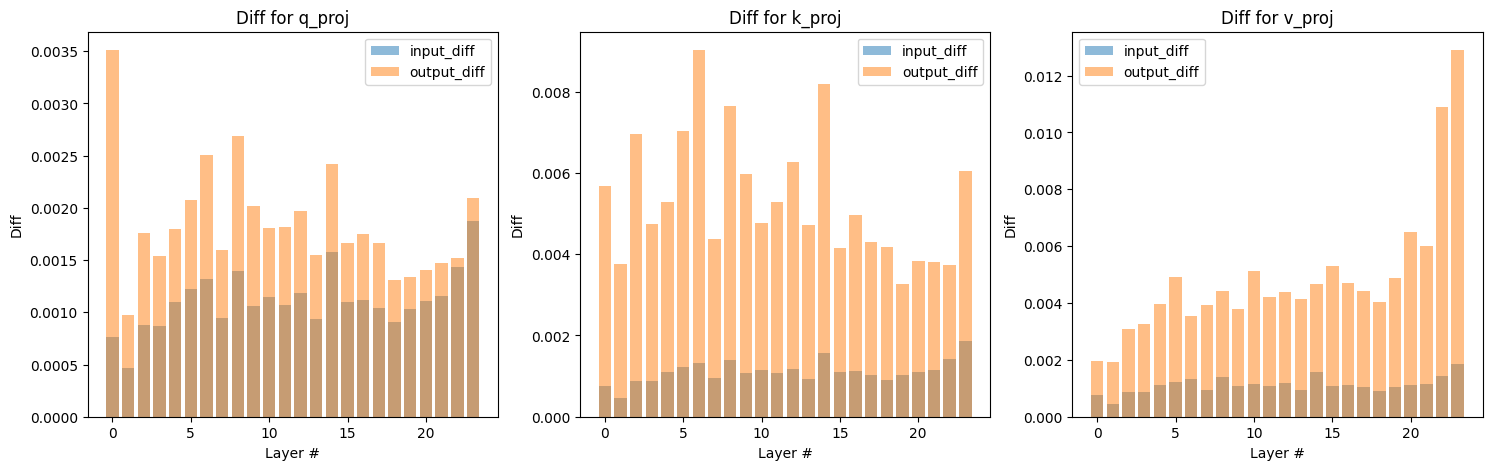

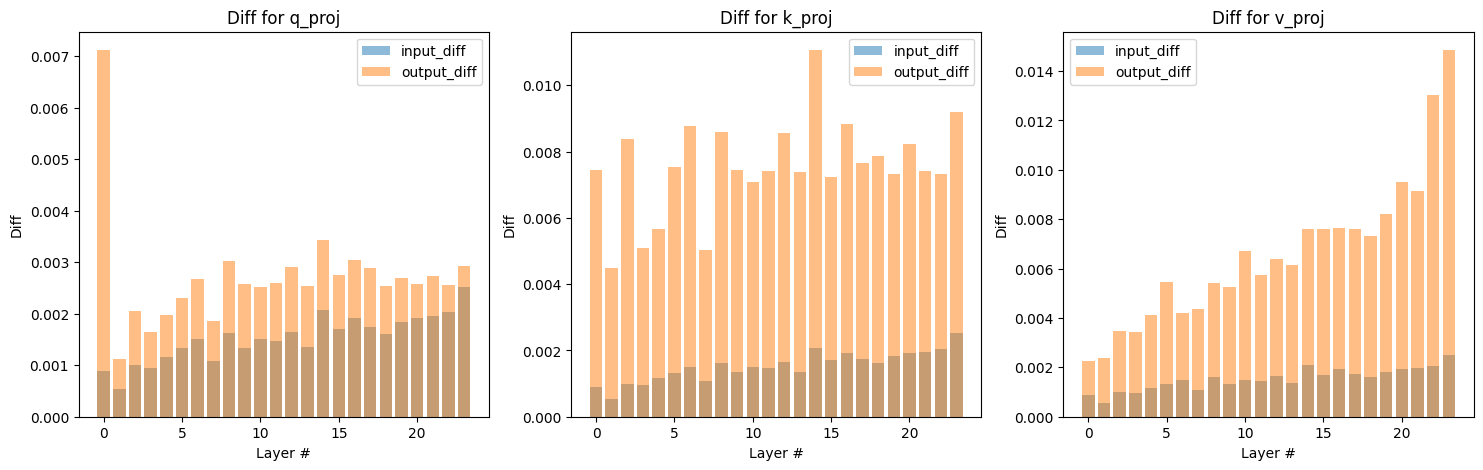

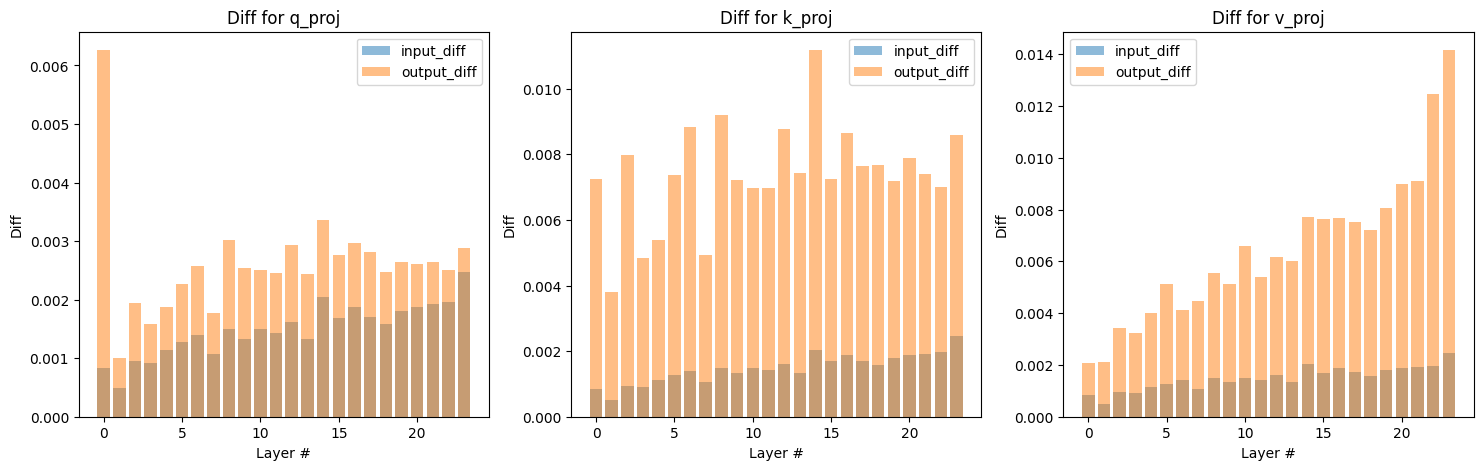

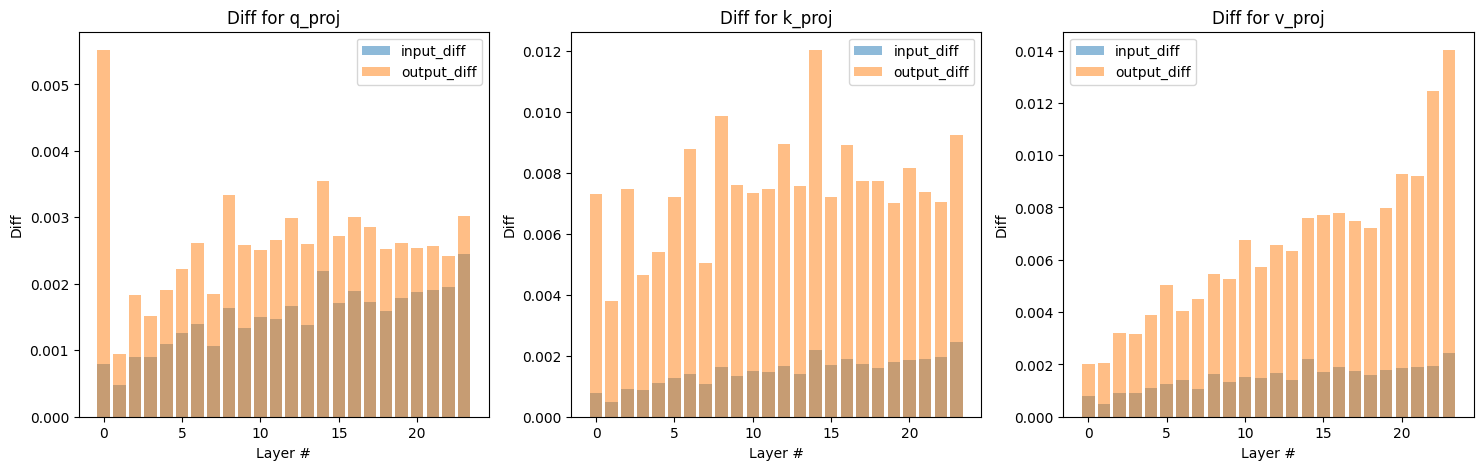

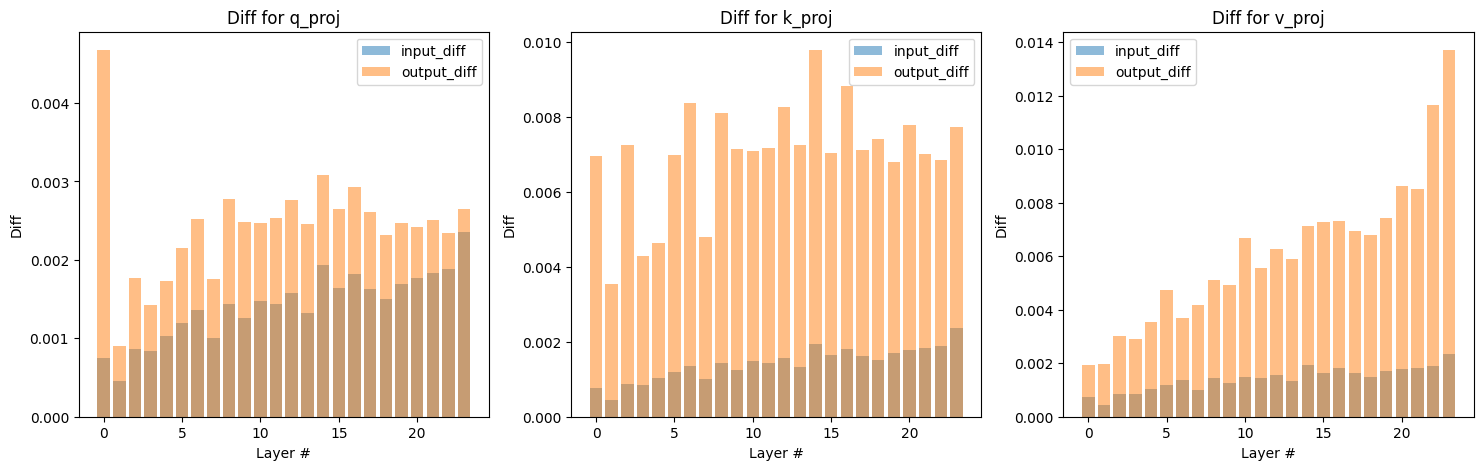

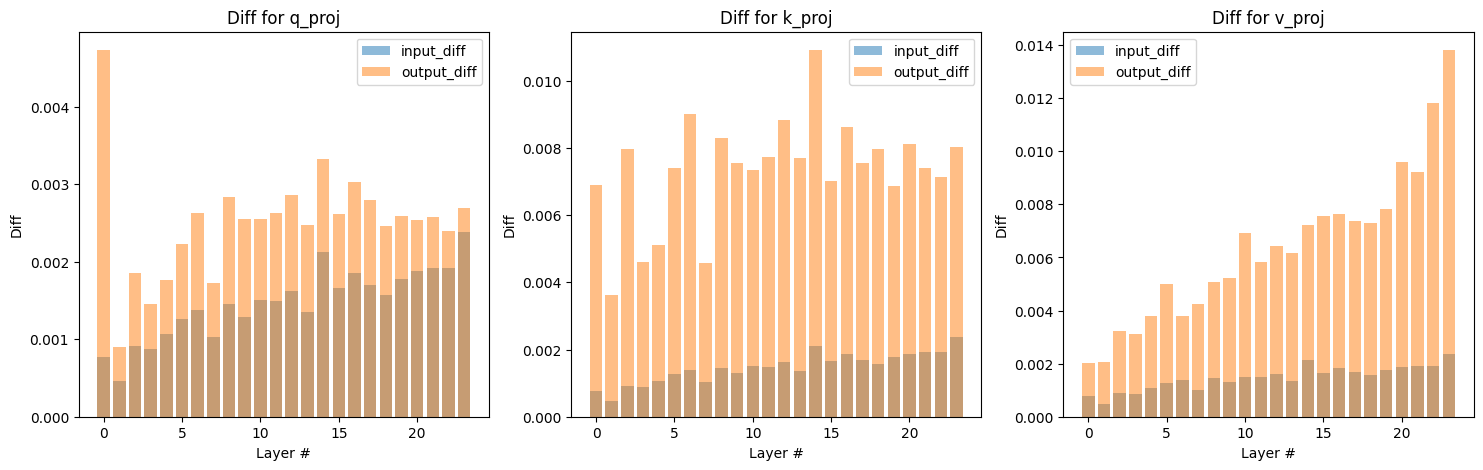

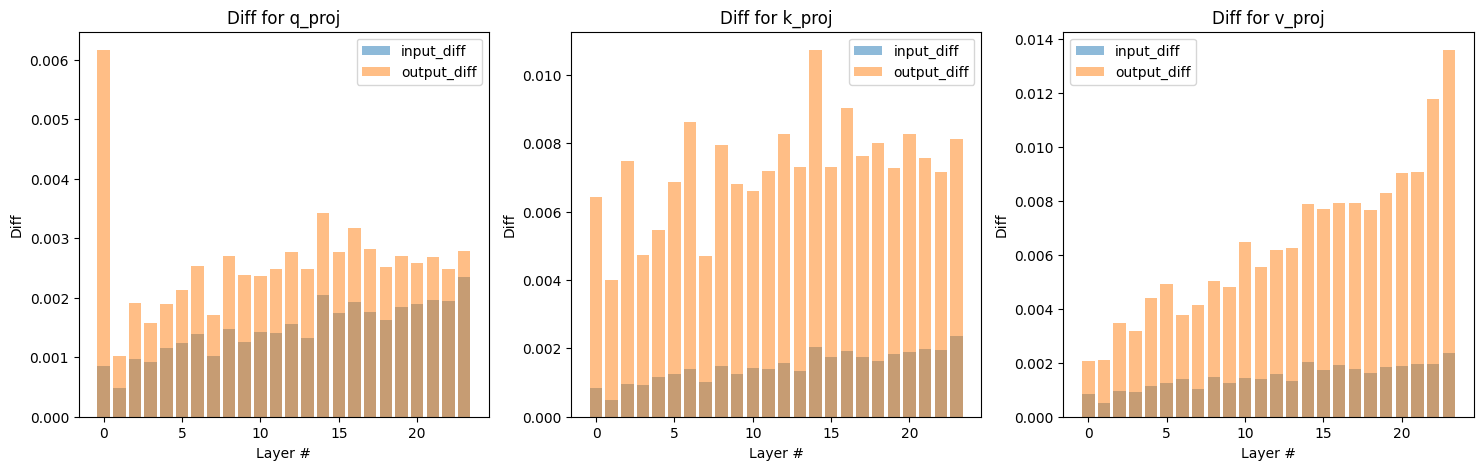

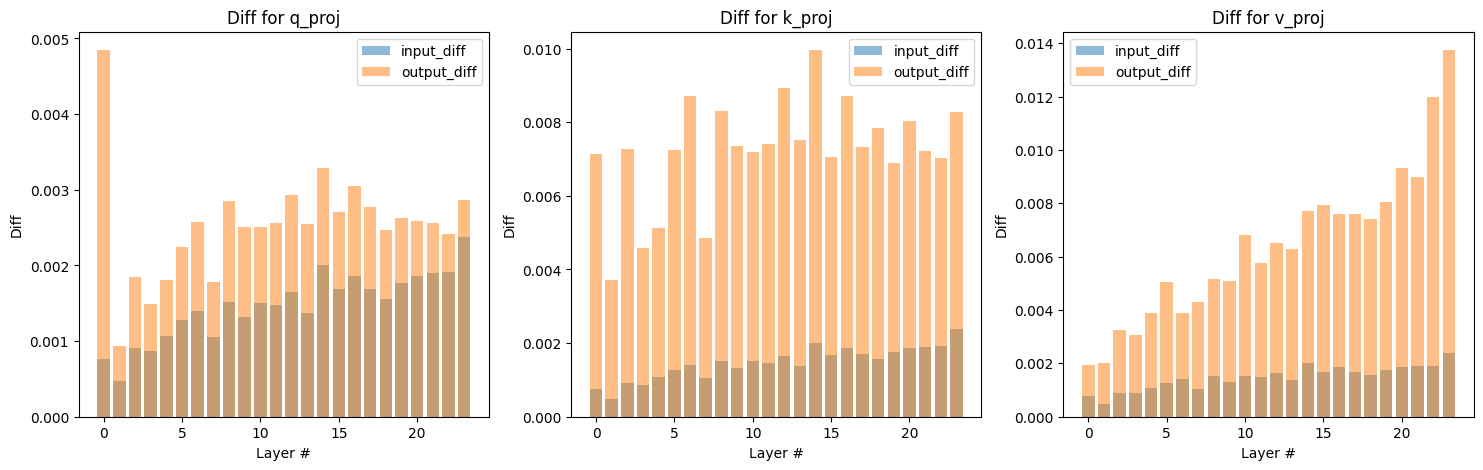

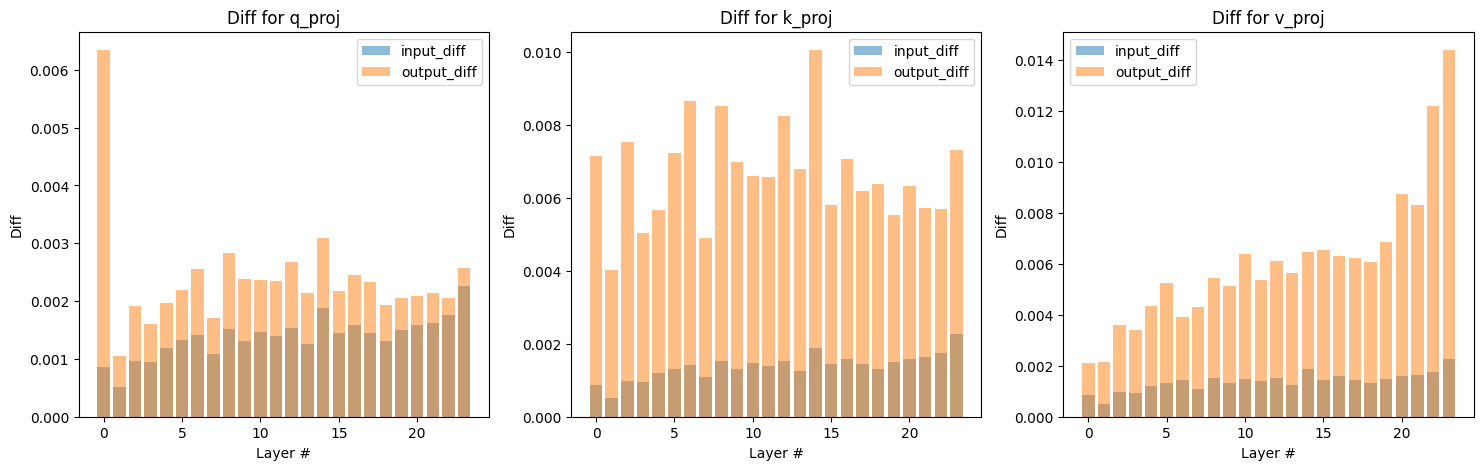

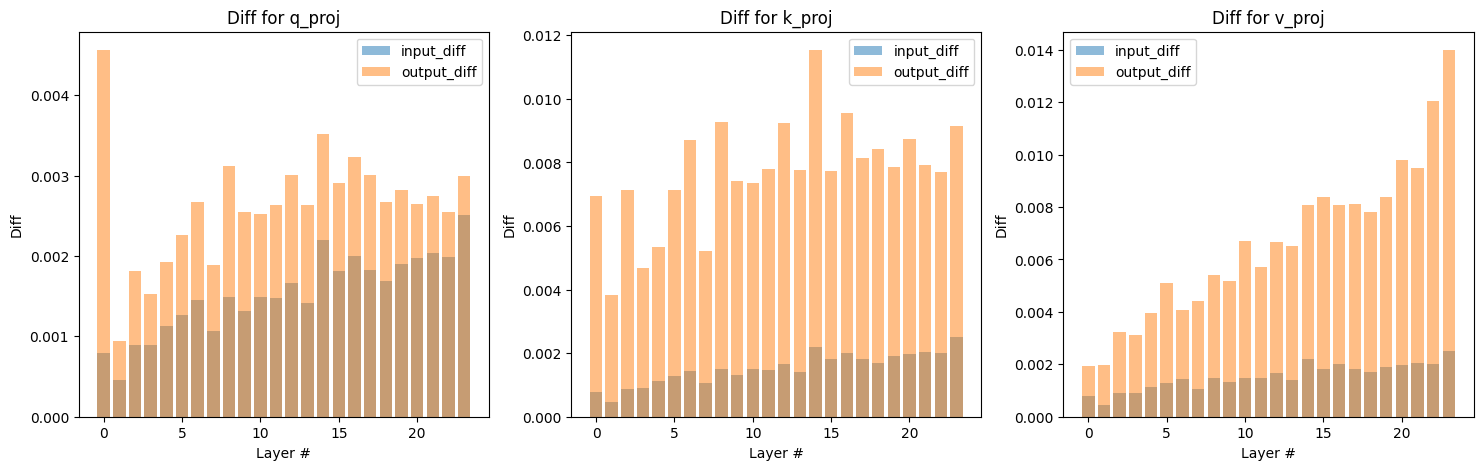

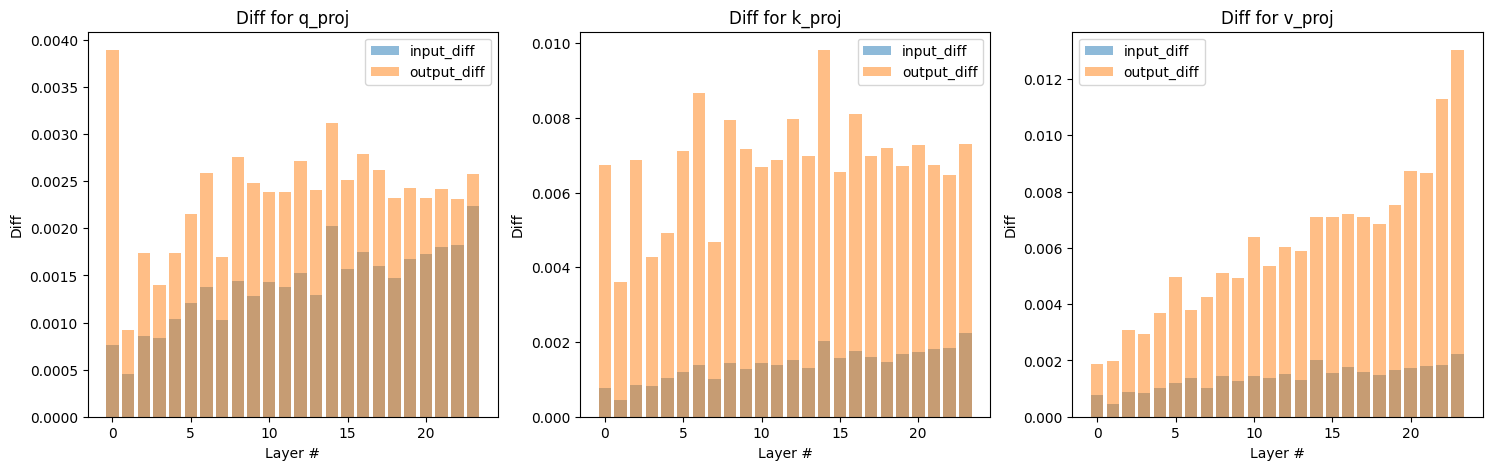

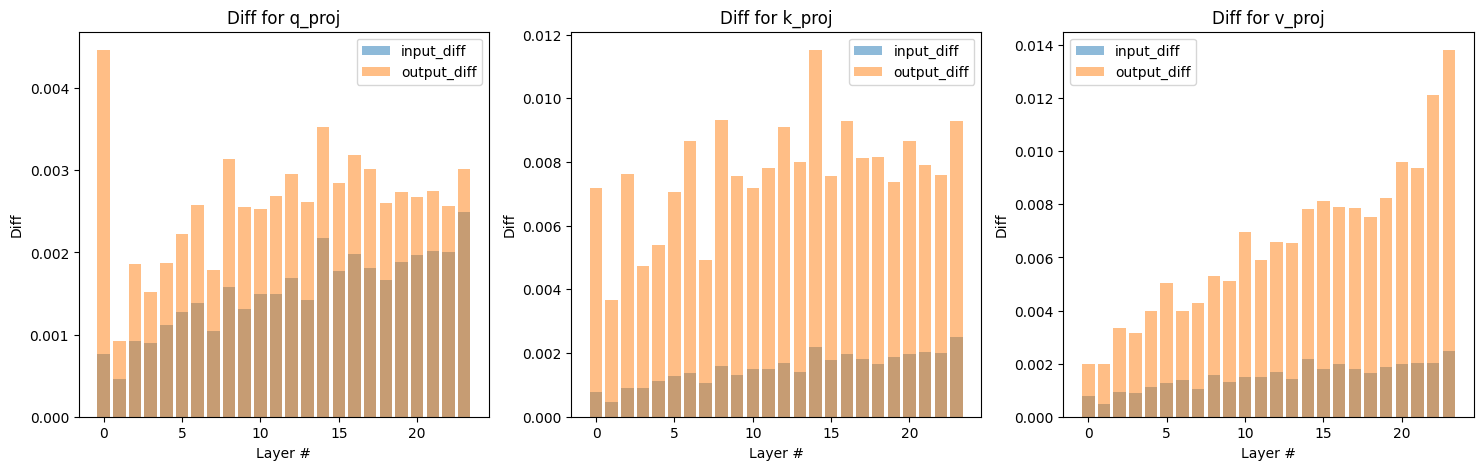

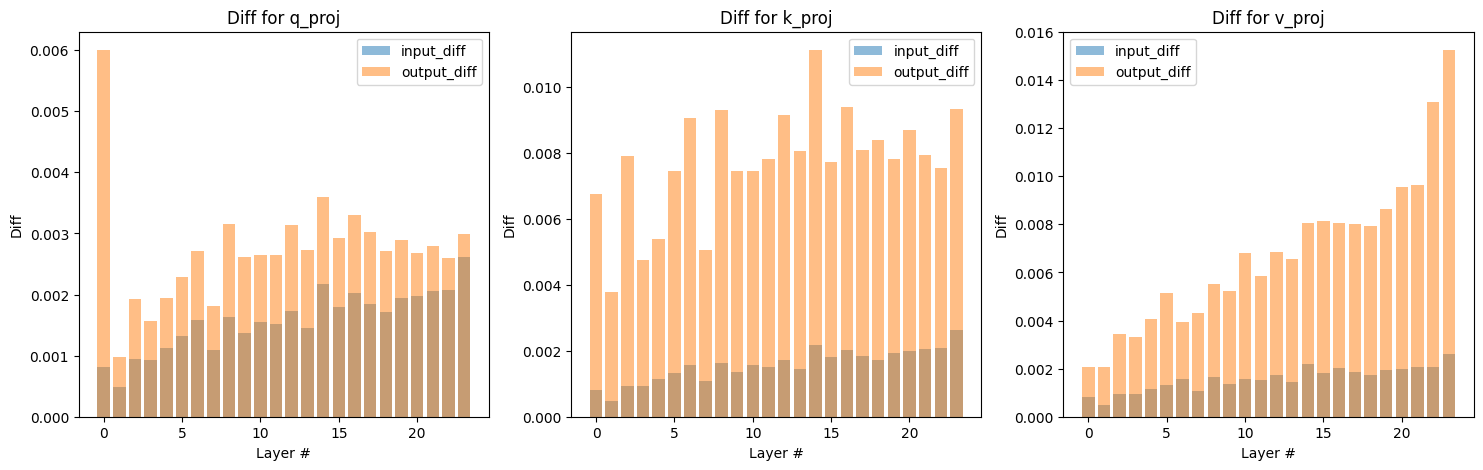

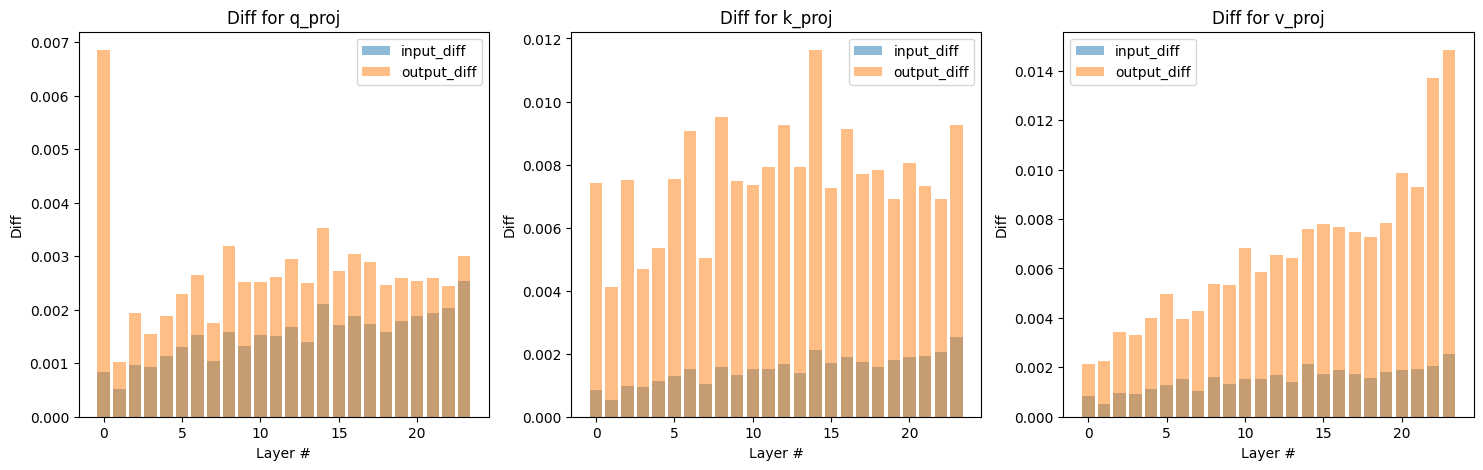

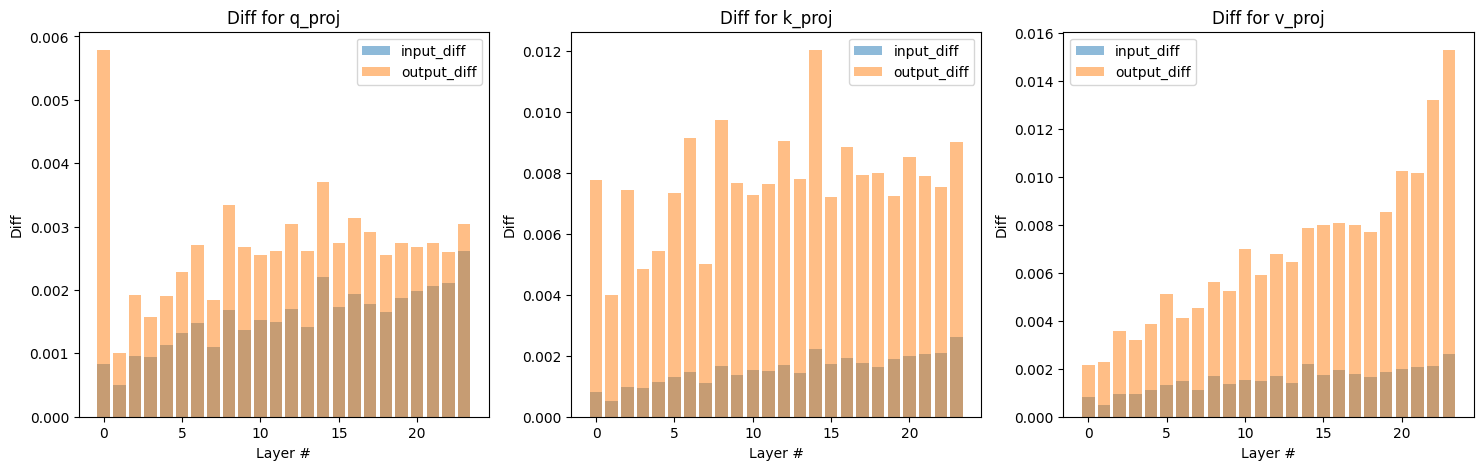

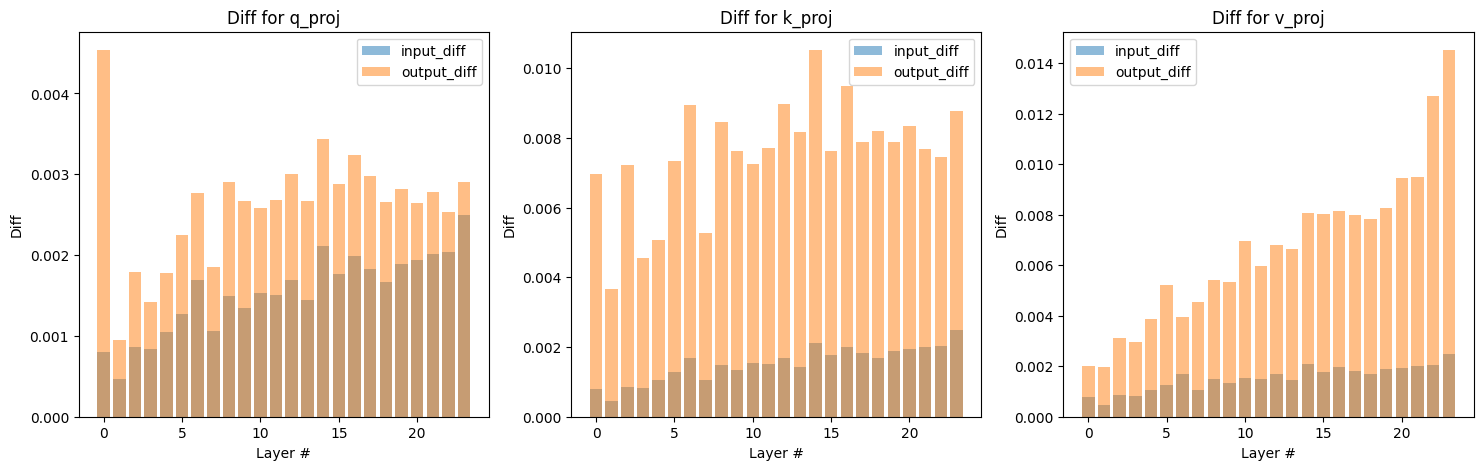

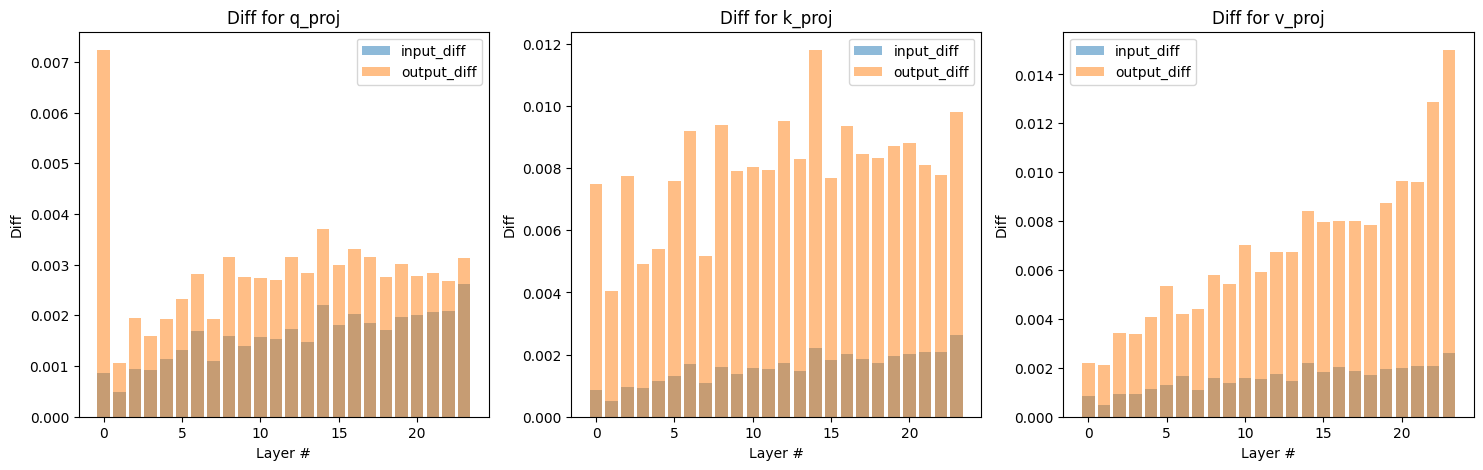

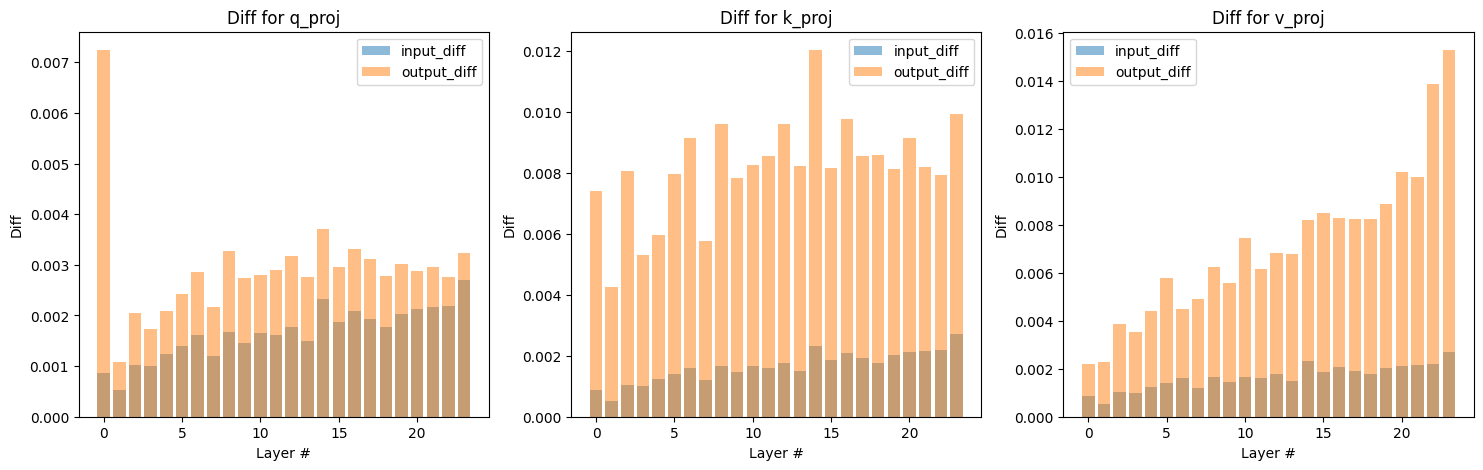

In [15]:
# 对比“(a)英文单词strawberry中有几个字母r”与“({})英文单词strawberry中有几个字母r”
for i in range(62, 113):
    easy_compare_forward_hook_data(
        hook_data_path_1 = hook_data_path_formatter.format(61), 
        hook_data_path_2 = hook_data_path_formatter.format(i),
        forward_hook_module_names = forward_hook_module_names[:],
        figure_names = ["q_proj", "k_proj", "v_proj"],
    )
    # if input(prompts[i]): break

### 对比两个不同长度的prompt的输出？

首个生成的token无法对比，后面都是可以对比的，因为用了cache，每次只传入一个token

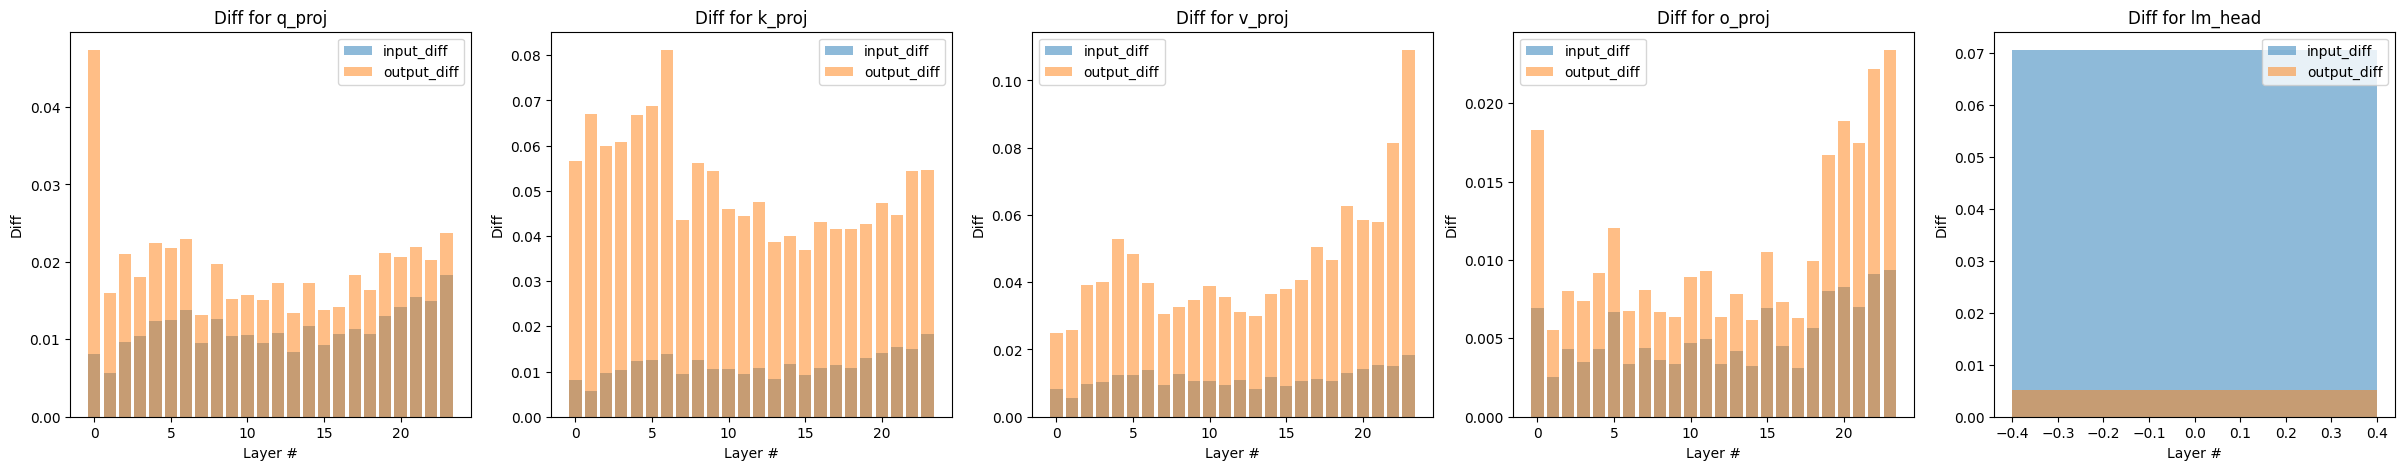

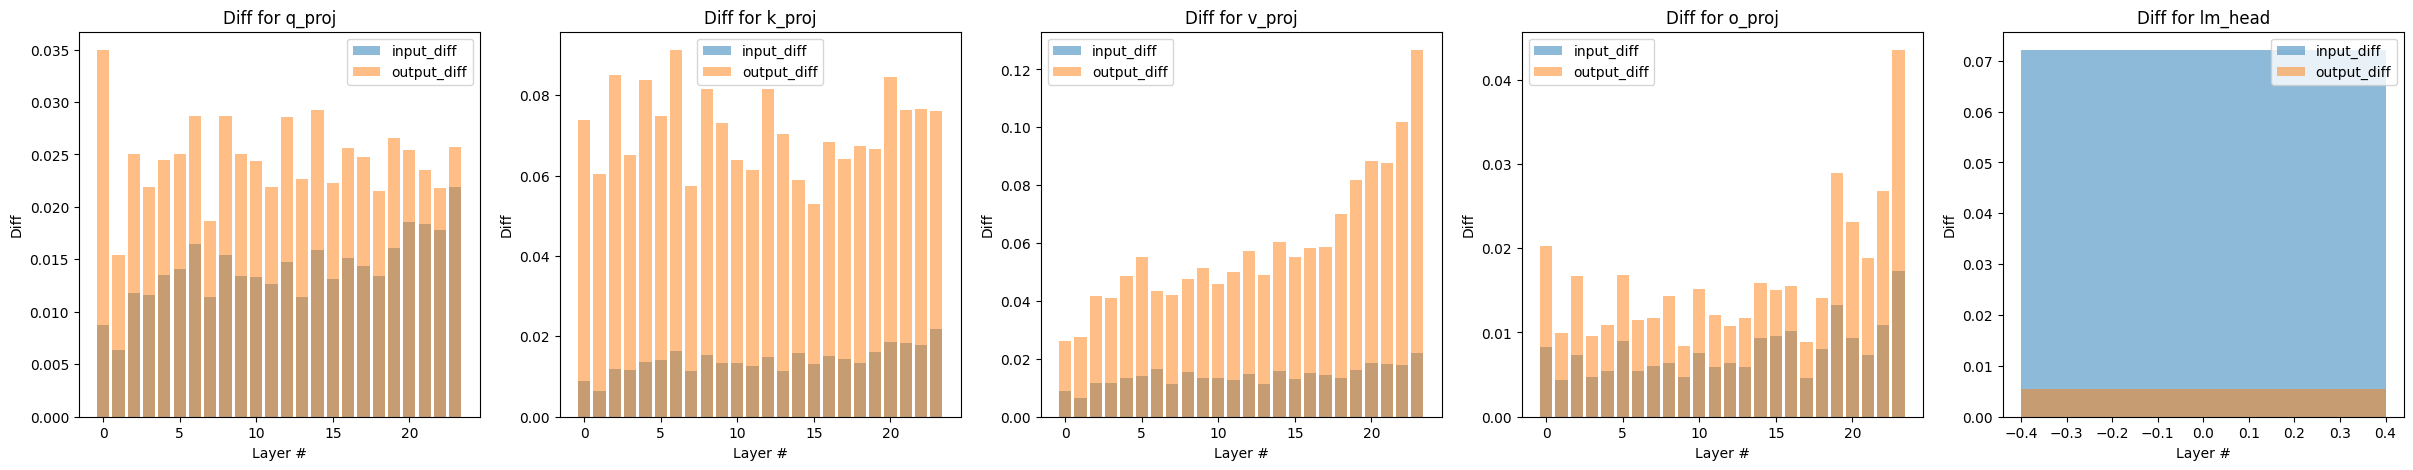

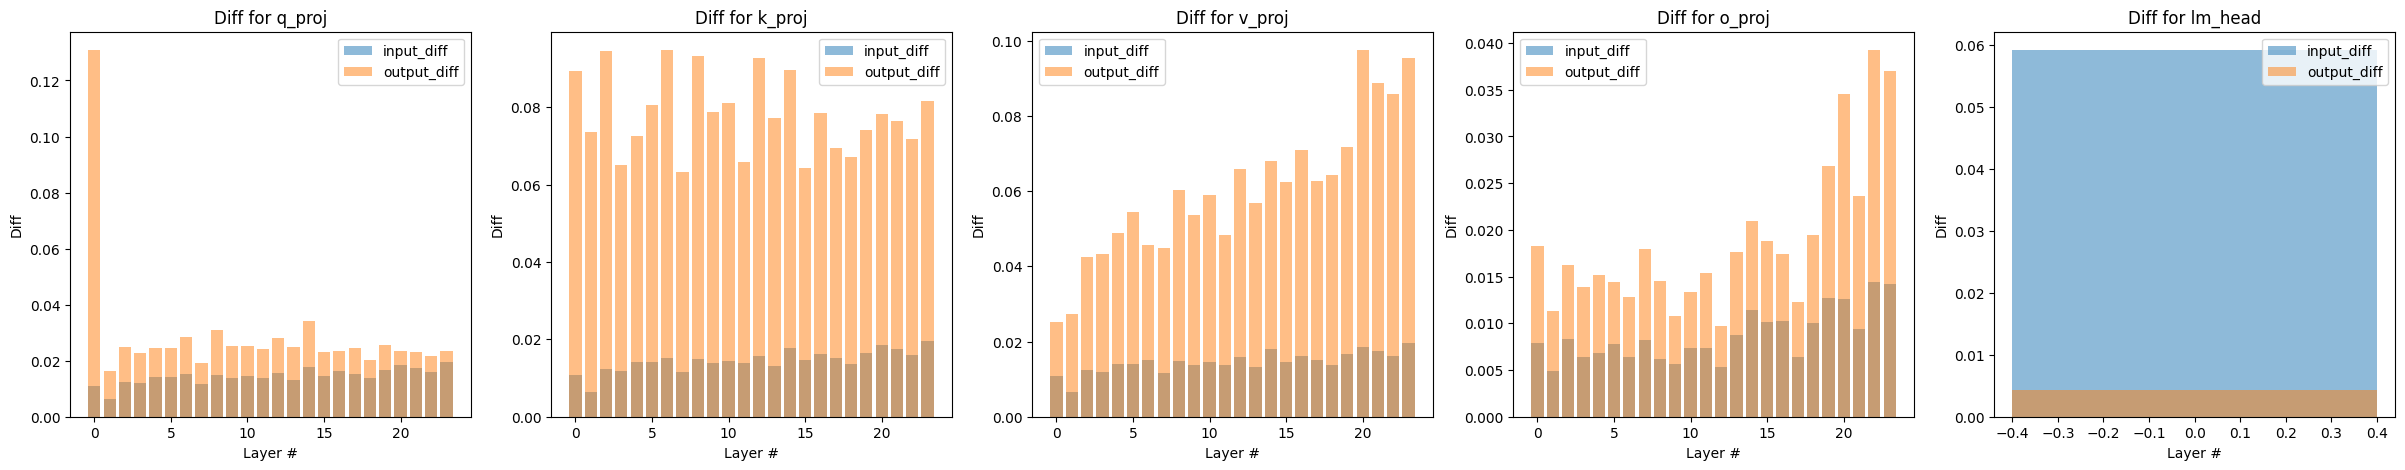

In [16]:
# 对比两个不同长度的prompt！！

# 对比“(a)英文单词strawberry中有几个字母r”与“({})英文单词strawberry中有几个字母r”
for pivot_at in range(1, 4):
    easy_compare_forward_hook_data(
        hook_data_path_1 = hook_data_path_formatter.format(68), 
        hook_data_path_2 = hook_data_path_formatter.format(17),
        forward_hook_module_names = forward_hook_module_names[:],
        figure_names = ["q_proj", "k_proj", "v_proj", "o_proj", "lm_head"],
        pivot_at = pivot_at,
    )
    # if input(prompts[i]): break

结论：

- DeepSeek-R1-Distill-Qwen-1.5B模型，虽然架构和Qwen2.5-0.5B-Instruct相同，但是表现出的性状并不完全一致

- 在q_proj上，总是output_diff比input_diff更大的

这里 DeepSeek-R1-Distill-Qwen-1.5B 和 Qwen2.5-0.5B-Instruct 有个区别：

```python
Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((1536,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbedding()
  )
  (lm_head): Linear(in_features=1536, out_features=151936, bias=False)
)
```

也就是输入维度$m=1536$要比 Case 2 的 Qwen2.5-0.5B-Instruct 大，根据 Case 1 的分析可知，输出的波动会更大，这里体现得很明确。输出的平均波动都要比输入大

从第一个对比（`# 对比“英文单词strawberry中有几个字母r”与“英文单词strawberry中有几个字母{x}”`）明显看到在Input diff上 Deepseek 甚至还比 Qwen 小，但是Output diff的波动明显数值基本相等（看y轴的上下界），甚至要更大

## Case 4 - DeepSeek layer 0~27

现在我们只讨论layer层面的输入和输出，即每个`Qwen2DecoderLayer`的输入和输出，在deepseek-r1-distill-qwen-1.5b有28个这样的层，qwen2.5-0.5b-instruct则只有24个。

使用的脚本为:

```python
def decode_pipeline_test():
	logging.info("Decode unittest ...")
	model_id = 4
	model_name_or_path = os.path.join(model_home, model_names[model_id])
	logging.info(f"  - Model: {model_name_or_path}")
	prompts = \
		[f"""英文单词strawberry中有几个字母{i}？""" for i in string.ascii_letters]
	max_length = 4
	use_kv_cache = True

	forward_hook_module_names = \
		[f"model.layers[{i}]" for i in range(28)]
	for i in range(len(prompts)): pass
```

- `strawberry-X-3`

In [17]:
forward_hook_module_names = [f"model.layers[{i}]" for i in range(28)]
hook_data_path_formatter = "./results/strawberry-X-3/fhook+DeepSeek-R1-Distill-Qwen-1.5B+True-{}.pt"
prompts = [f"""英文单词strawberry中有几个字母{i}？""" for i in string.ascii_letters]
for i, prompt in enumerate(prompts):
    print(i, prompt)

0 英文单词strawberry中有几个字母a？
1 英文单词strawberry中有几个字母b？
2 英文单词strawberry中有几个字母c？
3 英文单词strawberry中有几个字母d？
4 英文单词strawberry中有几个字母e？
5 英文单词strawberry中有几个字母f？
6 英文单词strawberry中有几个字母g？
7 英文单词strawberry中有几个字母h？
8 英文单词strawberry中有几个字母i？
9 英文单词strawberry中有几个字母j？
10 英文单词strawberry中有几个字母k？
11 英文单词strawberry中有几个字母l？
12 英文单词strawberry中有几个字母m？
13 英文单词strawberry中有几个字母n？
14 英文单词strawberry中有几个字母o？
15 英文单词strawberry中有几个字母p？
16 英文单词strawberry中有几个字母q？
17 英文单词strawberry中有几个字母r？
18 英文单词strawberry中有几个字母s？
19 英文单词strawberry中有几个字母t？
20 英文单词strawberry中有几个字母u？
21 英文单词strawberry中有几个字母v？
22 英文单词strawberry中有几个字母w？
23 英文单词strawberry中有几个字母x？
24 英文单词strawberry中有几个字母y？
25 英文单词strawberry中有几个字母z？
26 英文单词strawberry中有几个字母A？
27 英文单词strawberry中有几个字母B？
28 英文单词strawberry中有几个字母C？
29 英文单词strawberry中有几个字母D？
30 英文单词strawberry中有几个字母E？
31 英文单词strawberry中有几个字母F？
32 英文单词strawberry中有几个字母G？
33 英文单词strawberry中有几个字母H？
34 英文单词strawberry中有几个字母I？
35 英文单词strawberry中有几个字母J？
36 英文单词strawberry中有几个字母K？
37 英文单词strawberry中有几个字母L？
38 英文单词strawberry中有几个字

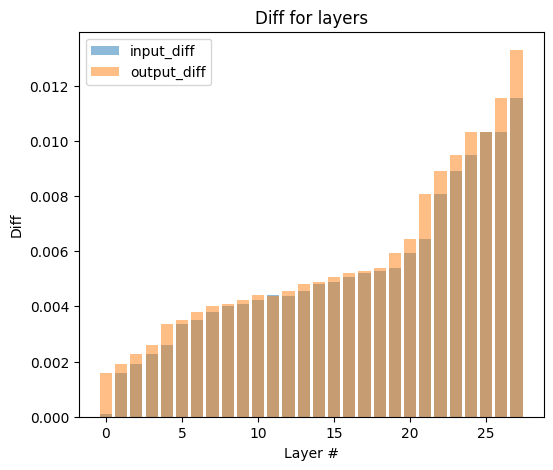

In [18]:
# 对比“英文单词strawberry中有几个字母r”与“英文单词strawberry中有几个字母{x}”
# 生成的第3个token的情况
for i in range(1):
    for pivot_at in range(1):
        diff_dict = easy_compare_forward_hook_data(
            hook_data_path_1 = hook_data_path_formatter.format(17), 
            hook_data_path_2 = hook_data_path_formatter.format(i),
            forward_hook_module_names = forward_hook_module_names[:],
            figure_names = ["layers"],
            pivot_at = pivot_at,
        )

这里我们只对比了一下两个prompt之间的区别，其余成对的情况差不太多，这里就取一个来看

因为注意到选定的prompt生成的前4个token都是一样的，所以可以考虑多比较几个token，依次比较了4个

- <font color=red>随着token生成的增加，误差也在增加，无论输入还是输出，第0,1,2个token是这样的，到第3个tokens时可以注意到，似乎下降了，不知道是因为饱和还是什么？</font>
- layers的误差随层数增加逐级增加，这是符合预期的，和qkv可能出现突变的情况不太一样

下一个案例中我们看看 Qwen 在更长的生成结果上呈现何种性状？

## Case 5 - Qwen layer 0-23

- `strawberry-X-4`

代码如下，跟 Case 4 的设定相同，只是换成Qwen模型，并且多hook了一个lm_head：

```python
def decode_pipeline_test():
	logging.info("Decode unittest ...")
	model_id = 0
	model_name_or_path = os.path.join(model_home, model_names[model_id])
	logging.info(f"  - Model: {model_name_or_path}")
	prompts = [f"""英文单词strawberry中有几个字母{i}？""" for i in string.ascii_letters]

	max_length = 16
	use_kv_cache = True
	forward_hook_module_names = \
		["lm_head"] + [f"model.layers[{i}]" for i in range(24)]
	
	for i in range(len(prompts)): pass
```

In [19]:
forward_hook_module_names = ["lm_head"] + [f"model.layers[{i}]" for i in range(24)]
hook_data_path_formatter = "./results/strawberry-X-4/fhook+Qwen2.5-0.5B-Instruct+True-{}.pt"
prompts = [f"""英文单词strawberry中有几个字母{i}？""" for i in string.ascii_letters]
for i, prompt in enumerate(prompts):
    print(i, prompt)

0 英文单词strawberry中有几个字母a？
1 英文单词strawberry中有几个字母b？
2 英文单词strawberry中有几个字母c？
3 英文单词strawberry中有几个字母d？
4 英文单词strawberry中有几个字母e？
5 英文单词strawberry中有几个字母f？
6 英文单词strawberry中有几个字母g？
7 英文单词strawberry中有几个字母h？
8 英文单词strawberry中有几个字母i？
9 英文单词strawberry中有几个字母j？
10 英文单词strawberry中有几个字母k？
11 英文单词strawberry中有几个字母l？
12 英文单词strawberry中有几个字母m？
13 英文单词strawberry中有几个字母n？
14 英文单词strawberry中有几个字母o？
15 英文单词strawberry中有几个字母p？
16 英文单词strawberry中有几个字母q？
17 英文单词strawberry中有几个字母r？
18 英文单词strawberry中有几个字母s？
19 英文单词strawberry中有几个字母t？
20 英文单词strawberry中有几个字母u？
21 英文单词strawberry中有几个字母v？
22 英文单词strawberry中有几个字母w？
23 英文单词strawberry中有几个字母x？
24 英文单词strawberry中有几个字母y？
25 英文单词strawberry中有几个字母z？
26 英文单词strawberry中有几个字母A？
27 英文单词strawberry中有几个字母B？
28 英文单词strawberry中有几个字母C？
29 英文单词strawberry中有几个字母D？
30 英文单词strawberry中有几个字母E？
31 英文单词strawberry中有几个字母F？
32 英文单词strawberry中有几个字母G？
33 英文单词strawberry中有几个字母H？
34 英文单词strawberry中有几个字母I？
35 英文单词strawberry中有几个字母J？
36 英文单词strawberry中有几个字母K？
37 英文单词strawberry中有几个字母L？
38 英文单词strawberry中有几个字

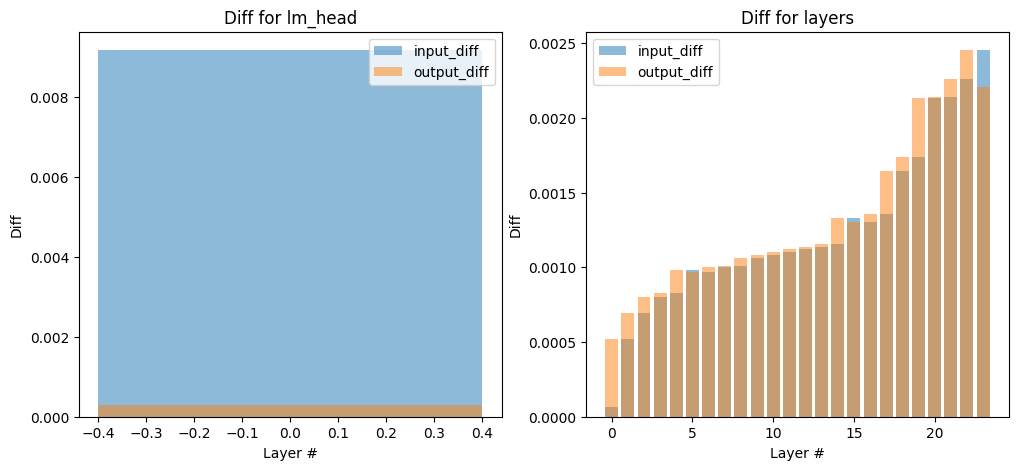

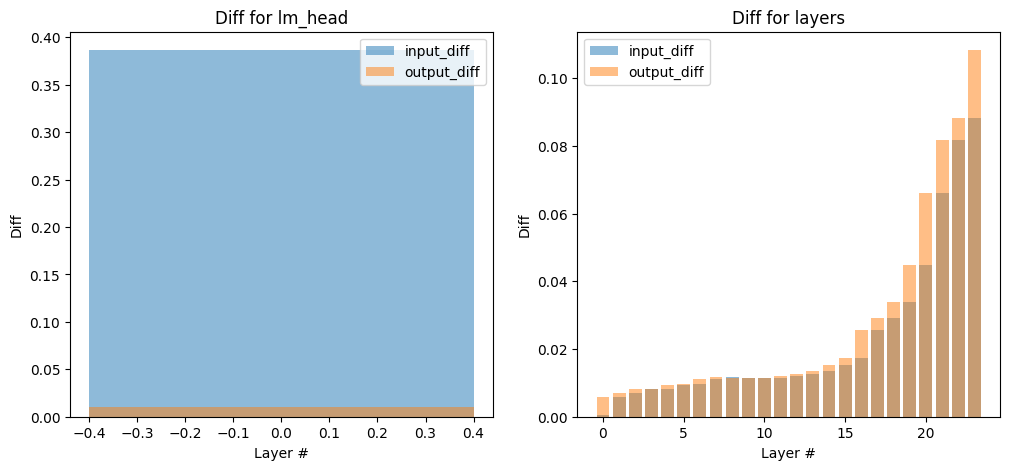

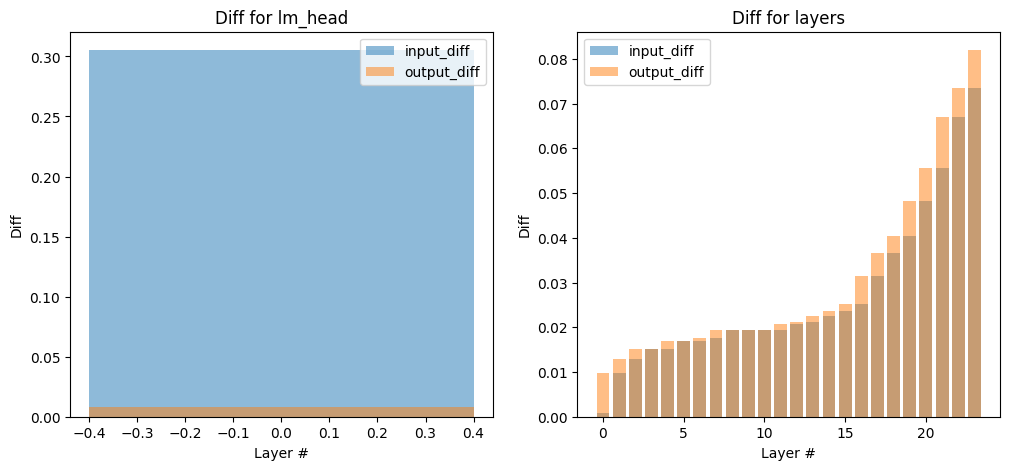

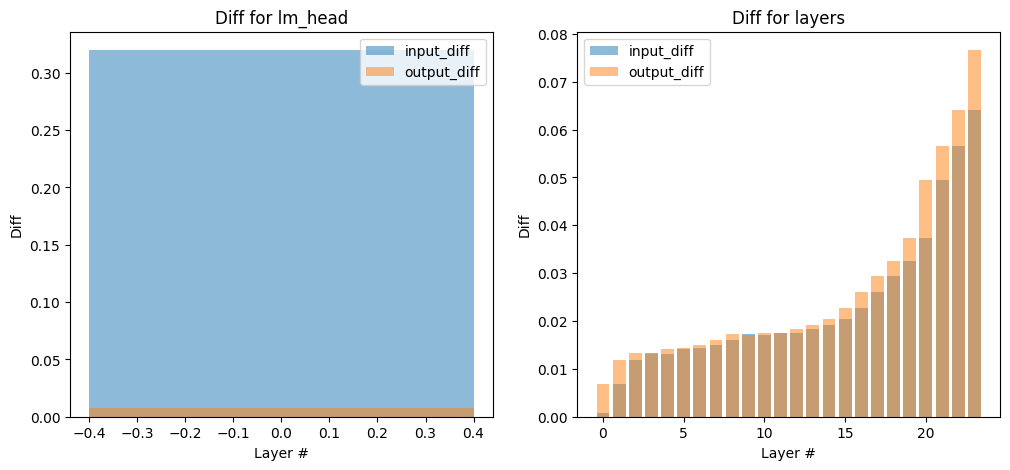

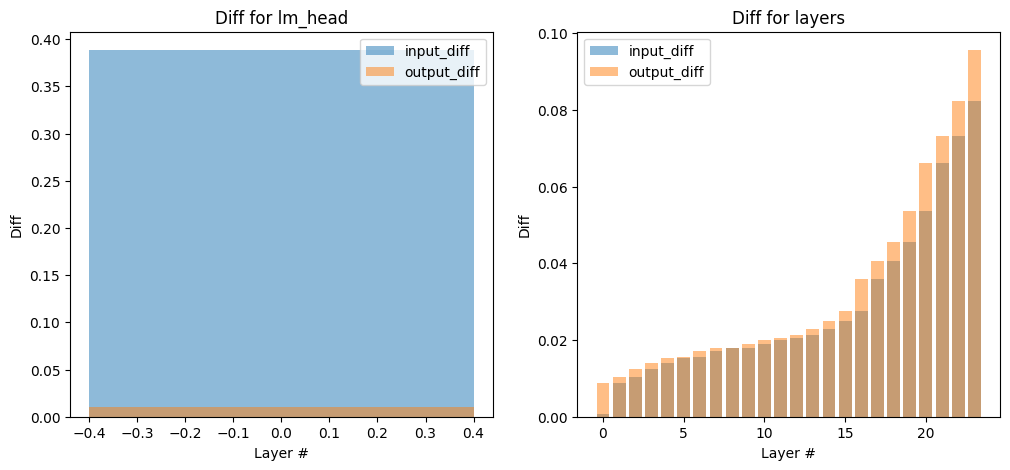

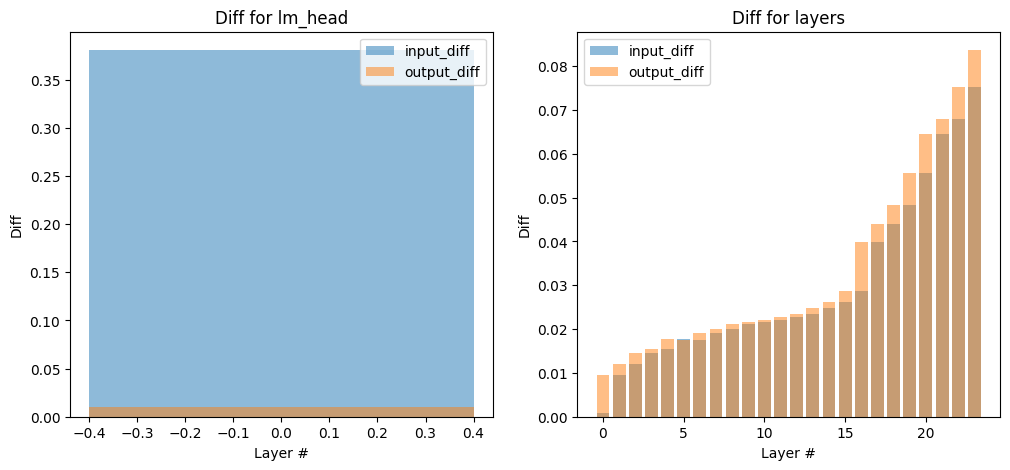

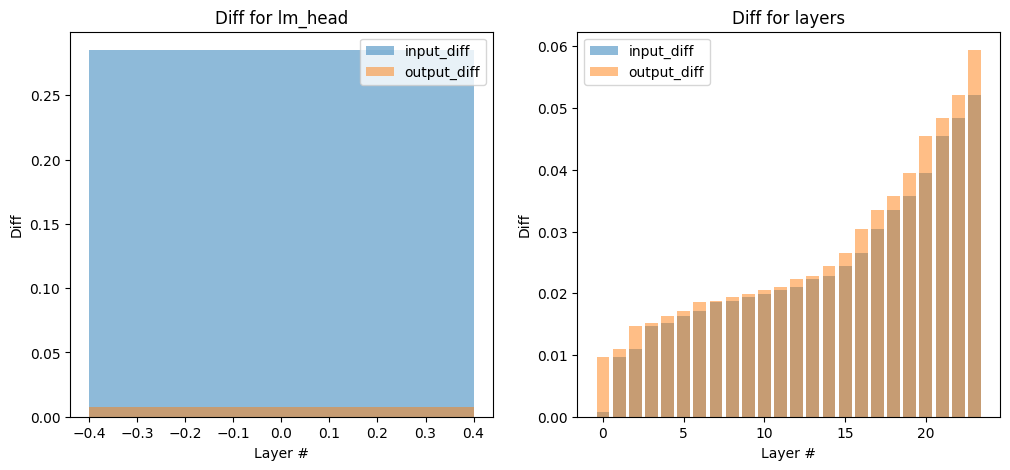

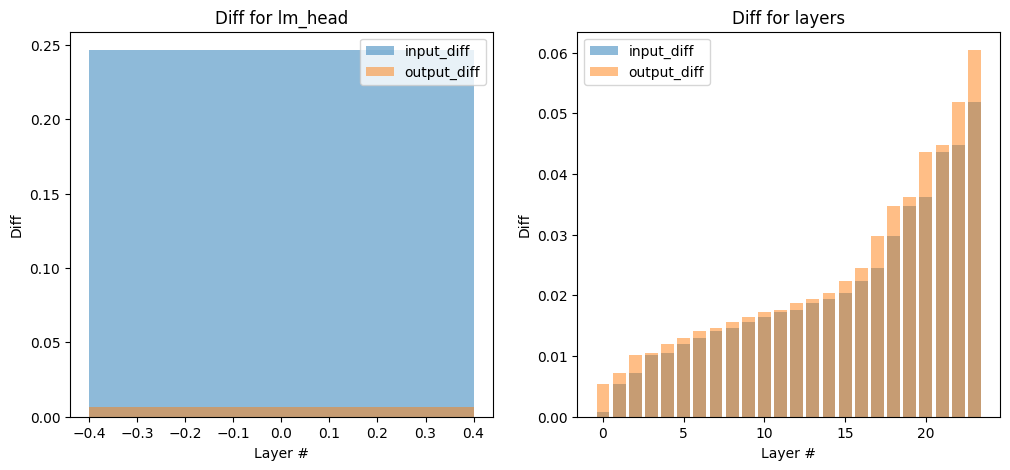

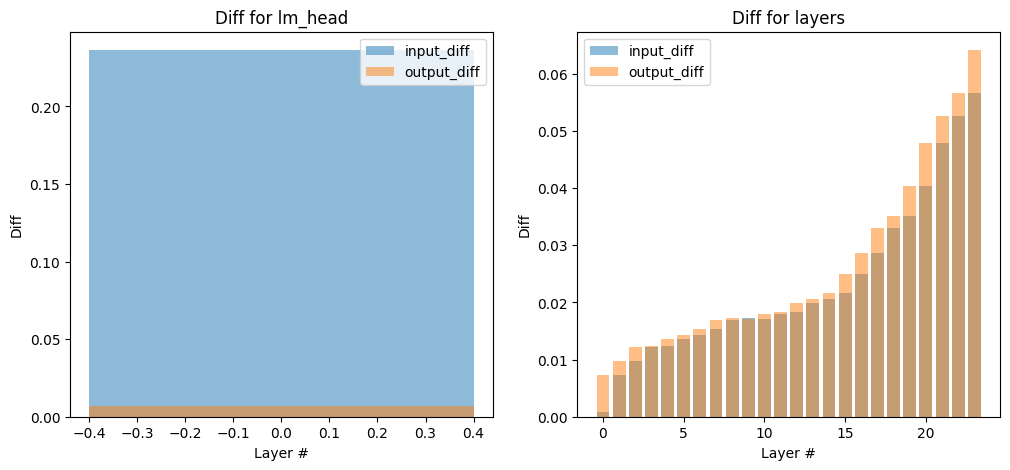

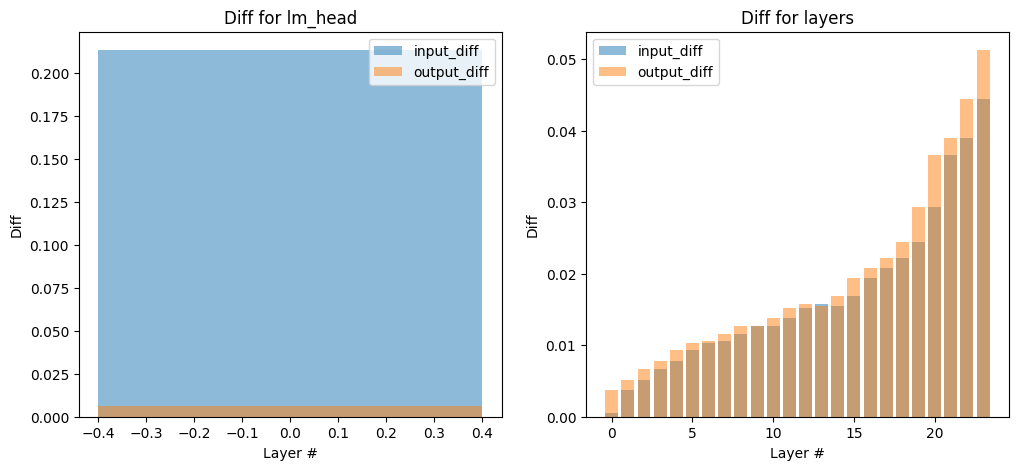

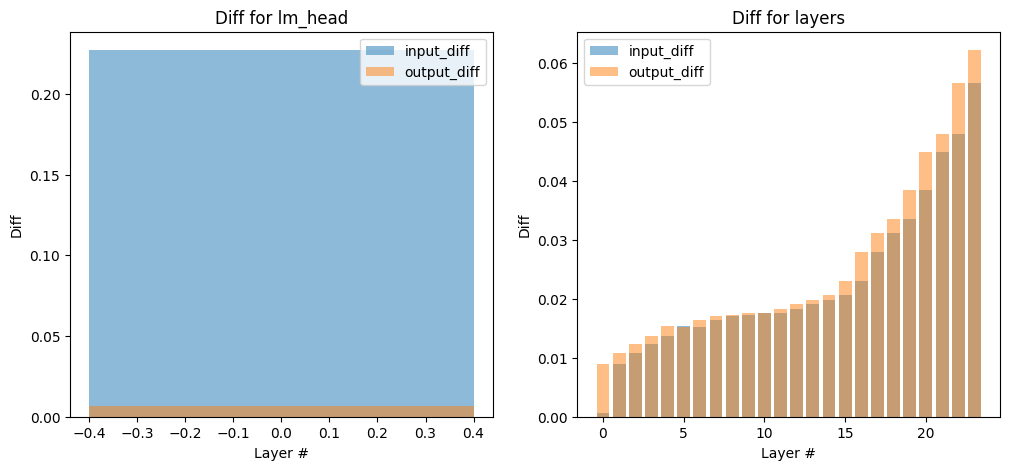

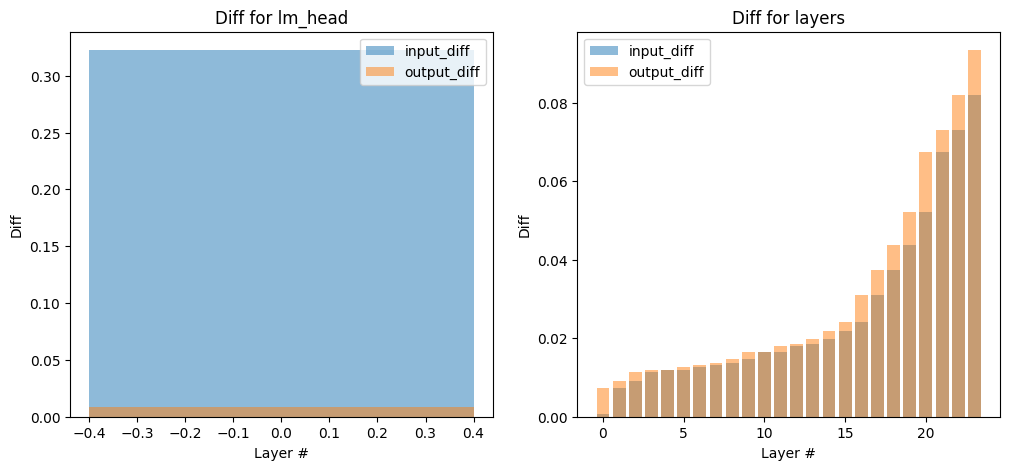

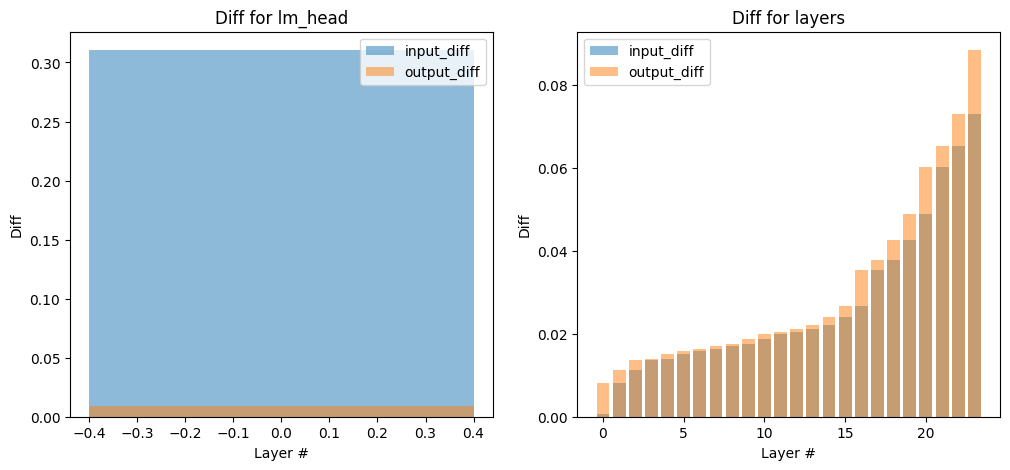

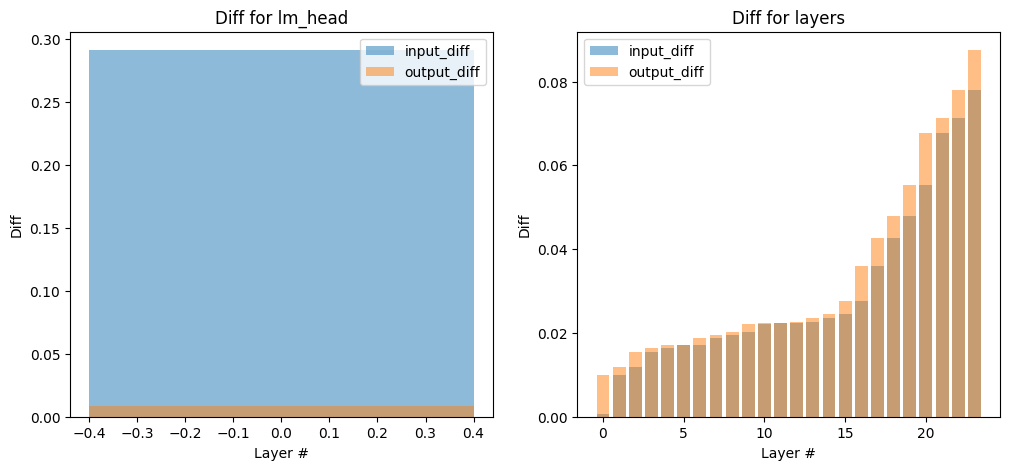

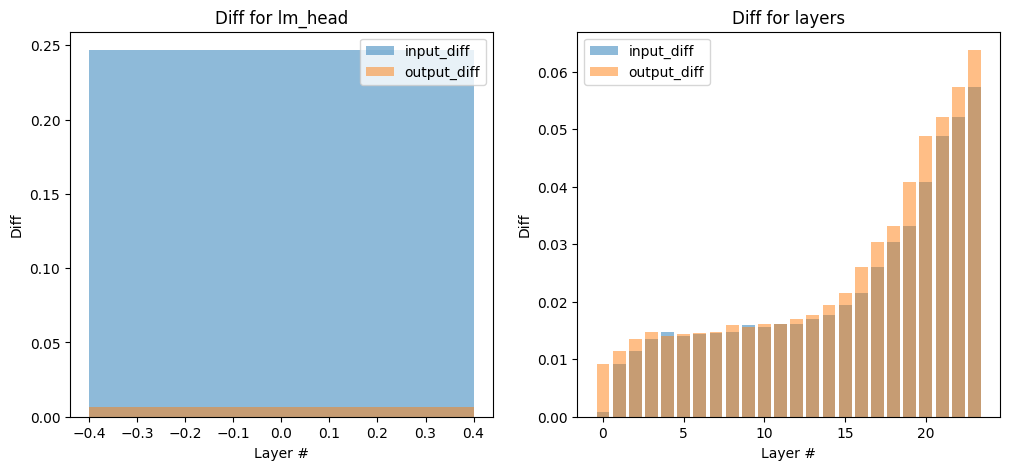

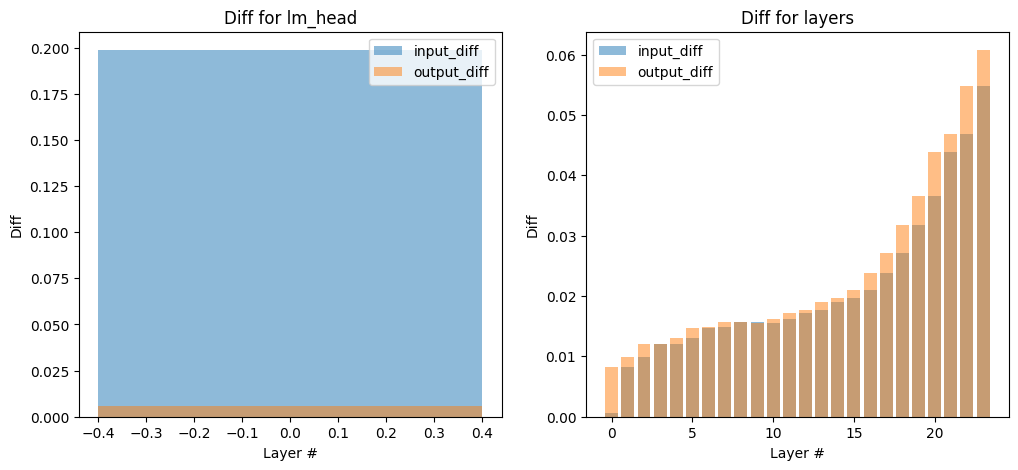

In [20]:
# 对比“英文单词strawberry中有几个字母r”与“英文单词strawberry中有几个字母{x}”
# 生成的第3个token的情况
for i in range(1):
    for pivot_at in range(16):
        easy_compare_forward_hook_data(
            hook_data_path_1 = hook_data_path_formatter.format(17), 
            hook_data_path_2 = hook_data_path_formatter.format(i),
            forward_hook_module_names = forward_hook_module_names[:],
            figure_names = ["lm_head", "layers"],
            pivot_at = pivot_at,
        )

- 这个应该是在生成第10个token时（从0开始计数）不同的prompt会生成不同的token（取决于prompt中计数哪个字母）

- 但是明显第10个token生成时的`lm_head`的输出偏差并没有和其他的有什么不一样（输出为最终的logits）

- `lm_head`是从896唯映射到151936维，这个是巨大的差异，其中可能只有少数几个维度的概率有所差别，其余都是负数，这就使得相较于真正的随机扰动，这种“尖锐”地扰动带来的整体扰动方差会非常大